##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5). This is an advanced example that assumes some knowledge of:

* Sequence to sequence models
* TensorFlow fundamentals below the keras layer: 
  * Working with tensors directly 
  * Writing custom `keras.Model`s and `keras.layers`

While this architecture is somewhat outdated it is still a very useful project to work through to get a deeper understanding of attention mechanisms (before going on to [Transformers](transformer.ipynb)).

After training the model in this notebook, you will be able to input a Spanish sentence, such as "*¿todavia estan en casa?*", and return the English translation: "*are you still at home?*"

The resulting model is exportable as a `tf.saved_model`, so it can be used in other TensorFlow environments.

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

## Setup

In [2]:
!pip install "tensorflow-text==2.8.*"

  Using cached tensorflow_text-2.8.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.9 MB)


In [3]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

This tutorial builds a few layers from scratch, use this variable if you want to switch between the custom and builtin implementations.

In [4]:
use_builtins = True

This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial. 


In [5]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but we'll use the English-Spanish dataset.

### Download and prepare the dataset

For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [6]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

  16384/2638744 [..............................] - ETA: 0s

2646016/2638744 [==============================] - 0s 0us/step


2654208/2638744 [==============================] - 0s 0us/step


In [7]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [8]:
targ, inp = load_data(path_to_file)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [9]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [10]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [11]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Ella no habla solamente ingl\xc3\xa9s, tambi\xc3\xa9n habla franc\xc3\xa9s.'
 b'Tom, di algo.' b'Nunca confundas l\xc3\xa1stima con amor.'
 b'Esos colores contrastan muy bien.'
 b'Hablar\xc3\xa9 contigo ma\xc3\xb1ana.'], shape=(5,), dtype=string)

tf.Tensor(
[b'She can speak not only English but also French.' b'Tom, say something.'
 b'Never confuse pity with love.' b'Those colors go well together.'
 b'I will speak to you tomorrow.'], shape=(5,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. 

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

In [12]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [13]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [15]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

The `TextVectorization` layer and many other preprocessing layers have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fix`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:  

In [16]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [17]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Now these layers can convert a batch of strings into a batch of token IDs:

In [18]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   29,    9,  219, 3079,  151,   19,  291,  219,  119],
       [   2,   10,   19,  569,   57,    4,    3,    0,    0,    0],
       [   2,   82,    1, 2162,   27,  638,    4,    3,    0,    0]])>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [19]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] ella no habla solamente ingles , tambien habla frances . [END]      '

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

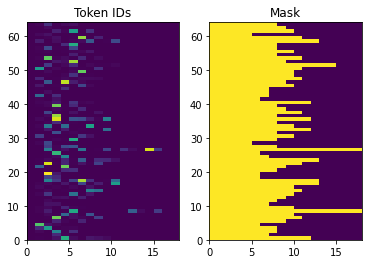

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

## The encoder/decoder model

The following diagram shows an overview of the model. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word. The diagram and formulas are from [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">


Before getting into it define a few constants for the model:

In [21]:
embedding_dim = 256
units = 1024

### The encoder

Start by building the encoder, the blue part of the diagram above.

The encoder:

1. Takes a list of token IDs (from `input_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a `layers.GRU`).
5. Returns:
  * The processed sequence. This will be passed to the attention head.
  * The internal state. This will be used to initialize the decoder


In [22]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

Here is how it fits together so far:

In [23]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 18)
Encoder output, shape (batch, s, units): (64, 18, 1024)
Encoder state, shape (batch, units): (64, 1024)


The encoder returns its internal state so that its state can be used to initialize the decoder.

It's also common for an RNN to return its state so that it can process a sequence over multiple calls. You'll see more of that building the decoder.

### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a _weighted_ average.

Let's look at how this works:

<img src="images/attention_equation_1.jpg" alt="attention equation 1" width="800">

<img src="images/attention_equation_2.jpg" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.


Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="images/attention_equation_4.jpg" alt="attention equation 4" width="800">

This tutorial uses [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf). TensorFlow includes implementations of both as `layers.Attention` and
`layers.AdditiveAttention`. The class below handles the weight matrices in a pair of `layers.Dense` layers, and calls the builtin implementation.

In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### Test the Attention layer

Create a `BahdanauAttention` layer:

In [25]:
attention_layer = BahdanauAttention(units)

This layer takes 3 inputs:

* The `query`: This will be generated by the decoder, later.
* The `value`: This Will be the output of the encoder.
* The `mask`: To exclude the padding, `example_tokens != 0`

In [26]:
(example_tokens != 0).shape

TensorShape([64, 18])

The vectorized implementation of the attention layer lets you pass a batch of sequences of query vectors and a batch of sequence of value vectors. The result is:

1. A batch of sequences of result vectors the size of the queries.
2. A batch attention maps, with size `(query_length, value_length)`.

In [27]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 18)


The attention weights should sum to `1.0` for each sequence.

Here are the attention weights across the sequences at `t=0`:

Text(0.5, 1.0, 'Mask')

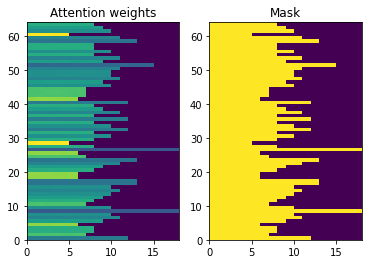

In [28]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


Because of the small-random initialization the attention weights are all close to `1/(sequence_length)`. If you zoom in on the weights for a single sequence, you can see that there is some _small_ variation that the model can learn to expand, and exploit.

In [29]:
attention_weights.shape

TensorShape([64, 2, 18])

In [30]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

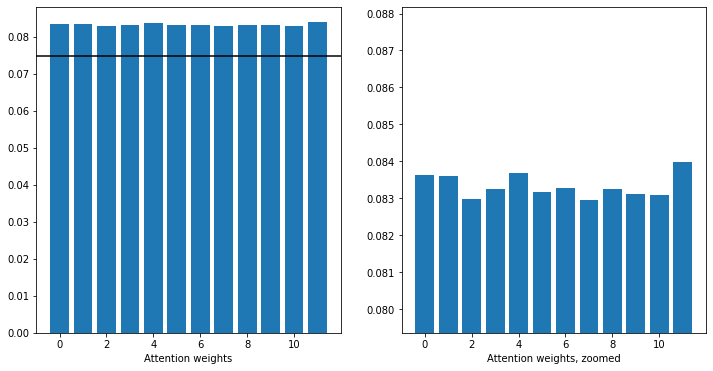

In [31]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

### The decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

<img src="images/attention_equation_3.jpg" alt="attention equation 3" width="800">


Here is the `Decoder` class and its initializer. The initializer creates all the necessary layers.

In [32]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

The `call` method for this layer takes and returns multiple tensors. Organize those into simple container classes:

In [33]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

Here is the implementation of the `call` method:

In [34]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [35]:
Decoder.call = call

The **encoder** processes its full input sequence with a single call to its RNN. This implementation of the **decoder** _can_ do that as well for efficient training. But this tutorial will run the decoder in a loop for a few reasons:

* Flexibility: Writing the loop gives you direct control over the training procedure.
* Clarity: It's possible to do masking tricks and use `layers.RNN`, or `tfa.seq2seq` APIs to pack this all into a single call. But writing it out as a loop may be clearer. 
  * Loop free training is demonstrated in the [Text generation](text_generation.ipynb) tutiorial.


Now try using this decoder.

In [36]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

The decoder takes 4 inputs.

* `new_tokens` -  The last token generated. Initialize the decoder with the `"[START]"` token.
* `enc_output` - Generated by the `Encoder`.
* `mask` - A boolean tensor indicating where `tokens != 0`
* `state` - The previous `state` output from the decoder (the internal state
  of the decoder's RNN). Pass `None` to zero-initialize it. The original
  paper initializes it from the encoder's final RNN state. 

In [37]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [38]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


Sample a token according to the logits:

In [39]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

Decode the token as the first word of the output:

In [40]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['witty'],
       ['carbon'],
       ['punished'],
       ['earn'],
       ['earth']], dtype='<U16')

Now use the decoder to generate a second set of logits.

- Pass the same `enc_output` and `mask`, these haven't changed.
- Pass the sampled token as `new_tokens`.
- Pass the `decoder_state` the decoder returned last time, so the RNN continues with a memory of where it left off last time.


In [41]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [42]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['horse'],
       ['egypt'],
       ['earth'],
       ['mornings'],
       ['wanted']], dtype='<U16')

## Training

Now that you have all the model components, it's time to start training the model. You'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Define the loss function

In [43]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### Implement the training step

Start with a model class, the training process will be implemented as the `train_step` method on this model. See [Customizing fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details.

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

In [44]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks. 
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss. 
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

The `_preprocess` method, added below, implements steps #1 and #2: 

In [45]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [46]:
TrainTranslator._preprocess = _preprocess

The `_train_step` method, added below, handles the remaining steps except for actually running the decoder: 

In [47]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [48]:
TrainTranslator._train_step = _train_step

The `_loop_step` method, added below, executes the decoder and calculates the incremental loss and new decoder state (`dec_state`).

In [49]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [50]:
TrainTranslator._loop_step = _loop_step

### Test the training step

Build a `TrainTranslator`, and configure it for training using the `Model.compile` method:

In [51]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

Test out the `train_step`. For a text model like this the loss should start near:

In [52]:
np.log(output_text_processor.vocabulary_size())

8.517193191416236

In [53]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6493683>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.621678>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.572432>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.4398246>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.004785>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.359759>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.9889755>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.043585>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.263548>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.344835>}

CPU times: user 6.47 s, sys: 0 ns, total: 6.47 s
Wall time: 6.43 s


While it's easier to debug without a `tf.function` it does give a performance boost. So now that the `_train_step` method is working, try the `tf.function`-wrapped `_tf_train_step`, to maximize performance while training:

In [54]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [55]:
TrainTranslator._tf_train_step = _tf_train_step

In [56]:
translator.use_tf_function = True

The first call will be slow, because it traces the function.

In [57]:
translator.train_step([example_input_batch, example_target_batch])

2022-03-29 11:41:18.103020: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2022-03-29 11:41:18.212587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25


2022-03-29 11:41:18.321194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
	when importing GraphDef to MLIR module in GrapplerHook
2022-03-29 11:41:18.345910: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.288319>}

But after that it's usually 2-3x faster than the eager `train_step` method:

In [58]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2695713>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.300747>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.278475>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.200177>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1282115>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.06795>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.986227>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9358509>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9019783>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8605642>}

CPU times: user 5.44 s, sys: 974 ms, total: 6.41 s
Wall time: 1.99 s


A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:

.

.

.

..

.

..

.

.

.

..

..

.

.

.

..

.

..

..

..

..

.

.

..

..

..

.

..

..

..

..

..

.

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

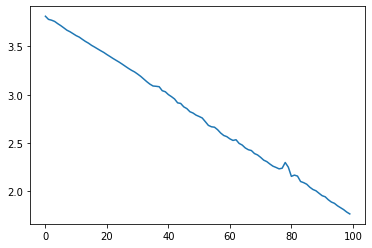

In [59]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

In [60]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [61]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [62]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3


2022-03-29 11:41:45.562769: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2022-03-29 11:41:45.678988: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25


2022-03-29 11:41:45.795338: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
	when importing GraphDef to MLIR module in GrapplerHook
2022-03-29 11:41:45.821285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/wh

   1/1859 [..............................] - ETA: 2:55:09 - batch_loss: 7.6213

   2/1859 [..............................] - ETA: 9:59 - batch_loss: 7.6077   

   3/1859 [..............................] - ETA: 7:57 - batch_loss: 7.5737

   4/1859 [..............................] - ETA: 7:11 - batch_loss: 7.5387

   5/1859 [..............................] - ETA: 7:07 - batch_loss: 7.4479

   6/1859 [..............................] - ETA: 7:02 - batch_loss: 7.1423

   7/1859 [..............................] - ETA: 6:45 - batch_loss: 6.8486

   8/1859 [..............................] - ETA: 6:47 - batch_loss: 6.6628

   9/1859 [..............................] - ETA: 6:39 - batch_loss: 6.4786

  10/1859 [..............................] - ETA: 6:37 - batch_loss: 6.3534

  11/1859 [..............................] - ETA: 6:26 - batch_loss: 6.2170

  12/1859 [..............................] - ETA: 6:26 - batch_loss: 6.1043

  13/1859 [..............................] - ETA: 6:27 - batch_loss: 6.0194

  14/1859 [..............................] - ETA: 6:28 - batch_loss: 5.9478

  15/1859 [..............................] - ETA: 6:30 - batch_loss: 5.8726

  16/1859 [..............................] - ETA: 6:36 - batch_loss: 5.8138

  17/1859 [..............................] - ETA: 6:36 - batch_loss: 5.7516

  18/1859 [..............................] - ETA: 6:30 - batch_loss: 5.6932

  19/1859 [..............................] - ETA: 6:26 - batch_loss: 5.6350

  20/1859 [..............................] - ETA: 6:25 - batch_loss: 5.5837

  21/1859 [..............................] - ETA: 6:24 - batch_loss: 5.5413

  22/1859 [..............................] - ETA: 6:23 - batch_loss: 5.4996

  23/1859 [..............................] - ETA: 6:22 - batch_loss: 5.4562

  24/1859 [..............................] - ETA: 6:19 - batch_loss: 5.4121

  25/1859 [..............................] - ETA: 6:21 - batch_loss: 5.3736

  26/1859 [..............................] - ETA: 6:20 - batch_loss: 5.3433

  27/1859 [..............................] - ETA: 6:21 - batch_loss: 5.3160

  28/1859 [..............................] - ETA: 6:20 - batch_loss: 5.2887

  29/1859 [..............................] - ETA: 6:18 - batch_loss: 5.2579

  30/1859 [..............................] - ETA: 6:17 - batch_loss: 5.2322

  31/1859 [..............................] - ETA: 6:14 - batch_loss: 5.2009

  32/1859 [..............................] - ETA: 6:11 - batch_loss: 5.1751

  33/1859 [..............................] - ETA: 6:14 - batch_loss: 5.1493

  34/1859 [..............................] - ETA: 6:12 - batch_loss: 5.1275

  35/1859 [..............................] - ETA: 6:12 - batch_loss: 5.1085

  36/1859 [..............................] - ETA: 6:11 - batch_loss: 5.0908

  37/1859 [..............................] - ETA: 6:11 - batch_loss: 5.0730

  38/1859 [..............................] - ETA: 6:17 - batch_loss: 5.0545

  39/1859 [..............................] - ETA: 6:17 - batch_loss: 5.0390

  40/1859 [..............................] - ETA: 6:17 - batch_loss: 5.0204

  41/1859 [..............................] - ETA: 6:16 - batch_loss: 5.0063

  42/1859 [..............................] - ETA: 6:16 - batch_loss: 4.9893

  43/1859 [..............................] - ETA: 6:16 - batch_loss: 4.9741

  44/1859 [..............................] - ETA: 6:13 - batch_loss: 4.9592

  45/1859 [..............................] - ETA: 6:13 - batch_loss: 4.9486

  46/1859 [..............................] - ETA: 6:16 - batch_loss: 4.9350

  47/1859 [..............................] - ETA: 6:14 - batch_loss: 4.9229

  48/1859 [..............................] - ETA: 6:14 - batch_loss: 4.9101

  49/1859 [..............................] - ETA: 6:13 - batch_loss: 4.8999

  50/1859 [..............................] - ETA: 6:14 - batch_loss: 4.8855

  51/1859 [..............................] - ETA: 6:13 - batch_loss: 4.8739

  52/1859 [..............................] - ETA: 6:12 - batch_loss: 4.8653

  53/1859 [..............................] - ETA: 6:12 - batch_loss: 4.8538

  54/1859 [..............................] - ETA: 6:12 - batch_loss: 4.8429

  55/1859 [..............................] - ETA: 6:11 - batch_loss: 4.8313

  56/1859 [..............................] - ETA: 6:10 - batch_loss: 4.8196

  57/1859 [..............................] - ETA: 6:09 - batch_loss: 4.8130

  58/1859 [..............................] - ETA: 6:08 - batch_loss: 4.8018

  59/1859 [..............................] - ETA: 6:08 - batch_loss: 4.7926

  60/1859 [..............................] - ETA: 6:07 - batch_loss: 4.7808

  61/1859 [..............................] - ETA: 6:06 - batch_loss: 4.7682

  62/1859 [>.............................] - ETA: 6:06 - batch_loss: 4.7626

  63/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.7508

  64/1859 [>.............................] - ETA: 6:06 - batch_loss: 4.7424

  65/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.7321

  66/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.7222

  67/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.7113

  68/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.7026

  69/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.6924

  70/1859 [>.............................] - ETA: 6:06 - batch_loss: 4.6858

  71/1859 [>.............................] - ETA: 6:06 - batch_loss: 4.6781

  72/1859 [>.............................] - ETA: 6:06 - batch_loss: 4.6706

  73/1859 [>.............................] - ETA: 6:06 - batch_loss: 4.6637

  74/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.6537

  75/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.6453

  76/1859 [>.............................] - ETA: 6:04 - batch_loss: 4.6369

  77/1859 [>.............................] - ETA: 6:04 - batch_loss: 4.6282

  78/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.6238

  79/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.6174

  80/1859 [>.............................] - ETA: 6:06 - batch_loss: 4.6127

  81/1859 [>.............................] - ETA: 6:07 - batch_loss: 4.6034

  82/1859 [>.............................] - ETA: 6:07 - batch_loss: 4.5953

  83/1859 [>.............................] - ETA: 6:06 - batch_loss: 4.5880

  84/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.5808

  85/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.5762

  86/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.5681

  87/1859 [>.............................] - ETA: 6:05 - batch_loss: 4.5610

  88/1859 [>.............................] - ETA: 6:04 - batch_loss: 4.5545

  89/1859 [>.............................] - ETA: 6:03 - batch_loss: 4.5480

  90/1859 [>.............................] - ETA: 6:03 - batch_loss: 4.5415

  91/1859 [>.............................] - ETA: 6:02 - batch_loss: 4.5357

  92/1859 [>.............................] - ETA: 6:01 - batch_loss: 4.5274

  93/1859 [>.............................] - ETA: 6:00 - batch_loss: 4.5194

  94/1859 [>.............................] - ETA: 6:00 - batch_loss: 4.5130

  95/1859 [>.............................] - ETA: 6:00 - batch_loss: 4.5081

  96/1859 [>.............................] - ETA: 5:59 - batch_loss: 4.5020

  97/1859 [>.............................] - ETA: 5:58 - batch_loss: 4.4953

  98/1859 [>.............................] - ETA: 5:58 - batch_loss: 4.4903

  99/1859 [>.............................] - ETA: 5:58 - batch_loss: 4.4851

 100/1859 [>.............................] - ETA: 5:58 - batch_loss: 4.4794

 101/1859 [>.............................] - ETA: 5:59 - batch_loss: 4.4748

 102/1859 [>.............................] - ETA: 6:03 - batch_loss: 4.4714

 103/1859 [>.............................] - ETA: 6:02 - batch_loss: 4.4660

 104/1859 [>.............................] - ETA: 6:04 - batch_loss: 4.4604

 105/1859 [>.............................] - ETA: 6:03 - batch_loss: 4.4545

 106/1859 [>.............................] - ETA: 6:02 - batch_loss: 4.4487

 107/1859 [>.............................] - ETA: 6:03 - batch_loss: 4.4450

 108/1859 [>.............................] - ETA: 6:04 - batch_loss: 4.4401

 109/1859 [>.............................] - ETA: 6:04 - batch_loss: 4.4351

 110/1859 [>.............................] - ETA: 6:03 - batch_loss: 4.4298

 111/1859 [>.............................] - ETA: 6:03 - batch_loss: 4.4241

 112/1859 [>.............................] - ETA: 6:03 - batch_loss: 4.4204

 113/1859 [>.............................] - ETA: 6:03 - batch_loss: 4.4142

 114/1859 [>.............................] - ETA: 6:02 - batch_loss: 4.4080

 115/1859 [>.............................] - ETA: 6:02 - batch_loss: 4.4020

 116/1859 [>.............................] - ETA: 6:02 - batch_loss: 4.3965

 117/1859 [>.............................] - ETA: 6:02 - batch_loss: 4.3911

 118/1859 [>.............................] - ETA: 6:02 - batch_loss: 4.3852

 119/1859 [>.............................] - ETA: 6:01 - batch_loss: 4.3800

 120/1859 [>.............................] - ETA: 6:01 - batch_loss: 4.3754

 121/1859 [>.............................] - ETA: 6:01 - batch_loss: 4.3709

 122/1859 [>.............................] - ETA: 6:00 - batch_loss: 4.3668

 123/1859 [>.............................] - ETA: 6:00 - batch_loss: 4.3618

 124/1859 [=>............................] - ETA: 6:00 - batch_loss: 4.3569

 125/1859 [=>............................] - ETA: 6:00 - batch_loss: 4.3504

 126/1859 [=>............................] - ETA: 5:59 - batch_loss: 4.3461

 127/1859 [=>............................] - ETA: 5:59 - batch_loss: 4.3421

 128/1859 [=>............................] - ETA: 6:00 - batch_loss: 4.3384

 129/1859 [=>............................] - ETA: 6:00 - batch_loss: 4.3327

 130/1859 [=>............................] - ETA: 6:01 - batch_loss: 4.3287

 131/1859 [=>............................] - ETA: 6:00 - batch_loss: 4.3245

 132/1859 [=>............................] - ETA: 6:01 - batch_loss: 4.3195

 133/1859 [=>............................] - ETA: 6:00 - batch_loss: 4.3147

 134/1859 [=>............................] - ETA: 5:59 - batch_loss: 4.3079

 135/1859 [=>............................] - ETA: 5:59 - batch_loss: 4.3033

 136/1859 [=>............................] - ETA: 5:59 - batch_loss: 4.3002

 137/1859 [=>............................] - ETA: 5:59 - batch_loss: 4.2952

 138/1859 [=>............................] - ETA: 5:59 - batch_loss: 4.2912

 139/1859 [=>............................] - ETA: 5:58 - batch_loss: 4.2877

 140/1859 [=>............................] - ETA: 5:58 - batch_loss: 4.2843

 141/1859 [=>............................] - ETA: 5:58 - batch_loss: 4.2780

 142/1859 [=>............................] - ETA: 5:57 - batch_loss: 4.2728

 143/1859 [=>............................] - ETA: 5:56 - batch_loss: 4.2673

 144/1859 [=>............................] - ETA: 5:55 - batch_loss: 4.2627

 145/1859 [=>............................] - ETA: 5:55 - batch_loss: 4.2582

 146/1859 [=>............................] - ETA: 5:55 - batch_loss: 4.2530

 147/1859 [=>............................] - ETA: 5:54 - batch_loss: 4.2478

 148/1859 [=>............................] - ETA: 5:55 - batch_loss: 4.2433

 149/1859 [=>............................] - ETA: 5:54 - batch_loss: 4.2379

 150/1859 [=>............................] - ETA: 5:54 - batch_loss: 4.2335

 151/1859 [=>............................] - ETA: 5:55 - batch_loss: 4.2302

 152/1859 [=>............................] - ETA: 5:54 - batch_loss: 4.2247

 153/1859 [=>............................] - ETA: 5:54 - batch_loss: 4.2210

 154/1859 [=>............................] - ETA: 5:53 - batch_loss: 4.2158

 155/1859 [=>............................] - ETA: 5:53 - batch_loss: 4.2114

 156/1859 [=>............................] - ETA: 5:54 - batch_loss: 4.2089

 157/1859 [=>............................] - ETA: 5:54 - batch_loss: 4.2053

 158/1859 [=>............................] - ETA: 5:54 - batch_loss: 4.2008

 159/1859 [=>............................] - ETA: 5:54 - batch_loss: 4.1967

 160/1859 [=>............................] - ETA: 5:53 - batch_loss: 4.1932

 161/1859 [=>............................] - ETA: 5:53 - batch_loss: 4.1893

 162/1859 [=>............................] - ETA: 5:53 - batch_loss: 4.1849

 163/1859 [=>............................] - ETA: 5:52 - batch_loss: 4.1818

 164/1859 [=>............................] - ETA: 5:52 - batch_loss: 4.1785

 165/1859 [=>............................] - ETA: 5:51 - batch_loss: 4.1744

 166/1859 [=>............................] - ETA: 5:51 - batch_loss: 4.1706

 167/1859 [=>............................] - ETA: 5:51 - batch_loss: 4.1670

 168/1859 [=>............................] - ETA: 5:50 - batch_loss: 4.1628

 169/1859 [=>............................] - ETA: 5:50 - batch_loss: 4.1592

 170/1859 [=>............................] - ETA: 5:50 - batch_loss: 4.1550

 171/1859 [=>............................] - ETA: 5:50 - batch_loss: 4.1511

 172/1859 [=>............................] - ETA: 5:50 - batch_loss: 4.1469

 173/1859 [=>............................] - ETA: 5:50 - batch_loss: 4.1429

 174/1859 [=>............................] - ETA: 5:49 - batch_loss: 4.1396

 175/1859 [=>............................] - ETA: 5:49 - batch_loss: 4.1354

 176/1859 [=>............................] - ETA: 5:49 - batch_loss: 4.1322

 177/1859 [=>............................] - ETA: 5:48 - batch_loss: 4.1282

 178/1859 [=>............................] - ETA: 5:48 - batch_loss: 4.1259

 179/1859 [=>............................] - ETA: 5:48 - batch_loss: 4.1228

 180/1859 [=>............................] - ETA: 5:48 - batch_loss: 4.1190

 181/1859 [=>............................] - ETA: 5:47 - batch_loss: 4.1144

 182/1859 [=>............................] - ETA: 5:47 - batch_loss: 4.1108

 183/1859 [=>............................] - ETA: 5:47 - batch_loss: 4.1064

 184/1859 [=>............................] - ETA: 5:47 - batch_loss: 4.1032

 185/1859 [=>............................] - ETA: 5:46 - batch_loss: 4.0984

 186/1859 [==>...........................] - ETA: 5:45 - batch_loss: 4.0941

 187/1859 [==>...........................] - ETA: 5:45 - batch_loss: 4.0905

 188/1859 [==>...........................] - ETA: 5:45 - batch_loss: 4.0872

 189/1859 [==>...........................] - ETA: 5:44 - batch_loss: 4.0833

 190/1859 [==>...........................] - ETA: 5:44 - batch_loss: 4.0797

 191/1859 [==>...........................] - ETA: 5:44 - batch_loss: 4.0758

 192/1859 [==>...........................] - ETA: 5:44 - batch_loss: 4.0728

 193/1859 [==>...........................] - ETA: 5:43 - batch_loss: 4.0692

 194/1859 [==>...........................] - ETA: 5:43 - batch_loss: 4.0648

 195/1859 [==>...........................] - ETA: 5:42 - batch_loss: 4.0610

 196/1859 [==>...........................] - ETA: 5:42 - batch_loss: 4.0580

 197/1859 [==>...........................] - ETA: 5:42 - batch_loss: 4.0538

 198/1859 [==>...........................] - ETA: 5:42 - batch_loss: 4.0511

 199/1859 [==>...........................] - ETA: 5:41 - batch_loss: 4.0472

 200/1859 [==>...........................] - ETA: 5:41 - batch_loss: 4.0427

 201/1859 [==>...........................] - ETA: 5:40 - batch_loss: 4.0397

 202/1859 [==>...........................] - ETA: 5:40 - batch_loss: 4.0359

 203/1859 [==>...........................] - ETA: 5:40 - batch_loss: 4.0326

 204/1859 [==>...........................] - ETA: 5:39 - batch_loss: 4.0284

 205/1859 [==>...........................] - ETA: 5:39 - batch_loss: 4.0259

 206/1859 [==>...........................] - ETA: 5:39 - batch_loss: 4.0226

 207/1859 [==>...........................] - ETA: 5:38 - batch_loss: 4.0183

 208/1859 [==>...........................] - ETA: 5:38 - batch_loss: 4.0145

 209/1859 [==>...........................] - ETA: 5:38 - batch_loss: 4.0114

 210/1859 [==>...........................] - ETA: 5:38 - batch_loss: 4.0091

 211/1859 [==>...........................] - ETA: 5:38 - batch_loss: 4.0065

 212/1859 [==>...........................] - ETA: 5:38 - batch_loss: 4.0027

 213/1859 [==>...........................] - ETA: 5:37 - batch_loss: 3.9989

 214/1859 [==>...........................] - ETA: 5:37 - batch_loss: 3.9959

 215/1859 [==>...........................] - ETA: 5:36 - batch_loss: 3.9926

 216/1859 [==>...........................] - ETA: 5:36 - batch_loss: 3.9901

 217/1859 [==>...........................] - ETA: 5:35 - batch_loss: 3.9872

 218/1859 [==>...........................] - ETA: 5:36 - batch_loss: 3.9843

 219/1859 [==>...........................] - ETA: 5:35 - batch_loss: 3.9806

 220/1859 [==>...........................] - ETA: 5:35 - batch_loss: 3.9772

 221/1859 [==>...........................] - ETA: 5:35 - batch_loss: 3.9736

 222/1859 [==>...........................] - ETA: 5:37 - batch_loss: 3.9721

 223/1859 [==>...........................] - ETA: 5:38 - batch_loss: 3.9690

 224/1859 [==>...........................] - ETA: 5:38 - batch_loss: 3.9659

 225/1859 [==>...........................] - ETA: 5:37 - batch_loss: 3.9630

 226/1859 [==>...........................] - ETA: 5:37 - batch_loss: 3.9600

 227/1859 [==>...........................] - ETA: 5:37 - batch_loss: 3.9563

 228/1859 [==>...........................] - ETA: 5:37 - batch_loss: 3.9536

 229/1859 [==>...........................] - ETA: 5:37 - batch_loss: 3.9499

 230/1859 [==>...........................] - ETA: 5:36 - batch_loss: 3.9462

 231/1859 [==>...........................] - ETA: 5:37 - batch_loss: 3.9419

 232/1859 [==>...........................] - ETA: 5:36 - batch_loss: 3.9389

 233/1859 [==>...........................] - ETA: 5:36 - batch_loss: 3.9356

 234/1859 [==>...........................] - ETA: 5:36 - batch_loss: 3.9320

 235/1859 [==>...........................] - ETA: 5:36 - batch_loss: 3.9291

 236/1859 [==>...........................] - ETA: 5:35 - batch_loss: 3.9257

 237/1859 [==>...........................] - ETA: 5:35 - batch_loss: 3.9218

 238/1859 [==>...........................] - ETA: 5:34 - batch_loss: 3.9180

 239/1859 [==>...........................] - ETA: 5:34 - batch_loss: 3.9142

 240/1859 [==>...........................] - ETA: 5:33 - batch_loss: 3.9110

 241/1859 [==>...........................] - ETA: 5:33 - batch_loss: 3.9075

 242/1859 [==>...........................] - ETA: 5:33 - batch_loss: 3.9038

 243/1859 [==>...........................] - ETA: 5:33 - batch_loss: 3.9015

 244/1859 [==>...........................] - ETA: 5:32 - batch_loss: 3.8969

 245/1859 [==>...........................] - ETA: 5:32 - batch_loss: 3.8929

 246/1859 [==>...........................] - ETA: 5:32 - batch_loss: 3.8896

 247/1859 [==>...........................] - ETA: 5:31 - batch_loss: 3.8868

 248/1859 [===>..........................] - ETA: 5:31 - batch_loss: 3.8834

 249/1859 [===>..........................] - ETA: 5:31 - batch_loss: 3.8808

 250/1859 [===>..........................] - ETA: 5:31 - batch_loss: 3.8782

 251/1859 [===>..........................] - ETA: 5:30 - batch_loss: 3.8752

 252/1859 [===>..........................] - ETA: 5:30 - batch_loss: 3.8722

 253/1859 [===>..........................] - ETA: 5:30 - batch_loss: 3.8694

 254/1859 [===>..........................] - ETA: 5:30 - batch_loss: 3.8663

 255/1859 [===>..........................] - ETA: 5:30 - batch_loss: 3.8627

 256/1859 [===>..........................] - ETA: 5:30 - batch_loss: 3.8596

 257/1859 [===>..........................] - ETA: 5:30 - batch_loss: 3.8566

 258/1859 [===>..........................] - ETA: 5:30 - batch_loss: 3.8533

 259/1859 [===>..........................] - ETA: 5:29 - batch_loss: 3.8498

 260/1859 [===>..........................] - ETA: 5:29 - batch_loss: 3.8478

 261/1859 [===>..........................] - ETA: 5:29 - batch_loss: 3.8448

 262/1859 [===>..........................] - ETA: 5:29 - batch_loss: 3.8410

 263/1859 [===>..........................] - ETA: 5:29 - batch_loss: 3.8387

 264/1859 [===>..........................] - ETA: 5:28 - batch_loss: 3.8359

 265/1859 [===>..........................] - ETA: 5:28 - batch_loss: 3.8331

 266/1859 [===>..........................] - ETA: 5:28 - batch_loss: 3.8306

 267/1859 [===>..........................] - ETA: 5:28 - batch_loss: 3.8266

 268/1859 [===>..........................] - ETA: 5:27 - batch_loss: 3.8233

 269/1859 [===>..........................] - ETA: 5:27 - batch_loss: 3.8202

 270/1859 [===>..........................] - ETA: 5:27 - batch_loss: 3.8173

 271/1859 [===>..........................] - ETA: 5:26 - batch_loss: 3.8142

 272/1859 [===>..........................] - ETA: 5:26 - batch_loss: 3.8112

 273/1859 [===>..........................] - ETA: 5:26 - batch_loss: 3.8082

 274/1859 [===>..........................] - ETA: 5:26 - batch_loss: 3.8049

 275/1859 [===>..........................] - ETA: 5:25 - batch_loss: 3.8028

 276/1859 [===>..........................] - ETA: 5:25 - batch_loss: 3.7999

 277/1859 [===>..........................] - ETA: 5:25 - batch_loss: 3.7979

 278/1859 [===>..........................] - ETA: 5:25 - batch_loss: 3.7953

 279/1859 [===>..........................] - ETA: 5:25 - batch_loss: 3.7930

 280/1859 [===>..........................] - ETA: 5:25 - batch_loss: 3.7894

 281/1859 [===>..........................] - ETA: 5:24 - batch_loss: 3.7864

 282/1859 [===>..........................] - ETA: 5:24 - batch_loss: 3.7832

 283/1859 [===>..........................] - ETA: 5:24 - batch_loss: 3.7795

 284/1859 [===>..........................] - ETA: 5:24 - batch_loss: 3.7762

 285/1859 [===>..........................] - ETA: 5:23 - batch_loss: 3.7730

 286/1859 [===>..........................] - ETA: 5:23 - batch_loss: 3.7702

 287/1859 [===>..........................] - ETA: 5:23 - batch_loss: 3.7672

 288/1859 [===>..........................] - ETA: 5:23 - batch_loss: 3.7647

 289/1859 [===>..........................] - ETA: 5:22 - batch_loss: 3.7614

 290/1859 [===>..........................] - ETA: 5:22 - batch_loss: 3.7587

 291/1859 [===>..........................] - ETA: 5:22 - batch_loss: 3.7556

 292/1859 [===>..........................] - ETA: 5:22 - batch_loss: 3.7533

 293/1859 [===>..........................] - ETA: 5:22 - batch_loss: 3.7502

 294/1859 [===>..........................] - ETA: 5:22 - batch_loss: 3.7477

 295/1859 [===>..........................] - ETA: 5:21 - batch_loss: 3.7446

 296/1859 [===>..........................] - ETA: 5:21 - batch_loss: 3.7419

 297/1859 [===>..........................] - ETA: 5:21 - batch_loss: 3.7393

 298/1859 [===>..........................] - ETA: 5:21 - batch_loss: 3.7368

 299/1859 [===>..........................] - ETA: 5:21 - batch_loss: 3.7344

 300/1859 [===>..........................] - ETA: 5:21 - batch_loss: 3.7316

 301/1859 [===>..........................] - ETA: 5:21 - batch_loss: 3.7293

 302/1859 [===>..........................] - ETA: 5:21 - batch_loss: 3.7263

 303/1859 [===>..........................] - ETA: 5:20 - batch_loss: 3.7232

 304/1859 [===>..........................] - ETA: 5:21 - batch_loss: 3.7212

 305/1859 [===>..........................] - ETA: 5:20 - batch_loss: 3.7186

 306/1859 [===>..........................] - ETA: 5:20 - batch_loss: 3.7164

 307/1859 [===>..........................] - ETA: 5:20 - batch_loss: 3.7143

 308/1859 [===>..........................] - ETA: 5:19 - batch_loss: 3.7112

 309/1859 [===>..........................] - ETA: 5:19 - batch_loss: 3.7094

 310/1859 [====>.........................] - ETA: 5:19 - batch_loss: 3.7064

 311/1859 [====>.........................] - ETA: 5:19 - batch_loss: 3.7034

 312/1859 [====>.........................] - ETA: 5:18 - batch_loss: 3.7008

 313/1859 [====>.........................] - ETA: 5:18 - batch_loss: 3.6982

 314/1859 [====>.........................] - ETA: 5:18 - batch_loss: 3.6954

 315/1859 [====>.........................] - ETA: 5:18 - batch_loss: 3.6931

 316/1859 [====>.........................] - ETA: 5:17 - batch_loss: 3.6905

 317/1859 [====>.........................] - ETA: 5:17 - batch_loss: 3.6876

 318/1859 [====>.........................] - ETA: 5:17 - batch_loss: 3.6848

 319/1859 [====>.........................] - ETA: 5:17 - batch_loss: 3.6824

 320/1859 [====>.........................] - ETA: 5:17 - batch_loss: 3.6808

 321/1859 [====>.........................] - ETA: 5:17 - batch_loss: 3.6781

 322/1859 [====>.........................] - ETA: 5:17 - batch_loss: 3.6747

 323/1859 [====>.........................] - ETA: 5:17 - batch_loss: 3.6725

 324/1859 [====>.........................] - ETA: 5:17 - batch_loss: 3.6696

 325/1859 [====>.........................] - ETA: 5:16 - batch_loss: 3.6672

 326/1859 [====>.........................] - ETA: 5:16 - batch_loss: 3.6642

 327/1859 [====>.........................] - ETA: 5:16 - batch_loss: 3.6614

 328/1859 [====>.........................] - ETA: 5:16 - batch_loss: 3.6580

 329/1859 [====>.........................] - ETA: 5:16 - batch_loss: 3.6556

 330/1859 [====>.........................] - ETA: 5:16 - batch_loss: 3.6524

 331/1859 [====>.........................] - ETA: 5:15 - batch_loss: 3.6490

 332/1859 [====>.........................] - ETA: 5:15 - batch_loss: 3.6467

 333/1859 [====>.........................] - ETA: 5:15 - batch_loss: 3.6442

 334/1859 [====>.........................] - ETA: 5:15 - batch_loss: 3.6426

 335/1859 [====>.........................] - ETA: 5:15 - batch_loss: 3.6404

 336/1859 [====>.........................] - ETA: 5:15 - batch_loss: 3.6377

 337/1859 [====>.........................] - ETA: 5:15 - batch_loss: 3.6352

 338/1859 [====>.........................] - ETA: 5:15 - batch_loss: 3.6330

 339/1859 [====>.........................] - ETA: 5:14 - batch_loss: 3.6309

 340/1859 [====>.........................] - ETA: 5:14 - batch_loss: 3.6284

 341/1859 [====>.........................] - ETA: 5:14 - batch_loss: 3.6260

 342/1859 [====>.........................] - ETA: 5:14 - batch_loss: 3.6237

 343/1859 [====>.........................] - ETA: 5:13 - batch_loss: 3.6210

 344/1859 [====>.........................] - ETA: 5:13 - batch_loss: 3.6187

 345/1859 [====>.........................] - ETA: 5:12 - batch_loss: 3.6161

 346/1859 [====>.........................] - ETA: 5:12 - batch_loss: 3.6133

 347/1859 [====>.........................] - ETA: 5:12 - batch_loss: 3.6105

 348/1859 [====>.........................] - ETA: 5:12 - batch_loss: 3.6079

 349/1859 [====>.........................] - ETA: 5:12 - batch_loss: 3.6054

 350/1859 [====>.........................] - ETA: 5:13 - batch_loss: 3.6039

 351/1859 [====>.........................] - ETA: 5:12 - batch_loss: 3.6017

 352/1859 [====>.........................] - ETA: 5:12 - batch_loss: 3.5987

 353/1859 [====>.........................] - ETA: 5:12 - batch_loss: 3.5968

 354/1859 [====>.........................] - ETA: 5:12 - batch_loss: 3.5945

 355/1859 [====>.........................] - ETA: 5:11 - batch_loss: 3.5919

 356/1859 [====>.........................] - ETA: 5:11 - batch_loss: 3.5894

 357/1859 [====>.........................] - ETA: 5:11 - batch_loss: 3.5868

 358/1859 [====>.........................] - ETA: 5:10 - batch_loss: 3.5848

 359/1859 [====>.........................] - ETA: 5:10 - batch_loss: 3.5818

 360/1859 [====>.........................] - ETA: 5:10 - batch_loss: 3.5792

 361/1859 [====>.........................] - ETA: 5:10 - batch_loss: 3.5766

 362/1859 [====>.........................] - ETA: 5:09 - batch_loss: 3.5745

 363/1859 [====>.........................] - ETA: 5:09 - batch_loss: 3.5717

 364/1859 [====>.........................] - ETA: 5:09 - batch_loss: 3.5696

 365/1859 [====>.........................] - ETA: 5:09 - batch_loss: 3.5668

 366/1859 [====>.........................] - ETA: 5:08 - batch_loss: 3.5641

 367/1859 [====>.........................] - ETA: 5:08 - batch_loss: 3.5613

 368/1859 [====>.........................] - ETA: 5:08 - batch_loss: 3.5588

 369/1859 [====>.........................] - ETA: 5:08 - batch_loss: 3.5563

 370/1859 [====>.........................] - ETA: 5:08 - batch_loss: 3.5535

 371/1859 [====>.........................] - ETA: 5:08 - batch_loss: 3.5517

 372/1859 [=====>........................] - ETA: 5:08 - batch_loss: 3.5495

 373/1859 [=====>........................] - ETA: 5:07 - batch_loss: 3.5465

 374/1859 [=====>........................] - ETA: 5:07 - batch_loss: 3.5444

 375/1859 [=====>........................] - ETA: 5:07 - batch_loss: 3.5420

 376/1859 [=====>........................] - ETA: 5:07 - batch_loss: 3.5390

 377/1859 [=====>........................] - ETA: 5:07 - batch_loss: 3.5365

 378/1859 [=====>........................] - ETA: 5:07 - batch_loss: 3.5346

 379/1859 [=====>........................] - ETA: 5:06 - batch_loss: 3.5323

 380/1859 [=====>........................] - ETA: 5:06 - batch_loss: 3.5295

 381/1859 [=====>........................] - ETA: 5:06 - batch_loss: 3.5271

 382/1859 [=====>........................] - ETA: 5:05 - batch_loss: 3.5240

 383/1859 [=====>........................] - ETA: 5:05 - batch_loss: 3.5217

 384/1859 [=====>........................] - ETA: 5:05 - batch_loss: 3.5196

 385/1859 [=====>........................] - ETA: 5:05 - batch_loss: 3.5168

 386/1859 [=====>........................] - ETA: 5:04 - batch_loss: 3.5141

 387/1859 [=====>........................] - ETA: 5:04 - batch_loss: 3.5119

 388/1859 [=====>........................] - ETA: 5:04 - batch_loss: 3.5095

 389/1859 [=====>........................] - ETA: 5:04 - batch_loss: 3.5068

 390/1859 [=====>........................] - ETA: 5:03 - batch_loss: 3.5036

 391/1859 [=====>........................] - ETA: 5:03 - batch_loss: 3.5022

 392/1859 [=====>........................] - ETA: 5:03 - batch_loss: 3.4995

 393/1859 [=====>........................] - ETA: 5:03 - batch_loss: 3.4969

 394/1859 [=====>........................] - ETA: 5:03 - batch_loss: 3.4945

 395/1859 [=====>........................] - ETA: 5:02 - batch_loss: 3.4924

 396/1859 [=====>........................] - ETA: 5:02 - batch_loss: 3.4897

 397/1859 [=====>........................] - ETA: 5:02 - batch_loss: 3.4869

 398/1859 [=====>........................] - ETA: 5:01 - batch_loss: 3.4845

 399/1859 [=====>........................] - ETA: 5:01 - batch_loss: 3.4821

 400/1859 [=====>........................] - ETA: 5:01 - batch_loss: 3.4793

 401/1859 [=====>........................] - ETA: 5:01 - batch_loss: 3.4766

 402/1859 [=====>........................] - ETA: 5:00 - batch_loss: 3.4744

 403/1859 [=====>........................] - ETA: 5:00 - batch_loss: 3.4722

 404/1859 [=====>........................] - ETA: 5:00 - batch_loss: 3.4706

 405/1859 [=====>........................] - ETA: 5:00 - batch_loss: 3.4676

 406/1859 [=====>........................] - ETA: 4:59 - batch_loss: 3.4654

 407/1859 [=====>........................] - ETA: 4:59 - batch_loss: 3.4637

 408/1859 [=====>........................] - ETA: 4:59 - batch_loss: 3.4618

 409/1859 [=====>........................] - ETA: 4:58 - batch_loss: 3.4594

 410/1859 [=====>........................] - ETA: 4:58 - batch_loss: 3.4570

 411/1859 [=====>........................] - ETA: 4:58 - batch_loss: 3.4549

 412/1859 [=====>........................] - ETA: 4:58 - batch_loss: 3.4525

 413/1859 [=====>........................] - ETA: 4:58 - batch_loss: 3.4502

 414/1859 [=====>........................] - ETA: 4:57 - batch_loss: 3.4475

 415/1859 [=====>........................] - ETA: 4:57 - batch_loss: 3.4458

 416/1859 [=====>........................] - ETA: 4:57 - batch_loss: 3.4434

 417/1859 [=====>........................] - ETA: 4:57 - batch_loss: 3.4408

 418/1859 [=====>........................] - ETA: 4:58 - batch_loss: 3.4392

 419/1859 [=====>........................] - ETA: 4:57 - batch_loss: 3.4366

 420/1859 [=====>........................] - ETA: 4:57 - batch_loss: 3.4350

 421/1859 [=====>........................] - ETA: 4:57 - batch_loss: 3.4321

 422/1859 [=====>........................] - ETA: 4:57 - batch_loss: 3.4298

 423/1859 [=====>........................] - ETA: 4:56 - batch_loss: 3.4275

 424/1859 [=====>........................] - ETA: 4:56 - batch_loss: 3.4251

 425/1859 [=====>........................] - ETA: 4:56 - batch_loss: 3.4228

 426/1859 [=====>........................] - ETA: 4:56 - batch_loss: 3.4209

 427/1859 [=====>........................] - ETA: 4:56 - batch_loss: 3.4186

 428/1859 [=====>........................] - ETA: 4:56 - batch_loss: 3.4167

 429/1859 [=====>........................] - ETA: 4:55 - batch_loss: 3.4143

 430/1859 [=====>........................] - ETA: 4:55 - batch_loss: 3.4121

 431/1859 [=====>........................] - ETA: 4:55 - batch_loss: 3.4102

 432/1859 [=====>........................] - ETA: 4:55 - batch_loss: 3.4075

 433/1859 [=====>........................] - ETA: 4:55 - batch_loss: 3.4051

 434/1859 [======>.......................] - ETA: 4:54 - batch_loss: 3.4031

 435/1859 [======>.......................] - ETA: 4:54 - batch_loss: 3.4009

 436/1859 [======>.......................] - ETA: 4:54 - batch_loss: 3.3991

 437/1859 [======>.......................] - ETA: 4:54 - batch_loss: 3.3965

 438/1859 [======>.......................] - ETA: 4:54 - batch_loss: 3.3941

 439/1859 [======>.......................] - ETA: 4:53 - batch_loss: 3.3918

 440/1859 [======>.......................] - ETA: 4:53 - batch_loss: 3.3895

 441/1859 [======>.......................] - ETA: 4:53 - batch_loss: 3.3869

 442/1859 [======>.......................] - ETA: 4:53 - batch_loss: 3.3849

 443/1859 [======>.......................] - ETA: 4:52 - batch_loss: 3.3827

 444/1859 [======>.......................] - ETA: 4:52 - batch_loss: 3.3807

 445/1859 [======>.......................] - ETA: 4:52 - batch_loss: 3.3786

 446/1859 [======>.......................] - ETA: 4:52 - batch_loss: 3.3760

 447/1859 [======>.......................] - ETA: 4:52 - batch_loss: 3.3737

 448/1859 [======>.......................] - ETA: 4:52 - batch_loss: 3.3714

 449/1859 [======>.......................] - ETA: 4:51 - batch_loss: 3.3691

 450/1859 [======>.......................] - ETA: 4:51 - batch_loss: 3.3669

 451/1859 [======>.......................] - ETA: 4:51 - batch_loss: 3.3648

 452/1859 [======>.......................] - ETA: 4:51 - batch_loss: 3.3632

 453/1859 [======>.......................] - ETA: 4:51 - batch_loss: 3.3612

 454/1859 [======>.......................] - ETA: 4:51 - batch_loss: 3.3585

 455/1859 [======>.......................] - ETA: 4:51 - batch_loss: 3.3558

 456/1859 [======>.......................] - ETA: 4:50 - batch_loss: 3.3530

 457/1859 [======>.......................] - ETA: 4:50 - batch_loss: 3.3506

 458/1859 [======>.......................] - ETA: 4:50 - batch_loss: 3.3487

 459/1859 [======>.......................] - ETA: 4:50 - batch_loss: 3.3461

 460/1859 [======>.......................] - ETA: 4:49 - batch_loss: 3.3442

 461/1859 [======>.......................] - ETA: 4:49 - batch_loss: 3.3415

 462/1859 [======>.......................] - ETA: 4:49 - batch_loss: 3.3392

 463/1859 [======>.......................] - ETA: 4:49 - batch_loss: 3.3371

 464/1859 [======>.......................] - ETA: 4:49 - batch_loss: 3.3346

 465/1859 [======>.......................] - ETA: 4:49 - batch_loss: 3.3322

 466/1859 [======>.......................] - ETA: 4:48 - batch_loss: 3.3295

 467/1859 [======>.......................] - ETA: 4:48 - batch_loss: 3.3272

 468/1859 [======>.......................] - ETA: 4:48 - batch_loss: 3.3250

 469/1859 [======>.......................] - ETA: 4:48 - batch_loss: 3.3229

 470/1859 [======>.......................] - ETA: 4:48 - batch_loss: 3.3209

 471/1859 [======>.......................] - ETA: 4:47 - batch_loss: 3.3194

 472/1859 [======>.......................] - ETA: 4:47 - batch_loss: 3.3172

 473/1859 [======>.......................] - ETA: 4:47 - batch_loss: 3.3157

 474/1859 [======>.......................] - ETA: 4:47 - batch_loss: 3.3137

 475/1859 [======>.......................] - ETA: 4:47 - batch_loss: 3.3116

 476/1859 [======>.......................] - ETA: 4:46 - batch_loss: 3.3097

 477/1859 [======>.......................] - ETA: 4:46 - batch_loss: 3.3073

 478/1859 [======>.......................] - ETA: 4:46 - batch_loss: 3.3053

 479/1859 [======>.......................] - ETA: 4:46 - batch_loss: 3.3032

 480/1859 [======>.......................] - ETA: 4:46 - batch_loss: 3.3009

 481/1859 [======>.......................] - ETA: 4:45 - batch_loss: 3.2984

 482/1859 [======>.......................] - ETA: 4:45 - batch_loss: 3.2961

 483/1859 [======>.......................] - ETA: 4:45 - batch_loss: 3.2943

 484/1859 [======>.......................] - ETA: 4:45 - batch_loss: 3.2924

 485/1859 [======>.......................] - ETA: 4:45 - batch_loss: 3.2901

 486/1859 [======>.......................] - ETA: 4:45 - batch_loss: 3.2876

 487/1859 [======>.......................] - ETA: 4:44 - batch_loss: 3.2855

 488/1859 [======>.......................] - ETA: 4:44 - batch_loss: 3.2834

 489/1859 [======>.......................] - ETA: 4:44 - batch_loss: 3.2814

 490/1859 [======>.......................] - ETA: 4:44 - batch_loss: 3.2793

 491/1859 [======>.......................] - ETA: 4:44 - batch_loss: 3.2775

 492/1859 [======>.......................] - ETA: 4:43 - batch_loss: 3.2753

 493/1859 [======>.......................] - ETA: 4:43 - batch_loss: 3.2738

 494/1859 [======>.......................] - ETA: 4:43 - batch_loss: 3.2714

 495/1859 [======>.......................] - ETA: 4:43 - batch_loss: 3.2693

 496/1859 [=======>......................] - ETA: 4:43 - batch_loss: 3.2673

 497/1859 [=======>......................] - ETA: 4:42 - batch_loss: 3.2648

 498/1859 [=======>......................] - ETA: 4:42 - batch_loss: 3.2624

 499/1859 [=======>......................] - ETA: 4:42 - batch_loss: 3.2605

 500/1859 [=======>......................] - ETA: 4:42 - batch_loss: 3.2587

 501/1859 [=======>......................] - ETA: 4:42 - batch_loss: 3.2564

 502/1859 [=======>......................] - ETA: 4:42 - batch_loss: 3.2546

 503/1859 [=======>......................] - ETA: 4:41 - batch_loss: 3.2531

 504/1859 [=======>......................] - ETA: 4:41 - batch_loss: 3.2513

 505/1859 [=======>......................] - ETA: 4:41 - batch_loss: 3.2487

 506/1859 [=======>......................] - ETA: 4:41 - batch_loss: 3.2464

 507/1859 [=======>......................] - ETA: 4:40 - batch_loss: 3.2440

 508/1859 [=======>......................] - ETA: 4:40 - batch_loss: 3.2416

 509/1859 [=======>......................] - ETA: 4:40 - batch_loss: 3.2398

 510/1859 [=======>......................] - ETA: 4:40 - batch_loss: 3.2379

 511/1859 [=======>......................] - ETA: 4:39 - batch_loss: 3.2357

 512/1859 [=======>......................] - ETA: 4:39 - batch_loss: 3.2334

 513/1859 [=======>......................] - ETA: 4:39 - batch_loss: 3.2315

 514/1859 [=======>......................] - ETA: 4:39 - batch_loss: 3.2295

 515/1859 [=======>......................] - ETA: 4:39 - batch_loss: 3.2278

 516/1859 [=======>......................] - ETA: 4:39 - batch_loss: 3.2259

 517/1859 [=======>......................] - ETA: 4:38 - batch_loss: 3.2242

 518/1859 [=======>......................] - ETA: 4:38 - batch_loss: 3.2220

 519/1859 [=======>......................] - ETA: 4:38 - batch_loss: 3.2201

 520/1859 [=======>......................] - ETA: 4:38 - batch_loss: 3.2176

 521/1859 [=======>......................] - ETA: 4:37 - batch_loss: 3.2160

 522/1859 [=======>......................] - ETA: 4:37 - batch_loss: 3.2138

 523/1859 [=======>......................] - ETA: 4:37 - batch_loss: 3.2118

 524/1859 [=======>......................] - ETA: 4:37 - batch_loss: 3.2098

 525/1859 [=======>......................] - ETA: 4:37 - batch_loss: 3.2079

 526/1859 [=======>......................] - ETA: 4:36 - batch_loss: 3.2061

 527/1859 [=======>......................] - ETA: 4:36 - batch_loss: 3.2045

 528/1859 [=======>......................] - ETA: 4:36 - batch_loss: 3.2026

 529/1859 [=======>......................] - ETA: 4:36 - batch_loss: 3.2002

 530/1859 [=======>......................] - ETA: 4:35 - batch_loss: 3.1983

 531/1859 [=======>......................] - ETA: 4:35 - batch_loss: 3.1966

 532/1859 [=======>......................] - ETA: 4:35 - batch_loss: 3.1948

 533/1859 [=======>......................] - ETA: 4:35 - batch_loss: 3.1927

 534/1859 [=======>......................] - ETA: 4:34 - batch_loss: 3.1903

 535/1859 [=======>......................] - ETA: 4:34 - batch_loss: 3.1886

 536/1859 [=======>......................] - ETA: 4:34 - batch_loss: 3.1866

 537/1859 [=======>......................] - ETA: 4:34 - batch_loss: 3.1845

 538/1859 [=======>......................] - ETA: 4:33 - batch_loss: 3.1829

 539/1859 [=======>......................] - ETA: 4:33 - batch_loss: 3.1809

 540/1859 [=======>......................] - ETA: 4:33 - batch_loss: 3.1786

 541/1859 [=======>......................] - ETA: 4:33 - batch_loss: 3.1766

 542/1859 [=======>......................] - ETA: 4:32 - batch_loss: 3.1750

 543/1859 [=======>......................] - ETA: 4:32 - batch_loss: 3.1729

 544/1859 [=======>......................] - ETA: 4:32 - batch_loss: 3.1709

 545/1859 [=======>......................] - ETA: 4:32 - batch_loss: 3.1685

 546/1859 [=======>......................] - ETA: 4:32 - batch_loss: 3.1663

 547/1859 [=======>......................] - ETA: 4:31 - batch_loss: 3.1642

 548/1859 [=======>......................] - ETA: 4:31 - batch_loss: 3.1620

 549/1859 [=======>......................] - ETA: 4:31 - batch_loss: 3.1601

 550/1859 [=======>......................] - ETA: 4:30 - batch_loss: 3.1585

 551/1859 [=======>......................] - ETA: 4:30 - batch_loss: 3.1563

 552/1859 [=======>......................] - ETA: 4:30 - batch_loss: 3.1546

 553/1859 [=======>......................] - ETA: 4:30 - batch_loss: 3.1529

 554/1859 [=======>......................] - ETA: 4:29 - batch_loss: 3.1510

 555/1859 [=======>......................] - ETA: 4:29 - batch_loss: 3.1484

 556/1859 [=======>......................] - ETA: 4:29 - batch_loss: 3.1464

 557/1859 [=======>......................] - ETA: 4:29 - batch_loss: 3.1451

 558/1859 [========>.....................] - ETA: 4:28 - batch_loss: 3.1436

 559/1859 [========>.....................] - ETA: 4:28 - batch_loss: 3.1417

 560/1859 [========>.....................] - ETA: 4:28 - batch_loss: 3.1399

 561/1859 [========>.....................] - ETA: 4:28 - batch_loss: 3.1379

 562/1859 [========>.....................] - ETA: 4:28 - batch_loss: 3.1362

 563/1859 [========>.....................] - ETA: 4:27 - batch_loss: 3.1343

 564/1859 [========>.....................] - ETA: 4:27 - batch_loss: 3.1322

 565/1859 [========>.....................] - ETA: 4:27 - batch_loss: 3.1301

 566/1859 [========>.....................] - ETA: 4:27 - batch_loss: 3.1286

 567/1859 [========>.....................] - ETA: 4:26 - batch_loss: 3.1266

 568/1859 [========>.....................] - ETA: 4:26 - batch_loss: 3.1250

 569/1859 [========>.....................] - ETA: 4:26 - batch_loss: 3.1229

 570/1859 [========>.....................] - ETA: 4:26 - batch_loss: 3.1213

 571/1859 [========>.....................] - ETA: 4:26 - batch_loss: 3.1191

 572/1859 [========>.....................] - ETA: 4:26 - batch_loss: 3.1171

 573/1859 [========>.....................] - ETA: 4:25 - batch_loss: 3.1154

 574/1859 [========>.....................] - ETA: 4:25 - batch_loss: 3.1135

 575/1859 [========>.....................] - ETA: 4:25 - batch_loss: 3.1116

 576/1859 [========>.....................] - ETA: 4:25 - batch_loss: 3.1101

 577/1859 [========>.....................] - ETA: 4:25 - batch_loss: 3.1080

 578/1859 [========>.....................] - ETA: 4:24 - batch_loss: 3.1059

 579/1859 [========>.....................] - ETA: 4:24 - batch_loss: 3.1045

 580/1859 [========>.....................] - ETA: 4:24 - batch_loss: 3.1026

 581/1859 [========>.....................] - ETA: 4:24 - batch_loss: 3.1007

 582/1859 [========>.....................] - ETA: 4:23 - batch_loss: 3.0991

 583/1859 [========>.....................] - ETA: 4:23 - batch_loss: 3.0976

 584/1859 [========>.....................] - ETA: 4:23 - batch_loss: 3.0960

 585/1859 [========>.....................] - ETA: 4:23 - batch_loss: 3.0941

 586/1859 [========>.....................] - ETA: 4:22 - batch_loss: 3.0923

 587/1859 [========>.....................] - ETA: 4:22 - batch_loss: 3.0901

 588/1859 [========>.....................] - ETA: 4:22 - batch_loss: 3.0882

 589/1859 [========>.....................] - ETA: 4:22 - batch_loss: 3.0861

 590/1859 [========>.....................] - ETA: 4:22 - batch_loss: 3.0845

 591/1859 [========>.....................] - ETA: 4:21 - batch_loss: 3.0828

 592/1859 [========>.....................] - ETA: 4:21 - batch_loss: 3.0811

 593/1859 [========>.....................] - ETA: 4:21 - batch_loss: 3.0794

 594/1859 [========>.....................] - ETA: 4:21 - batch_loss: 3.0775

 595/1859 [========>.....................] - ETA: 4:21 - batch_loss: 3.0760

 596/1859 [========>.....................] - ETA: 4:20 - batch_loss: 3.0740

 597/1859 [========>.....................] - ETA: 4:20 - batch_loss: 3.0723

 598/1859 [========>.....................] - ETA: 4:20 - batch_loss: 3.0705

 599/1859 [========>.....................] - ETA: 4:20 - batch_loss: 3.0691

 600/1859 [========>.....................] - ETA: 4:20 - batch_loss: 3.0673

 601/1859 [========>.....................] - ETA: 4:19 - batch_loss: 3.0658

 602/1859 [========>.....................] - ETA: 4:19 - batch_loss: 3.0641

 603/1859 [========>.....................] - ETA: 4:19 - batch_loss: 3.0625

 604/1859 [========>.....................] - ETA: 4:19 - batch_loss: 3.0609

 605/1859 [========>.....................] - ETA: 4:19 - batch_loss: 3.0593

 606/1859 [========>.....................] - ETA: 4:18 - batch_loss: 3.0574

 607/1859 [========>.....................] - ETA: 4:18 - batch_loss: 3.0558

 608/1859 [========>.....................] - ETA: 4:18 - batch_loss: 3.0534

 609/1859 [========>.....................] - ETA: 4:18 - batch_loss: 3.0517

 610/1859 [========>.....................] - ETA: 4:18 - batch_loss: 3.0501

 611/1859 [========>.....................] - ETA: 4:17 - batch_loss: 3.0483

 612/1859 [========>.....................] - ETA: 4:17 - batch_loss: 3.0465

 613/1859 [========>.....................] - ETA: 4:17 - batch_loss: 3.0446

 614/1859 [========>.....................] - ETA: 4:17 - batch_loss: 3.0425

 615/1859 [========>.....................] - ETA: 4:17 - batch_loss: 3.0412

 616/1859 [========>.....................] - ETA: 4:16 - batch_loss: 3.0396

 617/1859 [========>.....................] - ETA: 4:16 - batch_loss: 3.0379

 618/1859 [========>.....................] - ETA: 4:16 - batch_loss: 3.0357

 619/1859 [========>.....................] - ETA: 4:16 - batch_loss: 3.0345

 620/1859 [=========>....................] - ETA: 4:15 - batch_loss: 3.0326

 621/1859 [=========>....................] - ETA: 4:15 - batch_loss: 3.0314

 622/1859 [=========>....................] - ETA: 4:15 - batch_loss: 3.0295

 623/1859 [=========>....................] - ETA: 4:15 - batch_loss: 3.0277

 624/1859 [=========>....................] - ETA: 4:14 - batch_loss: 3.0260

 625/1859 [=========>....................] - ETA: 4:14 - batch_loss: 3.0243

 626/1859 [=========>....................] - ETA: 4:14 - batch_loss: 3.0226

 627/1859 [=========>....................] - ETA: 4:14 - batch_loss: 3.0211

 628/1859 [=========>....................] - ETA: 4:13 - batch_loss: 3.0190

 629/1859 [=========>....................] - ETA: 4:13 - batch_loss: 3.0171

 630/1859 [=========>....................] - ETA: 4:13 - batch_loss: 3.0154

 631/1859 [=========>....................] - ETA: 4:13 - batch_loss: 3.0136

 632/1859 [=========>....................] - ETA: 4:12 - batch_loss: 3.0119

 633/1859 [=========>....................] - ETA: 4:12 - batch_loss: 3.0104

 634/1859 [=========>....................] - ETA: 4:12 - batch_loss: 3.0087

 635/1859 [=========>....................] - ETA: 4:12 - batch_loss: 3.0067

 636/1859 [=========>....................] - ETA: 4:12 - batch_loss: 3.0050

 637/1859 [=========>....................] - ETA: 4:11 - batch_loss: 3.0032

 638/1859 [=========>....................] - ETA: 4:11 - batch_loss: 3.0021

 639/1859 [=========>....................] - ETA: 4:11 - batch_loss: 3.0004

 640/1859 [=========>....................] - ETA: 4:11 - batch_loss: 2.9988

 641/1859 [=========>....................] - ETA: 4:10 - batch_loss: 2.9971

 642/1859 [=========>....................] - ETA: 4:10 - batch_loss: 2.9954

 643/1859 [=========>....................] - ETA: 4:10 - batch_loss: 2.9935

 644/1859 [=========>....................] - ETA: 4:10 - batch_loss: 2.9920

 645/1859 [=========>....................] - ETA: 4:10 - batch_loss: 2.9902

 646/1859 [=========>....................] - ETA: 4:10 - batch_loss: 2.9884

 647/1859 [=========>....................] - ETA: 4:09 - batch_loss: 2.9869

 648/1859 [=========>....................] - ETA: 4:09 - batch_loss: 2.9854

 649/1859 [=========>....................] - ETA: 4:09 - batch_loss: 2.9840

 650/1859 [=========>....................] - ETA: 4:09 - batch_loss: 2.9825

 651/1859 [=========>....................] - ETA: 4:08 - batch_loss: 2.9808

 652/1859 [=========>....................] - ETA: 4:08 - batch_loss: 2.9791

 653/1859 [=========>....................] - ETA: 4:08 - batch_loss: 2.9776

 654/1859 [=========>....................] - ETA: 4:08 - batch_loss: 2.9762

 655/1859 [=========>....................] - ETA: 4:08 - batch_loss: 2.9745

 656/1859 [=========>....................] - ETA: 4:07 - batch_loss: 2.9728

 657/1859 [=========>....................] - ETA: 4:07 - batch_loss: 2.9710

 658/1859 [=========>....................] - ETA: 4:07 - batch_loss: 2.9697

 659/1859 [=========>....................] - ETA: 4:07 - batch_loss: 2.9684

 660/1859 [=========>....................] - ETA: 4:07 - batch_loss: 2.9671

 661/1859 [=========>....................] - ETA: 4:07 - batch_loss: 2.9654

 662/1859 [=========>....................] - ETA: 4:06 - batch_loss: 2.9637

 663/1859 [=========>....................] - ETA: 4:06 - batch_loss: 2.9622

 664/1859 [=========>....................] - ETA: 4:06 - batch_loss: 2.9609

 665/1859 [=========>....................] - ETA: 4:06 - batch_loss: 2.9591

 666/1859 [=========>....................] - ETA: 4:05 - batch_loss: 2.9577

 667/1859 [=========>....................] - ETA: 4:05 - batch_loss: 2.9560

 668/1859 [=========>....................] - ETA: 4:05 - batch_loss: 2.9542

 669/1859 [=========>....................] - ETA: 4:05 - batch_loss: 2.9523

 670/1859 [=========>....................] - ETA: 4:04 - batch_loss: 2.9511

 671/1859 [=========>....................] - ETA: 4:04 - batch_loss: 2.9496

 672/1859 [=========>....................] - ETA: 4:04 - batch_loss: 2.9479

 673/1859 [=========>....................] - ETA: 4:04 - batch_loss: 2.9465

 674/1859 [=========>....................] - ETA: 4:04 - batch_loss: 2.9452

 675/1859 [=========>....................] - ETA: 4:03 - batch_loss: 2.9435

 676/1859 [=========>....................] - ETA: 4:03 - batch_loss: 2.9419

 677/1859 [=========>....................] - ETA: 4:03 - batch_loss: 2.9401

 678/1859 [=========>....................] - ETA: 4:03 - batch_loss: 2.9384

 679/1859 [=========>....................] - ETA: 4:02 - batch_loss: 2.9370

 680/1859 [=========>....................] - ETA: 4:02 - batch_loss: 2.9355

 681/1859 [=========>....................] - ETA: 4:02 - batch_loss: 2.9344

 682/1859 [==========>...................] - ETA: 4:02 - batch_loss: 2.9328

 683/1859 [==========>...................] - ETA: 4:02 - batch_loss: 2.9314

 684/1859 [==========>...................] - ETA: 4:02 - batch_loss: 2.9298

 685/1859 [==========>...................] - ETA: 4:01 - batch_loss: 2.9282

 686/1859 [==========>...................] - ETA: 4:01 - batch_loss: 2.9264

 687/1859 [==========>...................] - ETA: 4:01 - batch_loss: 2.9250

 688/1859 [==========>...................] - ETA: 4:01 - batch_loss: 2.9234

 689/1859 [==========>...................] - ETA: 4:00 - batch_loss: 2.9219

 690/1859 [==========>...................] - ETA: 4:00 - batch_loss: 2.9205

 691/1859 [==========>...................] - ETA: 4:00 - batch_loss: 2.9192

 692/1859 [==========>...................] - ETA: 4:00 - batch_loss: 2.9179

 693/1859 [==========>...................] - ETA: 3:59 - batch_loss: 2.9164

 694/1859 [==========>...................] - ETA: 3:59 - batch_loss: 2.9151

 695/1859 [==========>...................] - ETA: 3:59 - batch_loss: 2.9138

 696/1859 [==========>...................] - ETA: 3:59 - batch_loss: 2.9124

 697/1859 [==========>...................] - ETA: 3:59 - batch_loss: 2.9111

 698/1859 [==========>...................] - ETA: 3:58 - batch_loss: 2.9097

 699/1859 [==========>...................] - ETA: 3:58 - batch_loss: 2.9085

 700/1859 [==========>...................] - ETA: 3:58 - batch_loss: 2.9067

 701/1859 [==========>...................] - ETA: 3:58 - batch_loss: 2.9050

 702/1859 [==========>...................] - ETA: 3:58 - batch_loss: 2.9034

 703/1859 [==========>...................] - ETA: 3:57 - batch_loss: 2.9021

 704/1859 [==========>...................] - ETA: 3:57 - batch_loss: 2.9009

 705/1859 [==========>...................] - ETA: 3:57 - batch_loss: 2.8995

 706/1859 [==========>...................] - ETA: 3:57 - batch_loss: 2.8981

 707/1859 [==========>...................] - ETA: 3:56 - batch_loss: 2.8964

 708/1859 [==========>...................] - ETA: 3:56 - batch_loss: 2.8949

 709/1859 [==========>...................] - ETA: 3:56 - batch_loss: 2.8936

 710/1859 [==========>...................] - ETA: 3:56 - batch_loss: 2.8925

 711/1859 [==========>...................] - ETA: 3:56 - batch_loss: 2.8913

 712/1859 [==========>...................] - ETA: 3:55 - batch_loss: 2.8897

 713/1859 [==========>...................] - ETA: 3:55 - batch_loss: 2.8882

 714/1859 [==========>...................] - ETA: 3:55 - batch_loss: 2.8869

 715/1859 [==========>...................] - ETA: 3:55 - batch_loss: 2.8855

 716/1859 [==========>...................] - ETA: 3:55 - batch_loss: 2.8841

 717/1859 [==========>...................] - ETA: 3:54 - batch_loss: 2.8827

 718/1859 [==========>...................] - ETA: 3:54 - batch_loss: 2.8815

 719/1859 [==========>...................] - ETA: 3:54 - batch_loss: 2.8805

 720/1859 [==========>...................] - ETA: 3:54 - batch_loss: 2.8793

 721/1859 [==========>...................] - ETA: 3:53 - batch_loss: 2.8781

 722/1859 [==========>...................] - ETA: 3:53 - batch_loss: 2.8763

 723/1859 [==========>...................] - ETA: 3:53 - batch_loss: 2.8749

 724/1859 [==========>...................] - ETA: 3:53 - batch_loss: 2.8738

 725/1859 [==========>...................] - ETA: 3:53 - batch_loss: 2.8729

 726/1859 [==========>...................] - ETA: 3:52 - batch_loss: 2.8715

 727/1859 [==========>...................] - ETA: 3:52 - batch_loss: 2.8703

 728/1859 [==========>...................] - ETA: 3:52 - batch_loss: 2.8689

 729/1859 [==========>...................] - ETA: 3:52 - batch_loss: 2.8677

 730/1859 [==========>...................] - ETA: 3:52 - batch_loss: 2.8664

 731/1859 [==========>...................] - ETA: 3:52 - batch_loss: 2.8647

 732/1859 [==========>...................] - ETA: 3:51 - batch_loss: 2.8633

 733/1859 [==========>...................] - ETA: 3:51 - batch_loss: 2.8618

 734/1859 [==========>...................] - ETA: 3:51 - batch_loss: 2.8604

 735/1859 [==========>...................] - ETA: 3:51 - batch_loss: 2.8591

 736/1859 [==========>...................] - ETA: 3:51 - batch_loss: 2.8578

 737/1859 [==========>...................] - ETA: 3:50 - batch_loss: 2.8563

 738/1859 [==========>...................] - ETA: 3:50 - batch_loss: 2.8547

 739/1859 [==========>...................] - ETA: 3:50 - batch_loss: 2.8535

 740/1859 [==========>...................] - ETA: 3:50 - batch_loss: 2.8525

 741/1859 [==========>...................] - ETA: 3:49 - batch_loss: 2.8512

 742/1859 [==========>...................] - ETA: 3:49 - batch_loss: 2.8496

 743/1859 [==========>...................] - ETA: 3:49 - batch_loss: 2.8482

 744/1859 [===========>..................] - ETA: 3:49 - batch_loss: 2.8470

 745/1859 [===========>..................] - ETA: 3:49 - batch_loss: 2.8457

 746/1859 [===========>..................] - ETA: 3:48 - batch_loss: 2.8444

 747/1859 [===========>..................] - ETA: 3:48 - batch_loss: 2.8430

 748/1859 [===========>..................] - ETA: 3:48 - batch_loss: 2.8415

 749/1859 [===========>..................] - ETA: 3:48 - batch_loss: 2.8402

 750/1859 [===========>..................] - ETA: 3:48 - batch_loss: 2.8389

 751/1859 [===========>..................] - ETA: 3:47 - batch_loss: 2.8377

 752/1859 [===========>..................] - ETA: 3:47 - batch_loss: 2.8363

 753/1859 [===========>..................] - ETA: 3:47 - batch_loss: 2.8350

 754/1859 [===========>..................] - ETA: 3:47 - batch_loss: 2.8336

 755/1859 [===========>..................] - ETA: 3:47 - batch_loss: 2.8325

 756/1859 [===========>..................] - ETA: 3:46 - batch_loss: 2.8313

 757/1859 [===========>..................] - ETA: 3:46 - batch_loss: 2.8301

 758/1859 [===========>..................] - ETA: 3:46 - batch_loss: 2.8289

 759/1859 [===========>..................] - ETA: 3:46 - batch_loss: 2.8274

 760/1859 [===========>..................] - ETA: 3:45 - batch_loss: 2.8261

 761/1859 [===========>..................] - ETA: 3:45 - batch_loss: 2.8249

 762/1859 [===========>..................] - ETA: 3:45 - batch_loss: 2.8235

 763/1859 [===========>..................] - ETA: 3:45 - batch_loss: 2.8224

 764/1859 [===========>..................] - ETA: 3:45 - batch_loss: 2.8210

 765/1859 [===========>..................] - ETA: 3:45 - batch_loss: 2.8199

 766/1859 [===========>..................] - ETA: 3:44 - batch_loss: 2.8186

 767/1859 [===========>..................] - ETA: 3:44 - batch_loss: 2.8174

 768/1859 [===========>..................] - ETA: 3:44 - batch_loss: 2.8162

 769/1859 [===========>..................] - ETA: 3:44 - batch_loss: 2.8146

 770/1859 [===========>..................] - ETA: 3:44 - batch_loss: 2.8131

 771/1859 [===========>..................] - ETA: 3:43 - batch_loss: 2.8119

 772/1859 [===========>..................] - ETA: 3:43 - batch_loss: 2.8105

 773/1859 [===========>..................] - ETA: 3:43 - batch_loss: 2.8093

 774/1859 [===========>..................] - ETA: 3:43 - batch_loss: 2.8083

 775/1859 [===========>..................] - ETA: 3:43 - batch_loss: 2.8073

 776/1859 [===========>..................] - ETA: 3:43 - batch_loss: 2.8059

 777/1859 [===========>..................] - ETA: 3:43 - batch_loss: 2.8047

 778/1859 [===========>..................] - ETA: 3:42 - batch_loss: 2.8034

 779/1859 [===========>..................] - ETA: 3:42 - batch_loss: 2.8021

 780/1859 [===========>..................] - ETA: 3:42 - batch_loss: 2.8007

 781/1859 [===========>..................] - ETA: 3:42 - batch_loss: 2.7994

 782/1859 [===========>..................] - ETA: 3:41 - batch_loss: 2.7980

 783/1859 [===========>..................] - ETA: 3:41 - batch_loss: 2.7967

 784/1859 [===========>..................] - ETA: 3:41 - batch_loss: 2.7954

 785/1859 [===========>..................] - ETA: 3:41 - batch_loss: 2.7942

 786/1859 [===========>..................] - ETA: 3:41 - batch_loss: 2.7931

 787/1859 [===========>..................] - ETA: 3:40 - batch_loss: 2.7918

 788/1859 [===========>..................] - ETA: 3:40 - batch_loss: 2.7907

 789/1859 [===========>..................] - ETA: 3:40 - batch_loss: 2.7897

 790/1859 [===========>..................] - ETA: 3:40 - batch_loss: 2.7883

 791/1859 [===========>..................] - ETA: 3:40 - batch_loss: 2.7868

 792/1859 [===========>..................] - ETA: 3:40 - batch_loss: 2.7854

 793/1859 [===========>..................] - ETA: 3:39 - batch_loss: 2.7842

 794/1859 [===========>..................] - ETA: 3:39 - batch_loss: 2.7830

 795/1859 [===========>..................] - ETA: 3:39 - batch_loss: 2.7817

 796/1859 [===========>..................] - ETA: 3:39 - batch_loss: 2.7805

 797/1859 [===========>..................] - ETA: 3:38 - batch_loss: 2.7790

 798/1859 [===========>..................] - ETA: 3:38 - batch_loss: 2.7776

 799/1859 [===========>..................] - ETA: 3:38 - batch_loss: 2.7764

 800/1859 [===========>..................] - ETA: 3:38 - batch_loss: 2.7750

 801/1859 [===========>..................] - ETA: 3:38 - batch_loss: 2.7740

 802/1859 [===========>..................] - ETA: 3:37 - batch_loss: 2.7727

 803/1859 [===========>..................] - ETA: 3:37 - batch_loss: 2.7715

 804/1859 [===========>..................] - ETA: 3:37 - batch_loss: 2.7704

 805/1859 [===========>..................] - ETA: 3:37 - batch_loss: 2.7694

 806/1859 [============>.................] - ETA: 3:36 - batch_loss: 2.7684

 807/1859 [============>.................] - ETA: 3:36 - batch_loss: 2.7672

 808/1859 [============>.................] - ETA: 3:36 - batch_loss: 2.7662

 809/1859 [============>.................] - ETA: 3:36 - batch_loss: 2.7650

 810/1859 [============>.................] - ETA: 3:35 - batch_loss: 2.7636

 811/1859 [============>.................] - ETA: 3:35 - batch_loss: 2.7622

 812/1859 [============>.................] - ETA: 3:35 - batch_loss: 2.7609

 813/1859 [============>.................] - ETA: 3:35 - batch_loss: 2.7599

 814/1859 [============>.................] - ETA: 3:35 - batch_loss: 2.7587

 815/1859 [============>.................] - ETA: 3:34 - batch_loss: 2.7573

 816/1859 [============>.................] - ETA: 3:34 - batch_loss: 2.7565

 817/1859 [============>.................] - ETA: 3:34 - batch_loss: 2.7551

 818/1859 [============>.................] - ETA: 3:34 - batch_loss: 2.7537

 819/1859 [============>.................] - ETA: 3:33 - batch_loss: 2.7524

 820/1859 [============>.................] - ETA: 3:33 - batch_loss: 2.7515

 821/1859 [============>.................] - ETA: 3:33 - batch_loss: 2.7499

 822/1859 [============>.................] - ETA: 3:33 - batch_loss: 2.7486

 823/1859 [============>.................] - ETA: 3:33 - batch_loss: 2.7475

 824/1859 [============>.................] - ETA: 3:33 - batch_loss: 2.7464

 825/1859 [============>.................] - ETA: 3:32 - batch_loss: 2.7452

 826/1859 [============>.................] - ETA: 3:32 - batch_loss: 2.7442

 827/1859 [============>.................] - ETA: 3:32 - batch_loss: 2.7429

 828/1859 [============>.................] - ETA: 3:32 - batch_loss: 2.7417

 829/1859 [============>.................] - ETA: 3:32 - batch_loss: 2.7405

 830/1859 [============>.................] - ETA: 3:31 - batch_loss: 2.7389

 831/1859 [============>.................] - ETA: 3:31 - batch_loss: 2.7377

 832/1859 [============>.................] - ETA: 3:31 - batch_loss: 2.7366

 833/1859 [============>.................] - ETA: 3:31 - batch_loss: 2.7354

 834/1859 [============>.................] - ETA: 3:31 - batch_loss: 2.7341

 835/1859 [============>.................] - ETA: 3:30 - batch_loss: 2.7330

 836/1859 [============>.................] - ETA: 3:30 - batch_loss: 2.7318

 837/1859 [============>.................] - ETA: 3:30 - batch_loss: 2.7308

 838/1859 [============>.................] - ETA: 3:30 - batch_loss: 2.7297

 839/1859 [============>.................] - ETA: 3:30 - batch_loss: 2.7286

 840/1859 [============>.................] - ETA: 3:29 - batch_loss: 2.7273

 841/1859 [============>.................] - ETA: 3:29 - batch_loss: 2.7258

 842/1859 [============>.................] - ETA: 3:29 - batch_loss: 2.7244

 843/1859 [============>.................] - ETA: 3:29 - batch_loss: 2.7233

 844/1859 [============>.................] - ETA: 3:29 - batch_loss: 2.7221

 845/1859 [============>.................] - ETA: 3:28 - batch_loss: 2.7209

 846/1859 [============>.................] - ETA: 3:28 - batch_loss: 2.7197

 847/1859 [============>.................] - ETA: 3:28 - batch_loss: 2.7186

 848/1859 [============>.................] - ETA: 3:28 - batch_loss: 2.7173

 849/1859 [============>.................] - ETA: 3:28 - batch_loss: 2.7161

 850/1859 [============>.................] - ETA: 3:28 - batch_loss: 2.7148

 851/1859 [============>.................] - ETA: 3:27 - batch_loss: 2.7136

 852/1859 [============>.................] - ETA: 3:27 - batch_loss: 2.7123

 853/1859 [============>.................] - ETA: 3:27 - batch_loss: 2.7112

 854/1859 [============>.................] - ETA: 3:27 - batch_loss: 2.7099

 855/1859 [============>.................] - ETA: 3:26 - batch_loss: 2.7090

 856/1859 [============>.................] - ETA: 3:26 - batch_loss: 2.7080

 857/1859 [============>.................] - ETA: 3:26 - batch_loss: 2.7066

 858/1859 [============>.................] - ETA: 3:26 - batch_loss: 2.7052

 859/1859 [============>.................] - ETA: 3:26 - batch_loss: 2.7041

 860/1859 [============>.................] - ETA: 3:25 - batch_loss: 2.7028

 861/1859 [============>.................] - ETA: 3:25 - batch_loss: 2.7017

 862/1859 [============>.................] - ETA: 3:25 - batch_loss: 2.7008

 863/1859 [============>.................] - ETA: 3:25 - batch_loss: 2.6998

 864/1859 [============>.................] - ETA: 3:24 - batch_loss: 2.6986

 865/1859 [============>.................] - ETA: 3:24 - batch_loss: 2.6973

 866/1859 [============>.................] - ETA: 3:24 - batch_loss: 2.6960

 867/1859 [============>.................] - ETA: 3:24 - batch_loss: 2.6950

 868/1859 [=============>................] - ETA: 3:24 - batch_loss: 2.6935

 869/1859 [=============>................] - ETA: 3:23 - batch_loss: 2.6925

 870/1859 [=============>................] - ETA: 3:23 - batch_loss: 2.6915

 871/1859 [=============>................] - ETA: 3:23 - batch_loss: 2.6903

 872/1859 [=============>................] - ETA: 3:23 - batch_loss: 2.6889

 873/1859 [=============>................] - ETA: 3:23 - batch_loss: 2.6877

 874/1859 [=============>................] - ETA: 3:22 - batch_loss: 2.6864

 875/1859 [=============>................] - ETA: 3:22 - batch_loss: 2.6851

 876/1859 [=============>................] - ETA: 3:22 - batch_loss: 2.6838

 877/1859 [=============>................] - ETA: 3:22 - batch_loss: 2.6828

 878/1859 [=============>................] - ETA: 3:22 - batch_loss: 2.6818

 879/1859 [=============>................] - ETA: 3:21 - batch_loss: 2.6807

 880/1859 [=============>................] - ETA: 3:21 - batch_loss: 2.6794

 881/1859 [=============>................] - ETA: 3:21 - batch_loss: 2.6783

 882/1859 [=============>................] - ETA: 3:21 - batch_loss: 2.6772

 883/1859 [=============>................] - ETA: 3:21 - batch_loss: 2.6760

 884/1859 [=============>................] - ETA: 3:20 - batch_loss: 2.6748

 885/1859 [=============>................] - ETA: 3:20 - batch_loss: 2.6738

 886/1859 [=============>................] - ETA: 3:20 - batch_loss: 2.6728

 887/1859 [=============>................] - ETA: 3:20 - batch_loss: 2.6714

 888/1859 [=============>................] - ETA: 3:19 - batch_loss: 2.6702

 889/1859 [=============>................] - ETA: 3:19 - batch_loss: 2.6690

 890/1859 [=============>................] - ETA: 3:19 - batch_loss: 2.6679

 891/1859 [=============>................] - ETA: 3:19 - batch_loss: 2.6665

 892/1859 [=============>................] - ETA: 3:18 - batch_loss: 2.6653

 893/1859 [=============>................] - ETA: 3:18 - batch_loss: 2.6643

 894/1859 [=============>................] - ETA: 3:18 - batch_loss: 2.6631

 895/1859 [=============>................] - ETA: 3:18 - batch_loss: 2.6620

 896/1859 [=============>................] - ETA: 3:18 - batch_loss: 2.6611

 897/1859 [=============>................] - ETA: 3:17 - batch_loss: 2.6600

 898/1859 [=============>................] - ETA: 3:17 - batch_loss: 2.6589

 899/1859 [=============>................] - ETA: 3:17 - batch_loss: 2.6581

 900/1859 [=============>................] - ETA: 3:17 - batch_loss: 2.6571

 901/1859 [=============>................] - ETA: 3:17 - batch_loss: 2.6561

 902/1859 [=============>................] - ETA: 3:16 - batch_loss: 2.6550

 903/1859 [=============>................] - ETA: 3:16 - batch_loss: 2.6537

 904/1859 [=============>................] - ETA: 3:16 - batch_loss: 2.6527

 905/1859 [=============>................] - ETA: 3:16 - batch_loss: 2.6516

 906/1859 [=============>................] - ETA: 3:16 - batch_loss: 2.6504

 907/1859 [=============>................] - ETA: 3:15 - batch_loss: 2.6492

 908/1859 [=============>................] - ETA: 3:15 - batch_loss: 2.6481

 909/1859 [=============>................] - ETA: 3:15 - batch_loss: 2.6469

 910/1859 [=============>................] - ETA: 3:15 - batch_loss: 2.6458

 911/1859 [=============>................] - ETA: 3:15 - batch_loss: 2.6446

 912/1859 [=============>................] - ETA: 3:14 - batch_loss: 2.6436

 913/1859 [=============>................] - ETA: 3:14 - batch_loss: 2.6423

 914/1859 [=============>................] - ETA: 3:14 - batch_loss: 2.6410

 915/1859 [=============>................] - ETA: 3:14 - batch_loss: 2.6401

 916/1859 [=============>................] - ETA: 3:14 - batch_loss: 2.6389

 917/1859 [=============>................] - ETA: 3:13 - batch_loss: 2.6379

 918/1859 [=============>................] - ETA: 3:13 - batch_loss: 2.6365

 919/1859 [=============>................] - ETA: 3:13 - batch_loss: 2.6354

 920/1859 [=============>................] - ETA: 3:13 - batch_loss: 2.6346

 921/1859 [=============>................] - ETA: 3:12 - batch_loss: 2.6334

 922/1859 [=============>................] - ETA: 3:12 - batch_loss: 2.6324

 923/1859 [=============>................] - ETA: 3:12 - batch_loss: 2.6314

 924/1859 [=============>................] - ETA: 3:12 - batch_loss: 2.6303

 925/1859 [=============>................] - ETA: 3:12 - batch_loss: 2.6293

 926/1859 [=============>................] - ETA: 3:11 - batch_loss: 2.6284

 927/1859 [=============>................] - ETA: 3:11 - batch_loss: 2.6271

 928/1859 [=============>................] - ETA: 3:11 - batch_loss: 2.6261

 929/1859 [=============>................] - ETA: 3:11 - batch_loss: 2.6252

 930/1859 [==============>...............] - ETA: 3:11 - batch_loss: 2.6241

 931/1859 [==============>...............] - ETA: 3:10 - batch_loss: 2.6228

 932/1859 [==============>...............] - ETA: 3:10 - batch_loss: 2.6219

 933/1859 [==============>...............] - ETA: 3:10 - batch_loss: 2.6206

 934/1859 [==============>...............] - ETA: 3:10 - batch_loss: 2.6197

 935/1859 [==============>...............] - ETA: 3:09 - batch_loss: 2.6186

 936/1859 [==============>...............] - ETA: 3:09 - batch_loss: 2.6174

 937/1859 [==============>...............] - ETA: 3:09 - batch_loss: 2.6165

 938/1859 [==============>...............] - ETA: 3:09 - batch_loss: 2.6157

 939/1859 [==============>...............] - ETA: 3:09 - batch_loss: 2.6146

 940/1859 [==============>...............] - ETA: 3:08 - batch_loss: 2.6134

 941/1859 [==============>...............] - ETA: 3:08 - batch_loss: 2.6124

 942/1859 [==============>...............] - ETA: 3:08 - batch_loss: 2.6115

 943/1859 [==============>...............] - ETA: 3:08 - batch_loss: 2.6104

 944/1859 [==============>...............] - ETA: 3:07 - batch_loss: 2.6093

 945/1859 [==============>...............] - ETA: 3:07 - batch_loss: 2.6085

 946/1859 [==============>...............] - ETA: 3:07 - batch_loss: 2.6076

 947/1859 [==============>...............] - ETA: 3:07 - batch_loss: 2.6064

 948/1859 [==============>...............] - ETA: 3:07 - batch_loss: 2.6054

 949/1859 [==============>...............] - ETA: 3:07 - batch_loss: 2.6047

 950/1859 [==============>...............] - ETA: 3:06 - batch_loss: 2.6037

 951/1859 [==============>...............] - ETA: 3:06 - batch_loss: 2.6026

 952/1859 [==============>...............] - ETA: 3:06 - batch_loss: 2.6014

 953/1859 [==============>...............] - ETA: 3:06 - batch_loss: 2.6003

 954/1859 [==============>...............] - ETA: 3:05 - batch_loss: 2.5993

 955/1859 [==============>...............] - ETA: 3:05 - batch_loss: 2.5984

 956/1859 [==============>...............] - ETA: 3:05 - batch_loss: 2.5974

 957/1859 [==============>...............] - ETA: 3:05 - batch_loss: 2.5966

 958/1859 [==============>...............] - ETA: 3:05 - batch_loss: 2.5956

 959/1859 [==============>...............] - ETA: 3:04 - batch_loss: 2.5944

 960/1859 [==============>...............] - ETA: 3:04 - batch_loss: 2.5936

 961/1859 [==============>...............] - ETA: 3:04 - batch_loss: 2.5927

 962/1859 [==============>...............] - ETA: 3:04 - batch_loss: 2.5917

 963/1859 [==============>...............] - ETA: 3:04 - batch_loss: 2.5905

 964/1859 [==============>...............] - ETA: 3:03 - batch_loss: 2.5895

 965/1859 [==============>...............] - ETA: 3:03 - batch_loss: 2.5886

 966/1859 [==============>...............] - ETA: 3:03 - batch_loss: 2.5876

 967/1859 [==============>...............] - ETA: 3:03 - batch_loss: 2.5867

 968/1859 [==============>...............] - ETA: 3:02 - batch_loss: 2.5855

 969/1859 [==============>...............] - ETA: 3:02 - batch_loss: 2.5845

 970/1859 [==============>...............] - ETA: 3:02 - batch_loss: 2.5835

 971/1859 [==============>...............] - ETA: 3:02 - batch_loss: 2.5826

 972/1859 [==============>...............] - ETA: 3:02 - batch_loss: 2.5818

 973/1859 [==============>...............] - ETA: 3:01 - batch_loss: 2.5809

 974/1859 [==============>...............] - ETA: 3:01 - batch_loss: 2.5799

 975/1859 [==============>...............] - ETA: 3:01 - batch_loss: 2.5790

 976/1859 [==============>...............] - ETA: 3:01 - batch_loss: 2.5781

 977/1859 [==============>...............] - ETA: 3:01 - batch_loss: 2.5772

 978/1859 [==============>...............] - ETA: 3:00 - batch_loss: 2.5764

 979/1859 [==============>...............] - ETA: 3:00 - batch_loss: 2.5755

 980/1859 [==============>...............] - ETA: 3:00 - batch_loss: 2.5743

 981/1859 [==============>...............] - ETA: 3:00 - batch_loss: 2.5734

 982/1859 [==============>...............] - ETA: 3:00 - batch_loss: 2.5723

 983/1859 [==============>...............] - ETA: 2:59 - batch_loss: 2.5710

 984/1859 [==============>...............] - ETA: 2:59 - batch_loss: 2.5701

 985/1859 [==============>...............] - ETA: 2:59 - batch_loss: 2.5690

 986/1859 [==============>...............] - ETA: 2:59 - batch_loss: 2.5678

 987/1859 [==============>...............] - ETA: 2:59 - batch_loss: 2.5668

 988/1859 [==============>...............] - ETA: 2:58 - batch_loss: 2.5660

 989/1859 [==============>...............] - ETA: 2:58 - batch_loss: 2.5650

 990/1859 [==============>...............] - ETA: 2:58 - batch_loss: 2.5641

 991/1859 [==============>...............] - ETA: 2:58 - batch_loss: 2.5631

 992/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.5621

 993/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.5609

 994/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.5602

 995/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.5593

 996/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.5584

 997/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.5573

 998/1859 [===============>..............] - ETA: 2:56 - batch_loss: 2.5563

 999/1859 [===============>..............] - ETA: 2:56 - batch_loss: 2.5552

1000/1859 [===============>..............] - ETA: 2:56 - batch_loss: 2.5547

1001/1859 [===============>..............] - ETA: 2:56 - batch_loss: 2.5536

1002/1859 [===============>..............] - ETA: 2:56 - batch_loss: 2.5526

1003/1859 [===============>..............] - ETA: 2:55 - batch_loss: 2.5518

1004/1859 [===============>..............] - ETA: 2:55 - batch_loss: 2.5511

1005/1859 [===============>..............] - ETA: 2:55 - batch_loss: 2.5504

1006/1859 [===============>..............] - ETA: 2:55 - batch_loss: 2.5496

1007/1859 [===============>..............] - ETA: 2:55 - batch_loss: 2.5486

1008/1859 [===============>..............] - ETA: 2:54 - batch_loss: 2.5478

1009/1859 [===============>..............] - ETA: 2:54 - batch_loss: 2.5467

1010/1859 [===============>..............] - ETA: 2:54 - batch_loss: 2.5457

1011/1859 [===============>..............] - ETA: 2:54 - batch_loss: 2.5447

1012/1859 [===============>..............] - ETA: 2:54 - batch_loss: 2.5437

1013/1859 [===============>..............] - ETA: 2:53 - batch_loss: 2.5427

1014/1859 [===============>..............] - ETA: 2:53 - batch_loss: 2.5417

1015/1859 [===============>..............] - ETA: 2:53 - batch_loss: 2.5409

1016/1859 [===============>..............] - ETA: 2:53 - batch_loss: 2.5397

1017/1859 [===============>..............] - ETA: 2:53 - batch_loss: 2.5388

1018/1859 [===============>..............] - ETA: 2:53 - batch_loss: 2.5377

1019/1859 [===============>..............] - ETA: 2:52 - batch_loss: 2.5366

1020/1859 [===============>..............] - ETA: 2:52 - batch_loss: 2.5354

1021/1859 [===============>..............] - ETA: 2:52 - batch_loss: 2.5344

1022/1859 [===============>..............] - ETA: 2:52 - batch_loss: 2.5333

1023/1859 [===============>..............] - ETA: 2:52 - batch_loss: 2.5325

1024/1859 [===============>..............] - ETA: 2:51 - batch_loss: 2.5316

1025/1859 [===============>..............] - ETA: 2:51 - batch_loss: 2.5306

1026/1859 [===============>..............] - ETA: 2:51 - batch_loss: 2.5297

1027/1859 [===============>..............] - ETA: 2:51 - batch_loss: 2.5286

1028/1859 [===============>..............] - ETA: 2:51 - batch_loss: 2.5279

1029/1859 [===============>..............] - ETA: 2:51 - batch_loss: 2.5267

1030/1859 [===============>..............] - ETA: 2:50 - batch_loss: 2.5258

1031/1859 [===============>..............] - ETA: 2:50 - batch_loss: 2.5248

1032/1859 [===============>..............] - ETA: 2:50 - batch_loss: 2.5237

1033/1859 [===============>..............] - ETA: 2:50 - batch_loss: 2.5227

1034/1859 [===============>..............] - ETA: 2:50 - batch_loss: 2.5217

1035/1859 [===============>..............] - ETA: 2:49 - batch_loss: 2.5209

1036/1859 [===============>..............] - ETA: 2:49 - batch_loss: 2.5200

1037/1859 [===============>..............] - ETA: 2:49 - batch_loss: 2.5192

1038/1859 [===============>..............] - ETA: 2:49 - batch_loss: 2.5184

1039/1859 [===============>..............] - ETA: 2:49 - batch_loss: 2.5176

1040/1859 [===============>..............] - ETA: 2:48 - batch_loss: 2.5169

1041/1859 [===============>..............] - ETA: 2:48 - batch_loss: 2.5159

1042/1859 [===============>..............] - ETA: 2:48 - batch_loss: 2.5152

1043/1859 [===============>..............] - ETA: 2:48 - batch_loss: 2.5144

1044/1859 [===============>..............] - ETA: 2:48 - batch_loss: 2.5135

1045/1859 [===============>..............] - ETA: 2:47 - batch_loss: 2.5125

1046/1859 [===============>..............] - ETA: 2:47 - batch_loss: 2.5115

1047/1859 [===============>..............] - ETA: 2:47 - batch_loss: 2.5107

1048/1859 [===============>..............] - ETA: 2:47 - batch_loss: 2.5098

1049/1859 [===============>..............] - ETA: 2:47 - batch_loss: 2.5089

1050/1859 [===============>..............] - ETA: 2:46 - batch_loss: 2.5081

1051/1859 [===============>..............] - ETA: 2:46 - batch_loss: 2.5073

1052/1859 [===============>..............] - ETA: 2:46 - batch_loss: 2.5063

1053/1859 [===============>..............] - ETA: 2:46 - batch_loss: 2.5052

1054/1859 [================>.............] - ETA: 2:45 - batch_loss: 2.5042

1055/1859 [================>.............] - ETA: 2:45 - batch_loss: 2.5032

1056/1859 [================>.............] - ETA: 2:45 - batch_loss: 2.5022

1057/1859 [================>.............] - ETA: 2:45 - batch_loss: 2.5013

1058/1859 [================>.............] - ETA: 2:45 - batch_loss: 2.5004

1059/1859 [================>.............] - ETA: 2:44 - batch_loss: 2.4997

1060/1859 [================>.............] - ETA: 2:44 - batch_loss: 2.4986

1061/1859 [================>.............] - ETA: 2:44 - batch_loss: 2.4978

1062/1859 [================>.............] - ETA: 2:44 - batch_loss: 2.4969

1063/1859 [================>.............] - ETA: 2:44 - batch_loss: 2.4960

1064/1859 [================>.............] - ETA: 2:43 - batch_loss: 2.4948

1065/1859 [================>.............] - ETA: 2:43 - batch_loss: 2.4942

1066/1859 [================>.............] - ETA: 2:43 - batch_loss: 2.4933

1067/1859 [================>.............] - ETA: 2:43 - batch_loss: 2.4922

1068/1859 [================>.............] - ETA: 2:43 - batch_loss: 2.4914

1069/1859 [================>.............] - ETA: 2:42 - batch_loss: 2.4904

1070/1859 [================>.............] - ETA: 2:42 - batch_loss: 2.4895

1071/1859 [================>.............] - ETA: 2:42 - batch_loss: 2.4887

1072/1859 [================>.............] - ETA: 2:42 - batch_loss: 2.4877

1073/1859 [================>.............] - ETA: 2:42 - batch_loss: 2.4869

1074/1859 [================>.............] - ETA: 2:41 - batch_loss: 2.4860

1075/1859 [================>.............] - ETA: 2:41 - batch_loss: 2.4852

1076/1859 [================>.............] - ETA: 2:41 - batch_loss: 2.4841

1077/1859 [================>.............] - ETA: 2:41 - batch_loss: 2.4832

1078/1859 [================>.............] - ETA: 2:41 - batch_loss: 2.4825

1079/1859 [================>.............] - ETA: 2:40 - batch_loss: 2.4816

1080/1859 [================>.............] - ETA: 2:40 - batch_loss: 2.4806

1081/1859 [================>.............] - ETA: 2:40 - batch_loss: 2.4798

1082/1859 [================>.............] - ETA: 2:40 - batch_loss: 2.4787

1083/1859 [================>.............] - ETA: 2:40 - batch_loss: 2.4780

1084/1859 [================>.............] - ETA: 2:39 - batch_loss: 2.4771

1085/1859 [================>.............] - ETA: 2:39 - batch_loss: 2.4761

1086/1859 [================>.............] - ETA: 2:39 - batch_loss: 2.4752

1087/1859 [================>.............] - ETA: 2:39 - batch_loss: 2.4743

1088/1859 [================>.............] - ETA: 2:39 - batch_loss: 2.4734

1089/1859 [================>.............] - ETA: 2:38 - batch_loss: 2.4726

1090/1859 [================>.............] - ETA: 2:38 - batch_loss: 2.4718

1091/1859 [================>.............] - ETA: 2:38 - batch_loss: 2.4709

1092/1859 [================>.............] - ETA: 2:38 - batch_loss: 2.4700

1093/1859 [================>.............] - ETA: 2:37 - batch_loss: 2.4692

1094/1859 [================>.............] - ETA: 2:37 - batch_loss: 2.4683

1095/1859 [================>.............] - ETA: 2:37 - batch_loss: 2.4675

1096/1859 [================>.............] - ETA: 2:37 - batch_loss: 2.4667

1097/1859 [================>.............] - ETA: 2:37 - batch_loss: 2.4659

1098/1859 [================>.............] - ETA: 2:36 - batch_loss: 2.4650

1099/1859 [================>.............] - ETA: 2:36 - batch_loss: 2.4642

1100/1859 [================>.............] - ETA: 2:36 - batch_loss: 2.4632

1101/1859 [================>.............] - ETA: 2:36 - batch_loss: 2.4623

1102/1859 [================>.............] - ETA: 2:36 - batch_loss: 2.4617

1103/1859 [================>.............] - ETA: 2:35 - batch_loss: 2.4607

1104/1859 [================>.............] - ETA: 2:35 - batch_loss: 2.4597

1105/1859 [================>.............] - ETA: 2:35 - batch_loss: 2.4591

1106/1859 [================>.............] - ETA: 2:35 - batch_loss: 2.4582

1107/1859 [================>.............] - ETA: 2:34 - batch_loss: 2.4575

1108/1859 [================>.............] - ETA: 2:34 - batch_loss: 2.4565

1109/1859 [================>.............] - ETA: 2:34 - batch_loss: 2.4555

1110/1859 [================>.............] - ETA: 2:34 - batch_loss: 2.4544

1111/1859 [================>.............] - ETA: 2:34 - batch_loss: 2.4535

1112/1859 [================>.............] - ETA: 2:33 - batch_loss: 2.4526

1113/1859 [================>.............] - ETA: 2:33 - batch_loss: 2.4518

1114/1859 [================>.............] - ETA: 2:33 - batch_loss: 2.4508

1115/1859 [================>.............] - ETA: 2:33 - batch_loss: 2.4498

1116/1859 [=================>............] - ETA: 2:32 - batch_loss: 2.4488

1117/1859 [=================>............] - ETA: 2:32 - batch_loss: 2.4479

1118/1859 [=================>............] - ETA: 2:32 - batch_loss: 2.4474

1119/1859 [=================>............] - ETA: 2:32 - batch_loss: 2.4464

1120/1859 [=================>............] - ETA: 2:32 - batch_loss: 2.4457

1121/1859 [=================>............] - ETA: 2:31 - batch_loss: 2.4450

1122/1859 [=================>............] - ETA: 2:31 - batch_loss: 2.4439

1123/1859 [=================>............] - ETA: 2:31 - batch_loss: 2.4430

1124/1859 [=================>............] - ETA: 2:31 - batch_loss: 2.4424

1125/1859 [=================>............] - ETA: 2:31 - batch_loss: 2.4417

1126/1859 [=================>............] - ETA: 2:30 - batch_loss: 2.4409

1127/1859 [=================>............] - ETA: 2:30 - batch_loss: 2.4401

1128/1859 [=================>............] - ETA: 2:30 - batch_loss: 2.4393

1129/1859 [=================>............] - ETA: 2:30 - batch_loss: 2.4386

1130/1859 [=================>............] - ETA: 2:30 - batch_loss: 2.4377

1131/1859 [=================>............] - ETA: 2:29 - batch_loss: 2.4369

1132/1859 [=================>............] - ETA: 2:29 - batch_loss: 2.4362

1133/1859 [=================>............] - ETA: 2:29 - batch_loss: 2.4354

1134/1859 [=================>............] - ETA: 2:29 - batch_loss: 2.4345

1135/1859 [=================>............] - ETA: 2:29 - batch_loss: 2.4336

1136/1859 [=================>............] - ETA: 2:28 - batch_loss: 2.4327

1137/1859 [=================>............] - ETA: 2:28 - batch_loss: 2.4320

1138/1859 [=================>............] - ETA: 2:28 - batch_loss: 2.4312

1139/1859 [=================>............] - ETA: 2:28 - batch_loss: 2.4305

1140/1859 [=================>............] - ETA: 2:27 - batch_loss: 2.4298

1141/1859 [=================>............] - ETA: 2:27 - batch_loss: 2.4289

1142/1859 [=================>............] - ETA: 2:27 - batch_loss: 2.4280

1143/1859 [=================>............] - ETA: 2:27 - batch_loss: 2.4270

1144/1859 [=================>............] - ETA: 2:27 - batch_loss: 2.4260

1145/1859 [=================>............] - ETA: 2:26 - batch_loss: 2.4253

1146/1859 [=================>............] - ETA: 2:26 - batch_loss: 2.4245

1147/1859 [=================>............] - ETA: 2:26 - batch_loss: 2.4236

1148/1859 [=================>............] - ETA: 2:26 - batch_loss: 2.4229

1149/1859 [=================>............] - ETA: 2:26 - batch_loss: 2.4221

1150/1859 [=================>............] - ETA: 2:25 - batch_loss: 2.4213

1151/1859 [=================>............] - ETA: 2:25 - batch_loss: 2.4204

1152/1859 [=================>............] - ETA: 2:25 - batch_loss: 2.4198

1153/1859 [=================>............] - ETA: 2:25 - batch_loss: 2.4190

1154/1859 [=================>............] - ETA: 2:25 - batch_loss: 2.4182

1155/1859 [=================>............] - ETA: 2:24 - batch_loss: 2.4174

1156/1859 [=================>............] - ETA: 2:24 - batch_loss: 2.4165

1157/1859 [=================>............] - ETA: 2:24 - batch_loss: 2.4157

1158/1859 [=================>............] - ETA: 2:24 - batch_loss: 2.4150

1159/1859 [=================>............] - ETA: 2:23 - batch_loss: 2.4142

1160/1859 [=================>............] - ETA: 2:23 - batch_loss: 2.4134

1161/1859 [=================>............] - ETA: 2:23 - batch_loss: 2.4126

1162/1859 [=================>............] - ETA: 2:23 - batch_loss: 2.4117

1163/1859 [=================>............] - ETA: 2:23 - batch_loss: 2.4107

1164/1859 [=================>............] - ETA: 2:23 - batch_loss: 2.4101

1165/1859 [=================>............] - ETA: 2:22 - batch_loss: 2.4091

1166/1859 [=================>............] - ETA: 2:22 - batch_loss: 2.4083

1167/1859 [=================>............] - ETA: 2:22 - batch_loss: 2.4077

1168/1859 [=================>............] - ETA: 2:22 - batch_loss: 2.4070

1169/1859 [=================>............] - ETA: 2:21 - batch_loss: 2.4062

1170/1859 [=================>............] - ETA: 2:21 - batch_loss: 2.4055

1171/1859 [=================>............] - ETA: 2:21 - batch_loss: 2.4049

1172/1859 [=================>............] - ETA: 2:21 - batch_loss: 2.4040

1173/1859 [=================>............] - ETA: 2:21 - batch_loss: 2.4031

1174/1859 [=================>............] - ETA: 2:20 - batch_loss: 2.4024

1175/1859 [=================>............] - ETA: 2:20 - batch_loss: 2.4017

1176/1859 [=================>............] - ETA: 2:20 - batch_loss: 2.4009

1177/1859 [=================>............] - ETA: 2:20 - batch_loss: 2.4001

1178/1859 [==================>...........] - ETA: 2:20 - batch_loss: 2.3993

1179/1859 [==================>...........] - ETA: 2:19 - batch_loss: 2.3986

1180/1859 [==================>...........] - ETA: 2:19 - batch_loss: 2.3981

1181/1859 [==================>...........] - ETA: 2:19 - batch_loss: 2.3974

1182/1859 [==================>...........] - ETA: 2:19 - batch_loss: 2.3966

1183/1859 [==================>...........] - ETA: 2:18 - batch_loss: 2.3957

1184/1859 [==================>...........] - ETA: 2:18 - batch_loss: 2.3948

1185/1859 [==================>...........] - ETA: 2:18 - batch_loss: 2.3940

1186/1859 [==================>...........] - ETA: 2:18 - batch_loss: 2.3931

1187/1859 [==================>...........] - ETA: 2:18 - batch_loss: 2.3922

1188/1859 [==================>...........] - ETA: 2:17 - batch_loss: 2.3914

1189/1859 [==================>...........] - ETA: 2:17 - batch_loss: 2.3905

1190/1859 [==================>...........] - ETA: 2:17 - batch_loss: 2.3896

1191/1859 [==================>...........] - ETA: 2:17 - batch_loss: 2.3887

1192/1859 [==================>...........] - ETA: 2:17 - batch_loss: 2.3878

1193/1859 [==================>...........] - ETA: 2:16 - batch_loss: 2.3870

1194/1859 [==================>...........] - ETA: 2:16 - batch_loss: 2.3863

1195/1859 [==================>...........] - ETA: 2:16 - batch_loss: 2.3853

1196/1859 [==================>...........] - ETA: 2:16 - batch_loss: 2.3846

1197/1859 [==================>...........] - ETA: 2:16 - batch_loss: 2.3838

1198/1859 [==================>...........] - ETA: 2:15 - batch_loss: 2.3831

1199/1859 [==================>...........] - ETA: 2:15 - batch_loss: 2.3823

1200/1859 [==================>...........] - ETA: 2:15 - batch_loss: 2.3817

1201/1859 [==================>...........] - ETA: 2:15 - batch_loss: 2.3809

1202/1859 [==================>...........] - ETA: 2:15 - batch_loss: 2.3801

1203/1859 [==================>...........] - ETA: 2:14 - batch_loss: 2.3793

1204/1859 [==================>...........] - ETA: 2:14 - batch_loss: 2.3785

1205/1859 [==================>...........] - ETA: 2:14 - batch_loss: 2.3778

1206/1859 [==================>...........] - ETA: 2:14 - batch_loss: 2.3770

1207/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.3761

1208/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.3756

1209/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.3749

1210/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.3741

1211/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.3734

1212/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.3728

1213/1859 [==================>...........] - ETA: 2:12 - batch_loss: 2.3720

1214/1859 [==================>...........] - ETA: 2:12 - batch_loss: 2.3713

1215/1859 [==================>...........] - ETA: 2:12 - batch_loss: 2.3706

1216/1859 [==================>...........] - ETA: 2:12 - batch_loss: 2.3700

1217/1859 [==================>...........] - ETA: 2:12 - batch_loss: 2.3691

1218/1859 [==================>...........] - ETA: 2:11 - batch_loss: 2.3683

1219/1859 [==================>...........] - ETA: 2:11 - batch_loss: 2.3674

1220/1859 [==================>...........] - ETA: 2:11 - batch_loss: 2.3665

1221/1859 [==================>...........] - ETA: 2:11 - batch_loss: 2.3659

1222/1859 [==================>...........] - ETA: 2:10 - batch_loss: 2.3651

1223/1859 [==================>...........] - ETA: 2:10 - batch_loss: 2.3644

1224/1859 [==================>...........] - ETA: 2:10 - batch_loss: 2.3635

1225/1859 [==================>...........] - ETA: 2:10 - batch_loss: 2.3629

1226/1859 [==================>...........] - ETA: 2:10 - batch_loss: 2.3621

1227/1859 [==================>...........] - ETA: 2:09 - batch_loss: 2.3612

1228/1859 [==================>...........] - ETA: 2:09 - batch_loss: 2.3606

1229/1859 [==================>...........] - ETA: 2:09 - batch_loss: 2.3599

1230/1859 [==================>...........] - ETA: 2:09 - batch_loss: 2.3591

1231/1859 [==================>...........] - ETA: 2:09 - batch_loss: 2.3583

1232/1859 [==================>...........] - ETA: 2:08 - batch_loss: 2.3575

1233/1859 [==================>...........] - ETA: 2:08 - batch_loss: 2.3568

1234/1859 [==================>...........] - ETA: 2:08 - batch_loss: 2.3560

1235/1859 [==================>...........] - ETA: 2:08 - batch_loss: 2.3553

1236/1859 [==================>...........] - ETA: 2:08 - batch_loss: 2.3546

1237/1859 [==================>...........] - ETA: 2:07 - batch_loss: 2.3539

1238/1859 [==================>...........] - ETA: 2:07 - batch_loss: 2.3530

1239/1859 [==================>...........] - ETA: 2:07 - batch_loss: 2.3524

1240/1859 [===================>..........] - ETA: 2:07 - batch_loss: 2.3518

1241/1859 [===================>..........] - ETA: 2:07 - batch_loss: 2.3513

1242/1859 [===================>..........] - ETA: 2:06 - batch_loss: 2.3507

1243/1859 [===================>..........] - ETA: 2:06 - batch_loss: 2.3500

1244/1859 [===================>..........] - ETA: 2:06 - batch_loss: 2.3492

1245/1859 [===================>..........] - ETA: 2:06 - batch_loss: 2.3485

1246/1859 [===================>..........] - ETA: 2:06 - batch_loss: 2.3478

1247/1859 [===================>..........] - ETA: 2:05 - batch_loss: 2.3470

1248/1859 [===================>..........] - ETA: 2:05 - batch_loss: 2.3464

1249/1859 [===================>..........] - ETA: 2:05 - batch_loss: 2.3457

1250/1859 [===================>..........] - ETA: 2:05 - batch_loss: 2.3450

1251/1859 [===================>..........] - ETA: 2:05 - batch_loss: 2.3445

1252/1859 [===================>..........] - ETA: 2:04 - batch_loss: 2.3439

1253/1859 [===================>..........] - ETA: 2:04 - batch_loss: 2.3431

1254/1859 [===================>..........] - ETA: 2:04 - batch_loss: 2.3425

1255/1859 [===================>..........] - ETA: 2:04 - batch_loss: 2.3419

1256/1859 [===================>..........] - ETA: 2:03 - batch_loss: 2.3412

1257/1859 [===================>..........] - ETA: 2:03 - batch_loss: 2.3404

1258/1859 [===================>..........] - ETA: 2:03 - batch_loss: 2.3396

1259/1859 [===================>..........] - ETA: 2:03 - batch_loss: 2.3389

1260/1859 [===================>..........] - ETA: 2:03 - batch_loss: 2.3382

1261/1859 [===================>..........] - ETA: 2:02 - batch_loss: 2.3377

1262/1859 [===================>..........] - ETA: 2:02 - batch_loss: 2.3370

1263/1859 [===================>..........] - ETA: 2:02 - batch_loss: 2.3362

1264/1859 [===================>..........] - ETA: 2:02 - batch_loss: 2.3355

1265/1859 [===================>..........] - ETA: 2:02 - batch_loss: 2.3346

1266/1859 [===================>..........] - ETA: 2:01 - batch_loss: 2.3340

1267/1859 [===================>..........] - ETA: 2:01 - batch_loss: 2.3333

1268/1859 [===================>..........] - ETA: 2:01 - batch_loss: 2.3326

1269/1859 [===================>..........] - ETA: 2:01 - batch_loss: 2.3320

1270/1859 [===================>..........] - ETA: 2:01 - batch_loss: 2.3313

1271/1859 [===================>..........] - ETA: 2:00 - batch_loss: 2.3307

1272/1859 [===================>..........] - ETA: 2:00 - batch_loss: 2.3301

1273/1859 [===================>..........] - ETA: 2:00 - batch_loss: 2.3294

1274/1859 [===================>..........] - ETA: 2:00 - batch_loss: 2.3290

1275/1859 [===================>..........] - ETA: 2:00 - batch_loss: 2.3283

1276/1859 [===================>..........] - ETA: 1:59 - batch_loss: 2.3278

1277/1859 [===================>..........] - ETA: 1:59 - batch_loss: 2.3272

1278/1859 [===================>..........] - ETA: 1:59 - batch_loss: 2.3264

1279/1859 [===================>..........] - ETA: 1:59 - batch_loss: 2.3258

1280/1859 [===================>..........] - ETA: 1:59 - batch_loss: 2.3251

1281/1859 [===================>..........] - ETA: 1:58 - batch_loss: 2.3245

1282/1859 [===================>..........] - ETA: 1:58 - batch_loss: 2.3240

1283/1859 [===================>..........] - ETA: 1:58 - batch_loss: 2.3233

1284/1859 [===================>..........] - ETA: 1:58 - batch_loss: 2.3227

1285/1859 [===================>..........] - ETA: 1:58 - batch_loss: 2.3219

1286/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.3214

1287/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.3205

1288/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.3198

1289/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.3193

1290/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.3187

1291/1859 [===================>..........] - ETA: 1:56 - batch_loss: 2.3179

1292/1859 [===================>..........] - ETA: 1:56 - batch_loss: 2.3174

1293/1859 [===================>..........] - ETA: 1:56 - batch_loss: 2.3167

1294/1859 [===================>..........] - ETA: 1:56 - batch_loss: 2.3160

1295/1859 [===================>..........] - ETA: 1:56 - batch_loss: 2.3153

1296/1859 [===================>..........] - ETA: 1:55 - batch_loss: 2.3145

1297/1859 [===================>..........] - ETA: 1:55 - batch_loss: 2.3138

1298/1859 [===================>..........] - ETA: 1:55 - batch_loss: 2.3131

1299/1859 [===================>..........] - ETA: 1:55 - batch_loss: 2.3125

1300/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.3118

1301/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.3112

1302/1859 [====================>.........] - ETA: 1:54 - batch_loss: 2.3105

1303/1859 [====================>.........] - ETA: 1:54 - batch_loss: 2.3098

1304/1859 [====================>.........] - ETA: 1:54 - batch_loss: 2.3092

1305/1859 [====================>.........] - ETA: 1:53 - batch_loss: 2.3084

1306/1859 [====================>.........] - ETA: 1:53 - batch_loss: 2.3078

1307/1859 [====================>.........] - ETA: 1:53 - batch_loss: 2.3070

1308/1859 [====================>.........] - ETA: 1:53 - batch_loss: 2.3065

1309/1859 [====================>.........] - ETA: 1:53 - batch_loss: 2.3058

1310/1859 [====================>.........] - ETA: 1:52 - batch_loss: 2.3051

1311/1859 [====================>.........] - ETA: 1:52 - batch_loss: 2.3042

1312/1859 [====================>.........] - ETA: 1:52 - batch_loss: 2.3036

1313/1859 [====================>.........] - ETA: 1:52 - batch_loss: 2.3030

1314/1859 [====================>.........] - ETA: 1:52 - batch_loss: 2.3023

1315/1859 [====================>.........] - ETA: 1:51 - batch_loss: 2.3017

1316/1859 [====================>.........] - ETA: 1:51 - batch_loss: 2.3009

1317/1859 [====================>.........] - ETA: 1:51 - batch_loss: 2.3004

1318/1859 [====================>.........] - ETA: 1:51 - batch_loss: 2.2997

1319/1859 [====================>.........] - ETA: 1:51 - batch_loss: 2.2990

1320/1859 [====================>.........] - ETA: 1:50 - batch_loss: 2.2986

1321/1859 [====================>.........] - ETA: 1:50 - batch_loss: 2.2981

1322/1859 [====================>.........] - ETA: 1:50 - batch_loss: 2.2975

1323/1859 [====================>.........] - ETA: 1:50 - batch_loss: 2.2969

1324/1859 [====================>.........] - ETA: 1:49 - batch_loss: 2.2962

1325/1859 [====================>.........] - ETA: 1:49 - batch_loss: 2.2956

1326/1859 [====================>.........] - ETA: 1:49 - batch_loss: 2.2949

1327/1859 [====================>.........] - ETA: 1:49 - batch_loss: 2.2944

1328/1859 [====================>.........] - ETA: 1:49 - batch_loss: 2.2938

1329/1859 [====================>.........] - ETA: 1:48 - batch_loss: 2.2933

1330/1859 [====================>.........] - ETA: 1:48 - batch_loss: 2.2924

1331/1859 [====================>.........] - ETA: 1:48 - batch_loss: 2.2915

1332/1859 [====================>.........] - ETA: 1:48 - batch_loss: 2.2909

1333/1859 [====================>.........] - ETA: 1:48 - batch_loss: 2.2902

1334/1859 [====================>.........] - ETA: 1:47 - batch_loss: 2.2897

1335/1859 [====================>.........] - ETA: 1:47 - batch_loss: 2.2890

1336/1859 [====================>.........] - ETA: 1:47 - batch_loss: 2.2884

1337/1859 [====================>.........] - ETA: 1:47 - batch_loss: 2.2879

1338/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.2873

1339/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.2868

1340/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.2861

1341/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.2853

1342/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.2846

1343/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.2841

1344/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.2835

1345/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.2829

1346/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.2822

1347/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.2815

1348/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.2810

1349/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.2803

1350/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.2796

1351/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.2790

1352/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.2783

1353/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.2778

1354/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.2770

1355/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.2764

1356/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.2758

1357/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.2753

1358/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.2745

1359/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.2737

1360/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.2732

1361/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.2726

1362/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.2720

1363/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.2714

1364/1859 [=====================>........] - ETA: 1:41 - batch_loss: 2.2709

1365/1859 [=====================>........] - ETA: 1:41 - batch_loss: 2.2703

1366/1859 [=====================>........] - ETA: 1:41 - batch_loss: 2.2696

1367/1859 [=====================>........] - ETA: 1:41 - batch_loss: 2.2689

1368/1859 [=====================>........] - ETA: 1:40 - batch_loss: 2.2680

1369/1859 [=====================>........] - ETA: 1:40 - batch_loss: 2.2673

1370/1859 [=====================>........] - ETA: 1:40 - batch_loss: 2.2667

1371/1859 [=====================>........] - ETA: 1:40 - batch_loss: 2.2659

1372/1859 [=====================>........] - ETA: 1:40 - batch_loss: 2.2652

1373/1859 [=====================>........] - ETA: 1:39 - batch_loss: 2.2644

1374/1859 [=====================>........] - ETA: 1:39 - batch_loss: 2.2639

1375/1859 [=====================>........] - ETA: 1:39 - batch_loss: 2.2634

1376/1859 [=====================>........] - ETA: 1:39 - batch_loss: 2.2627

1377/1859 [=====================>........] - ETA: 1:39 - batch_loss: 2.2619

1378/1859 [=====================>........] - ETA: 1:38 - batch_loss: 2.2611

1379/1859 [=====================>........] - ETA: 1:38 - batch_loss: 2.2606

1380/1859 [=====================>........] - ETA: 1:38 - batch_loss: 2.2599

1381/1859 [=====================>........] - ETA: 1:38 - batch_loss: 2.2593

1382/1859 [=====================>........] - ETA: 1:37 - batch_loss: 2.2586

1383/1859 [=====================>........] - ETA: 1:37 - batch_loss: 2.2579

1384/1859 [=====================>........] - ETA: 1:37 - batch_loss: 2.2574

1385/1859 [=====================>........] - ETA: 1:37 - batch_loss: 2.2568

1386/1859 [=====================>........] - ETA: 1:37 - batch_loss: 2.2561

1387/1859 [=====================>........] - ETA: 1:36 - batch_loss: 2.2555

1388/1859 [=====================>........] - ETA: 1:36 - batch_loss: 2.2550

1389/1859 [=====================>........] - ETA: 1:36 - batch_loss: 2.2545

1390/1859 [=====================>........] - ETA: 1:36 - batch_loss: 2.2539

1391/1859 [=====================>........] - ETA: 1:36 - batch_loss: 2.2532

1392/1859 [=====================>........] - ETA: 1:35 - batch_loss: 2.2525

1393/1859 [=====================>........] - ETA: 1:35 - batch_loss: 2.2518

1394/1859 [=====================>........] - ETA: 1:35 - batch_loss: 2.2511

1395/1859 [=====================>........] - ETA: 1:35 - batch_loss: 2.2504

1396/1859 [=====================>........] - ETA: 1:35 - batch_loss: 2.2498

1397/1859 [=====================>........] - ETA: 1:34 - batch_loss: 2.2491

1398/1859 [=====================>........] - ETA: 1:34 - batch_loss: 2.2485

1399/1859 [=====================>........] - ETA: 1:34 - batch_loss: 2.2478

1400/1859 [=====================>........] - ETA: 1:34 - batch_loss: 2.2473

1401/1859 [=====================>........] - ETA: 1:34 - batch_loss: 2.2467

1402/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.2459

1403/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.2454

1404/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.2449

1405/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.2442

1406/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.2436

1407/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.2431

1408/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.2426

1409/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.2420

1410/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.2415

1411/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.2408

1412/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.2403

1413/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.2398

1414/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.2394

1415/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.2388

1416/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.2381

1417/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.2374

1418/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.2368

1419/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.2361

1420/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.2355

1421/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.2349

1422/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.2342

1423/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.2336

1424/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.2329

1425/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.2324

1426/1859 [======================>.......] - ETA: 1:28 - batch_loss: 2.2318

1427/1859 [======================>.......] - ETA: 1:28 - batch_loss: 2.2312

1428/1859 [======================>.......] - ETA: 1:28 - batch_loss: 2.2306

1429/1859 [======================>.......] - ETA: 1:28 - batch_loss: 2.2299

1430/1859 [======================>.......] - ETA: 1:28 - batch_loss: 2.2293

1431/1859 [======================>.......] - ETA: 1:27 - batch_loss: 2.2286

1432/1859 [======================>.......] - ETA: 1:27 - batch_loss: 2.2280

1433/1859 [======================>.......] - ETA: 1:27 - batch_loss: 2.2273

1434/1859 [======================>.......] - ETA: 1:27 - batch_loss: 2.2267

1435/1859 [======================>.......] - ETA: 1:27 - batch_loss: 2.2261

1436/1859 [======================>.......] - ETA: 1:26 - batch_loss: 2.2254

1437/1859 [======================>.......] - ETA: 1:26 - batch_loss: 2.2247

1438/1859 [======================>.......] - ETA: 1:26 - batch_loss: 2.2241

1439/1859 [======================>.......] - ETA: 1:26 - batch_loss: 2.2236

1440/1859 [======================>.......] - ETA: 1:26 - batch_loss: 2.2228

1441/1859 [======================>.......] - ETA: 1:25 - batch_loss: 2.2222

1442/1859 [======================>.......] - ETA: 1:25 - batch_loss: 2.2215

1443/1859 [======================>.......] - ETA: 1:25 - batch_loss: 2.2209

1444/1859 [======================>.......] - ETA: 1:25 - batch_loss: 2.2203

1445/1859 [======================>.......] - ETA: 1:24 - batch_loss: 2.2197

1446/1859 [======================>.......] - ETA: 1:24 - batch_loss: 2.2192

1447/1859 [======================>.......] - ETA: 1:24 - batch_loss: 2.2185

1448/1859 [======================>.......] - ETA: 1:24 - batch_loss: 2.2180

1449/1859 [======================>.......] - ETA: 1:24 - batch_loss: 2.2174

1450/1859 [======================>.......] - ETA: 1:23 - batch_loss: 2.2167

1451/1859 [======================>.......] - ETA: 1:23 - batch_loss: 2.2160

1452/1859 [======================>.......] - ETA: 1:23 - batch_loss: 2.2156

1453/1859 [======================>.......] - ETA: 1:23 - batch_loss: 2.2148

1454/1859 [======================>.......] - ETA: 1:23 - batch_loss: 2.2142

1455/1859 [======================>.......] - ETA: 1:22 - batch_loss: 2.2136

1456/1859 [======================>.......] - ETA: 1:22 - batch_loss: 2.2130

1457/1859 [======================>.......] - ETA: 1:22 - batch_loss: 2.2125

1458/1859 [======================>.......] - ETA: 1:22 - batch_loss: 2.2117

1459/1859 [======================>.......] - ETA: 1:22 - batch_loss: 2.2111

1460/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.2105

1461/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.2100

1462/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.2093

1463/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.2088

1464/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.2082

1465/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.2074

1466/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.2070

1467/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.2065

1468/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.2059

1469/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2051

1470/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2045

1471/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2037

1472/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2031

1473/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2025

1474/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.2020

1475/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.2015

1476/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.2010

1477/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.2005

1478/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.1998

1479/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.1992

1480/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.1988

1481/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.1983

1482/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.1977

1483/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.1971

1484/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.1967

1485/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.1961

1486/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.1954

1487/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.1948

1488/1859 [=======================>......] - ETA: 1:16 - batch_loss: 2.1941

1489/1859 [=======================>......] - ETA: 1:15 - batch_loss: 2.1936

1490/1859 [=======================>......] - ETA: 1:15 - batch_loss: 2.1929

1491/1859 [=======================>......] - ETA: 1:15 - batch_loss: 2.1920

1492/1859 [=======================>......] - ETA: 1:15 - batch_loss: 2.1914

1493/1859 [=======================>......] - ETA: 1:15 - batch_loss: 2.1910

1494/1859 [=======================>......] - ETA: 1:14 - batch_loss: 2.1904

1495/1859 [=======================>......] - ETA: 1:14 - batch_loss: 2.1898

1496/1859 [=======================>......] - ETA: 1:14 - batch_loss: 2.1892

1497/1859 [=======================>......] - ETA: 1:14 - batch_loss: 2.1888

1498/1859 [=======================>......] - ETA: 1:14 - batch_loss: 2.1882

1499/1859 [=======================>......] - ETA: 1:13 - batch_loss: 2.1877

1500/1859 [=======================>......] - ETA: 1:13 - batch_loss: 2.1872

1501/1859 [=======================>......] - ETA: 1:13 - batch_loss: 2.1866

1502/1859 [=======================>......] - ETA: 1:13 - batch_loss: 2.1860

1503/1859 [=======================>......] - ETA: 1:13 - batch_loss: 2.1854

1504/1859 [=======================>......] - ETA: 1:12 - batch_loss: 2.1848

1505/1859 [=======================>......] - ETA: 1:12 - batch_loss: 2.1842

1506/1859 [=======================>......] - ETA: 1:12 - batch_loss: 2.1837

1507/1859 [=======================>......] - ETA: 1:12 - batch_loss: 2.1833

1508/1859 [=======================>......] - ETA: 1:12 - batch_loss: 2.1827

1509/1859 [=======================>......] - ETA: 1:11 - batch_loss: 2.1822

1510/1859 [=======================>......] - ETA: 1:11 - batch_loss: 2.1816

1511/1859 [=======================>......] - ETA: 1:11 - batch_loss: 2.1811

1512/1859 [=======================>......] - ETA: 1:11 - batch_loss: 2.1805

1513/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.1800

1514/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.1795

1515/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.1788

1516/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.1783

1517/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.1778

1518/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.1773

1519/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.1768

1520/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.1762

1521/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.1755

1522/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.1751

1523/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.1746

1524/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.1742

1525/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.1737

1526/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.1732

1527/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.1728

1528/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.1723

1529/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.1717

1530/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.1712

1531/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.1707

1532/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.1700

1533/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.1693

1534/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.1687

1535/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.1683

1536/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.1676

1537/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.1671

1538/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.1666

1539/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.1662

1540/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.1655

1541/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.1651

1542/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.1645

1543/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.1640

1544/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.1634

1545/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.1629

1546/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.1624

1547/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.1619

1548/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.1614

1549/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.1609

1550/1859 [========================>.....] - ETA: 1:03 - batch_loss: 2.1603

1551/1859 [========================>.....] - ETA: 1:03 - batch_loss: 2.1597

1552/1859 [========================>.....] - ETA: 1:03 - batch_loss: 2.1594

1553/1859 [========================>.....] - ETA: 1:02 - batch_loss: 2.1588

1554/1859 [========================>.....] - ETA: 1:02 - batch_loss: 2.1584

1555/1859 [========================>.....] - ETA: 1:02 - batch_loss: 2.1579

1556/1859 [========================>.....] - ETA: 1:02 - batch_loss: 2.1574

1557/1859 [========================>.....] - ETA: 1:01 - batch_loss: 2.1570

1558/1859 [========================>.....] - ETA: 1:01 - batch_loss: 2.1564

1559/1859 [========================>.....] - ETA: 1:01 - batch_loss: 2.1560

1560/1859 [========================>.....] - ETA: 1:01 - batch_loss: 2.1554

1561/1859 [========================>.....] - ETA: 1:01 - batch_loss: 2.1548

1562/1859 [========================>.....] - ETA: 1:00 - batch_loss: 2.1542

1563/1859 [========================>.....] - ETA: 1:00 - batch_loss: 2.1537

1564/1859 [========================>.....] - ETA: 1:00 - batch_loss: 2.1531

1565/1859 [========================>.....] - ETA: 1:00 - batch_loss: 2.1526

1566/1859 [========================>.....] - ETA: 1:00 - batch_loss: 2.1522

1567/1859 [========================>.....] - ETA: 59s - batch_loss: 2.1515 

1568/1859 [========================>.....] - ETA: 59s - batch_loss: 2.1509

1569/1859 [========================>.....] - ETA: 59s - batch_loss: 2.1503

1570/1859 [========================>.....] - ETA: 59s - batch_loss: 2.1498

1571/1859 [========================>.....] - ETA: 59s - batch_loss: 2.1493

1572/1859 [========================>.....] - ETA: 58s - batch_loss: 2.1488

1573/1859 [========================>.....] - ETA: 58s - batch_loss: 2.1482

1574/1859 [========================>.....] - ETA: 58s - batch_loss: 2.1479

1575/1859 [========================>.....] - ETA: 58s - batch_loss: 2.1474

1576/1859 [========================>.....] - ETA: 58s - batch_loss: 2.1468

1577/1859 [========================>.....] - ETA: 57s - batch_loss: 2.1462

1578/1859 [========================>.....] - ETA: 57s - batch_loss: 2.1457

1579/1859 [========================>.....] - ETA: 57s - batch_loss: 2.1453

1580/1859 [========================>.....] - ETA: 57s - batch_loss: 2.1448

1581/1859 [========================>.....] - ETA: 57s - batch_loss: 2.1445

1582/1859 [========================>.....] - ETA: 56s - batch_loss: 2.1440

1583/1859 [========================>.....] - ETA: 56s - batch_loss: 2.1434

1584/1859 [========================>.....] - ETA: 56s - batch_loss: 2.1431

1585/1859 [========================>.....] - ETA: 56s - batch_loss: 2.1427

1586/1859 [========================>.....] - ETA: 56s - batch_loss: 2.1422

1587/1859 [========================>.....] - ETA: 55s - batch_loss: 2.1417

1588/1859 [========================>.....] - ETA: 55s - batch_loss: 2.1412

1589/1859 [========================>.....] - ETA: 55s - batch_loss: 2.1408

1590/1859 [========================>.....] - ETA: 55s - batch_loss: 2.1403

1591/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1398

1592/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1392

1593/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1387

1594/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1381

1595/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1376

1596/1859 [========================>.....] - ETA: 53s - batch_loss: 2.1371

1597/1859 [========================>.....] - ETA: 53s - batch_loss: 2.1366

1598/1859 [========================>.....] - ETA: 53s - batch_loss: 2.1361

1599/1859 [========================>.....] - ETA: 53s - batch_loss: 2.1355

1600/1859 [========================>.....] - ETA: 53s - batch_loss: 2.1350

1601/1859 [========================>.....] - ETA: 52s - batch_loss: 2.1346

1602/1859 [========================>.....] - ETA: 52s - batch_loss: 2.1341

1603/1859 [========================>.....] - ETA: 52s - batch_loss: 2.1335

1604/1859 [========================>.....] - ETA: 52s - batch_loss: 2.1331

1605/1859 [========================>.....] - ETA: 52s - batch_loss: 2.1326

1606/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1322

1607/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1316

1608/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1311

1609/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1306

1610/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1301

1611/1859 [========================>.....] - ETA: 50s - batch_loss: 2.1296

1612/1859 [=========================>....] - ETA: 50s - batch_loss: 2.1291

1613/1859 [=========================>....] - ETA: 50s - batch_loss: 2.1287

1614/1859 [=========================>....] - ETA: 50s - batch_loss: 2.1281

1615/1859 [=========================>....] - ETA: 50s - batch_loss: 2.1277

1616/1859 [=========================>....] - ETA: 49s - batch_loss: 2.1272

1617/1859 [=========================>....] - ETA: 49s - batch_loss: 2.1267

1618/1859 [=========================>....] - ETA: 49s - batch_loss: 2.1261

1619/1859 [=========================>....] - ETA: 49s - batch_loss: 2.1256

1620/1859 [=========================>....] - ETA: 49s - batch_loss: 2.1254

1621/1859 [=========================>....] - ETA: 48s - batch_loss: 2.1250

1622/1859 [=========================>....] - ETA: 48s - batch_loss: 2.1246

1623/1859 [=========================>....] - ETA: 48s - batch_loss: 2.1239

1624/1859 [=========================>....] - ETA: 48s - batch_loss: 2.1234

1625/1859 [=========================>....] - ETA: 48s - batch_loss: 2.1228

1626/1859 [=========================>....] - ETA: 47s - batch_loss: 2.1222

1627/1859 [=========================>....] - ETA: 47s - batch_loss: 2.1218

1628/1859 [=========================>....] - ETA: 47s - batch_loss: 2.1213

1629/1859 [=========================>....] - ETA: 47s - batch_loss: 2.1207

1630/1859 [=========================>....] - ETA: 46s - batch_loss: 2.1202

1631/1859 [=========================>....] - ETA: 46s - batch_loss: 2.1197

1632/1859 [=========================>....] - ETA: 46s - batch_loss: 2.1192

1633/1859 [=========================>....] - ETA: 46s - batch_loss: 2.1186

1634/1859 [=========================>....] - ETA: 46s - batch_loss: 2.1182

1635/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1178

1636/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1172

1637/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1166

1638/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1162

1639/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1159

1640/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1154

1641/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1150

1642/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1143

1643/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1139

1644/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1133

1645/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1128

1646/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1122

1647/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1117

1648/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1112

1649/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1108

1650/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1103

1651/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1097

1652/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1093

1653/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1088

1654/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1084

1655/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1078

1656/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1073

1657/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1067

1658/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1062

1659/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1057

1660/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1053

1661/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1048

1662/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1043

1663/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1038

1664/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1033

1665/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1028

1666/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1024

1667/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1019

1668/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1014

1669/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1009

1670/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1004

1671/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1000

1672/1859 [=========================>....] - ETA: 38s - batch_loss: 2.0995

1673/1859 [=========================>....] - ETA: 38s - batch_loss: 2.0990

1674/1859 [==========================>...] - ETA: 37s - batch_loss: 2.0985

1675/1859 [==========================>...] - ETA: 37s - batch_loss: 2.0981

1676/1859 [==========================>...] - ETA: 37s - batch_loss: 2.0976

1677/1859 [==========================>...] - ETA: 37s - batch_loss: 2.0973

1678/1859 [==========================>...] - ETA: 37s - batch_loss: 2.0967

1679/1859 [==========================>...] - ETA: 36s - batch_loss: 2.0962

1680/1859 [==========================>...] - ETA: 36s - batch_loss: 2.0956

1681/1859 [==========================>...] - ETA: 36s - batch_loss: 2.0952

1682/1859 [==========================>...] - ETA: 36s - batch_loss: 2.0948

1683/1859 [==========================>...] - ETA: 36s - batch_loss: 2.0942

1684/1859 [==========================>...] - ETA: 35s - batch_loss: 2.0936

1685/1859 [==========================>...] - ETA: 35s - batch_loss: 2.0931

1686/1859 [==========================>...] - ETA: 35s - batch_loss: 2.0927

1687/1859 [==========================>...] - ETA: 35s - batch_loss: 2.0922

1688/1859 [==========================>...] - ETA: 35s - batch_loss: 2.0916

1689/1859 [==========================>...] - ETA: 34s - batch_loss: 2.0911

1690/1859 [==========================>...] - ETA: 34s - batch_loss: 2.0908

1691/1859 [==========================>...] - ETA: 34s - batch_loss: 2.0903

1692/1859 [==========================>...] - ETA: 34s - batch_loss: 2.0897

1693/1859 [==========================>...] - ETA: 34s - batch_loss: 2.0892

1694/1859 [==========================>...] - ETA: 33s - batch_loss: 2.0887

1695/1859 [==========================>...] - ETA: 33s - batch_loss: 2.0882

1696/1859 [==========================>...] - ETA: 33s - batch_loss: 2.0878

1697/1859 [==========================>...] - ETA: 33s - batch_loss: 2.0875

1698/1859 [==========================>...] - ETA: 33s - batch_loss: 2.0871

1699/1859 [==========================>...] - ETA: 32s - batch_loss: 2.0866

1700/1859 [==========================>...] - ETA: 32s - batch_loss: 2.0861

1701/1859 [==========================>...] - ETA: 32s - batch_loss: 2.0857

1702/1859 [==========================>...] - ETA: 32s - batch_loss: 2.0852

1703/1859 [==========================>...] - ETA: 32s - batch_loss: 2.0846

1704/1859 [==========================>...] - ETA: 31s - batch_loss: 2.0840

1705/1859 [==========================>...] - ETA: 31s - batch_loss: 2.0835

1706/1859 [==========================>...] - ETA: 31s - batch_loss: 2.0832

1707/1859 [==========================>...] - ETA: 31s - batch_loss: 2.0827

1708/1859 [==========================>...] - ETA: 31s - batch_loss: 2.0822

1709/1859 [==========================>...] - ETA: 30s - batch_loss: 2.0816

1710/1859 [==========================>...] - ETA: 30s - batch_loss: 2.0811

1711/1859 [==========================>...] - ETA: 30s - batch_loss: 2.0805

1712/1859 [==========================>...] - ETA: 30s - batch_loss: 2.0802

1713/1859 [==========================>...] - ETA: 29s - batch_loss: 2.0797

1714/1859 [==========================>...] - ETA: 29s - batch_loss: 2.0792

1715/1859 [==========================>...] - ETA: 29s - batch_loss: 2.0788

1716/1859 [==========================>...] - ETA: 29s - batch_loss: 2.0784

1717/1859 [==========================>...] - ETA: 29s - batch_loss: 2.0777

1718/1859 [==========================>...] - ETA: 28s - batch_loss: 2.0772

1719/1859 [==========================>...] - ETA: 28s - batch_loss: 2.0767

1720/1859 [==========================>...] - ETA: 28s - batch_loss: 2.0761

1721/1859 [==========================>...] - ETA: 28s - batch_loss: 2.0758

1722/1859 [==========================>...] - ETA: 28s - batch_loss: 2.0752

1723/1859 [==========================>...] - ETA: 27s - batch_loss: 2.0747

1724/1859 [==========================>...] - ETA: 27s - batch_loss: 2.0742

1725/1859 [==========================>...] - ETA: 27s - batch_loss: 2.0738

1726/1859 [==========================>...] - ETA: 27s - batch_loss: 2.0732

1727/1859 [==========================>...] - ETA: 27s - batch_loss: 2.0728

1728/1859 [==========================>...] - ETA: 26s - batch_loss: 2.0723

1729/1859 [==========================>...] - ETA: 26s - batch_loss: 2.0719

1730/1859 [==========================>...] - ETA: 26s - batch_loss: 2.0715

1731/1859 [==========================>...] - ETA: 26s - batch_loss: 2.0710

1732/1859 [==========================>...] - ETA: 26s - batch_loss: 2.0705

1733/1859 [==========================>...] - ETA: 25s - batch_loss: 2.0701

1734/1859 [==========================>...] - ETA: 25s - batch_loss: 2.0698

1735/1859 [==========================>...] - ETA: 25s - batch_loss: 2.0693

1736/1859 [===========================>..] - ETA: 25s - batch_loss: 2.0688

1737/1859 [===========================>..] - ETA: 25s - batch_loss: 2.0682

1738/1859 [===========================>..] - ETA: 24s - batch_loss: 2.0677

1739/1859 [===========================>..] - ETA: 24s - batch_loss: 2.0672

1740/1859 [===========================>..] - ETA: 24s - batch_loss: 2.0668

1741/1859 [===========================>..] - ETA: 24s - batch_loss: 2.0663

1742/1859 [===========================>..] - ETA: 23s - batch_loss: 2.0659

1743/1859 [===========================>..] - ETA: 23s - batch_loss: 2.0654

1744/1859 [===========================>..] - ETA: 23s - batch_loss: 2.0650

1745/1859 [===========================>..] - ETA: 23s - batch_loss: 2.0645

1746/1859 [===========================>..] - ETA: 23s - batch_loss: 2.0642

1747/1859 [===========================>..] - ETA: 22s - batch_loss: 2.0637

1748/1859 [===========================>..] - ETA: 22s - batch_loss: 2.0633

1749/1859 [===========================>..] - ETA: 22s - batch_loss: 2.0629

1750/1859 [===========================>..] - ETA: 22s - batch_loss: 2.0624

1751/1859 [===========================>..] - ETA: 22s - batch_loss: 2.0620

1752/1859 [===========================>..] - ETA: 21s - batch_loss: 2.0614

1753/1859 [===========================>..] - ETA: 21s - batch_loss: 2.0609

1754/1859 [===========================>..] - ETA: 21s - batch_loss: 2.0604

1755/1859 [===========================>..] - ETA: 21s - batch_loss: 2.0600

1756/1859 [===========================>..] - ETA: 21s - batch_loss: 2.0596

1757/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0592

1758/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0588

1759/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0583

1760/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0579

1761/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0575

1762/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0570

1763/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0566

1764/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0560

1765/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0558

1766/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0552

1767/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0549

1768/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0542

1769/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0538

1770/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0534

1771/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0528

1772/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0524

1773/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0521

1774/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0516

1775/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0511

1776/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0508

1777/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0504

1778/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0500

1779/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0497

1780/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0493

1781/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0488

1782/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0484

1783/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0479

1784/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0475

1785/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0470

1786/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0465

1787/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0461

1788/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0456

1789/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0451

1790/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0448

1791/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0443

1792/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0439

1793/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0435

1794/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0432

1795/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0428

1796/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0424

1797/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0420

1798/1859 [============================>.] - ETA: 12s - batch_loss: 2.0416

1799/1859 [============================>.] - ETA: 12s - batch_loss: 2.0411

1800/1859 [============================>.] - ETA: 12s - batch_loss: 2.0408

1801/1859 [============================>.] - ETA: 11s - batch_loss: 2.0403

1802/1859 [============================>.] - ETA: 11s - batch_loss: 2.0399

1803/1859 [============================>.] - ETA: 11s - batch_loss: 2.0395

1804/1859 [============================>.] - ETA: 11s - batch_loss: 2.0391

1805/1859 [============================>.] - ETA: 11s - batch_loss: 2.0387

1806/1859 [============================>.] - ETA: 10s - batch_loss: 2.0384

1807/1859 [============================>.] - ETA: 10s - batch_loss: 2.0379

1808/1859 [============================>.] - ETA: 10s - batch_loss: 2.0376

1809/1859 [============================>.] - ETA: 10s - batch_loss: 2.0371

1810/1859 [============================>.] - ETA: 10s - batch_loss: 2.0367

1811/1859 [============================>.] - ETA: 9s - batch_loss: 2.0362 

1812/1859 [============================>.] - ETA: 9s - batch_loss: 2.0359

1813/1859 [============================>.] - ETA: 9s - batch_loss: 2.0355

1814/1859 [============================>.] - ETA: 9s - batch_loss: 2.0351

1815/1859 [============================>.] - ETA: 9s - batch_loss: 2.0345

1816/1859 [============================>.] - ETA: 8s - batch_loss: 2.0340

1817/1859 [============================>.] - ETA: 8s - batch_loss: 2.0335

1818/1859 [============================>.] - ETA: 8s - batch_loss: 2.0330

1819/1859 [============================>.] - ETA: 8s - batch_loss: 2.0326

1820/1859 [============================>.] - ETA: 7s - batch_loss: 2.0321

1821/1859 [============================>.] - ETA: 7s - batch_loss: 2.0316

1822/1859 [============================>.] - ETA: 7s - batch_loss: 2.0313

1823/1859 [============================>.] - ETA: 7s - batch_loss: 2.0310

1824/1859 [============================>.] - ETA: 7s - batch_loss: 2.0306

1825/1859 [============================>.] - ETA: 6s - batch_loss: 2.0302

1826/1859 [============================>.] - ETA: 6s - batch_loss: 2.0298

1827/1859 [============================>.] - ETA: 6s - batch_loss: 2.0294

1828/1859 [============================>.] - ETA: 6s - batch_loss: 2.0288

1829/1859 [============================>.] - ETA: 6s - batch_loss: 2.0284

1830/1859 [============================>.] - ETA: 5s - batch_loss: 2.0279

1831/1859 [============================>.] - ETA: 5s - batch_loss: 2.0275

1832/1859 [============================>.] - ETA: 5s - batch_loss: 2.0271

1833/1859 [============================>.] - ETA: 5s - batch_loss: 2.0266

1834/1859 [============================>.] - ETA: 5s - batch_loss: 2.0260

1835/1859 [============================>.] - ETA: 4s - batch_loss: 2.0256

1836/1859 [============================>.] - ETA: 4s - batch_loss: 2.0253

1837/1859 [============================>.] - ETA: 4s - batch_loss: 2.0248

1838/1859 [============================>.] - ETA: 4s - batch_loss: 2.0244

1839/1859 [============================>.] - ETA: 4s - batch_loss: 2.0240

1840/1859 [============================>.] - ETA: 3s - batch_loss: 2.0236

1841/1859 [============================>.] - ETA: 3s - batch_loss: 2.0232

1842/1859 [============================>.] - ETA: 3s - batch_loss: 2.0228

1843/1859 [============================>.] - ETA: 3s - batch_loss: 2.0224

1844/1859 [============================>.] - ETA: 3s - batch_loss: 2.0220

1845/1859 [============================>.] - ETA: 2s - batch_loss: 2.0215

1846/1859 [============================>.] - ETA: 2s - batch_loss: 2.0212

1847/1859 [============================>.] - ETA: 2s - batch_loss: 2.0208

1848/1859 [============================>.] - ETA: 2s - batch_loss: 2.0204

1849/1859 [============================>.] - ETA: 2s - batch_loss: 2.0200

1850/1859 [============================>.] - ETA: 1s - batch_loss: 2.0195

1851/1859 [============================>.] - ETA: 1s - batch_loss: 2.0190

1852/1859 [============================>.] - ETA: 1s - batch_loss: 2.0187

1853/1859 [============================>.] - ETA: 1s - batch_loss: 2.0182

1854/1859 [============================>.] - ETA: 1s - batch_loss: 2.0177

1855/1859 [============================>.] - ETA: 0s - batch_loss: 2.0172

1856/1859 [============================>.] - ETA: 0s - batch_loss: 2.0167

1857/1859 [============================>.] - ETA: 0s - batch_loss: 2.0162

1858/1859 [============================>.] - ETA: 0s - batch_loss: 2.0157

1859/1859 [==============================] - ETA: 0s - batch_loss: 2.0154

1859/1859 [==============================] - 386s 205ms/step - batch_loss: 2.0151


Epoch 2/3


   1/1859 [..............................] - ETA: 9:08 - batch_loss: 1.0386

   2/1859 [..............................] - ETA: 6:15 - batch_loss: 1.1152

   3/1859 [..............................] - ETA: 6:23 - batch_loss: 1.1302

   4/1859 [..............................] - ETA: 6:15 - batch_loss: 1.0878

   5/1859 [..............................] - ETA: 6:00 - batch_loss: 1.0675

   6/1859 [..............................] - ETA: 5:48 - batch_loss: 1.1020

   7/1859 [..............................] - ETA: 6:36 - batch_loss: 1.1290

   8/1859 [..............................] - ETA: 6:43 - batch_loss: 1.1375

   9/1859 [..............................] - ETA: 6:36 - batch_loss: 1.1437

  10/1859 [..............................] - ETA: 6:25 - batch_loss: 1.1283

  11/1859 [..............................] - ETA: 6:22 - batch_loss: 1.1393

  12/1859 [..............................] - ETA: 6:18 - batch_loss: 1.1423

  13/1859 [..............................] - ETA: 6:19 - batch_loss: 1.1373

  14/1859 [..............................] - ETA: 6:21 - batch_loss: 1.1363

  15/1859 [..............................] - ETA: 6:15 - batch_loss: 1.1421

  16/1859 [..............................] - ETA: 6:15 - batch_loss: 1.1456

  17/1859 [..............................] - ETA: 6:16 - batch_loss: 1.1552

  18/1859 [..............................] - ETA: 6:18 - batch_loss: 1.1608

  19/1859 [..............................] - ETA: 6:15 - batch_loss: 1.1592

  20/1859 [..............................] - ETA: 6:14 - batch_loss: 1.1612

  21/1859 [..............................] - ETA: 6:13 - batch_loss: 1.1677

  22/1859 [..............................] - ETA: 6:11 - batch_loss: 1.1666

  23/1859 [..............................] - ETA: 6:07 - batch_loss: 1.1623

  24/1859 [..............................] - ETA: 6:04 - batch_loss: 1.1594

  25/1859 [..............................] - ETA: 6:02 - batch_loss: 1.1559

  26/1859 [..............................] - ETA: 6:02 - batch_loss: 1.1510

  27/1859 [..............................] - ETA: 6:03 - batch_loss: 1.1514

  28/1859 [..............................] - ETA: 6:01 - batch_loss: 1.1505

  29/1859 [..............................] - ETA: 6:03 - batch_loss: 1.1493

  30/1859 [..............................] - ETA: 6:00 - batch_loss: 1.1473

  31/1859 [..............................] - ETA: 5:59 - batch_loss: 1.1520

  32/1859 [..............................] - ETA: 5:59 - batch_loss: 1.1454

  33/1859 [..............................] - ETA: 5:58 - batch_loss: 1.1454

  34/1859 [..............................] - ETA: 5:56 - batch_loss: 1.1415

  35/1859 [..............................] - ETA: 5:56 - batch_loss: 1.1379

  36/1859 [..............................] - ETA: 5:55 - batch_loss: 1.1353

  37/1859 [..............................] - ETA: 5:55 - batch_loss: 1.1353

  38/1859 [..............................] - ETA: 5:52 - batch_loss: 1.1290

  39/1859 [..............................] - ETA: 5:53 - batch_loss: 1.1310

  40/1859 [..............................] - ETA: 5:51 - batch_loss: 1.1289

  41/1859 [..............................] - ETA: 5:52 - batch_loss: 1.1252

  42/1859 [..............................] - ETA: 5:53 - batch_loss: 1.1240

  43/1859 [..............................] - ETA: 5:52 - batch_loss: 1.1246

  44/1859 [..............................] - ETA: 5:54 - batch_loss: 1.1238

  45/1859 [..............................] - ETA: 5:53 - batch_loss: 1.1206

  46/1859 [..............................] - ETA: 5:53 - batch_loss: 1.1177

  47/1859 [..............................] - ETA: 5:54 - batch_loss: 1.1159

  48/1859 [..............................] - ETA: 5:52 - batch_loss: 1.1148

  49/1859 [..............................] - ETA: 6:00 - batch_loss: 1.1196

  50/1859 [..............................] - ETA: 5:59 - batch_loss: 1.1203

  51/1859 [..............................] - ETA: 6:07 - batch_loss: 1.1222

  52/1859 [..............................] - ETA: 6:06 - batch_loss: 1.1231

  53/1859 [..............................] - ETA: 6:04 - batch_loss: 1.1214

  54/1859 [..............................] - ETA: 6:05 - batch_loss: 1.1210

  55/1859 [..............................] - ETA: 6:05 - batch_loss: 1.1207

  56/1859 [..............................] - ETA: 6:04 - batch_loss: 1.1180

  57/1859 [..............................] - ETA: 6:05 - batch_loss: 1.1200

  58/1859 [..............................] - ETA: 6:04 - batch_loss: 1.1167

  59/1859 [..............................] - ETA: 6:03 - batch_loss: 1.1147

  60/1859 [..............................] - ETA: 6:04 - batch_loss: 1.1126

  61/1859 [..............................] - ETA: 6:03 - batch_loss: 1.1120

  62/1859 [>.............................] - ETA: 6:03 - batch_loss: 1.1114

  63/1859 [>.............................] - ETA: 6:01 - batch_loss: 1.1107

  64/1859 [>.............................] - ETA: 6:01 - batch_loss: 1.1069

  65/1859 [>.............................] - ETA: 6:00 - batch_loss: 1.1075

  66/1859 [>.............................] - ETA: 5:59 - batch_loss: 1.1084

  67/1859 [>.............................] - ETA: 6:00 - batch_loss: 1.1086

  68/1859 [>.............................] - ETA: 6:00 - batch_loss: 1.1085

  69/1859 [>.............................] - ETA: 5:59 - batch_loss: 1.1071

  70/1859 [>.............................] - ETA: 6:00 - batch_loss: 1.1073

  71/1859 [>.............................] - ETA: 5:59 - batch_loss: 1.1100

  72/1859 [>.............................] - ETA: 5:58 - batch_loss: 1.1061

  73/1859 [>.............................] - ETA: 5:58 - batch_loss: 1.1063

  74/1859 [>.............................] - ETA: 5:57 - batch_loss: 1.1046

  75/1859 [>.............................] - ETA: 5:56 - batch_loss: 1.1040

  76/1859 [>.............................] - ETA: 5:57 - batch_loss: 1.1045

  77/1859 [>.............................] - ETA: 5:56 - batch_loss: 1.1048

  78/1859 [>.............................] - ETA: 5:56 - batch_loss: 1.1043

  79/1859 [>.............................] - ETA: 5:55 - batch_loss: 1.1087

  80/1859 [>.............................] - ETA: 5:57 - batch_loss: 1.1102

  81/1859 [>.............................] - ETA: 5:57 - batch_loss: 1.1112

  82/1859 [>.............................] - ETA: 5:57 - batch_loss: 1.1151

  83/1859 [>.............................] - ETA: 5:56 - batch_loss: 1.1145

  84/1859 [>.............................] - ETA: 5:55 - batch_loss: 1.1159

  85/1859 [>.............................] - ETA: 5:55 - batch_loss: 1.1159

  86/1859 [>.............................] - ETA: 5:55 - batch_loss: 1.1159

  87/1859 [>.............................] - ETA: 5:53 - batch_loss: 1.1154

  88/1859 [>.............................] - ETA: 5:53 - batch_loss: 1.1152

  89/1859 [>.............................] - ETA: 5:52 - batch_loss: 1.1161

  90/1859 [>.............................] - ETA: 5:53 - batch_loss: 1.1179

  91/1859 [>.............................] - ETA: 5:53 - batch_loss: 1.1183

  92/1859 [>.............................] - ETA: 5:52 - batch_loss: 1.1179

  93/1859 [>.............................] - ETA: 5:52 - batch_loss: 1.1165

  94/1859 [>.............................] - ETA: 5:53 - batch_loss: 1.1167

  95/1859 [>.............................] - ETA: 5:52 - batch_loss: 1.1167

  96/1859 [>.............................] - ETA: 5:52 - batch_loss: 1.1176

  97/1859 [>.............................] - ETA: 5:53 - batch_loss: 1.1202

  98/1859 [>.............................] - ETA: 5:52 - batch_loss: 1.1196

  99/1859 [>.............................] - ETA: 5:52 - batch_loss: 1.1201

 100/1859 [>.............................] - ETA: 5:52 - batch_loss: 1.1191

 101/1859 [>.............................] - ETA: 5:51 - batch_loss: 1.1178

 102/1859 [>.............................] - ETA: 5:51 - batch_loss: 1.1165

 103/1859 [>.............................] - ETA: 5:50 - batch_loss: 1.1156

 104/1859 [>.............................] - ETA: 5:50 - batch_loss: 1.1153

 105/1859 [>.............................] - ETA: 5:50 - batch_loss: 1.1160

 106/1859 [>.............................] - ETA: 5:49 - batch_loss: 1.1158

 107/1859 [>.............................] - ETA: 5:49 - batch_loss: 1.1154

 108/1859 [>.............................] - ETA: 5:48 - batch_loss: 1.1146

 109/1859 [>.............................] - ETA: 5:48 - batch_loss: 1.1143

 110/1859 [>.............................] - ETA: 5:47 - batch_loss: 1.1127

 111/1859 [>.............................] - ETA: 5:47 - batch_loss: 1.1121

 112/1859 [>.............................] - ETA: 5:47 - batch_loss: 1.1102

 113/1859 [>.............................] - ETA: 5:47 - batch_loss: 1.1086

 114/1859 [>.............................] - ETA: 5:47 - batch_loss: 1.1086

 115/1859 [>.............................] - ETA: 5:48 - batch_loss: 1.1091

 116/1859 [>.............................] - ETA: 5:49 - batch_loss: 1.1086

 117/1859 [>.............................] - ETA: 5:48 - batch_loss: 1.1090

 118/1859 [>.............................] - ETA: 5:48 - batch_loss: 1.1100

 119/1859 [>.............................] - ETA: 5:48 - batch_loss: 1.1087

 120/1859 [>.............................] - ETA: 5:47 - batch_loss: 1.1095

 121/1859 [>.............................] - ETA: 5:47 - batch_loss: 1.1082

 122/1859 [>.............................] - ETA: 5:47 - batch_loss: 1.1081

 123/1859 [>.............................] - ETA: 5:46 - batch_loss: 1.1078

 124/1859 [=>............................] - ETA: 5:46 - batch_loss: 1.1087

 125/1859 [=>............................] - ETA: 5:47 - batch_loss: 1.1088

 126/1859 [=>............................] - ETA: 5:46 - batch_loss: 1.1087

 127/1859 [=>............................] - ETA: 5:46 - batch_loss: 1.1084

 128/1859 [=>............................] - ETA: 5:46 - batch_loss: 1.1077

 129/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1064

 130/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1071

 131/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1060

 132/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1062

 133/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1048

 134/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1059

 135/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1054

 136/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1043

 137/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1036

 138/1859 [=>............................] - ETA: 5:44 - batch_loss: 1.1033

 139/1859 [=>............................] - ETA: 5:44 - batch_loss: 1.1026

 140/1859 [=>............................] - ETA: 5:44 - batch_loss: 1.1019

 141/1859 [=>............................] - ETA: 5:44 - batch_loss: 1.1033

 142/1859 [=>............................] - ETA: 5:44 - batch_loss: 1.1032

 143/1859 [=>............................] - ETA: 5:44 - batch_loss: 1.1049

 144/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1056

 145/1859 [=>............................] - ETA: 5:46 - batch_loss: 1.1050

 146/1859 [=>............................] - ETA: 5:47 - batch_loss: 1.1059

 147/1859 [=>............................] - ETA: 5:47 - batch_loss: 1.1051

 148/1859 [=>............................] - ETA: 5:46 - batch_loss: 1.1055

 149/1859 [=>............................] - ETA: 5:46 - batch_loss: 1.1053

 150/1859 [=>............................] - ETA: 5:46 - batch_loss: 1.1042

 151/1859 [=>............................] - ETA: 5:46 - batch_loss: 1.1029

 152/1859 [=>............................] - ETA: 5:46 - batch_loss: 1.1031

 153/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1020

 154/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1032

 155/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1033

 156/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1031

 157/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1034

 158/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1040

 159/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1023

 160/1859 [=>............................] - ETA: 5:45 - batch_loss: 1.1020

 161/1859 [=>............................] - ETA: 5:44 - batch_loss: 1.1015

 162/1859 [=>............................] - ETA: 5:44 - batch_loss: 1.1019

 163/1859 [=>............................] - ETA: 5:44 - batch_loss: 1.1012

 164/1859 [=>............................] - ETA: 5:43 - batch_loss: 1.1015

 165/1859 [=>............................] - ETA: 5:43 - batch_loss: 1.1012

 166/1859 [=>............................] - ETA: 5:43 - batch_loss: 1.1026

 167/1859 [=>............................] - ETA: 5:42 - batch_loss: 1.1031

 168/1859 [=>............................] - ETA: 5:42 - batch_loss: 1.1034

 169/1859 [=>............................] - ETA: 5:41 - batch_loss: 1.1032

 170/1859 [=>............................] - ETA: 5:41 - batch_loss: 1.1039

 171/1859 [=>............................] - ETA: 5:40 - batch_loss: 1.1046

 172/1859 [=>............................] - ETA: 5:40 - batch_loss: 1.1035

 173/1859 [=>............................] - ETA: 5:39 - batch_loss: 1.1028

 174/1859 [=>............................] - ETA: 5:39 - batch_loss: 1.1037

 175/1859 [=>............................] - ETA: 5:39 - batch_loss: 1.1032

 176/1859 [=>............................] - ETA: 5:39 - batch_loss: 1.1043

 177/1859 [=>............................] - ETA: 5:38 - batch_loss: 1.1044

 178/1859 [=>............................] - ETA: 5:38 - batch_loss: 1.1035

 179/1859 [=>............................] - ETA: 5:38 - batch_loss: 1.1028

 180/1859 [=>............................] - ETA: 5:37 - batch_loss: 1.1019

 181/1859 [=>............................] - ETA: 5:37 - batch_loss: 1.1005

 182/1859 [=>............................] - ETA: 5:37 - batch_loss: 1.1018

 183/1859 [=>............................] - ETA: 5:37 - batch_loss: 1.1013

 184/1859 [=>............................] - ETA: 5:37 - batch_loss: 1.1016

 185/1859 [=>............................] - ETA: 5:37 - batch_loss: 1.1018

 186/1859 [==>...........................] - ETA: 5:37 - batch_loss: 1.1020

 187/1859 [==>...........................] - ETA: 5:37 - batch_loss: 1.1023

 188/1859 [==>...........................] - ETA: 5:37 - batch_loss: 1.1037

 189/1859 [==>...........................] - ETA: 5:36 - batch_loss: 1.1044

 190/1859 [==>...........................] - ETA: 5:36 - batch_loss: 1.1041

 191/1859 [==>...........................] - ETA: 5:36 - batch_loss: 1.1030

 192/1859 [==>...........................] - ETA: 5:35 - batch_loss: 1.1031

 193/1859 [==>...........................] - ETA: 5:35 - batch_loss: 1.1028

 194/1859 [==>...........................] - ETA: 5:35 - batch_loss: 1.1030

 195/1859 [==>...........................] - ETA: 5:35 - batch_loss: 1.1037

 196/1859 [==>...........................] - ETA: 5:35 - batch_loss: 1.1027

 197/1859 [==>...........................] - ETA: 5:35 - batch_loss: 1.1021

 198/1859 [==>...........................] - ETA: 5:35 - batch_loss: 1.1026

 199/1859 [==>...........................] - ETA: 5:34 - batch_loss: 1.1032

 200/1859 [==>...........................] - ETA: 5:34 - batch_loss: 1.1027

 201/1859 [==>...........................] - ETA: 5:34 - batch_loss: 1.1025

 202/1859 [==>...........................] - ETA: 5:34 - batch_loss: 1.1029

 203/1859 [==>...........................] - ETA: 5:34 - batch_loss: 1.1021

 204/1859 [==>...........................] - ETA: 5:34 - batch_loss: 1.1021

 205/1859 [==>...........................] - ETA: 5:34 - batch_loss: 1.1009

 206/1859 [==>...........................] - ETA: 5:34 - batch_loss: 1.1008

 207/1859 [==>...........................] - ETA: 5:34 - batch_loss: 1.1003

 208/1859 [==>...........................] - ETA: 5:34 - batch_loss: 1.1002

 209/1859 [==>...........................] - ETA: 5:33 - batch_loss: 1.0997

 210/1859 [==>...........................] - ETA: 5:33 - batch_loss: 1.0989

 211/1859 [==>...........................] - ETA: 5:32 - batch_loss: 1.0994

 212/1859 [==>...........................] - ETA: 5:32 - batch_loss: 1.0987

 213/1859 [==>...........................] - ETA: 5:32 - batch_loss: 1.0985

 214/1859 [==>...........................] - ETA: 5:32 - batch_loss: 1.0993

 215/1859 [==>...........................] - ETA: 5:32 - batch_loss: 1.0994

 216/1859 [==>...........................] - ETA: 5:31 - batch_loss: 1.0992

 217/1859 [==>...........................] - ETA: 5:31 - batch_loss: 1.0990

 218/1859 [==>...........................] - ETA: 5:31 - batch_loss: 1.0998

 219/1859 [==>...........................] - ETA: 5:31 - batch_loss: 1.0992

 220/1859 [==>...........................] - ETA: 5:31 - batch_loss: 1.0993

 221/1859 [==>...........................] - ETA: 5:30 - batch_loss: 1.0991

 222/1859 [==>...........................] - ETA: 5:30 - batch_loss: 1.1001

 223/1859 [==>...........................] - ETA: 5:30 - batch_loss: 1.1004

 224/1859 [==>...........................] - ETA: 5:30 - batch_loss: 1.1005

 225/1859 [==>...........................] - ETA: 5:30 - batch_loss: 1.1001

 226/1859 [==>...........................] - ETA: 5:29 - batch_loss: 1.1003

 227/1859 [==>...........................] - ETA: 5:29 - batch_loss: 1.0999

 228/1859 [==>...........................] - ETA: 5:28 - batch_loss: 1.1003

 229/1859 [==>...........................] - ETA: 5:28 - batch_loss: 1.1002

 230/1859 [==>...........................] - ETA: 5:28 - batch_loss: 1.1001

 231/1859 [==>...........................] - ETA: 5:28 - batch_loss: 1.0995

 232/1859 [==>...........................] - ETA: 5:29 - batch_loss: 1.1000

 233/1859 [==>...........................] - ETA: 5:28 - batch_loss: 1.0994

 234/1859 [==>...........................] - ETA: 5:27 - batch_loss: 1.0993

 235/1859 [==>...........................] - ETA: 5:27 - batch_loss: 1.0993

 236/1859 [==>...........................] - ETA: 5:27 - batch_loss: 1.0989

 237/1859 [==>...........................] - ETA: 5:26 - batch_loss: 1.0991

 238/1859 [==>...........................] - ETA: 5:26 - batch_loss: 1.1002

 239/1859 [==>...........................] - ETA: 5:26 - batch_loss: 1.0997

 240/1859 [==>...........................] - ETA: 5:26 - batch_loss: 1.0997

 241/1859 [==>...........................] - ETA: 5:25 - batch_loss: 1.0995

 242/1859 [==>...........................] - ETA: 5:25 - batch_loss: 1.0999

 243/1859 [==>...........................] - ETA: 5:25 - batch_loss: 1.1000

 244/1859 [==>...........................] - ETA: 5:25 - batch_loss: 1.0998

 245/1859 [==>...........................] - ETA: 5:25 - batch_loss: 1.0998

 246/1859 [==>...........................] - ETA: 5:24 - batch_loss: 1.0990

 247/1859 [==>...........................] - ETA: 5:24 - batch_loss: 1.0995

 248/1859 [===>..........................] - ETA: 5:24 - batch_loss: 1.0990

 249/1859 [===>..........................] - ETA: 5:24 - batch_loss: 1.0993

 250/1859 [===>..........................] - ETA: 5:23 - batch_loss: 1.0996

 251/1859 [===>..........................] - ETA: 5:23 - batch_loss: 1.0996

 252/1859 [===>..........................] - ETA: 5:23 - batch_loss: 1.0987

 253/1859 [===>..........................] - ETA: 5:23 - batch_loss: 1.0986

 254/1859 [===>..........................] - ETA: 5:22 - batch_loss: 1.0987

 255/1859 [===>..........................] - ETA: 5:22 - batch_loss: 1.0982

 256/1859 [===>..........................] - ETA: 5:22 - batch_loss: 1.0975

 257/1859 [===>..........................] - ETA: 5:21 - batch_loss: 1.0980

 258/1859 [===>..........................] - ETA: 5:21 - batch_loss: 1.0986

 259/1859 [===>..........................] - ETA: 5:21 - batch_loss: 1.0983

 260/1859 [===>..........................] - ETA: 5:21 - batch_loss: 1.0984

 261/1859 [===>..........................] - ETA: 5:21 - batch_loss: 1.0982

 262/1859 [===>..........................] - ETA: 5:21 - batch_loss: 1.0975

 263/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0978

 264/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0979

 265/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0974

 266/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0976

 267/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0977

 268/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0971

 269/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0979

 270/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0976

 271/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0974

 272/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0975

 273/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0974

 274/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0975

 275/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0971

 276/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0984

 277/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0988

 278/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0989

 279/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0985

 280/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0987

 281/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0985

 282/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0983

 283/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0986

 284/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0984

 285/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0989

 286/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0988

 287/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0983

 288/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0986

 289/1859 [===>..........................] - ETA: 5:20 - batch_loss: 1.0989

 290/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0990

 291/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0993

 292/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0987

 293/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0991

 294/1859 [===>..........................] - ETA: 5:19 - batch_loss: 1.0988

 295/1859 [===>..........................] - ETA: 5:18 - batch_loss: 1.0989

 296/1859 [===>..........................] - ETA: 5:18 - batch_loss: 1.0989

 297/1859 [===>..........................] - ETA: 5:18 - batch_loss: 1.0988

 298/1859 [===>..........................] - ETA: 5:17 - batch_loss: 1.0984

 299/1859 [===>..........................] - ETA: 5:17 - batch_loss: 1.0991

 300/1859 [===>..........................] - ETA: 5:17 - batch_loss: 1.0991

 301/1859 [===>..........................] - ETA: 5:16 - batch_loss: 1.0989

 302/1859 [===>..........................] - ETA: 5:16 - batch_loss: 1.0988

 303/1859 [===>..........................] - ETA: 5:16 - batch_loss: 1.0995

 304/1859 [===>..........................] - ETA: 5:16 - batch_loss: 1.0999

 305/1859 [===>..........................] - ETA: 5:16 - batch_loss: 1.0998

 306/1859 [===>..........................] - ETA: 5:16 - batch_loss: 1.1001

 307/1859 [===>..........................] - ETA: 5:16 - batch_loss: 1.0999

 308/1859 [===>..........................] - ETA: 5:16 - batch_loss: 1.0995

 309/1859 [===>..........................] - ETA: 5:16 - batch_loss: 1.0995

 310/1859 [====>.........................] - ETA: 5:15 - batch_loss: 1.0993

 311/1859 [====>.........................] - ETA: 5:15 - batch_loss: 1.0997

 312/1859 [====>.........................] - ETA: 5:15 - batch_loss: 1.1003

 313/1859 [====>.........................] - ETA: 5:15 - batch_loss: 1.0999

 314/1859 [====>.........................] - ETA: 5:15 - batch_loss: 1.1001

 315/1859 [====>.........................] - ETA: 5:14 - batch_loss: 1.1003

 316/1859 [====>.........................] - ETA: 5:14 - batch_loss: 1.1000

 317/1859 [====>.........................] - ETA: 5:14 - batch_loss: 1.0999

 318/1859 [====>.........................] - ETA: 5:14 - batch_loss: 1.0999

 319/1859 [====>.........................] - ETA: 5:14 - batch_loss: 1.0996

 320/1859 [====>.........................] - ETA: 5:14 - batch_loss: 1.0994

 321/1859 [====>.........................] - ETA: 5:14 - batch_loss: 1.0996

 322/1859 [====>.........................] - ETA: 5:13 - batch_loss: 1.0993

 323/1859 [====>.........................] - ETA: 5:13 - batch_loss: 1.0989

 324/1859 [====>.........................] - ETA: 5:13 - batch_loss: 1.0991

 325/1859 [====>.........................] - ETA: 5:13 - batch_loss: 1.0994

 326/1859 [====>.........................] - ETA: 5:13 - batch_loss: 1.0990

 327/1859 [====>.........................] - ETA: 5:12 - batch_loss: 1.0989

 328/1859 [====>.........................] - ETA: 5:12 - batch_loss: 1.0989

 329/1859 [====>.........................] - ETA: 5:12 - batch_loss: 1.0987

 330/1859 [====>.........................] - ETA: 5:12 - batch_loss: 1.0985

 331/1859 [====>.........................] - ETA: 5:12 - batch_loss: 1.0987

 332/1859 [====>.........................] - ETA: 5:12 - batch_loss: 1.0989

 333/1859 [====>.........................] - ETA: 5:12 - batch_loss: 1.0989

 334/1859 [====>.........................] - ETA: 5:12 - batch_loss: 1.0988

 335/1859 [====>.........................] - ETA: 5:11 - batch_loss: 1.0991

 336/1859 [====>.........................] - ETA: 5:11 - batch_loss: 1.0986

 337/1859 [====>.........................] - ETA: 5:10 - batch_loss: 1.0986

 338/1859 [====>.........................] - ETA: 5:11 - batch_loss: 1.0997

 339/1859 [====>.........................] - ETA: 5:11 - batch_loss: 1.0999

 340/1859 [====>.........................] - ETA: 5:11 - batch_loss: 1.0997

 341/1859 [====>.........................] - ETA: 5:11 - batch_loss: 1.0991

 342/1859 [====>.........................] - ETA: 5:10 - batch_loss: 1.0989

 343/1859 [====>.........................] - ETA: 5:10 - batch_loss: 1.0993

 344/1859 [====>.........................] - ETA: 5:10 - batch_loss: 1.0990

 345/1859 [====>.........................] - ETA: 5:09 - batch_loss: 1.0997

 346/1859 [====>.........................] - ETA: 5:09 - batch_loss: 1.0998

 347/1859 [====>.........................] - ETA: 5:09 - batch_loss: 1.1000

 348/1859 [====>.........................] - ETA: 5:09 - batch_loss: 1.0997

 349/1859 [====>.........................] - ETA: 5:09 - batch_loss: 1.0996

 350/1859 [====>.........................] - ETA: 5:08 - batch_loss: 1.0995

 351/1859 [====>.........................] - ETA: 5:08 - batch_loss: 1.0996

 352/1859 [====>.........................] - ETA: 5:08 - batch_loss: 1.0993

 353/1859 [====>.........................] - ETA: 5:08 - batch_loss: 1.0992

 354/1859 [====>.........................] - ETA: 5:08 - batch_loss: 1.0996

 355/1859 [====>.........................] - ETA: 5:07 - batch_loss: 1.0996

 356/1859 [====>.........................] - ETA: 5:07 - batch_loss: 1.0992

 357/1859 [====>.........................] - ETA: 5:07 - batch_loss: 1.0987

 358/1859 [====>.........................] - ETA: 5:07 - batch_loss: 1.0990

 359/1859 [====>.........................] - ETA: 5:07 - batch_loss: 1.0994

 360/1859 [====>.........................] - ETA: 5:07 - batch_loss: 1.0992

 361/1859 [====>.........................] - ETA: 5:07 - batch_loss: 1.0994

 362/1859 [====>.........................] - ETA: 5:06 - batch_loss: 1.0995

 363/1859 [====>.........................] - ETA: 5:06 - batch_loss: 1.0992

 364/1859 [====>.........................] - ETA: 5:06 - batch_loss: 1.0991

 365/1859 [====>.........................] - ETA: 5:06 - batch_loss: 1.0993

 366/1859 [====>.........................] - ETA: 5:06 - batch_loss: 1.0992

 367/1859 [====>.........................] - ETA: 5:06 - batch_loss: 1.0992

 368/1859 [====>.........................] - ETA: 5:05 - batch_loss: 1.0992

 369/1859 [====>.........................] - ETA: 5:05 - batch_loss: 1.0990

 370/1859 [====>.........................] - ETA: 5:05 - batch_loss: 1.0994

 371/1859 [====>.........................] - ETA: 5:05 - batch_loss: 1.0996

 372/1859 [=====>........................] - ETA: 5:04 - batch_loss: 1.0993

 373/1859 [=====>........................] - ETA: 5:04 - batch_loss: 1.0991

 374/1859 [=====>........................] - ETA: 5:04 - batch_loss: 1.0991

 375/1859 [=====>........................] - ETA: 5:04 - batch_loss: 1.0989

 376/1859 [=====>........................] - ETA: 5:04 - batch_loss: 1.0985

 377/1859 [=====>........................] - ETA: 5:03 - batch_loss: 1.0983

 378/1859 [=====>........................] - ETA: 5:03 - batch_loss: 1.0984

 379/1859 [=====>........................] - ETA: 5:03 - batch_loss: 1.0988

 380/1859 [=====>........................] - ETA: 5:03 - batch_loss: 1.0987

 381/1859 [=====>........................] - ETA: 5:02 - batch_loss: 1.0986

 382/1859 [=====>........................] - ETA: 5:02 - batch_loss: 1.0983

 383/1859 [=====>........................] - ETA: 5:02 - batch_loss: 1.0980

 384/1859 [=====>........................] - ETA: 5:02 - batch_loss: 1.0982

 385/1859 [=====>........................] - ETA: 5:01 - batch_loss: 1.0980

 386/1859 [=====>........................] - ETA: 5:01 - batch_loss: 1.0975

 387/1859 [=====>........................] - ETA: 5:01 - batch_loss: 1.0967

 388/1859 [=====>........................] - ETA: 5:00 - batch_loss: 1.0969

 389/1859 [=====>........................] - ETA: 5:01 - batch_loss: 1.0970

 390/1859 [=====>........................] - ETA: 5:00 - batch_loss: 1.0966

 391/1859 [=====>........................] - ETA: 5:00 - batch_loss: 1.0968

 392/1859 [=====>........................] - ETA: 5:01 - batch_loss: 1.0975

 393/1859 [=====>........................] - ETA: 5:01 - batch_loss: 1.0975

 394/1859 [=====>........................] - ETA: 5:01 - batch_loss: 1.0978

 395/1859 [=====>........................] - ETA: 5:01 - batch_loss: 1.0977

 396/1859 [=====>........................] - ETA: 5:00 - batch_loss: 1.0977

 397/1859 [=====>........................] - ETA: 5:00 - batch_loss: 1.0974

 398/1859 [=====>........................] - ETA: 5:00 - batch_loss: 1.0973

 399/1859 [=====>........................] - ETA: 5:00 - batch_loss: 1.0976

 400/1859 [=====>........................] - ETA: 4:59 - batch_loss: 1.0972

 401/1859 [=====>........................] - ETA: 4:59 - batch_loss: 1.0970

 402/1859 [=====>........................] - ETA: 4:59 - batch_loss: 1.0973

 403/1859 [=====>........................] - ETA: 4:59 - batch_loss: 1.0973

 404/1859 [=====>........................] - ETA: 4:59 - batch_loss: 1.0977

 405/1859 [=====>........................] - ETA: 4:59 - batch_loss: 1.0976

 406/1859 [=====>........................] - ETA: 4:58 - batch_loss: 1.0976

 407/1859 [=====>........................] - ETA: 4:59 - batch_loss: 1.0975

 408/1859 [=====>........................] - ETA: 4:59 - batch_loss: 1.0972

 409/1859 [=====>........................] - ETA: 4:59 - batch_loss: 1.0975

 410/1859 [=====>........................] - ETA: 4:59 - batch_loss: 1.0974

 411/1859 [=====>........................] - ETA: 4:58 - batch_loss: 1.0973

 412/1859 [=====>........................] - ETA: 4:58 - batch_loss: 1.0975

 413/1859 [=====>........................] - ETA: 4:58 - batch_loss: 1.0974

 414/1859 [=====>........................] - ETA: 4:58 - batch_loss: 1.0975

 415/1859 [=====>........................] - ETA: 4:57 - batch_loss: 1.0975

 416/1859 [=====>........................] - ETA: 4:57 - batch_loss: 1.0978

 417/1859 [=====>........................] - ETA: 4:57 - batch_loss: 1.0979

 418/1859 [=====>........................] - ETA: 4:57 - batch_loss: 1.0977

 419/1859 [=====>........................] - ETA: 4:57 - batch_loss: 1.0977

 420/1859 [=====>........................] - ETA: 4:57 - batch_loss: 1.0979

 421/1859 [=====>........................] - ETA: 4:57 - batch_loss: 1.0974

 422/1859 [=====>........................] - ETA: 4:56 - batch_loss: 1.0973

 423/1859 [=====>........................] - ETA: 4:56 - batch_loss: 1.0972

 424/1859 [=====>........................] - ETA: 4:56 - batch_loss: 1.0975

 425/1859 [=====>........................] - ETA: 4:56 - batch_loss: 1.0977

 426/1859 [=====>........................] - ETA: 4:55 - batch_loss: 1.0975

 427/1859 [=====>........................] - ETA: 4:55 - batch_loss: 1.0976

 428/1859 [=====>........................] - ETA: 4:55 - batch_loss: 1.0980

 429/1859 [=====>........................] - ETA: 4:55 - batch_loss: 1.0979

 430/1859 [=====>........................] - ETA: 4:54 - batch_loss: 1.0987

 431/1859 [=====>........................] - ETA: 4:54 - batch_loss: 1.0987

 432/1859 [=====>........................] - ETA: 4:54 - batch_loss: 1.0987

 433/1859 [=====>........................] - ETA: 4:54 - batch_loss: 1.0993

 434/1859 [======>.......................] - ETA: 4:54 - batch_loss: 1.0993

 435/1859 [======>.......................] - ETA: 4:53 - batch_loss: 1.0998

 436/1859 [======>.......................] - ETA: 4:53 - batch_loss: 1.0996

 437/1859 [======>.......................] - ETA: 4:53 - batch_loss: 1.0998

 438/1859 [======>.......................] - ETA: 4:52 - batch_loss: 1.1000

 439/1859 [======>.......................] - ETA: 4:52 - batch_loss: 1.0999

 440/1859 [======>.......................] - ETA: 4:52 - batch_loss: 1.0997

 441/1859 [======>.......................] - ETA: 4:52 - batch_loss: 1.0996

 442/1859 [======>.......................] - ETA: 4:51 - batch_loss: 1.1000

 443/1859 [======>.......................] - ETA: 4:51 - batch_loss: 1.0996

 444/1859 [======>.......................] - ETA: 4:51 - batch_loss: 1.0993

 445/1859 [======>.......................] - ETA: 4:51 - batch_loss: 1.0995

 446/1859 [======>.......................] - ETA: 4:50 - batch_loss: 1.0994

 447/1859 [======>.......................] - ETA: 4:50 - batch_loss: 1.0991

 448/1859 [======>.......................] - ETA: 4:50 - batch_loss: 1.0987

 449/1859 [======>.......................] - ETA: 4:50 - batch_loss: 1.0988

 450/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.0985

 451/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.0981

 452/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.0978

 453/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.0984

 454/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.0986

 455/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.0982

 456/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.0988

 457/1859 [======>.......................] - ETA: 4:48 - batch_loss: 1.0989

 458/1859 [======>.......................] - ETA: 4:48 - batch_loss: 1.0986

 459/1859 [======>.......................] - ETA: 4:48 - batch_loss: 1.0989

 460/1859 [======>.......................] - ETA: 4:47 - batch_loss: 1.0987

 461/1859 [======>.......................] - ETA: 4:47 - batch_loss: 1.0993

 462/1859 [======>.......................] - ETA: 4:47 - batch_loss: 1.0993

 463/1859 [======>.......................] - ETA: 4:47 - batch_loss: 1.0989

 464/1859 [======>.......................] - ETA: 4:46 - batch_loss: 1.0990

 465/1859 [======>.......................] - ETA: 4:46 - batch_loss: 1.0990

 466/1859 [======>.......................] - ETA: 4:46 - batch_loss: 1.0988

 467/1859 [======>.......................] - ETA: 4:46 - batch_loss: 1.0986

 468/1859 [======>.......................] - ETA: 4:46 - batch_loss: 1.0985

 469/1859 [======>.......................] - ETA: 4:45 - batch_loss: 1.0989

 470/1859 [======>.......................] - ETA: 4:45 - batch_loss: 1.0992

 471/1859 [======>.......................] - ETA: 4:45 - batch_loss: 1.0994

 472/1859 [======>.......................] - ETA: 4:45 - batch_loss: 1.0991

 473/1859 [======>.......................] - ETA: 4:44 - batch_loss: 1.0988

 474/1859 [======>.......................] - ETA: 4:44 - batch_loss: 1.0986

 475/1859 [======>.......................] - ETA: 4:44 - batch_loss: 1.0984

 476/1859 [======>.......................] - ETA: 4:44 - batch_loss: 1.0983

 477/1859 [======>.......................] - ETA: 4:43 - batch_loss: 1.0984

 478/1859 [======>.......................] - ETA: 4:43 - batch_loss: 1.0982

 479/1859 [======>.......................] - ETA: 4:43 - batch_loss: 1.0977

 480/1859 [======>.......................] - ETA: 4:43 - batch_loss: 1.0977

 481/1859 [======>.......................] - ETA: 4:43 - batch_loss: 1.0977

 482/1859 [======>.......................] - ETA: 4:42 - batch_loss: 1.0976

 483/1859 [======>.......................] - ETA: 4:42 - batch_loss: 1.0977

 484/1859 [======>.......................] - ETA: 4:42 - batch_loss: 1.0976

 485/1859 [======>.......................] - ETA: 4:42 - batch_loss: 1.0977

 486/1859 [======>.......................] - ETA: 4:42 - batch_loss: 1.0979

 487/1859 [======>.......................] - ETA: 4:42 - batch_loss: 1.0974

 488/1859 [======>.......................] - ETA: 4:42 - batch_loss: 1.0971

 489/1859 [======>.......................] - ETA: 4:41 - batch_loss: 1.0968

 490/1859 [======>.......................] - ETA: 4:41 - batch_loss: 1.0971

 491/1859 [======>.......................] - ETA: 4:41 - batch_loss: 1.0971

 492/1859 [======>.......................] - ETA: 4:41 - batch_loss: 1.0970

 493/1859 [======>.......................] - ETA: 4:41 - batch_loss: 1.0967

 494/1859 [======>.......................] - ETA: 4:40 - batch_loss: 1.0966

 495/1859 [======>.......................] - ETA: 4:40 - batch_loss: 1.0968

 496/1859 [=======>......................] - ETA: 4:40 - batch_loss: 1.0966

 497/1859 [=======>......................] - ETA: 4:40 - batch_loss: 1.0962

 498/1859 [=======>......................] - ETA: 4:40 - batch_loss: 1.0963

 499/1859 [=======>......................] - ETA: 4:39 - batch_loss: 1.0965

 500/1859 [=======>......................] - ETA: 4:39 - batch_loss: 1.0962

 501/1859 [=======>......................] - ETA: 4:39 - batch_loss: 1.0964

 502/1859 [=======>......................] - ETA: 4:39 - batch_loss: 1.0965

 503/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.0967

 504/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.0964

 505/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.0963

 506/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.0963

 507/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.0965

 508/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.0963

 509/1859 [=======>......................] - ETA: 4:37 - batch_loss: 1.0965

 510/1859 [=======>......................] - ETA: 4:37 - batch_loss: 1.0965

 511/1859 [=======>......................] - ETA: 4:37 - batch_loss: 1.0967

 512/1859 [=======>......................] - ETA: 4:37 - batch_loss: 1.0964

 513/1859 [=======>......................] - ETA: 4:36 - batch_loss: 1.0962

 514/1859 [=======>......................] - ETA: 4:36 - batch_loss: 1.0959

 515/1859 [=======>......................] - ETA: 4:36 - batch_loss: 1.0959

 516/1859 [=======>......................] - ETA: 4:36 - batch_loss: 1.0958

 517/1859 [=======>......................] - ETA: 4:36 - batch_loss: 1.0959

 518/1859 [=======>......................] - ETA: 4:35 - batch_loss: 1.0955

 519/1859 [=======>......................] - ETA: 4:35 - batch_loss: 1.0955

 520/1859 [=======>......................] - ETA: 4:35 - batch_loss: 1.0954

 521/1859 [=======>......................] - ETA: 4:35 - batch_loss: 1.0954

 522/1859 [=======>......................] - ETA: 4:35 - batch_loss: 1.0954

 523/1859 [=======>......................] - ETA: 4:34 - batch_loss: 1.0951

 524/1859 [=======>......................] - ETA: 4:34 - batch_loss: 1.0951

 525/1859 [=======>......................] - ETA: 4:34 - batch_loss: 1.0953

 526/1859 [=======>......................] - ETA: 4:34 - batch_loss: 1.0956

 527/1859 [=======>......................] - ETA: 4:34 - batch_loss: 1.0959

 528/1859 [=======>......................] - ETA: 4:33 - batch_loss: 1.0956

 529/1859 [=======>......................] - ETA: 4:33 - batch_loss: 1.0953

 530/1859 [=======>......................] - ETA: 4:33 - batch_loss: 1.0953

 531/1859 [=======>......................] - ETA: 4:33 - batch_loss: 1.0951

 532/1859 [=======>......................] - ETA: 4:32 - batch_loss: 1.0950

 533/1859 [=======>......................] - ETA: 4:32 - batch_loss: 1.0950

 534/1859 [=======>......................] - ETA: 4:32 - batch_loss: 1.0950

 535/1859 [=======>......................] - ETA: 4:31 - batch_loss: 1.0950

 536/1859 [=======>......................] - ETA: 4:31 - batch_loss: 1.0951

 537/1859 [=======>......................] - ETA: 4:31 - batch_loss: 1.0955

 538/1859 [=======>......................] - ETA: 4:31 - batch_loss: 1.0961

 539/1859 [=======>......................] - ETA: 4:31 - batch_loss: 1.0960

 540/1859 [=======>......................] - ETA: 4:31 - batch_loss: 1.0963

 541/1859 [=======>......................] - ETA: 4:31 - batch_loss: 1.0964

 542/1859 [=======>......................] - ETA: 4:31 - batch_loss: 1.0969

 543/1859 [=======>......................] - ETA: 4:31 - batch_loss: 1.0968

 544/1859 [=======>......................] - ETA: 4:30 - batch_loss: 1.0961

 545/1859 [=======>......................] - ETA: 4:30 - batch_loss: 1.0959

 546/1859 [=======>......................] - ETA: 4:30 - batch_loss: 1.0959

 547/1859 [=======>......................] - ETA: 4:30 - batch_loss: 1.0960

 548/1859 [=======>......................] - ETA: 4:29 - batch_loss: 1.0958

 549/1859 [=======>......................] - ETA: 4:29 - batch_loss: 1.0958

 550/1859 [=======>......................] - ETA: 4:29 - batch_loss: 1.0958

 551/1859 [=======>......................] - ETA: 4:29 - batch_loss: 1.0958

 552/1859 [=======>......................] - ETA: 4:28 - batch_loss: 1.0960

 553/1859 [=======>......................] - ETA: 4:28 - batch_loss: 1.0961

 554/1859 [=======>......................] - ETA: 4:28 - batch_loss: 1.0962

 555/1859 [=======>......................] - ETA: 4:28 - batch_loss: 1.0963

 556/1859 [=======>......................] - ETA: 4:27 - batch_loss: 1.0964

 557/1859 [=======>......................] - ETA: 4:27 - batch_loss: 1.0964

 558/1859 [========>.....................] - ETA: 4:27 - batch_loss: 1.0963

 559/1859 [========>.....................] - ETA: 4:27 - batch_loss: 1.0962

 560/1859 [========>.....................] - ETA: 4:26 - batch_loss: 1.0961

 561/1859 [========>.....................] - ETA: 4:26 - batch_loss: 1.0959

 562/1859 [========>.....................] - ETA: 4:26 - batch_loss: 1.0956

 563/1859 [========>.....................] - ETA: 4:26 - batch_loss: 1.0954

 564/1859 [========>.....................] - ETA: 4:25 - batch_loss: 1.0952

 565/1859 [========>.....................] - ETA: 4:25 - batch_loss: 1.0950

 566/1859 [========>.....................] - ETA: 4:25 - batch_loss: 1.0952

 567/1859 [========>.....................] - ETA: 4:25 - batch_loss: 1.0952

 568/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.0952

 569/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.0950

 570/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.0947

 571/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.0942

 572/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.0939

 573/1859 [========>.....................] - ETA: 4:23 - batch_loss: 1.0938

 574/1859 [========>.....................] - ETA: 4:23 - batch_loss: 1.0939

 575/1859 [========>.....................] - ETA: 4:23 - batch_loss: 1.0936

 576/1859 [========>.....................] - ETA: 4:23 - batch_loss: 1.0939

 577/1859 [========>.....................] - ETA: 4:22 - batch_loss: 1.0937

 578/1859 [========>.....................] - ETA: 4:22 - batch_loss: 1.0937

 579/1859 [========>.....................] - ETA: 4:22 - batch_loss: 1.0935

 580/1859 [========>.....................] - ETA: 4:22 - batch_loss: 1.0934

 581/1859 [========>.....................] - ETA: 4:22 - batch_loss: 1.0935

 582/1859 [========>.....................] - ETA: 4:22 - batch_loss: 1.0937

 583/1859 [========>.....................] - ETA: 4:21 - batch_loss: 1.0939

 584/1859 [========>.....................] - ETA: 4:21 - batch_loss: 1.0937

 585/1859 [========>.....................] - ETA: 4:21 - batch_loss: 1.0939

 586/1859 [========>.....................] - ETA: 4:21 - batch_loss: 1.0938

 587/1859 [========>.....................] - ETA: 4:21 - batch_loss: 1.0937

 588/1859 [========>.....................] - ETA: 4:20 - batch_loss: 1.0935

 589/1859 [========>.....................] - ETA: 4:20 - batch_loss: 1.0937

 590/1859 [========>.....................] - ETA: 4:20 - batch_loss: 1.0934

 591/1859 [========>.....................] - ETA: 4:20 - batch_loss: 1.0934

 592/1859 [========>.....................] - ETA: 4:19 - batch_loss: 1.0933

 593/1859 [========>.....................] - ETA: 4:19 - batch_loss: 1.0934

 594/1859 [========>.....................] - ETA: 4:19 - batch_loss: 1.0932

 595/1859 [========>.....................] - ETA: 4:19 - batch_loss: 1.0930

 596/1859 [========>.....................] - ETA: 4:19 - batch_loss: 1.0927

 597/1859 [========>.....................] - ETA: 4:18 - batch_loss: 1.0930

 598/1859 [========>.....................] - ETA: 4:19 - batch_loss: 1.0933

 599/1859 [========>.....................] - ETA: 4:18 - batch_loss: 1.0934

 600/1859 [========>.....................] - ETA: 4:18 - batch_loss: 1.0934

 601/1859 [========>.....................] - ETA: 4:18 - batch_loss: 1.0932

 602/1859 [========>.....................] - ETA: 4:18 - batch_loss: 1.0933

 603/1859 [========>.....................] - ETA: 4:18 - batch_loss: 1.0934

 604/1859 [========>.....................] - ETA: 4:18 - batch_loss: 1.0937

 605/1859 [========>.....................] - ETA: 4:18 - batch_loss: 1.0937

 606/1859 [========>.....................] - ETA: 4:17 - batch_loss: 1.0935

 607/1859 [========>.....................] - ETA: 4:17 - batch_loss: 1.0933

 608/1859 [========>.....................] - ETA: 4:17 - batch_loss: 1.0931

 609/1859 [========>.....................] - ETA: 4:17 - batch_loss: 1.0927

 610/1859 [========>.....................] - ETA: 4:17 - batch_loss: 1.0925

 611/1859 [========>.....................] - ETA: 4:16 - batch_loss: 1.0924

 612/1859 [========>.....................] - ETA: 4:16 - batch_loss: 1.0921

 613/1859 [========>.....................] - ETA: 4:16 - batch_loss: 1.0922

 614/1859 [========>.....................] - ETA: 4:16 - batch_loss: 1.0923

 615/1859 [========>.....................] - ETA: 4:16 - batch_loss: 1.0920

 616/1859 [========>.....................] - ETA: 4:16 - batch_loss: 1.0920

 617/1859 [========>.....................] - ETA: 4:15 - batch_loss: 1.0918

 618/1859 [========>.....................] - ETA: 4:15 - batch_loss: 1.0918

 619/1859 [========>.....................] - ETA: 4:15 - batch_loss: 1.0917

 620/1859 [=========>....................] - ETA: 4:15 - batch_loss: 1.0914

 621/1859 [=========>....................] - ETA: 4:15 - batch_loss: 1.0917

 622/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.0916

 623/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.0918

 624/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.0919

 625/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.0920

 626/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.0921

 627/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.0920

 628/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.0918

 629/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.0917

 630/1859 [=========>....................] - ETA: 4:13 - batch_loss: 1.0916

 631/1859 [=========>....................] - ETA: 4:13 - batch_loss: 1.0919

 632/1859 [=========>....................] - ETA: 4:13 - batch_loss: 1.0921

 633/1859 [=========>....................] - ETA: 4:13 - batch_loss: 1.0919

 634/1859 [=========>....................] - ETA: 4:13 - batch_loss: 1.0920

 635/1859 [=========>....................] - ETA: 4:12 - batch_loss: 1.0920

 636/1859 [=========>....................] - ETA: 4:12 - batch_loss: 1.0920

 637/1859 [=========>....................] - ETA: 4:12 - batch_loss: 1.0921

 638/1859 [=========>....................] - ETA: 4:12 - batch_loss: 1.0921

 639/1859 [=========>....................] - ETA: 4:11 - batch_loss: 1.0923

 640/1859 [=========>....................] - ETA: 4:11 - batch_loss: 1.0923

 641/1859 [=========>....................] - ETA: 4:11 - batch_loss: 1.0922

 642/1859 [=========>....................] - ETA: 4:11 - batch_loss: 1.0919

 643/1859 [=========>....................] - ETA: 4:11 - batch_loss: 1.0916

 644/1859 [=========>....................] - ETA: 4:10 - batch_loss: 1.0916

 645/1859 [=========>....................] - ETA: 4:10 - batch_loss: 1.0920

 646/1859 [=========>....................] - ETA: 4:10 - batch_loss: 1.0921

 647/1859 [=========>....................] - ETA: 4:10 - batch_loss: 1.0922

 648/1859 [=========>....................] - ETA: 4:10 - batch_loss: 1.0920

 649/1859 [=========>....................] - ETA: 4:10 - batch_loss: 1.0921

 650/1859 [=========>....................] - ETA: 4:09 - batch_loss: 1.0918

 651/1859 [=========>....................] - ETA: 4:09 - batch_loss: 1.0917

 652/1859 [=========>....................] - ETA: 4:09 - batch_loss: 1.0916

 653/1859 [=========>....................] - ETA: 4:09 - batch_loss: 1.0918

 654/1859 [=========>....................] - ETA: 4:09 - batch_loss: 1.0918

 655/1859 [=========>....................] - ETA: 4:08 - batch_loss: 1.0918

 656/1859 [=========>....................] - ETA: 4:08 - batch_loss: 1.0913

 657/1859 [=========>....................] - ETA: 4:08 - batch_loss: 1.0914

 658/1859 [=========>....................] - ETA: 4:08 - batch_loss: 1.0914

 659/1859 [=========>....................] - ETA: 4:07 - batch_loss: 1.0914

 660/1859 [=========>....................] - ETA: 4:07 - batch_loss: 1.0914

 661/1859 [=========>....................] - ETA: 4:07 - batch_loss: 1.0916

 662/1859 [=========>....................] - ETA: 4:07 - batch_loss: 1.0913

 663/1859 [=========>....................] - ETA: 4:06 - batch_loss: 1.0911

 664/1859 [=========>....................] - ETA: 4:06 - batch_loss: 1.0913

 665/1859 [=========>....................] - ETA: 4:06 - batch_loss: 1.0911

 666/1859 [=========>....................] - ETA: 4:06 - batch_loss: 1.0911

 667/1859 [=========>....................] - ETA: 4:06 - batch_loss: 1.0909

 668/1859 [=========>....................] - ETA: 4:05 - batch_loss: 1.0912

 669/1859 [=========>....................] - ETA: 4:05 - batch_loss: 1.0911

 670/1859 [=========>....................] - ETA: 4:05 - batch_loss: 1.0912

 671/1859 [=========>....................] - ETA: 4:05 - batch_loss: 1.0915

 672/1859 [=========>....................] - ETA: 4:04 - batch_loss: 1.0915

 673/1859 [=========>....................] - ETA: 4:04 - batch_loss: 1.0915

 674/1859 [=========>....................] - ETA: 4:04 - batch_loss: 1.0918

 675/1859 [=========>....................] - ETA: 4:04 - batch_loss: 1.0918

 676/1859 [=========>....................] - ETA: 4:04 - batch_loss: 1.0918

 677/1859 [=========>....................] - ETA: 4:04 - batch_loss: 1.0919

 678/1859 [=========>....................] - ETA: 4:03 - batch_loss: 1.0918

 679/1859 [=========>....................] - ETA: 4:03 - batch_loss: 1.0918

 680/1859 [=========>....................] - ETA: 4:03 - batch_loss: 1.0920

 681/1859 [=========>....................] - ETA: 4:03 - batch_loss: 1.0919

 682/1859 [==========>...................] - ETA: 4:03 - batch_loss: 1.0918

 683/1859 [==========>...................] - ETA: 4:02 - batch_loss: 1.0918

 684/1859 [==========>...................] - ETA: 4:02 - batch_loss: 1.0917

 685/1859 [==========>...................] - ETA: 4:02 - batch_loss: 1.0915

 686/1859 [==========>...................] - ETA: 4:02 - batch_loss: 1.0917

 687/1859 [==========>...................] - ETA: 4:01 - batch_loss: 1.0917

 688/1859 [==========>...................] - ETA: 4:01 - batch_loss: 1.0915

 689/1859 [==========>...................] - ETA: 4:01 - batch_loss: 1.0915

 690/1859 [==========>...................] - ETA: 4:01 - batch_loss: 1.0912

 691/1859 [==========>...................] - ETA: 4:01 - batch_loss: 1.0911

 692/1859 [==========>...................] - ETA: 4:00 - batch_loss: 1.0912

 693/1859 [==========>...................] - ETA: 4:00 - batch_loss: 1.0911

 694/1859 [==========>...................] - ETA: 4:00 - batch_loss: 1.0910

 695/1859 [==========>...................] - ETA: 4:00 - batch_loss: 1.0909

 696/1859 [==========>...................] - ETA: 4:00 - batch_loss: 1.0909

 697/1859 [==========>...................] - ETA: 3:59 - batch_loss: 1.0909

 698/1859 [==========>...................] - ETA: 3:59 - batch_loss: 1.0910

 699/1859 [==========>...................] - ETA: 3:59 - batch_loss: 1.0911

 700/1859 [==========>...................] - ETA: 3:59 - batch_loss: 1.0910

 701/1859 [==========>...................] - ETA: 3:58 - batch_loss: 1.0909

 702/1859 [==========>...................] - ETA: 3:58 - batch_loss: 1.0909

 703/1859 [==========>...................] - ETA: 3:58 - batch_loss: 1.0908

 704/1859 [==========>...................] - ETA: 3:58 - batch_loss: 1.0909

 705/1859 [==========>...................] - ETA: 3:58 - batch_loss: 1.0907

 706/1859 [==========>...................] - ETA: 3:57 - batch_loss: 1.0907

 707/1859 [==========>...................] - ETA: 3:57 - batch_loss: 1.0908

 708/1859 [==========>...................] - ETA: 3:57 - batch_loss: 1.0906

 709/1859 [==========>...................] - ETA: 3:57 - batch_loss: 1.0905

 710/1859 [==========>...................] - ETA: 3:57 - batch_loss: 1.0903

 711/1859 [==========>...................] - ETA: 3:56 - batch_loss: 1.0902

 712/1859 [==========>...................] - ETA: 3:56 - batch_loss: 1.0904

 713/1859 [==========>...................] - ETA: 3:56 - batch_loss: 1.0902

 714/1859 [==========>...................] - ETA: 3:56 - batch_loss: 1.0900

 715/1859 [==========>...................] - ETA: 3:55 - batch_loss: 1.0900

 716/1859 [==========>...................] - ETA: 3:55 - batch_loss: 1.0895

 717/1859 [==========>...................] - ETA: 3:55 - batch_loss: 1.0894

 718/1859 [==========>...................] - ETA: 3:55 - batch_loss: 1.0894

 719/1859 [==========>...................] - ETA: 3:54 - batch_loss: 1.0892

 720/1859 [==========>...................] - ETA: 3:54 - batch_loss: 1.0892

 721/1859 [==========>...................] - ETA: 3:54 - batch_loss: 1.0892

 722/1859 [==========>...................] - ETA: 3:54 - batch_loss: 1.0893

 723/1859 [==========>...................] - ETA: 3:54 - batch_loss: 1.0893

 724/1859 [==========>...................] - ETA: 3:53 - batch_loss: 1.0891

 725/1859 [==========>...................] - ETA: 3:53 - batch_loss: 1.0891

 726/1859 [==========>...................] - ETA: 3:53 - batch_loss: 1.0890

 727/1859 [==========>...................] - ETA: 3:53 - batch_loss: 1.0890

 728/1859 [==========>...................] - ETA: 3:53 - batch_loss: 1.0891

 729/1859 [==========>...................] - ETA: 3:53 - batch_loss: 1.0891

 730/1859 [==========>...................] - ETA: 3:52 - batch_loss: 1.0893

 731/1859 [==========>...................] - ETA: 3:52 - batch_loss: 1.0892

 732/1859 [==========>...................] - ETA: 3:52 - batch_loss: 1.0891

 733/1859 [==========>...................] - ETA: 3:52 - batch_loss: 1.0894

 734/1859 [==========>...................] - ETA: 3:51 - batch_loss: 1.0891

 735/1859 [==========>...................] - ETA: 3:51 - batch_loss: 1.0892

 736/1859 [==========>...................] - ETA: 3:51 - batch_loss: 1.0889

 737/1859 [==========>...................] - ETA: 3:51 - batch_loss: 1.0888

 738/1859 [==========>...................] - ETA: 3:50 - batch_loss: 1.0890

 739/1859 [==========>...................] - ETA: 3:50 - batch_loss: 1.0889

 740/1859 [==========>...................] - ETA: 3:50 - batch_loss: 1.0885

 741/1859 [==========>...................] - ETA: 3:50 - batch_loss: 1.0883

 742/1859 [==========>...................] - ETA: 3:50 - batch_loss: 1.0883

 743/1859 [==========>...................] - ETA: 3:50 - batch_loss: 1.0882

 744/1859 [===========>..................] - ETA: 3:49 - batch_loss: 1.0879

 745/1859 [===========>..................] - ETA: 3:49 - batch_loss: 1.0878

 746/1859 [===========>..................] - ETA: 3:49 - batch_loss: 1.0878

 747/1859 [===========>..................] - ETA: 3:49 - batch_loss: 1.0876

 748/1859 [===========>..................] - ETA: 3:48 - batch_loss: 1.0877

 749/1859 [===========>..................] - ETA: 3:48 - batch_loss: 1.0878

 750/1859 [===========>..................] - ETA: 3:48 - batch_loss: 1.0878

 751/1859 [===========>..................] - ETA: 3:48 - batch_loss: 1.0877

 752/1859 [===========>..................] - ETA: 3:48 - batch_loss: 1.0879

 753/1859 [===========>..................] - ETA: 3:47 - batch_loss: 1.0878

 754/1859 [===========>..................] - ETA: 3:47 - batch_loss: 1.0878

 755/1859 [===========>..................] - ETA: 3:47 - batch_loss: 1.0876

 756/1859 [===========>..................] - ETA: 3:47 - batch_loss: 1.0876

 757/1859 [===========>..................] - ETA: 3:47 - batch_loss: 1.0876

 758/1859 [===========>..................] - ETA: 3:46 - batch_loss: 1.0877

 759/1859 [===========>..................] - ETA: 3:46 - batch_loss: 1.0880

 760/1859 [===========>..................] - ETA: 3:46 - batch_loss: 1.0880

 761/1859 [===========>..................] - ETA: 3:46 - batch_loss: 1.0880

 762/1859 [===========>..................] - ETA: 3:46 - batch_loss: 1.0878

 763/1859 [===========>..................] - ETA: 3:45 - batch_loss: 1.0880

 764/1859 [===========>..................] - ETA: 3:45 - batch_loss: 1.0878

 765/1859 [===========>..................] - ETA: 3:45 - batch_loss: 1.0878

 766/1859 [===========>..................] - ETA: 3:45 - batch_loss: 1.0878

 767/1859 [===========>..................] - ETA: 3:45 - batch_loss: 1.0878

 768/1859 [===========>..................] - ETA: 3:44 - batch_loss: 1.0877

 769/1859 [===========>..................] - ETA: 3:44 - batch_loss: 1.0876

 770/1859 [===========>..................] - ETA: 3:44 - batch_loss: 1.0876

 771/1859 [===========>..................] - ETA: 3:44 - batch_loss: 1.0877

 772/1859 [===========>..................] - ETA: 3:44 - batch_loss: 1.0877

 773/1859 [===========>..................] - ETA: 3:43 - batch_loss: 1.0875

 774/1859 [===========>..................] - ETA: 3:43 - batch_loss: 1.0873

 775/1859 [===========>..................] - ETA: 3:43 - batch_loss: 1.0873

 776/1859 [===========>..................] - ETA: 3:43 - batch_loss: 1.0871

 777/1859 [===========>..................] - ETA: 3:42 - batch_loss: 1.0872

 778/1859 [===========>..................] - ETA: 3:42 - batch_loss: 1.0871

 779/1859 [===========>..................] - ETA: 3:42 - batch_loss: 1.0870

 780/1859 [===========>..................] - ETA: 3:42 - batch_loss: 1.0871

 781/1859 [===========>..................] - ETA: 3:42 - batch_loss: 1.0871

 782/1859 [===========>..................] - ETA: 3:41 - batch_loss: 1.0870

 783/1859 [===========>..................] - ETA: 3:41 - batch_loss: 1.0874

 784/1859 [===========>..................] - ETA: 3:41 - batch_loss: 1.0872

 785/1859 [===========>..................] - ETA: 3:41 - batch_loss: 1.0874

 786/1859 [===========>..................] - ETA: 3:41 - batch_loss: 1.0874

 787/1859 [===========>..................] - ETA: 3:40 - batch_loss: 1.0873

 788/1859 [===========>..................] - ETA: 3:40 - batch_loss: 1.0875

 789/1859 [===========>..................] - ETA: 3:40 - batch_loss: 1.0874

 790/1859 [===========>..................] - ETA: 3:40 - batch_loss: 1.0877

 791/1859 [===========>..................] - ETA: 3:39 - batch_loss: 1.0875

 792/1859 [===========>..................] - ETA: 3:39 - batch_loss: 1.0876

 793/1859 [===========>..................] - ETA: 3:39 - batch_loss: 1.0874

 794/1859 [===========>..................] - ETA: 3:39 - batch_loss: 1.0874

 795/1859 [===========>..................] - ETA: 3:39 - batch_loss: 1.0871

 796/1859 [===========>..................] - ETA: 3:38 - batch_loss: 1.0870

 797/1859 [===========>..................] - ETA: 3:38 - batch_loss: 1.0869

 798/1859 [===========>..................] - ETA: 3:38 - batch_loss: 1.0869

 799/1859 [===========>..................] - ETA: 3:38 - batch_loss: 1.0866

 800/1859 [===========>..................] - ETA: 3:37 - batch_loss: 1.0866

 801/1859 [===========>..................] - ETA: 3:37 - batch_loss: 1.0867

 802/1859 [===========>..................] - ETA: 3:37 - batch_loss: 1.0866

 803/1859 [===========>..................] - ETA: 3:37 - batch_loss: 1.0868

 804/1859 [===========>..................] - ETA: 3:37 - batch_loss: 1.0869

 805/1859 [===========>..................] - ETA: 3:37 - batch_loss: 1.0869

 806/1859 [============>.................] - ETA: 3:36 - batch_loss: 1.0868

 807/1859 [============>.................] - ETA: 3:36 - batch_loss: 1.0866

 808/1859 [============>.................] - ETA: 3:36 - batch_loss: 1.0867

 809/1859 [============>.................] - ETA: 3:36 - batch_loss: 1.0864

 810/1859 [============>.................] - ETA: 3:36 - batch_loss: 1.0863

 811/1859 [============>.................] - ETA: 3:35 - batch_loss: 1.0863

 812/1859 [============>.................] - ETA: 3:35 - batch_loss: 1.0863

 813/1859 [============>.................] - ETA: 3:35 - batch_loss: 1.0865

 814/1859 [============>.................] - ETA: 3:35 - batch_loss: 1.0866

 815/1859 [============>.................] - ETA: 3:35 - batch_loss: 1.0867

 816/1859 [============>.................] - ETA: 3:34 - batch_loss: 1.0867

 817/1859 [============>.................] - ETA: 3:34 - batch_loss: 1.0867

 818/1859 [============>.................] - ETA: 3:34 - batch_loss: 1.0865

 819/1859 [============>.................] - ETA: 3:34 - batch_loss: 1.0864

 820/1859 [============>.................] - ETA: 3:34 - batch_loss: 1.0864

 821/1859 [============>.................] - ETA: 3:33 - batch_loss: 1.0863

 822/1859 [============>.................] - ETA: 3:33 - batch_loss: 1.0863

 823/1859 [============>.................] - ETA: 3:33 - batch_loss: 1.0862

 824/1859 [============>.................] - ETA: 3:33 - batch_loss: 1.0861

 825/1859 [============>.................] - ETA: 3:32 - batch_loss: 1.0860

 826/1859 [============>.................] - ETA: 3:32 - batch_loss: 1.0858

 827/1859 [============>.................] - ETA: 3:32 - batch_loss: 1.0856

 828/1859 [============>.................] - ETA: 3:32 - batch_loss: 1.0855

 829/1859 [============>.................] - ETA: 3:32 - batch_loss: 1.0852

 830/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.0852

 831/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.0853

 832/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.0853

 833/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.0852

 834/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.0852

 835/1859 [============>.................] - ETA: 3:30 - batch_loss: 1.0852

 836/1859 [============>.................] - ETA: 3:30 - batch_loss: 1.0850

 837/1859 [============>.................] - ETA: 3:30 - batch_loss: 1.0849

 838/1859 [============>.................] - ETA: 3:30 - batch_loss: 1.0850

 839/1859 [============>.................] - ETA: 3:29 - batch_loss: 1.0849

 840/1859 [============>.................] - ETA: 3:29 - batch_loss: 1.0851

 841/1859 [============>.................] - ETA: 3:29 - batch_loss: 1.0850

 842/1859 [============>.................] - ETA: 3:29 - batch_loss: 1.0850

 843/1859 [============>.................] - ETA: 3:29 - batch_loss: 1.0847

 844/1859 [============>.................] - ETA: 3:29 - batch_loss: 1.0847

 845/1859 [============>.................] - ETA: 3:28 - batch_loss: 1.0847

 846/1859 [============>.................] - ETA: 3:28 - batch_loss: 1.0848

 847/1859 [============>.................] - ETA: 3:28 - batch_loss: 1.0848

 848/1859 [============>.................] - ETA: 3:28 - batch_loss: 1.0848

 849/1859 [============>.................] - ETA: 3:27 - batch_loss: 1.0849

 850/1859 [============>.................] - ETA: 3:27 - batch_loss: 1.0850

 851/1859 [============>.................] - ETA: 3:27 - batch_loss: 1.0849

 852/1859 [============>.................] - ETA: 3:27 - batch_loss: 1.0848

 853/1859 [============>.................] - ETA: 3:27 - batch_loss: 1.0848

 854/1859 [============>.................] - ETA: 3:26 - batch_loss: 1.0846

 855/1859 [============>.................] - ETA: 3:26 - batch_loss: 1.0848

 856/1859 [============>.................] - ETA: 3:26 - batch_loss: 1.0848

 857/1859 [============>.................] - ETA: 3:26 - batch_loss: 1.0847

 858/1859 [============>.................] - ETA: 3:26 - batch_loss: 1.0846

 859/1859 [============>.................] - ETA: 3:25 - batch_loss: 1.0845

 860/1859 [============>.................] - ETA: 3:25 - batch_loss: 1.0845

 861/1859 [============>.................] - ETA: 3:25 - batch_loss: 1.0843

 862/1859 [============>.................] - ETA: 3:25 - batch_loss: 1.0843

 863/1859 [============>.................] - ETA: 3:24 - batch_loss: 1.0843

 864/1859 [============>.................] - ETA: 3:24 - batch_loss: 1.0842

 865/1859 [============>.................] - ETA: 3:24 - batch_loss: 1.0839

 866/1859 [============>.................] - ETA: 3:24 - batch_loss: 1.0839

 867/1859 [============>.................] - ETA: 3:24 - batch_loss: 1.0836

 868/1859 [=============>................] - ETA: 3:23 - batch_loss: 1.0837

 869/1859 [=============>................] - ETA: 3:23 - batch_loss: 1.0837

 870/1859 [=============>................] - ETA: 3:23 - batch_loss: 1.0838

 871/1859 [=============>................] - ETA: 3:23 - batch_loss: 1.0837

 872/1859 [=============>................] - ETA: 3:22 - batch_loss: 1.0837

 873/1859 [=============>................] - ETA: 3:22 - batch_loss: 1.0837

 874/1859 [=============>................] - ETA: 3:22 - batch_loss: 1.0835

 875/1859 [=============>................] - ETA: 3:22 - batch_loss: 1.0835

 876/1859 [=============>................] - ETA: 3:21 - batch_loss: 1.0835

 877/1859 [=============>................] - ETA: 3:21 - batch_loss: 1.0833

 878/1859 [=============>................] - ETA: 3:21 - batch_loss: 1.0832

 879/1859 [=============>................] - ETA: 3:21 - batch_loss: 1.0832

 880/1859 [=============>................] - ETA: 3:20 - batch_loss: 1.0830

 881/1859 [=============>................] - ETA: 3:20 - batch_loss: 1.0829

 882/1859 [=============>................] - ETA: 3:20 - batch_loss: 1.0829

 883/1859 [=============>................] - ETA: 3:20 - batch_loss: 1.0828

 884/1859 [=============>................] - ETA: 3:20 - batch_loss: 1.0829

 885/1859 [=============>................] - ETA: 3:20 - batch_loss: 1.0827

 886/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0828

 887/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0826

 888/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0825

 889/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0823

 890/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0823

 891/1859 [=============>................] - ETA: 3:18 - batch_loss: 1.0823

 892/1859 [=============>................] - ETA: 3:18 - batch_loss: 1.0822

 893/1859 [=============>................] - ETA: 3:18 - batch_loss: 1.0820

 894/1859 [=============>................] - ETA: 3:18 - batch_loss: 1.0821

 895/1859 [=============>................] - ETA: 3:18 - batch_loss: 1.0820

 896/1859 [=============>................] - ETA: 3:17 - batch_loss: 1.0820

 897/1859 [=============>................] - ETA: 3:17 - batch_loss: 1.0819

 898/1859 [=============>................] - ETA: 3:17 - batch_loss: 1.0818

 899/1859 [=============>................] - ETA: 3:17 - batch_loss: 1.0816

 900/1859 [=============>................] - ETA: 3:17 - batch_loss: 1.0815

 901/1859 [=============>................] - ETA: 3:16 - batch_loss: 1.0812

 902/1859 [=============>................] - ETA: 3:16 - batch_loss: 1.0813

 903/1859 [=============>................] - ETA: 3:16 - batch_loss: 1.0813

 904/1859 [=============>................] - ETA: 3:16 - batch_loss: 1.0811

 905/1859 [=============>................] - ETA: 3:15 - batch_loss: 1.0811

 906/1859 [=============>................] - ETA: 3:15 - batch_loss: 1.0813

 907/1859 [=============>................] - ETA: 3:15 - batch_loss: 1.0813

 908/1859 [=============>................] - ETA: 3:15 - batch_loss: 1.0810

 909/1859 [=============>................] - ETA: 3:15 - batch_loss: 1.0810

 910/1859 [=============>................] - ETA: 3:14 - batch_loss: 1.0809

 911/1859 [=============>................] - ETA: 3:14 - batch_loss: 1.0810

 912/1859 [=============>................] - ETA: 3:14 - batch_loss: 1.0807

 913/1859 [=============>................] - ETA: 3:14 - batch_loss: 1.0806

 914/1859 [=============>................] - ETA: 3:14 - batch_loss: 1.0808

 915/1859 [=============>................] - ETA: 3:13 - batch_loss: 1.0808

 916/1859 [=============>................] - ETA: 3:13 - batch_loss: 1.0808

 917/1859 [=============>................] - ETA: 3:13 - batch_loss: 1.0805

 918/1859 [=============>................] - ETA: 3:13 - batch_loss: 1.0805

 919/1859 [=============>................] - ETA: 3:13 - batch_loss: 1.0806

 920/1859 [=============>................] - ETA: 3:12 - batch_loss: 1.0804

 921/1859 [=============>................] - ETA: 3:12 - batch_loss: 1.0804

 922/1859 [=============>................] - ETA: 3:12 - batch_loss: 1.0804

 923/1859 [=============>................] - ETA: 3:12 - batch_loss: 1.0804

 924/1859 [=============>................] - ETA: 3:12 - batch_loss: 1.0804

 925/1859 [=============>................] - ETA: 3:12 - batch_loss: 1.0805

 926/1859 [=============>................] - ETA: 3:11 - batch_loss: 1.0805

 927/1859 [=============>................] - ETA: 3:11 - batch_loss: 1.0806

 928/1859 [=============>................] - ETA: 3:11 - batch_loss: 1.0805

 929/1859 [=============>................] - ETA: 3:11 - batch_loss: 1.0804

 930/1859 [==============>...............] - ETA: 3:11 - batch_loss: 1.0803

 931/1859 [==============>...............] - ETA: 3:10 - batch_loss: 1.0803

 932/1859 [==============>...............] - ETA: 3:10 - batch_loss: 1.0803

 933/1859 [==============>...............] - ETA: 3:10 - batch_loss: 1.0805

 934/1859 [==============>...............] - ETA: 3:10 - batch_loss: 1.0805

 935/1859 [==============>...............] - ETA: 3:09 - batch_loss: 1.0803

 936/1859 [==============>...............] - ETA: 3:09 - batch_loss: 1.0804

 937/1859 [==============>...............] - ETA: 3:09 - batch_loss: 1.0803

 938/1859 [==============>...............] - ETA: 3:09 - batch_loss: 1.0803

 939/1859 [==============>...............] - ETA: 3:09 - batch_loss: 1.0803

 940/1859 [==============>...............] - ETA: 3:08 - batch_loss: 1.0804

 941/1859 [==============>...............] - ETA: 3:08 - batch_loss: 1.0802

 942/1859 [==============>...............] - ETA: 3:08 - batch_loss: 1.0801

 943/1859 [==============>...............] - ETA: 3:08 - batch_loss: 1.0800

 944/1859 [==============>...............] - ETA: 3:08 - batch_loss: 1.0800

 945/1859 [==============>...............] - ETA: 3:07 - batch_loss: 1.0801

 946/1859 [==============>...............] - ETA: 3:07 - batch_loss: 1.0801

 947/1859 [==============>...............] - ETA: 3:07 - batch_loss: 1.0803

 948/1859 [==============>...............] - ETA: 3:07 - batch_loss: 1.0805

 949/1859 [==============>...............] - ETA: 3:07 - batch_loss: 1.0803

 950/1859 [==============>...............] - ETA: 3:06 - batch_loss: 1.0799

 951/1859 [==============>...............] - ETA: 3:06 - batch_loss: 1.0799

 952/1859 [==============>...............] - ETA: 3:06 - batch_loss: 1.0799

 953/1859 [==============>...............] - ETA: 3:06 - batch_loss: 1.0798

 954/1859 [==============>...............] - ETA: 3:05 - batch_loss: 1.0798

 955/1859 [==============>...............] - ETA: 3:05 - batch_loss: 1.0797

 956/1859 [==============>...............] - ETA: 3:05 - batch_loss: 1.0798

 957/1859 [==============>...............] - ETA: 3:05 - batch_loss: 1.0799

 958/1859 [==============>...............] - ETA: 3:05 - batch_loss: 1.0799

 959/1859 [==============>...............] - ETA: 3:04 - batch_loss: 1.0799

 960/1859 [==============>...............] - ETA: 3:04 - batch_loss: 1.0798

 961/1859 [==============>...............] - ETA: 3:04 - batch_loss: 1.0797

 962/1859 [==============>...............] - ETA: 3:04 - batch_loss: 1.0794

 963/1859 [==============>...............] - ETA: 3:04 - batch_loss: 1.0793

 964/1859 [==============>...............] - ETA: 3:04 - batch_loss: 1.0792

 965/1859 [==============>...............] - ETA: 3:03 - batch_loss: 1.0789

 966/1859 [==============>...............] - ETA: 3:03 - batch_loss: 1.0791

 967/1859 [==============>...............] - ETA: 3:03 - batch_loss: 1.0790

 968/1859 [==============>...............] - ETA: 3:03 - batch_loss: 1.0789

 969/1859 [==============>...............] - ETA: 3:03 - batch_loss: 1.0787

 970/1859 [==============>...............] - ETA: 3:02 - batch_loss: 1.0787

 971/1859 [==============>...............] - ETA: 3:02 - batch_loss: 1.0787

 972/1859 [==============>...............] - ETA: 3:02 - batch_loss: 1.0787

 973/1859 [==============>...............] - ETA: 3:02 - batch_loss: 1.0787

 974/1859 [==============>...............] - ETA: 3:02 - batch_loss: 1.0786

 975/1859 [==============>...............] - ETA: 3:01 - batch_loss: 1.0788

 976/1859 [==============>...............] - ETA: 3:01 - batch_loss: 1.0789

 977/1859 [==============>...............] - ETA: 3:01 - batch_loss: 1.0789

 978/1859 [==============>...............] - ETA: 3:01 - batch_loss: 1.0788

 979/1859 [==============>...............] - ETA: 3:01 - batch_loss: 1.0787

 980/1859 [==============>...............] - ETA: 3:00 - batch_loss: 1.0787

 981/1859 [==============>...............] - ETA: 3:00 - batch_loss: 1.0787

 982/1859 [==============>...............] - ETA: 3:00 - batch_loss: 1.0787

 983/1859 [==============>...............] - ETA: 3:00 - batch_loss: 1.0786

 984/1859 [==============>...............] - ETA: 3:00 - batch_loss: 1.0786

 985/1859 [==============>...............] - ETA: 2:59 - batch_loss: 1.0786

 986/1859 [==============>...............] - ETA: 2:59 - batch_loss: 1.0785

 987/1859 [==============>...............] - ETA: 2:59 - batch_loss: 1.0784

 988/1859 [==============>...............] - ETA: 2:59 - batch_loss: 1.0784

 989/1859 [==============>...............] - ETA: 2:58 - batch_loss: 1.0782

 990/1859 [==============>...............] - ETA: 2:58 - batch_loss: 1.0783

 991/1859 [==============>...............] - ETA: 2:58 - batch_loss: 1.0781

 992/1859 [===============>..............] - ETA: 2:58 - batch_loss: 1.0780

 993/1859 [===============>..............] - ETA: 2:58 - batch_loss: 1.0779

 994/1859 [===============>..............] - ETA: 2:57 - batch_loss: 1.0780

 995/1859 [===============>..............] - ETA: 2:57 - batch_loss: 1.0778

 996/1859 [===============>..............] - ETA: 2:57 - batch_loss: 1.0778

 997/1859 [===============>..............] - ETA: 2:57 - batch_loss: 1.0778

 998/1859 [===============>..............] - ETA: 2:57 - batch_loss: 1.0778

 999/1859 [===============>..............] - ETA: 2:56 - batch_loss: 1.0777

1000/1859 [===============>..............] - ETA: 2:56 - batch_loss: 1.0775

1001/1859 [===============>..............] - ETA: 2:56 - batch_loss: 1.0776

1002/1859 [===============>..............] - ETA: 2:56 - batch_loss: 1.0774

1003/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0774

1004/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0772

1005/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0773

1006/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0772

1007/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0771

1008/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0770

1009/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0770

1010/1859 [===============>..............] - ETA: 2:54 - batch_loss: 1.0770

1011/1859 [===============>..............] - ETA: 2:54 - batch_loss: 1.0768

1012/1859 [===============>..............] - ETA: 2:54 - batch_loss: 1.0768

1013/1859 [===============>..............] - ETA: 2:54 - batch_loss: 1.0766

1014/1859 [===============>..............] - ETA: 2:53 - batch_loss: 1.0766

1015/1859 [===============>..............] - ETA: 2:53 - batch_loss: 1.0765

1016/1859 [===============>..............] - ETA: 2:53 - batch_loss: 1.0765

1017/1859 [===============>..............] - ETA: 2:53 - batch_loss: 1.0762

1018/1859 [===============>..............] - ETA: 2:53 - batch_loss: 1.0761

1019/1859 [===============>..............] - ETA: 2:52 - batch_loss: 1.0761

1020/1859 [===============>..............] - ETA: 2:52 - batch_loss: 1.0758

1021/1859 [===============>..............] - ETA: 2:52 - batch_loss: 1.0759

1022/1859 [===============>..............] - ETA: 2:52 - batch_loss: 1.0758

1023/1859 [===============>..............] - ETA: 2:52 - batch_loss: 1.0758

1024/1859 [===============>..............] - ETA: 2:51 - batch_loss: 1.0757

1025/1859 [===============>..............] - ETA: 2:51 - batch_loss: 1.0758

1026/1859 [===============>..............] - ETA: 2:51 - batch_loss: 1.0757

1027/1859 [===============>..............] - ETA: 2:51 - batch_loss: 1.0756

1028/1859 [===============>..............] - ETA: 2:50 - batch_loss: 1.0756

1029/1859 [===============>..............] - ETA: 2:50 - batch_loss: 1.0757

1030/1859 [===============>..............] - ETA: 2:50 - batch_loss: 1.0759

1031/1859 [===============>..............] - ETA: 2:50 - batch_loss: 1.0761

1032/1859 [===============>..............] - ETA: 2:50 - batch_loss: 1.0759

1033/1859 [===============>..............] - ETA: 2:49 - batch_loss: 1.0760

1034/1859 [===============>..............] - ETA: 2:49 - batch_loss: 1.0761

1035/1859 [===============>..............] - ETA: 2:49 - batch_loss: 1.0760

1036/1859 [===============>..............] - ETA: 2:49 - batch_loss: 1.0759

1037/1859 [===============>..............] - ETA: 2:49 - batch_loss: 1.0760

1038/1859 [===============>..............] - ETA: 2:48 - batch_loss: 1.0759

1039/1859 [===============>..............] - ETA: 2:48 - batch_loss: 1.0760

1040/1859 [===============>..............] - ETA: 2:48 - batch_loss: 1.0757

1041/1859 [===============>..............] - ETA: 2:48 - batch_loss: 1.0756

1042/1859 [===============>..............] - ETA: 2:48 - batch_loss: 1.0755

1043/1859 [===============>..............] - ETA: 2:47 - batch_loss: 1.0753

1044/1859 [===============>..............] - ETA: 2:47 - batch_loss: 1.0752

1045/1859 [===============>..............] - ETA: 2:47 - batch_loss: 1.0751

1046/1859 [===============>..............] - ETA: 2:47 - batch_loss: 1.0750

1047/1859 [===============>..............] - ETA: 2:47 - batch_loss: 1.0750

1048/1859 [===============>..............] - ETA: 2:46 - batch_loss: 1.0749

1049/1859 [===============>..............] - ETA: 2:46 - batch_loss: 1.0749

1050/1859 [===============>..............] - ETA: 2:46 - batch_loss: 1.0750

1051/1859 [===============>..............] - ETA: 2:46 - batch_loss: 1.0751

1052/1859 [===============>..............] - ETA: 2:45 - batch_loss: 1.0749

1053/1859 [===============>..............] - ETA: 2:45 - batch_loss: 1.0747

1054/1859 [================>.............] - ETA: 2:45 - batch_loss: 1.0747

1055/1859 [================>.............] - ETA: 2:45 - batch_loss: 1.0748

1056/1859 [================>.............] - ETA: 2:45 - batch_loss: 1.0746

1057/1859 [================>.............] - ETA: 2:44 - batch_loss: 1.0747

1058/1859 [================>.............] - ETA: 2:44 - batch_loss: 1.0748

1059/1859 [================>.............] - ETA: 2:44 - batch_loss: 1.0748

1060/1859 [================>.............] - ETA: 2:44 - batch_loss: 1.0745

1061/1859 [================>.............] - ETA: 2:44 - batch_loss: 1.0747

1062/1859 [================>.............] - ETA: 2:43 - batch_loss: 1.0747

1063/1859 [================>.............] - ETA: 2:43 - batch_loss: 1.0748

1064/1859 [================>.............] - ETA: 2:43 - batch_loss: 1.0748

1065/1859 [================>.............] - ETA: 2:43 - batch_loss: 1.0747

1066/1859 [================>.............] - ETA: 2:43 - batch_loss: 1.0747

1067/1859 [================>.............] - ETA: 2:42 - batch_loss: 1.0746

1068/1859 [================>.............] - ETA: 2:42 - batch_loss: 1.0746

1069/1859 [================>.............] - ETA: 2:42 - batch_loss: 1.0746

1070/1859 [================>.............] - ETA: 2:42 - batch_loss: 1.0746

1071/1859 [================>.............] - ETA: 2:41 - batch_loss: 1.0746

1072/1859 [================>.............] - ETA: 2:41 - batch_loss: 1.0745

1073/1859 [================>.............] - ETA: 2:41 - batch_loss: 1.0745

1074/1859 [================>.............] - ETA: 2:41 - batch_loss: 1.0744

1075/1859 [================>.............] - ETA: 2:41 - batch_loss: 1.0746

1076/1859 [================>.............] - ETA: 2:40 - batch_loss: 1.0745

1077/1859 [================>.............] - ETA: 2:40 - batch_loss: 1.0745

1078/1859 [================>.............] - ETA: 2:40 - batch_loss: 1.0744

1079/1859 [================>.............] - ETA: 2:40 - batch_loss: 1.0743

1080/1859 [================>.............] - ETA: 2:39 - batch_loss: 1.0742

1081/1859 [================>.............] - ETA: 2:39 - batch_loss: 1.0744

1082/1859 [================>.............] - ETA: 2:39 - batch_loss: 1.0745

1083/1859 [================>.............] - ETA: 2:39 - batch_loss: 1.0745

1084/1859 [================>.............] - ETA: 2:39 - batch_loss: 1.0744

1085/1859 [================>.............] - ETA: 2:38 - batch_loss: 1.0745

1086/1859 [================>.............] - ETA: 2:38 - batch_loss: 1.0744

1087/1859 [================>.............] - ETA: 2:38 - batch_loss: 1.0744

1088/1859 [================>.............] - ETA: 2:38 - batch_loss: 1.0745

1089/1859 [================>.............] - ETA: 2:38 - batch_loss: 1.0744

1090/1859 [================>.............] - ETA: 2:37 - batch_loss: 1.0743

1091/1859 [================>.............] - ETA: 2:37 - batch_loss: 1.0743

1092/1859 [================>.............] - ETA: 2:37 - batch_loss: 1.0745

1093/1859 [================>.............] - ETA: 2:37 - batch_loss: 1.0745

1094/1859 [================>.............] - ETA: 2:37 - batch_loss: 1.0744

1095/1859 [================>.............] - ETA: 2:36 - batch_loss: 1.0746

1096/1859 [================>.............] - ETA: 2:36 - batch_loss: 1.0745

1097/1859 [================>.............] - ETA: 2:36 - batch_loss: 1.0744

1098/1859 [================>.............] - ETA: 2:36 - batch_loss: 1.0744

1099/1859 [================>.............] - ETA: 2:35 - batch_loss: 1.0743

1100/1859 [================>.............] - ETA: 2:35 - batch_loss: 1.0742

1101/1859 [================>.............] - ETA: 2:35 - batch_loss: 1.0743

1102/1859 [================>.............] - ETA: 2:35 - batch_loss: 1.0744

1103/1859 [================>.............] - ETA: 2:35 - batch_loss: 1.0743

1104/1859 [================>.............] - ETA: 2:34 - batch_loss: 1.0744

1105/1859 [================>.............] - ETA: 2:34 - batch_loss: 1.0742

1106/1859 [================>.............] - ETA: 2:34 - batch_loss: 1.0741

1107/1859 [================>.............] - ETA: 2:34 - batch_loss: 1.0741

1108/1859 [================>.............] - ETA: 2:33 - batch_loss: 1.0743

1109/1859 [================>.............] - ETA: 2:33 - batch_loss: 1.0744

1110/1859 [================>.............] - ETA: 2:33 - batch_loss: 1.0743

1111/1859 [================>.............] - ETA: 2:33 - batch_loss: 1.0742

1112/1859 [================>.............] - ETA: 2:33 - batch_loss: 1.0742

1113/1859 [================>.............] - ETA: 2:32 - batch_loss: 1.0743

1114/1859 [================>.............] - ETA: 2:32 - batch_loss: 1.0742

1115/1859 [================>.............] - ETA: 2:32 - batch_loss: 1.0742

1116/1859 [=================>............] - ETA: 2:32 - batch_loss: 1.0741

1117/1859 [=================>............] - ETA: 2:32 - batch_loss: 1.0741

1118/1859 [=================>............] - ETA: 2:31 - batch_loss: 1.0740

1119/1859 [=================>............] - ETA: 2:31 - batch_loss: 1.0740

1120/1859 [=================>............] - ETA: 2:31 - batch_loss: 1.0739

1121/1859 [=================>............] - ETA: 2:31 - batch_loss: 1.0739

1122/1859 [=================>............] - ETA: 2:31 - batch_loss: 1.0739

1123/1859 [=================>............] - ETA: 2:30 - batch_loss: 1.0740

1124/1859 [=================>............] - ETA: 2:30 - batch_loss: 1.0739

1125/1859 [=================>............] - ETA: 2:30 - batch_loss: 1.0738

1126/1859 [=================>............] - ETA: 2:30 - batch_loss: 1.0739

1127/1859 [=================>............] - ETA: 2:30 - batch_loss: 1.0738

1128/1859 [=================>............] - ETA: 2:29 - batch_loss: 1.0738

1129/1859 [=================>............] - ETA: 2:29 - batch_loss: 1.0738

1130/1859 [=================>............] - ETA: 2:29 - batch_loss: 1.0739

1131/1859 [=================>............] - ETA: 2:29 - batch_loss: 1.0738

1132/1859 [=================>............] - ETA: 2:29 - batch_loss: 1.0738

1133/1859 [=================>............] - ETA: 2:28 - batch_loss: 1.0738

1134/1859 [=================>............] - ETA: 2:28 - batch_loss: 1.0738

1135/1859 [=================>............] - ETA: 2:28 - batch_loss: 1.0737

1136/1859 [=================>............] - ETA: 2:28 - batch_loss: 1.0737

1137/1859 [=================>............] - ETA: 2:28 - batch_loss: 1.0737

1138/1859 [=================>............] - ETA: 2:27 - batch_loss: 1.0736

1139/1859 [=================>............] - ETA: 2:27 - batch_loss: 1.0735

1140/1859 [=================>............] - ETA: 2:27 - batch_loss: 1.0735

1141/1859 [=================>............] - ETA: 2:27 - batch_loss: 1.0736

1142/1859 [=================>............] - ETA: 2:26 - batch_loss: 1.0736

1143/1859 [=================>............] - ETA: 2:26 - batch_loss: 1.0736

1144/1859 [=================>............] - ETA: 2:26 - batch_loss: 1.0736

1145/1859 [=================>............] - ETA: 2:26 - batch_loss: 1.0736

1146/1859 [=================>............] - ETA: 2:26 - batch_loss: 1.0736

1147/1859 [=================>............] - ETA: 2:25 - batch_loss: 1.0734

1148/1859 [=================>............] - ETA: 2:25 - batch_loss: 1.0735

1149/1859 [=================>............] - ETA: 2:25 - batch_loss: 1.0736

1150/1859 [=================>............] - ETA: 2:25 - batch_loss: 1.0735

1151/1859 [=================>............] - ETA: 2:24 - batch_loss: 1.0735

1152/1859 [=================>............] - ETA: 2:24 - batch_loss: 1.0735

1153/1859 [=================>............] - ETA: 2:24 - batch_loss: 1.0734

1154/1859 [=================>............] - ETA: 2:24 - batch_loss: 1.0734

1155/1859 [=================>............] - ETA: 2:24 - batch_loss: 1.0734

1156/1859 [=================>............] - ETA: 2:23 - batch_loss: 1.0734

1157/1859 [=================>............] - ETA: 2:23 - batch_loss: 1.0735

1158/1859 [=================>............] - ETA: 2:23 - batch_loss: 1.0735

1159/1859 [=================>............] - ETA: 2:23 - batch_loss: 1.0734

1160/1859 [=================>............] - ETA: 2:23 - batch_loss: 1.0733

1161/1859 [=================>............] - ETA: 2:22 - batch_loss: 1.0734

1162/1859 [=================>............] - ETA: 2:22 - batch_loss: 1.0732

1163/1859 [=================>............] - ETA: 2:22 - batch_loss: 1.0732

1164/1859 [=================>............] - ETA: 2:22 - batch_loss: 1.0731

1165/1859 [=================>............] - ETA: 2:21 - batch_loss: 1.0731

1166/1859 [=================>............] - ETA: 2:21 - batch_loss: 1.0731

1167/1859 [=================>............] - ETA: 2:21 - batch_loss: 1.0732

1168/1859 [=================>............] - ETA: 2:21 - batch_loss: 1.0731

1169/1859 [=================>............] - ETA: 2:21 - batch_loss: 1.0732

1170/1859 [=================>............] - ETA: 2:20 - batch_loss: 1.0731

1171/1859 [=================>............] - ETA: 2:20 - batch_loss: 1.0732

1172/1859 [=================>............] - ETA: 2:20 - batch_loss: 1.0731

1173/1859 [=================>............] - ETA: 2:20 - batch_loss: 1.0732

1174/1859 [=================>............] - ETA: 2:20 - batch_loss: 1.0730

1175/1859 [=================>............] - ETA: 2:19 - batch_loss: 1.0730

1176/1859 [=================>............] - ETA: 2:19 - batch_loss: 1.0727

1177/1859 [=================>............] - ETA: 2:19 - batch_loss: 1.0727

1178/1859 [==================>...........] - ETA: 2:19 - batch_loss: 1.0727

1179/1859 [==================>...........] - ETA: 2:19 - batch_loss: 1.0726

1180/1859 [==================>...........] - ETA: 2:18 - batch_loss: 1.0726

1181/1859 [==================>...........] - ETA: 2:18 - batch_loss: 1.0726

1182/1859 [==================>...........] - ETA: 2:18 - batch_loss: 1.0727

1183/1859 [==================>...........] - ETA: 2:18 - batch_loss: 1.0725

1184/1859 [==================>...........] - ETA: 2:17 - batch_loss: 1.0725

1185/1859 [==================>...........] - ETA: 2:17 - batch_loss: 1.0723

1186/1859 [==================>...........] - ETA: 2:17 - batch_loss: 1.0722

1187/1859 [==================>...........] - ETA: 2:17 - batch_loss: 1.0721

1188/1859 [==================>...........] - ETA: 2:17 - batch_loss: 1.0720

1189/1859 [==================>...........] - ETA: 2:16 - batch_loss: 1.0719

1190/1859 [==================>...........] - ETA: 2:16 - batch_loss: 1.0718

1191/1859 [==================>...........] - ETA: 2:16 - batch_loss: 1.0716

1192/1859 [==================>...........] - ETA: 2:16 - batch_loss: 1.0715

1193/1859 [==================>...........] - ETA: 2:16 - batch_loss: 1.0717

1194/1859 [==================>...........] - ETA: 2:15 - batch_loss: 1.0715

1195/1859 [==================>...........] - ETA: 2:15 - batch_loss: 1.0716

1196/1859 [==================>...........] - ETA: 2:15 - batch_loss: 1.0715

1197/1859 [==================>...........] - ETA: 2:15 - batch_loss: 1.0715

1198/1859 [==================>...........] - ETA: 2:15 - batch_loss: 1.0713

1199/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0714

1200/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0714

1201/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0713

1202/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0712

1203/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0711

1204/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0712

1205/1859 [==================>...........] - ETA: 2:13 - batch_loss: 1.0712

1206/1859 [==================>...........] - ETA: 2:13 - batch_loss: 1.0713

1207/1859 [==================>...........] - ETA: 2:13 - batch_loss: 1.0714

1208/1859 [==================>...........] - ETA: 2:13 - batch_loss: 1.0712

1209/1859 [==================>...........] - ETA: 2:12 - batch_loss: 1.0711

1210/1859 [==================>...........] - ETA: 2:12 - batch_loss: 1.0710

1211/1859 [==================>...........] - ETA: 2:12 - batch_loss: 1.0710

1212/1859 [==================>...........] - ETA: 2:12 - batch_loss: 1.0709

1213/1859 [==================>...........] - ETA: 2:12 - batch_loss: 1.0708

1214/1859 [==================>...........] - ETA: 2:11 - batch_loss: 1.0708

1215/1859 [==================>...........] - ETA: 2:11 - batch_loss: 1.0707

1216/1859 [==================>...........] - ETA: 2:11 - batch_loss: 1.0706

1217/1859 [==================>...........] - ETA: 2:11 - batch_loss: 1.0707

1218/1859 [==================>...........] - ETA: 2:11 - batch_loss: 1.0706

1219/1859 [==================>...........] - ETA: 2:10 - batch_loss: 1.0706

1220/1859 [==================>...........] - ETA: 2:10 - batch_loss: 1.0706

1221/1859 [==================>...........] - ETA: 2:10 - batch_loss: 1.0707

1222/1859 [==================>...........] - ETA: 2:10 - batch_loss: 1.0707

1223/1859 [==================>...........] - ETA: 2:10 - batch_loss: 1.0706

1224/1859 [==================>...........] - ETA: 2:09 - batch_loss: 1.0704

1225/1859 [==================>...........] - ETA: 2:09 - batch_loss: 1.0703

1226/1859 [==================>...........] - ETA: 2:09 - batch_loss: 1.0702

1227/1859 [==================>...........] - ETA: 2:09 - batch_loss: 1.0701

1228/1859 [==================>...........] - ETA: 2:09 - batch_loss: 1.0701

1229/1859 [==================>...........] - ETA: 2:08 - batch_loss: 1.0702

1230/1859 [==================>...........] - ETA: 2:08 - batch_loss: 1.0702

1231/1859 [==================>...........] - ETA: 2:08 - batch_loss: 1.0701

1232/1859 [==================>...........] - ETA: 2:08 - batch_loss: 1.0700

1233/1859 [==================>...........] - ETA: 2:08 - batch_loss: 1.0700

1234/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0701

1235/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0700

1236/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0698

1237/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0697

1238/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0695

1239/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0695

1240/1859 [===================>..........] - ETA: 2:06 - batch_loss: 1.0693

1241/1859 [===================>..........] - ETA: 2:06 - batch_loss: 1.0691

1242/1859 [===================>..........] - ETA: 2:06 - batch_loss: 1.0689

1243/1859 [===================>..........] - ETA: 2:05 - batch_loss: 1.0689

1244/1859 [===================>..........] - ETA: 2:05 - batch_loss: 1.0690

1245/1859 [===================>..........] - ETA: 2:05 - batch_loss: 1.0688

1246/1859 [===================>..........] - ETA: 2:05 - batch_loss: 1.0690

1247/1859 [===================>..........] - ETA: 2:05 - batch_loss: 1.0690

1248/1859 [===================>..........] - ETA: 2:04 - batch_loss: 1.0690

1249/1859 [===================>..........] - ETA: 2:04 - batch_loss: 1.0691

1250/1859 [===================>..........] - ETA: 2:04 - batch_loss: 1.0691

1251/1859 [===================>..........] - ETA: 2:04 - batch_loss: 1.0689

1252/1859 [===================>..........] - ETA: 2:03 - batch_loss: 1.0688

1253/1859 [===================>..........] - ETA: 2:03 - batch_loss: 1.0689

1254/1859 [===================>..........] - ETA: 2:03 - batch_loss: 1.0689

1255/1859 [===================>..........] - ETA: 2:03 - batch_loss: 1.0689

1256/1859 [===================>..........] - ETA: 2:03 - batch_loss: 1.0688

1257/1859 [===================>..........] - ETA: 2:02 - batch_loss: 1.0687

1258/1859 [===================>..........] - ETA: 2:02 - batch_loss: 1.0686

1259/1859 [===================>..........] - ETA: 2:02 - batch_loss: 1.0685

1260/1859 [===================>..........] - ETA: 2:02 - batch_loss: 1.0684

1261/1859 [===================>..........] - ETA: 2:02 - batch_loss: 1.0684

1262/1859 [===================>..........] - ETA: 2:01 - batch_loss: 1.0683

1263/1859 [===================>..........] - ETA: 2:01 - batch_loss: 1.0682

1264/1859 [===================>..........] - ETA: 2:01 - batch_loss: 1.0681

1265/1859 [===================>..........] - ETA: 2:01 - batch_loss: 1.0682

1266/1859 [===================>..........] - ETA: 2:01 - batch_loss: 1.0680

1267/1859 [===================>..........] - ETA: 2:00 - batch_loss: 1.0679

1268/1859 [===================>..........] - ETA: 2:00 - batch_loss: 1.0679

1269/1859 [===================>..........] - ETA: 2:00 - batch_loss: 1.0680

1270/1859 [===================>..........] - ETA: 2:00 - batch_loss: 1.0679

1271/1859 [===================>..........] - ETA: 2:00 - batch_loss: 1.0678

1272/1859 [===================>..........] - ETA: 1:59 - batch_loss: 1.0678

1273/1859 [===================>..........] - ETA: 1:59 - batch_loss: 1.0677

1274/1859 [===================>..........] - ETA: 1:59 - batch_loss: 1.0676

1275/1859 [===================>..........] - ETA: 1:59 - batch_loss: 1.0675

1276/1859 [===================>..........] - ETA: 1:59 - batch_loss: 1.0674

1277/1859 [===================>..........] - ETA: 1:58 - batch_loss: 1.0673

1278/1859 [===================>..........] - ETA: 1:58 - batch_loss: 1.0672

1279/1859 [===================>..........] - ETA: 1:58 - batch_loss: 1.0671

1280/1859 [===================>..........] - ETA: 1:58 - batch_loss: 1.0671

1281/1859 [===================>..........] - ETA: 1:57 - batch_loss: 1.0670

1282/1859 [===================>..........] - ETA: 1:57 - batch_loss: 1.0671

1283/1859 [===================>..........] - ETA: 1:57 - batch_loss: 1.0669

1284/1859 [===================>..........] - ETA: 1:57 - batch_loss: 1.0669

1285/1859 [===================>..........] - ETA: 1:57 - batch_loss: 1.0668

1286/1859 [===================>..........] - ETA: 1:56 - batch_loss: 1.0666

1287/1859 [===================>..........] - ETA: 1:56 - batch_loss: 1.0665

1288/1859 [===================>..........] - ETA: 1:56 - batch_loss: 1.0665

1289/1859 [===================>..........] - ETA: 1:56 - batch_loss: 1.0664

1290/1859 [===================>..........] - ETA: 1:56 - batch_loss: 1.0664

1291/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0664

1292/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0664

1293/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0665

1294/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0664

1295/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0663

1296/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0662

1297/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0663

1298/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0661

1299/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0661

1300/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0661

1301/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0661

1302/1859 [====================>.........] - ETA: 1:53 - batch_loss: 1.0660

1303/1859 [====================>.........] - ETA: 1:53 - batch_loss: 1.0658

1304/1859 [====================>.........] - ETA: 1:53 - batch_loss: 1.0658

1305/1859 [====================>.........] - ETA: 1:53 - batch_loss: 1.0659

1306/1859 [====================>.........] - ETA: 1:52 - batch_loss: 1.0658

1307/1859 [====================>.........] - ETA: 1:52 - batch_loss: 1.0658

1308/1859 [====================>.........] - ETA: 1:52 - batch_loss: 1.0657

1309/1859 [====================>.........] - ETA: 1:52 - batch_loss: 1.0657

1310/1859 [====================>.........] - ETA: 1:52 - batch_loss: 1.0658

1311/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0658

1312/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0657

1313/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0656

1314/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0657

1315/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0656

1316/1859 [====================>.........] - ETA: 1:50 - batch_loss: 1.0657

1317/1859 [====================>.........] - ETA: 1:50 - batch_loss: 1.0657

1318/1859 [====================>.........] - ETA: 1:50 - batch_loss: 1.0657

1319/1859 [====================>.........] - ETA: 1:50 - batch_loss: 1.0657

1320/1859 [====================>.........] - ETA: 1:50 - batch_loss: 1.0656

1321/1859 [====================>.........] - ETA: 1:49 - batch_loss: 1.0655

1322/1859 [====================>.........] - ETA: 1:49 - batch_loss: 1.0654

1323/1859 [====================>.........] - ETA: 1:49 - batch_loss: 1.0655

1324/1859 [====================>.........] - ETA: 1:49 - batch_loss: 1.0653

1325/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0651

1326/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0650

1327/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0652

1328/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0651

1329/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0652

1330/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0653

1331/1859 [====================>.........] - ETA: 1:47 - batch_loss: 1.0651

1332/1859 [====================>.........] - ETA: 1:47 - batch_loss: 1.0652

1333/1859 [====================>.........] - ETA: 1:47 - batch_loss: 1.0650

1334/1859 [====================>.........] - ETA: 1:47 - batch_loss: 1.0650

1335/1859 [====================>.........] - ETA: 1:47 - batch_loss: 1.0649

1336/1859 [====================>.........] - ETA: 1:46 - batch_loss: 1.0649

1337/1859 [====================>.........] - ETA: 1:46 - batch_loss: 1.0648

1338/1859 [====================>.........] - ETA: 1:46 - batch_loss: 1.0648

1339/1859 [====================>.........] - ETA: 1:46 - batch_loss: 1.0648

1340/1859 [====================>.........] - ETA: 1:45 - batch_loss: 1.0645

1341/1859 [====================>.........] - ETA: 1:45 - batch_loss: 1.0646

1342/1859 [====================>.........] - ETA: 1:45 - batch_loss: 1.0646

1343/1859 [====================>.........] - ETA: 1:45 - batch_loss: 1.0645

1344/1859 [====================>.........] - ETA: 1:45 - batch_loss: 1.0645

1345/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0645

1346/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0644

1347/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0643

1348/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0643

1349/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0646

1350/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0646

1351/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0644

1352/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0644

1353/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0643

1354/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0641

1355/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0642

1356/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0643

1357/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0643

1358/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0643

1359/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0644

1360/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0642

1361/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0642

1362/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0641

1363/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0641

1364/1859 [=====================>........] - ETA: 1:41 - batch_loss: 1.0641

1365/1859 [=====================>........] - ETA: 1:40 - batch_loss: 1.0639

1366/1859 [=====================>........] - ETA: 1:40 - batch_loss: 1.0638

1367/1859 [=====================>........] - ETA: 1:40 - batch_loss: 1.0636

1368/1859 [=====================>........] - ETA: 1:40 - batch_loss: 1.0635

1369/1859 [=====================>........] - ETA: 1:40 - batch_loss: 1.0635

1370/1859 [=====================>........] - ETA: 1:39 - batch_loss: 1.0635

1371/1859 [=====================>........] - ETA: 1:39 - batch_loss: 1.0635

1372/1859 [=====================>........] - ETA: 1:39 - batch_loss: 1.0634

1373/1859 [=====================>........] - ETA: 1:39 - batch_loss: 1.0633

1374/1859 [=====================>........] - ETA: 1:39 - batch_loss: 1.0632

1375/1859 [=====================>........] - ETA: 1:38 - batch_loss: 1.0632

1376/1859 [=====================>........] - ETA: 1:38 - batch_loss: 1.0633

1377/1859 [=====================>........] - ETA: 1:38 - batch_loss: 1.0632

1378/1859 [=====================>........] - ETA: 1:38 - batch_loss: 1.0631

1379/1859 [=====================>........] - ETA: 1:38 - batch_loss: 1.0630

1380/1859 [=====================>........] - ETA: 1:37 - batch_loss: 1.0630

1381/1859 [=====================>........] - ETA: 1:37 - batch_loss: 1.0629

1382/1859 [=====================>........] - ETA: 1:37 - batch_loss: 1.0630

1383/1859 [=====================>........] - ETA: 1:37 - batch_loss: 1.0631

1384/1859 [=====================>........] - ETA: 1:37 - batch_loss: 1.0632

1385/1859 [=====================>........] - ETA: 1:36 - batch_loss: 1.0631

1386/1859 [=====================>........] - ETA: 1:36 - batch_loss: 1.0629

1387/1859 [=====================>........] - ETA: 1:36 - batch_loss: 1.0629

1388/1859 [=====================>........] - ETA: 1:36 - batch_loss: 1.0627

1389/1859 [=====================>........] - ETA: 1:35 - batch_loss: 1.0626

1390/1859 [=====================>........] - ETA: 1:35 - batch_loss: 1.0627

1391/1859 [=====================>........] - ETA: 1:35 - batch_loss: 1.0626

1392/1859 [=====================>........] - ETA: 1:35 - batch_loss: 1.0627

1393/1859 [=====================>........] - ETA: 1:35 - batch_loss: 1.0626

1394/1859 [=====================>........] - ETA: 1:34 - batch_loss: 1.0627

1395/1859 [=====================>........] - ETA: 1:34 - batch_loss: 1.0627

1396/1859 [=====================>........] - ETA: 1:34 - batch_loss: 1.0627

1397/1859 [=====================>........] - ETA: 1:34 - batch_loss: 1.0627

1398/1859 [=====================>........] - ETA: 1:34 - batch_loss: 1.0626

1399/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0624

1400/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0625

1401/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0624

1402/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0625

1403/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0626

1404/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0626

1405/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0624

1406/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0623

1407/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0623

1408/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0622

1409/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0622

1410/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0622

1411/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0621

1412/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0620

1413/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0619

1414/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0618

1415/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0619

1416/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0619

1417/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0618

1418/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0617

1419/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0616

1420/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0616

1421/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0616

1422/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0614

1423/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0613

1424/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0611

1425/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0611

1426/1859 [======================>.......] - ETA: 1:28 - batch_loss: 1.0610

1427/1859 [======================>.......] - ETA: 1:28 - batch_loss: 1.0609

1428/1859 [======================>.......] - ETA: 1:27 - batch_loss: 1.0610

1429/1859 [======================>.......] - ETA: 1:27 - batch_loss: 1.0611

1430/1859 [======================>.......] - ETA: 1:27 - batch_loss: 1.0611

1431/1859 [======================>.......] - ETA: 1:27 - batch_loss: 1.0610

1432/1859 [======================>.......] - ETA: 1:27 - batch_loss: 1.0609

1433/1859 [======================>.......] - ETA: 1:26 - batch_loss: 1.0609

1434/1859 [======================>.......] - ETA: 1:26 - batch_loss: 1.0609

1435/1859 [======================>.......] - ETA: 1:26 - batch_loss: 1.0609

1436/1859 [======================>.......] - ETA: 1:26 - batch_loss: 1.0608

1437/1859 [======================>.......] - ETA: 1:26 - batch_loss: 1.0607

1438/1859 [======================>.......] - ETA: 1:25 - batch_loss: 1.0606

1439/1859 [======================>.......] - ETA: 1:25 - batch_loss: 1.0604

1440/1859 [======================>.......] - ETA: 1:25 - batch_loss: 1.0605

1441/1859 [======================>.......] - ETA: 1:25 - batch_loss: 1.0603

1442/1859 [======================>.......] - ETA: 1:25 - batch_loss: 1.0603

1443/1859 [======================>.......] - ETA: 1:24 - batch_loss: 1.0603

1444/1859 [======================>.......] - ETA: 1:24 - batch_loss: 1.0603

1445/1859 [======================>.......] - ETA: 1:24 - batch_loss: 1.0603

1446/1859 [======================>.......] - ETA: 1:24 - batch_loss: 1.0603

1447/1859 [======================>.......] - ETA: 1:24 - batch_loss: 1.0603

1448/1859 [======================>.......] - ETA: 1:23 - batch_loss: 1.0603

1449/1859 [======================>.......] - ETA: 1:23 - batch_loss: 1.0603

1450/1859 [======================>.......] - ETA: 1:23 - batch_loss: 1.0602

1451/1859 [======================>.......] - ETA: 1:23 - batch_loss: 1.0601

1452/1859 [======================>.......] - ETA: 1:23 - batch_loss: 1.0602

1453/1859 [======================>.......] - ETA: 1:22 - batch_loss: 1.0602

1454/1859 [======================>.......] - ETA: 1:22 - batch_loss: 1.0602

1455/1859 [======================>.......] - ETA: 1:22 - batch_loss: 1.0601

1456/1859 [======================>.......] - ETA: 1:22 - batch_loss: 1.0601

1457/1859 [======================>.......] - ETA: 1:22 - batch_loss: 1.0601

1458/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0600

1459/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0600

1460/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0600

1461/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0600

1462/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0599

1463/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0599

1464/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0597

1465/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0597

1466/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0598

1467/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0597

1468/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0595

1469/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0594

1470/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0593

1471/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0591

1472/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0590

1473/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0591

1474/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0590

1475/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0589

1476/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0591

1477/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0591

1478/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0591

1479/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0591

1480/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0591

1481/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0590

1482/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0590

1483/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0589

1484/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0590

1485/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0589

1486/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0589

1487/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0587

1488/1859 [=======================>......] - ETA: 1:15 - batch_loss: 1.0587

1489/1859 [=======================>......] - ETA: 1:15 - batch_loss: 1.0588

1490/1859 [=======================>......] - ETA: 1:15 - batch_loss: 1.0588

1491/1859 [=======================>......] - ETA: 1:15 - batch_loss: 1.0587

1492/1859 [=======================>......] - ETA: 1:14 - batch_loss: 1.0585

1493/1859 [=======================>......] - ETA: 1:14 - batch_loss: 1.0584

1494/1859 [=======================>......] - ETA: 1:14 - batch_loss: 1.0585

1495/1859 [=======================>......] - ETA: 1:14 - batch_loss: 1.0586

1496/1859 [=======================>......] - ETA: 1:14 - batch_loss: 1.0586

1497/1859 [=======================>......] - ETA: 1:13 - batch_loss: 1.0586

1498/1859 [=======================>......] - ETA: 1:13 - batch_loss: 1.0585

1499/1859 [=======================>......] - ETA: 1:13 - batch_loss: 1.0585

1500/1859 [=======================>......] - ETA: 1:13 - batch_loss: 1.0585

1501/1859 [=======================>......] - ETA: 1:13 - batch_loss: 1.0585

1502/1859 [=======================>......] - ETA: 1:12 - batch_loss: 1.0584

1503/1859 [=======================>......] - ETA: 1:12 - batch_loss: 1.0583

1504/1859 [=======================>......] - ETA: 1:12 - batch_loss: 1.0581

1505/1859 [=======================>......] - ETA: 1:12 - batch_loss: 1.0582

1506/1859 [=======================>......] - ETA: 1:11 - batch_loss: 1.0583

1507/1859 [=======================>......] - ETA: 1:11 - batch_loss: 1.0583

1508/1859 [=======================>......] - ETA: 1:11 - batch_loss: 1.0584

1509/1859 [=======================>......] - ETA: 1:11 - batch_loss: 1.0583

1510/1859 [=======================>......] - ETA: 1:11 - batch_loss: 1.0582

1511/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0582

1512/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0581

1513/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0581

1514/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0580

1515/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0581

1516/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0580

1517/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0580

1518/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0580

1519/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0581

1520/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0580

1521/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0580

1522/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0578

1523/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0578

1524/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0578

1525/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0578

1526/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0578

1527/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0576

1528/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0576

1529/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0575

1530/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0575

1531/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0573

1532/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0574

1533/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0573

1534/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0572

1535/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0571

1536/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0570

1537/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0569

1538/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0568

1539/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0568

1540/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0568

1541/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0569

1542/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0568

1543/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0567

1544/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0566

1545/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0566

1546/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0566

1547/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0563

1548/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0563

1549/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0564

1550/1859 [========================>.....] - ETA: 1:02 - batch_loss: 1.0564

1551/1859 [========================>.....] - ETA: 1:02 - batch_loss: 1.0564

1552/1859 [========================>.....] - ETA: 1:02 - batch_loss: 1.0562

1553/1859 [========================>.....] - ETA: 1:02 - batch_loss: 1.0561

1554/1859 [========================>.....] - ETA: 1:02 - batch_loss: 1.0560

1555/1859 [========================>.....] - ETA: 1:01 - batch_loss: 1.0559

1556/1859 [========================>.....] - ETA: 1:01 - batch_loss: 1.0558

1557/1859 [========================>.....] - ETA: 1:01 - batch_loss: 1.0558

1558/1859 [========================>.....] - ETA: 1:01 - batch_loss: 1.0558

1559/1859 [========================>.....] - ETA: 1:01 - batch_loss: 1.0558

1560/1859 [========================>.....] - ETA: 1:00 - batch_loss: 1.0558

1561/1859 [========================>.....] - ETA: 1:00 - batch_loss: 1.0559

1562/1859 [========================>.....] - ETA: 1:00 - batch_loss: 1.0559

1563/1859 [========================>.....] - ETA: 1:00 - batch_loss: 1.0559

1564/1859 [========================>.....] - ETA: 1:00 - batch_loss: 1.0557

1565/1859 [========================>.....] - ETA: 59s - batch_loss: 1.0557 

1566/1859 [========================>.....] - ETA: 59s - batch_loss: 1.0557

1567/1859 [========================>.....] - ETA: 59s - batch_loss: 1.0556

1568/1859 [========================>.....] - ETA: 59s - batch_loss: 1.0556

1569/1859 [========================>.....] - ETA: 59s - batch_loss: 1.0556

1570/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0556

1571/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0555

1572/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0556

1573/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0556

1574/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0556

1575/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0556

1576/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0556

1577/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0555

1578/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0554

1579/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0554

1580/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0553

1581/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0553

1582/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0554

1583/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0554

1584/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0554

1585/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0554

1586/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0553

1587/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0551

1588/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0551

1589/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0549

1590/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0549

1591/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0548

1592/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0547

1593/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0548

1594/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0548

1595/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0547

1596/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0548

1597/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0546

1598/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0546

1599/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0545

1600/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0545

1601/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0544

1602/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0543

1603/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0543

1604/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0543

1605/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0543

1606/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0542

1607/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0542

1608/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0541

1609/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0540

1610/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0539

1611/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0537

1612/1859 [=========================>....] - ETA: 50s - batch_loss: 1.0537

1613/1859 [=========================>....] - ETA: 50s - batch_loss: 1.0537

1614/1859 [=========================>....] - ETA: 49s - batch_loss: 1.0537

1615/1859 [=========================>....] - ETA: 49s - batch_loss: 1.0537

1616/1859 [=========================>....] - ETA: 49s - batch_loss: 1.0537

1617/1859 [=========================>....] - ETA: 49s - batch_loss: 1.0537

1618/1859 [=========================>....] - ETA: 49s - batch_loss: 1.0536

1619/1859 [=========================>....] - ETA: 48s - batch_loss: 1.0535

1620/1859 [=========================>....] - ETA: 48s - batch_loss: 1.0534

1621/1859 [=========================>....] - ETA: 48s - batch_loss: 1.0533

1622/1859 [=========================>....] - ETA: 48s - batch_loss: 1.0532

1623/1859 [=========================>....] - ETA: 48s - batch_loss: 1.0531

1624/1859 [=========================>....] - ETA: 47s - batch_loss: 1.0531

1625/1859 [=========================>....] - ETA: 47s - batch_loss: 1.0530

1626/1859 [=========================>....] - ETA: 47s - batch_loss: 1.0530

1627/1859 [=========================>....] - ETA: 47s - batch_loss: 1.0530

1628/1859 [=========================>....] - ETA: 47s - batch_loss: 1.0529

1629/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0530

1630/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0529

1631/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0529

1632/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0529

1633/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0528

1634/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0528

1635/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0527

1636/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0526

1637/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0526

1638/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0526

1639/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0525

1640/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0524

1641/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0524

1642/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0524

1643/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0523

1644/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0522

1645/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0522

1646/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0523

1647/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0522

1648/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0521

1649/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0521

1650/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0520

1651/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0519

1652/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0519

1653/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0518

1654/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0518

1655/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0518

1656/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0517

1657/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0516

1658/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0516

1659/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0515

1660/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0516

1661/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0516

1662/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0514

1663/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0514

1664/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0514

1665/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0514

1666/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0513

1667/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0512

1668/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0511

1669/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0510

1670/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0509

1671/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0509

1672/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0509

1673/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0508

1674/1859 [==========================>...] - ETA: 37s - batch_loss: 1.0508

1675/1859 [==========================>...] - ETA: 37s - batch_loss: 1.0506

1676/1859 [==========================>...] - ETA: 37s - batch_loss: 1.0506

1677/1859 [==========================>...] - ETA: 37s - batch_loss: 1.0505

1678/1859 [==========================>...] - ETA: 36s - batch_loss: 1.0504

1679/1859 [==========================>...] - ETA: 36s - batch_loss: 1.0503

1680/1859 [==========================>...] - ETA: 36s - batch_loss: 1.0503

1681/1859 [==========================>...] - ETA: 36s - batch_loss: 1.0502

1682/1859 [==========================>...] - ETA: 36s - batch_loss: 1.0502

1683/1859 [==========================>...] - ETA: 35s - batch_loss: 1.0501

1684/1859 [==========================>...] - ETA: 35s - batch_loss: 1.0501

1685/1859 [==========================>...] - ETA: 35s - batch_loss: 1.0500

1686/1859 [==========================>...] - ETA: 35s - batch_loss: 1.0499

1687/1859 [==========================>...] - ETA: 35s - batch_loss: 1.0500

1688/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0500

1689/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0500

1690/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0500

1691/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0499

1692/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0499

1693/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0498

1694/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0498

1695/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0497

1696/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0498

1697/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0497

1698/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0497

1699/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0496

1700/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0494

1701/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0494

1702/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0494

1703/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0493

1704/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0494

1705/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0494

1706/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0494

1707/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0495

1708/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0495

1709/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0496

1710/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0496

1711/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0495

1712/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0494

1713/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0494

1714/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0493

1715/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0493

1716/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0493

1717/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0492

1718/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0493

1719/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0492

1720/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0492

1721/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0491

1722/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0492

1723/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0490

1724/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0488

1725/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0488

1726/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0488

1727/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0487

1728/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0485

1729/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0484

1730/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0483

1731/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0483

1732/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0483

1733/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0483

1734/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0483

1735/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0483

1736/1859 [===========================>..] - ETA: 25s - batch_loss: 1.0482

1737/1859 [===========================>..] - ETA: 24s - batch_loss: 1.0481

1738/1859 [===========================>..] - ETA: 24s - batch_loss: 1.0481

1739/1859 [===========================>..] - ETA: 24s - batch_loss: 1.0480

1740/1859 [===========================>..] - ETA: 24s - batch_loss: 1.0480

1741/1859 [===========================>..] - ETA: 24s - batch_loss: 1.0479

1742/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0479

1743/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0478

1744/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0477

1745/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0477

1746/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0477

1747/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0477

1748/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0477

1749/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0477

1750/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0476

1751/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0476

1752/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0475

1753/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0477

1754/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0475

1755/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0474

1756/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0473

1757/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0473

1758/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0472

1759/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0472

1760/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0472

1761/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0473

1762/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0471

1763/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0471

1764/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0470

1765/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0469

1766/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0469

1767/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0468

1768/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0467

1769/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0467

1770/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0467

1771/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0468

1772/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0469

1773/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0468

1774/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0468

1775/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0468

1776/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0468

1777/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0468

1778/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0469

1779/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0470

1780/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0469

1781/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0468

1782/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0467

1783/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0466

1784/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0466

1785/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0466

1786/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0467

1787/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0466

1788/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0465

1789/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0464

1790/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0463

1791/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0462

1792/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0463

1793/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0462

1794/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0461

1795/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0460

1796/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0460

1797/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0459

1798/1859 [============================>.] - ETA: 12s - batch_loss: 1.0459

1799/1859 [============================>.] - ETA: 12s - batch_loss: 1.0459

1800/1859 [============================>.] - ETA: 12s - batch_loss: 1.0459

1801/1859 [============================>.] - ETA: 11s - batch_loss: 1.0458

1802/1859 [============================>.] - ETA: 11s - batch_loss: 1.0457

1803/1859 [============================>.] - ETA: 11s - batch_loss: 1.0455

1804/1859 [============================>.] - ETA: 11s - batch_loss: 1.0454

1805/1859 [============================>.] - ETA: 11s - batch_loss: 1.0453

1806/1859 [============================>.] - ETA: 10s - batch_loss: 1.0453

1807/1859 [============================>.] - ETA: 10s - batch_loss: 1.0453

1808/1859 [============================>.] - ETA: 10s - batch_loss: 1.0454

1809/1859 [============================>.] - ETA: 10s - batch_loss: 1.0455

1810/1859 [============================>.] - ETA: 9s - batch_loss: 1.0454 

1811/1859 [============================>.] - ETA: 9s - batch_loss: 1.0454

1812/1859 [============================>.] - ETA: 9s - batch_loss: 1.0455

1813/1859 [============================>.] - ETA: 9s - batch_loss: 1.0454

1814/1859 [============================>.] - ETA: 9s - batch_loss: 1.0454

1815/1859 [============================>.] - ETA: 8s - batch_loss: 1.0453

1816/1859 [============================>.] - ETA: 8s - batch_loss: 1.0452

1817/1859 [============================>.] - ETA: 8s - batch_loss: 1.0451

1818/1859 [============================>.] - ETA: 8s - batch_loss: 1.0451

1819/1859 [============================>.] - ETA: 8s - batch_loss: 1.0452

1820/1859 [============================>.] - ETA: 7s - batch_loss: 1.0452

1821/1859 [============================>.] - ETA: 7s - batch_loss: 1.0451

1822/1859 [============================>.] - ETA: 7s - batch_loss: 1.0451

1823/1859 [============================>.] - ETA: 7s - batch_loss: 1.0451

1824/1859 [============================>.] - ETA: 7s - batch_loss: 1.0449

1825/1859 [============================>.] - ETA: 6s - batch_loss: 1.0449

1826/1859 [============================>.] - ETA: 6s - batch_loss: 1.0448

1827/1859 [============================>.] - ETA: 6s - batch_loss: 1.0447

1828/1859 [============================>.] - ETA: 6s - batch_loss: 1.0446

1829/1859 [============================>.] - ETA: 6s - batch_loss: 1.0446

1830/1859 [============================>.] - ETA: 5s - batch_loss: 1.0446

1831/1859 [============================>.] - ETA: 5s - batch_loss: 1.0445

1832/1859 [============================>.] - ETA: 5s - batch_loss: 1.0446

1833/1859 [============================>.] - ETA: 5s - batch_loss: 1.0446

1834/1859 [============================>.] - ETA: 5s - batch_loss: 1.0444

1835/1859 [============================>.] - ETA: 4s - batch_loss: 1.0444

1836/1859 [============================>.] - ETA: 4s - batch_loss: 1.0444

1837/1859 [============================>.] - ETA: 4s - batch_loss: 1.0444

1838/1859 [============================>.] - ETA: 4s - batch_loss: 1.0444

1839/1859 [============================>.] - ETA: 4s - batch_loss: 1.0443

1840/1859 [============================>.] - ETA: 3s - batch_loss: 1.0442

1841/1859 [============================>.] - ETA: 3s - batch_loss: 1.0442

1842/1859 [============================>.] - ETA: 3s - batch_loss: 1.0442

1843/1859 [============================>.] - ETA: 3s - batch_loss: 1.0442

1844/1859 [============================>.] - ETA: 3s - batch_loss: 1.0441

1845/1859 [============================>.] - ETA: 2s - batch_loss: 1.0440

1846/1859 [============================>.] - ETA: 2s - batch_loss: 1.0440

1847/1859 [============================>.] - ETA: 2s - batch_loss: 1.0439

1848/1859 [============================>.] - ETA: 2s - batch_loss: 1.0438

1849/1859 [============================>.] - ETA: 2s - batch_loss: 1.0438

1850/1859 [============================>.] - ETA: 1s - batch_loss: 1.0438

1851/1859 [============================>.] - ETA: 1s - batch_loss: 1.0438

1852/1859 [============================>.] - ETA: 1s - batch_loss: 1.0436

1853/1859 [============================>.] - ETA: 1s - batch_loss: 1.0435

1854/1859 [============================>.] - ETA: 1s - batch_loss: 1.0436

1855/1859 [============================>.] - ETA: 0s - batch_loss: 1.0436

1856/1859 [============================>.] - ETA: 0s - batch_loss: 1.0435

1857/1859 [============================>.] - ETA: 0s - batch_loss: 1.0434

1858/1859 [============================>.] - ETA: 0s - batch_loss: 1.0434

1859/1859 [==============================] - ETA: 0s - batch_loss: 1.0433

1859/1859 [==============================] - 379s 204ms/step - batch_loss: 1.0432


Epoch 3/3


   1/1859 [..............................] - ETA: 8:13 - batch_loss: 0.8798

   2/1859 [..............................] - ETA: 6:01 - batch_loss: 0.8392

   3/1859 [..............................] - ETA: 5:46 - batch_loss: 0.8039

   4/1859 [..............................] - ETA: 5:39 - batch_loss: 0.7862

   5/1859 [..............................] - ETA: 5:57 - batch_loss: 0.7739

   6/1859 [..............................] - ETA: 5:56 - batch_loss: 0.7621

   7/1859 [..............................] - ETA: 5:59 - batch_loss: 0.7536

   8/1859 [..............................] - ETA: 6:05 - batch_loss: 0.7570

   9/1859 [..............................] - ETA: 6:28 - batch_loss: 0.7694

  10/1859 [..............................] - ETA: 6:23 - batch_loss: 0.7819

  11/1859 [..............................] - ETA: 6:20 - batch_loss: 0.7883

  12/1859 [..............................] - ETA: 6:22 - batch_loss: 0.8009

  13/1859 [..............................] - ETA: 6:22 - batch_loss: 0.7974

  14/1859 [..............................] - ETA: 6:20 - batch_loss: 0.7912

  15/1859 [..............................] - ETA: 6:15 - batch_loss: 0.7911

  16/1859 [..............................] - ETA: 6:14 - batch_loss: 0.7953

  17/1859 [..............................] - ETA: 6:14 - batch_loss: 0.7984

  18/1859 [..............................] - ETA: 6:08 - batch_loss: 0.7973

  19/1859 [..............................] - ETA: 6:06 - batch_loss: 0.7981

  20/1859 [..............................] - ETA: 6:16 - batch_loss: 0.7991

  21/1859 [..............................] - ETA: 6:13 - batch_loss: 0.7931

  22/1859 [..............................] - ETA: 6:13 - batch_loss: 0.7866

  23/1859 [..............................] - ETA: 6:11 - batch_loss: 0.7900

  24/1859 [..............................] - ETA: 6:06 - batch_loss: 0.7869

  25/1859 [..............................] - ETA: 6:05 - batch_loss: 0.7846

  26/1859 [..............................] - ETA: 6:08 - batch_loss: 0.7817

  27/1859 [..............................] - ETA: 6:09 - batch_loss: 0.7814

  28/1859 [..............................] - ETA: 6:07 - batch_loss: 0.7808

  29/1859 [..............................] - ETA: 6:08 - batch_loss: 0.7778

  30/1859 [..............................] - ETA: 6:06 - batch_loss: 0.7766

  31/1859 [..............................] - ETA: 6:06 - batch_loss: 0.7799

  32/1859 [..............................] - ETA: 6:05 - batch_loss: 0.7747

  33/1859 [..............................] - ETA: 6:03 - batch_loss: 0.7730

  34/1859 [..............................] - ETA: 6:03 - batch_loss: 0.7718

  35/1859 [..............................] - ETA: 6:05 - batch_loss: 0.7739

  36/1859 [..............................] - ETA: 6:05 - batch_loss: 0.7735

  37/1859 [..............................] - ETA: 6:07 - batch_loss: 0.7699

  38/1859 [..............................] - ETA: 6:07 - batch_loss: 0.7699

  39/1859 [..............................] - ETA: 6:06 - batch_loss: 0.7696

  40/1859 [..............................] - ETA: 6:04 - batch_loss: 0.7707

  41/1859 [..............................] - ETA: 6:06 - batch_loss: 0.7699

  42/1859 [..............................] - ETA: 6:06 - batch_loss: 0.7702

  43/1859 [..............................] - ETA: 6:08 - batch_loss: 0.7679

  44/1859 [..............................] - ETA: 6:08 - batch_loss: 0.7667

  45/1859 [..............................] - ETA: 6:07 - batch_loss: 0.7657

  46/1859 [..............................] - ETA: 6:05 - batch_loss: 0.7639

  47/1859 [..............................] - ETA: 6:05 - batch_loss: 0.7646

  48/1859 [..............................] - ETA: 6:02 - batch_loss: 0.7642

  49/1859 [..............................] - ETA: 6:02 - batch_loss: 0.7666

  50/1859 [..............................] - ETA: 6:01 - batch_loss: 0.7649

  51/1859 [..............................] - ETA: 6:00 - batch_loss: 0.7630

  52/1859 [..............................] - ETA: 5:59 - batch_loss: 0.7640

  53/1859 [..............................] - ETA: 5:59 - batch_loss: 0.7636

  54/1859 [..............................] - ETA: 5:59 - batch_loss: 0.7644

  55/1859 [..............................] - ETA: 5:57 - batch_loss: 0.7638

  56/1859 [..............................] - ETA: 5:56 - batch_loss: 0.7640

  57/1859 [..............................] - ETA: 5:57 - batch_loss: 0.7634

  58/1859 [..............................] - ETA: 5:59 - batch_loss: 0.7615

  59/1859 [..............................] - ETA: 6:01 - batch_loss: 0.7623

  60/1859 [..............................] - ETA: 6:00 - batch_loss: 0.7614

  61/1859 [..............................] - ETA: 5:59 - batch_loss: 0.7620

  62/1859 [>.............................] - ETA: 6:00 - batch_loss: 0.7617

  63/1859 [>.............................] - ETA: 5:59 - batch_loss: 0.7599

  64/1859 [>.............................] - ETA: 5:59 - batch_loss: 0.7599

  65/1859 [>.............................] - ETA: 5:59 - batch_loss: 0.7596

  66/1859 [>.............................] - ETA: 5:59 - batch_loss: 0.7600

  67/1859 [>.............................] - ETA: 5:58 - batch_loss: 0.7606

  68/1859 [>.............................] - ETA: 5:58 - batch_loss: 0.7635

  69/1859 [>.............................] - ETA: 5:58 - batch_loss: 0.7627

  70/1859 [>.............................] - ETA: 5:58 - batch_loss: 0.7617

  71/1859 [>.............................] - ETA: 5:57 - batch_loss: 0.7616

  72/1859 [>.............................] - ETA: 5:57 - batch_loss: 0.7621

  73/1859 [>.............................] - ETA: 5:56 - batch_loss: 0.7606

  74/1859 [>.............................] - ETA: 5:55 - batch_loss: 0.7603

  75/1859 [>.............................] - ETA: 5:55 - batch_loss: 0.7598

  76/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7598

  77/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7596

  78/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7598

  79/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7591

  80/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7591

  81/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7591

  82/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7581

  83/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7583

  84/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7582

  85/1859 [>.............................] - ETA: 5:53 - batch_loss: 0.7584

  86/1859 [>.............................] - ETA: 5:53 - batch_loss: 0.7577

  87/1859 [>.............................] - ETA: 5:53 - batch_loss: 0.7585

  88/1859 [>.............................] - ETA: 5:52 - batch_loss: 0.7599

  89/1859 [>.............................] - ETA: 5:51 - batch_loss: 0.7588

  90/1859 [>.............................] - ETA: 5:51 - batch_loss: 0.7582

  91/1859 [>.............................] - ETA: 5:50 - batch_loss: 0.7579

  92/1859 [>.............................] - ETA: 5:49 - batch_loss: 0.7583

  93/1859 [>.............................] - ETA: 5:50 - batch_loss: 0.7591

  94/1859 [>.............................] - ETA: 5:49 - batch_loss: 0.7601

  95/1859 [>.............................] - ETA: 5:48 - batch_loss: 0.7597

  96/1859 [>.............................] - ETA: 5:48 - batch_loss: 0.7618

  97/1859 [>.............................] - ETA: 5:48 - batch_loss: 0.7621

  98/1859 [>.............................] - ETA: 5:50 - batch_loss: 0.7606

  99/1859 [>.............................] - ETA: 5:49 - batch_loss: 0.7609

 100/1859 [>.............................] - ETA: 5:49 - batch_loss: 0.7612

 101/1859 [>.............................] - ETA: 5:50 - batch_loss: 0.7606

 102/1859 [>.............................] - ETA: 5:49 - batch_loss: 0.7598

 103/1859 [>.............................] - ETA: 5:48 - batch_loss: 0.7593

 104/1859 [>.............................] - ETA: 5:48 - batch_loss: 0.7596

 105/1859 [>.............................] - ETA: 5:48 - batch_loss: 0.7609

 106/1859 [>.............................] - ETA: 5:48 - batch_loss: 0.7608

 107/1859 [>.............................] - ETA: 5:47 - batch_loss: 0.7604

 108/1859 [>.............................] - ETA: 5:47 - batch_loss: 0.7611

 109/1859 [>.............................] - ETA: 5:47 - batch_loss: 0.7629

 110/1859 [>.............................] - ETA: 5:46 - batch_loss: 0.7622

 111/1859 [>.............................] - ETA: 5:46 - batch_loss: 0.7625

 112/1859 [>.............................] - ETA: 5:46 - batch_loss: 0.7635

 113/1859 [>.............................] - ETA: 5:45 - batch_loss: 0.7635

 114/1859 [>.............................] - ETA: 5:45 - batch_loss: 0.7647

 115/1859 [>.............................] - ETA: 5:46 - batch_loss: 0.7659

 116/1859 [>.............................] - ETA: 5:46 - batch_loss: 0.7668

 117/1859 [>.............................] - ETA: 5:45 - batch_loss: 0.7661

 118/1859 [>.............................] - ETA: 5:45 - batch_loss: 0.7657

 119/1859 [>.............................] - ETA: 5:44 - batch_loss: 0.7643

 120/1859 [>.............................] - ETA: 5:44 - batch_loss: 0.7642

 121/1859 [>.............................] - ETA: 5:46 - batch_loss: 0.7638

 122/1859 [>.............................] - ETA: 5:45 - batch_loss: 0.7629

 123/1859 [>.............................] - ETA: 5:46 - batch_loss: 0.7635

 124/1859 [=>............................] - ETA: 5:46 - batch_loss: 0.7629

 125/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7632

 126/1859 [=>............................] - ETA: 5:46 - batch_loss: 0.7636

 127/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7645

 128/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7638

 129/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7647

 130/1859 [=>............................] - ETA: 5:46 - batch_loss: 0.7649

 131/1859 [=>............................] - ETA: 5:46 - batch_loss: 0.7660

 132/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7665

 133/1859 [=>............................] - ETA: 5:46 - batch_loss: 0.7667

 134/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7675

 135/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7669

 136/1859 [=>............................] - ETA: 5:44 - batch_loss: 0.7670

 137/1859 [=>............................] - ETA: 5:44 - batch_loss: 0.7671

 138/1859 [=>............................] - ETA: 5:44 - batch_loss: 0.7666

 139/1859 [=>............................] - ETA: 5:44 - batch_loss: 0.7661

 140/1859 [=>............................] - ETA: 5:43 - batch_loss: 0.7656

 141/1859 [=>............................] - ETA: 5:43 - batch_loss: 0.7658

 142/1859 [=>............................] - ETA: 5:42 - batch_loss: 0.7661

 143/1859 [=>............................] - ETA: 5:42 - batch_loss: 0.7677

 144/1859 [=>............................] - ETA: 5:42 - batch_loss: 0.7672

 145/1859 [=>............................] - ETA: 5:41 - batch_loss: 0.7675

 146/1859 [=>............................] - ETA: 5:41 - batch_loss: 0.7669

 147/1859 [=>............................] - ETA: 5:41 - batch_loss: 0.7662

 148/1859 [=>............................] - ETA: 5:41 - batch_loss: 0.7666

 149/1859 [=>............................] - ETA: 5:41 - batch_loss: 0.7657

 150/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7664

 151/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7661

 152/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7672

 153/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7663

 154/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7655

 155/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7662

 156/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7675

 157/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7667

 158/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7663

 159/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7677

 160/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7683

 161/1859 [=>............................] - ETA: 5:41 - batch_loss: 0.7697

 162/1859 [=>............................] - ETA: 5:41 - batch_loss: 0.7698

 163/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7694

 164/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7693

 165/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7700

 166/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7699

 167/1859 [=>............................] - ETA: 5:38 - batch_loss: 0.7697

 168/1859 [=>............................] - ETA: 5:38 - batch_loss: 0.7713

 169/1859 [=>............................] - ETA: 5:38 - batch_loss: 0.7728

 170/1859 [=>............................] - ETA: 5:38 - batch_loss: 0.7719

 171/1859 [=>............................] - ETA: 5:38 - batch_loss: 0.7712

 172/1859 [=>............................] - ETA: 5:37 - batch_loss: 0.7723

 173/1859 [=>............................] - ETA: 5:37 - batch_loss: 0.7722

 174/1859 [=>............................] - ETA: 5:37 - batch_loss: 0.7723

 175/1859 [=>............................] - ETA: 5:37 - batch_loss: 0.7721

 176/1859 [=>............................] - ETA: 5:37 - batch_loss: 0.7724

 177/1859 [=>............................] - ETA: 5:36 - batch_loss: 0.7722

 178/1859 [=>............................] - ETA: 5:36 - batch_loss: 0.7724

 179/1859 [=>............................] - ETA: 5:36 - batch_loss: 0.7730

 180/1859 [=>............................] - ETA: 5:36 - batch_loss: 0.7729

 181/1859 [=>............................] - ETA: 5:36 - batch_loss: 0.7731

 182/1859 [=>............................] - ETA: 5:36 - batch_loss: 0.7728

 183/1859 [=>............................] - ETA: 5:35 - batch_loss: 0.7726

 184/1859 [=>............................] - ETA: 5:35 - batch_loss: 0.7728

 185/1859 [=>............................] - ETA: 5:34 - batch_loss: 0.7727

 186/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7731

 187/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7730

 188/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7730

 189/1859 [==>...........................] - ETA: 5:33 - batch_loss: 0.7723

 190/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7724

 191/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7725

 192/1859 [==>...........................] - ETA: 5:33 - batch_loss: 0.7734

 193/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7745

 194/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7742

 195/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7741

 196/1859 [==>...........................] - ETA: 5:33 - batch_loss: 0.7746

 197/1859 [==>...........................] - ETA: 5:33 - batch_loss: 0.7750

 198/1859 [==>...........................] - ETA: 5:32 - batch_loss: 0.7753

 199/1859 [==>...........................] - ETA: 5:32 - batch_loss: 0.7755

 200/1859 [==>...........................] - ETA: 5:32 - batch_loss: 0.7762

 201/1859 [==>...........................] - ETA: 5:31 - batch_loss: 0.7762

 202/1859 [==>...........................] - ETA: 5:31 - batch_loss: 0.7756

 203/1859 [==>...........................] - ETA: 5:31 - batch_loss: 0.7753

 204/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7751

 205/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7757

 206/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7754

 207/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7751

 208/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7749

 209/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7746

 210/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7751

 211/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7748

 212/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7754

 213/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7750

 214/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7753

 215/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7757

 216/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7764

 217/1859 [==>...........................] - ETA: 5:27 - batch_loss: 0.7764

 218/1859 [==>...........................] - ETA: 5:27 - batch_loss: 0.7758

 219/1859 [==>...........................] - ETA: 5:27 - batch_loss: 0.7754

 220/1859 [==>...........................] - ETA: 5:27 - batch_loss: 0.7753

 221/1859 [==>...........................] - ETA: 5:27 - batch_loss: 0.7759

 222/1859 [==>...........................] - ETA: 5:27 - batch_loss: 0.7756

 223/1859 [==>...........................] - ETA: 5:27 - batch_loss: 0.7755

 224/1859 [==>...........................] - ETA: 5:26 - batch_loss: 0.7768

 225/1859 [==>...........................] - ETA: 5:26 - batch_loss: 0.7766

 226/1859 [==>...........................] - ETA: 5:26 - batch_loss: 0.7768

 227/1859 [==>...........................] - ETA: 5:26 - batch_loss: 0.7764

 228/1859 [==>...........................] - ETA: 5:26 - batch_loss: 0.7763

 229/1859 [==>...........................] - ETA: 5:26 - batch_loss: 0.7771

 230/1859 [==>...........................] - ETA: 5:26 - batch_loss: 0.7771

 231/1859 [==>...........................] - ETA: 5:26 - batch_loss: 0.7773

 232/1859 [==>...........................] - ETA: 5:25 - batch_loss: 0.7771

 233/1859 [==>...........................] - ETA: 5:25 - batch_loss: 0.7774

 234/1859 [==>...........................] - ETA: 5:25 - batch_loss: 0.7774

 235/1859 [==>...........................] - ETA: 5:25 - batch_loss: 0.7773

 236/1859 [==>...........................] - ETA: 5:24 - batch_loss: 0.7773

 237/1859 [==>...........................] - ETA: 5:24 - batch_loss: 0.7774

 238/1859 [==>...........................] - ETA: 5:24 - batch_loss: 0.7778

 239/1859 [==>...........................] - ETA: 5:24 - batch_loss: 0.7774

 240/1859 [==>...........................] - ETA: 5:23 - batch_loss: 0.7773

 241/1859 [==>...........................] - ETA: 5:23 - batch_loss: 0.7772

 242/1859 [==>...........................] - ETA: 5:23 - batch_loss: 0.7778

 243/1859 [==>...........................] - ETA: 5:23 - batch_loss: 0.7778

 244/1859 [==>...........................] - ETA: 5:23 - batch_loss: 0.7782

 245/1859 [==>...........................] - ETA: 5:22 - batch_loss: 0.7786

 246/1859 [==>...........................] - ETA: 5:22 - batch_loss: 0.7778

 247/1859 [==>...........................] - ETA: 5:22 - batch_loss: 0.7777

 248/1859 [===>..........................] - ETA: 5:22 - batch_loss: 0.7777

 249/1859 [===>..........................] - ETA: 5:22 - batch_loss: 0.7772

 250/1859 [===>..........................] - ETA: 5:22 - batch_loss: 0.7778

 251/1859 [===>..........................] - ETA: 5:22 - batch_loss: 0.7779

 252/1859 [===>..........................] - ETA: 5:22 - batch_loss: 0.7784

 253/1859 [===>..........................] - ETA: 5:21 - batch_loss: 0.7780

 254/1859 [===>..........................] - ETA: 5:21 - batch_loss: 0.7776

 255/1859 [===>..........................] - ETA: 5:21 - batch_loss: 0.7773

 256/1859 [===>..........................] - ETA: 5:21 - batch_loss: 0.7776

 257/1859 [===>..........................] - ETA: 5:20 - batch_loss: 0.7776

 258/1859 [===>..........................] - ETA: 5:20 - batch_loss: 0.7772

 259/1859 [===>..........................] - ETA: 5:20 - batch_loss: 0.7771

 260/1859 [===>..........................] - ETA: 5:19 - batch_loss: 0.7771

 261/1859 [===>..........................] - ETA: 5:19 - batch_loss: 0.7780

 262/1859 [===>..........................] - ETA: 5:19 - batch_loss: 0.7779

 263/1859 [===>..........................] - ETA: 5:19 - batch_loss: 0.7777

 264/1859 [===>..........................] - ETA: 5:18 - batch_loss: 0.7778

 265/1859 [===>..........................] - ETA: 5:18 - batch_loss: 0.7778

 266/1859 [===>..........................] - ETA: 5:18 - batch_loss: 0.7774

 267/1859 [===>..........................] - ETA: 5:17 - batch_loss: 0.7771

 268/1859 [===>..........................] - ETA: 5:18 - batch_loss: 0.7769

 269/1859 [===>..........................] - ETA: 5:17 - batch_loss: 0.7771

 270/1859 [===>..........................] - ETA: 5:17 - batch_loss: 0.7771

 271/1859 [===>..........................] - ETA: 5:17 - batch_loss: 0.7771

 272/1859 [===>..........................] - ETA: 5:17 - batch_loss: 0.7771

 273/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7776

 274/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7774

 275/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7771

 276/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7774

 277/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7774

 278/1859 [===>..........................] - ETA: 5:15 - batch_loss: 0.7777

 279/1859 [===>..........................] - ETA: 5:15 - batch_loss: 0.7775

 280/1859 [===>..........................] - ETA: 5:15 - batch_loss: 0.7773

 281/1859 [===>..........................] - ETA: 5:15 - batch_loss: 0.7776

 282/1859 [===>..........................] - ETA: 5:14 - batch_loss: 0.7777

 283/1859 [===>..........................] - ETA: 5:14 - batch_loss: 0.7778

 284/1859 [===>..........................] - ETA: 5:13 - batch_loss: 0.7775

 285/1859 [===>..........................] - ETA: 5:14 - batch_loss: 0.7773

 286/1859 [===>..........................] - ETA: 5:13 - batch_loss: 0.7770

 287/1859 [===>..........................] - ETA: 5:13 - batch_loss: 0.7769

 288/1859 [===>..........................] - ETA: 5:13 - batch_loss: 0.7772

 289/1859 [===>..........................] - ETA: 5:13 - batch_loss: 0.7769

 290/1859 [===>..........................] - ETA: 5:13 - batch_loss: 0.7769

 291/1859 [===>..........................] - ETA: 5:13 - batch_loss: 0.7769

 292/1859 [===>..........................] - ETA: 5:13 - batch_loss: 0.7765

 293/1859 [===>..........................] - ETA: 5:12 - batch_loss: 0.7771

 294/1859 [===>..........................] - ETA: 5:12 - batch_loss: 0.7768

 295/1859 [===>..........................] - ETA: 5:12 - batch_loss: 0.7771

 296/1859 [===>..........................] - ETA: 5:12 - batch_loss: 0.7772

 297/1859 [===>..........................] - ETA: 5:11 - batch_loss: 0.7776

 298/1859 [===>..........................] - ETA: 5:11 - batch_loss: 0.7779

 299/1859 [===>..........................] - ETA: 5:11 - batch_loss: 0.7778

 300/1859 [===>..........................] - ETA: 5:10 - batch_loss: 0.7775

 301/1859 [===>..........................] - ETA: 5:10 - batch_loss: 0.7774

 302/1859 [===>..........................] - ETA: 5:10 - batch_loss: 0.7770

 303/1859 [===>..........................] - ETA: 5:10 - batch_loss: 0.7773

 304/1859 [===>..........................] - ETA: 5:09 - batch_loss: 0.7777

 305/1859 [===>..........................] - ETA: 5:09 - batch_loss: 0.7780

 306/1859 [===>..........................] - ETA: 5:09 - batch_loss: 0.7776

 307/1859 [===>..........................] - ETA: 5:08 - batch_loss: 0.7777

 308/1859 [===>..........................] - ETA: 5:09 - batch_loss: 0.7776

 309/1859 [===>..........................] - ETA: 5:09 - batch_loss: 0.7779

 310/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7779

 311/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7780

 312/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7780

 313/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7782

 314/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7783

 315/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7788

 316/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7784

 317/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7788

 318/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7787

 319/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7789

 320/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7791

 321/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7796

 322/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7795

 323/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7793

 324/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7798

 325/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7801

 326/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7799

 327/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7803

 328/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7803

 329/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7809

 330/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7811

 331/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7813

 332/1859 [====>.........................] - ETA: 5:06 - batch_loss: 0.7813

 333/1859 [====>.........................] - ETA: 5:06 - batch_loss: 0.7813

 334/1859 [====>.........................] - ETA: 5:06 - batch_loss: 0.7810

 335/1859 [====>.........................] - ETA: 5:06 - batch_loss: 0.7810

 336/1859 [====>.........................] - ETA: 5:05 - batch_loss: 0.7814

 337/1859 [====>.........................] - ETA: 5:05 - batch_loss: 0.7819

 338/1859 [====>.........................] - ETA: 5:05 - batch_loss: 0.7817

 339/1859 [====>.........................] - ETA: 5:05 - batch_loss: 0.7818

 340/1859 [====>.........................] - ETA: 5:05 - batch_loss: 0.7815

 341/1859 [====>.........................] - ETA: 5:04 - batch_loss: 0.7816

 342/1859 [====>.........................] - ETA: 5:04 - batch_loss: 0.7818

 343/1859 [====>.........................] - ETA: 5:04 - batch_loss: 0.7824

 344/1859 [====>.........................] - ETA: 5:04 - batch_loss: 0.7824

 345/1859 [====>.........................] - ETA: 5:04 - batch_loss: 0.7819

 346/1859 [====>.........................] - ETA: 5:03 - batch_loss: 0.7816

 347/1859 [====>.........................] - ETA: 5:03 - batch_loss: 0.7821

 348/1859 [====>.........................] - ETA: 5:03 - batch_loss: 0.7820

 349/1859 [====>.........................] - ETA: 5:03 - batch_loss: 0.7821

 350/1859 [====>.........................] - ETA: 5:03 - batch_loss: 0.7821

 351/1859 [====>.........................] - ETA: 5:02 - batch_loss: 0.7827

 352/1859 [====>.........................] - ETA: 5:02 - batch_loss: 0.7825

 353/1859 [====>.........................] - ETA: 5:02 - batch_loss: 0.7823

 354/1859 [====>.........................] - ETA: 5:02 - batch_loss: 0.7826

 355/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7822

 356/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7825

 357/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7824

 358/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7824

 359/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7821

 360/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7824

 361/1859 [====>.........................] - ETA: 5:00 - batch_loss: 0.7825

 362/1859 [====>.........................] - ETA: 5:00 - batch_loss: 0.7830

 363/1859 [====>.........................] - ETA: 5:00 - batch_loss: 0.7833

 364/1859 [====>.........................] - ETA: 5:00 - batch_loss: 0.7832

 365/1859 [====>.........................] - ETA: 4:59 - batch_loss: 0.7828

 366/1859 [====>.........................] - ETA: 4:59 - batch_loss: 0.7828

 367/1859 [====>.........................] - ETA: 4:59 - batch_loss: 0.7828

 368/1859 [====>.........................] - ETA: 4:59 - batch_loss: 0.7832

 369/1859 [====>.........................] - ETA: 4:59 - batch_loss: 0.7836

 370/1859 [====>.........................] - ETA: 4:58 - batch_loss: 0.7835

 371/1859 [====>.........................] - ETA: 4:58 - batch_loss: 0.7835

 372/1859 [=====>........................] - ETA: 4:58 - batch_loss: 0.7837

 373/1859 [=====>........................] - ETA: 4:58 - batch_loss: 0.7833

 374/1859 [=====>........................] - ETA: 4:57 - batch_loss: 0.7834

 375/1859 [=====>........................] - ETA: 4:57 - batch_loss: 0.7830

 376/1859 [=====>........................] - ETA: 4:57 - batch_loss: 0.7831

 377/1859 [=====>........................] - ETA: 4:56 - batch_loss: 0.7829

 378/1859 [=====>........................] - ETA: 4:56 - batch_loss: 0.7833

 379/1859 [=====>........................] - ETA: 4:56 - batch_loss: 0.7836

 380/1859 [=====>........................] - ETA: 4:56 - batch_loss: 0.7838

 381/1859 [=====>........................] - ETA: 4:56 - batch_loss: 0.7835

 382/1859 [=====>........................] - ETA: 4:55 - batch_loss: 0.7833

 383/1859 [=====>........................] - ETA: 4:55 - batch_loss: 0.7832

 384/1859 [=====>........................] - ETA: 4:55 - batch_loss: 0.7830

 385/1859 [=====>........................] - ETA: 4:55 - batch_loss: 0.7827

 386/1859 [=====>........................] - ETA: 4:55 - batch_loss: 0.7828

 387/1859 [=====>........................] - ETA: 4:54 - batch_loss: 0.7826

 388/1859 [=====>........................] - ETA: 4:54 - batch_loss: 0.7828

 389/1859 [=====>........................] - ETA: 4:54 - batch_loss: 0.7829

 390/1859 [=====>........................] - ETA: 4:54 - batch_loss: 0.7834

 391/1859 [=====>........................] - ETA: 4:54 - batch_loss: 0.7843

 392/1859 [=====>........................] - ETA: 4:54 - batch_loss: 0.7841

 393/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7840

 394/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7840

 395/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7839

 396/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7836

 397/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7836

 398/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7840

 399/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7840

 400/1859 [=====>........................] - ETA: 4:52 - batch_loss: 0.7840

 401/1859 [=====>........................] - ETA: 4:52 - batch_loss: 0.7843

 402/1859 [=====>........................] - ETA: 4:52 - batch_loss: 0.7847

 403/1859 [=====>........................] - ETA: 4:52 - batch_loss: 0.7845

 404/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7846

 405/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7847

 406/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7845

 407/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7845

 408/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7843

 409/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7844

 410/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7843

 411/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7844

 412/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7842

 413/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7841

 414/1859 [=====>........................] - ETA: 4:50 - batch_loss: 0.7841

 415/1859 [=====>........................] - ETA: 4:50 - batch_loss: 0.7843

 416/1859 [=====>........................] - ETA: 4:50 - batch_loss: 0.7841

 417/1859 [=====>........................] - ETA: 4:50 - batch_loss: 0.7844

 418/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7847

 419/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7847

 420/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7848

 421/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7849

 422/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7848

 423/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7848

 424/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7850

 425/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7853

 426/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7850

 427/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7851

 428/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7850

 429/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7855

 430/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7852

 431/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7852

 432/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7853

 433/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7858

 434/1859 [======>.......................] - ETA: 4:48 - batch_loss: 0.7859

 435/1859 [======>.......................] - ETA: 4:48 - batch_loss: 0.7857

 436/1859 [======>.......................] - ETA: 4:48 - batch_loss: 0.7857

 437/1859 [======>.......................] - ETA: 4:48 - batch_loss: 0.7860

 438/1859 [======>.......................] - ETA: 4:48 - batch_loss: 0.7861

 439/1859 [======>.......................] - ETA: 4:47 - batch_loss: 0.7860

 440/1859 [======>.......................] - ETA: 4:47 - batch_loss: 0.7857

 441/1859 [======>.......................] - ETA: 4:47 - batch_loss: 0.7857

 442/1859 [======>.......................] - ETA: 4:47 - batch_loss: 0.7856

 443/1859 [======>.......................] - ETA: 4:47 - batch_loss: 0.7858

 444/1859 [======>.......................] - ETA: 4:46 - batch_loss: 0.7859

 445/1859 [======>.......................] - ETA: 4:46 - batch_loss: 0.7861

 446/1859 [======>.......................] - ETA: 4:46 - batch_loss: 0.7863

 447/1859 [======>.......................] - ETA: 4:46 - batch_loss: 0.7862

 448/1859 [======>.......................] - ETA: 4:45 - batch_loss: 0.7865

 449/1859 [======>.......................] - ETA: 4:45 - batch_loss: 0.7868

 450/1859 [======>.......................] - ETA: 4:45 - batch_loss: 0.7869

 451/1859 [======>.......................] - ETA: 4:45 - batch_loss: 0.7870

 452/1859 [======>.......................] - ETA: 4:44 - batch_loss: 0.7871

 453/1859 [======>.......................] - ETA: 4:44 - batch_loss: 0.7870

 454/1859 [======>.......................] - ETA: 4:44 - batch_loss: 0.7869

 455/1859 [======>.......................] - ETA: 4:44 - batch_loss: 0.7873

 456/1859 [======>.......................] - ETA: 4:44 - batch_loss: 0.7871

 457/1859 [======>.......................] - ETA: 4:44 - batch_loss: 0.7872

 458/1859 [======>.......................] - ETA: 4:43 - batch_loss: 0.7873

 459/1859 [======>.......................] - ETA: 4:43 - batch_loss: 0.7876

 460/1859 [======>.......................] - ETA: 4:43 - batch_loss: 0.7876

 461/1859 [======>.......................] - ETA: 4:43 - batch_loss: 0.7878

 462/1859 [======>.......................] - ETA: 4:43 - batch_loss: 0.7876

 463/1859 [======>.......................] - ETA: 4:43 - batch_loss: 0.7877

 464/1859 [======>.......................] - ETA: 4:42 - batch_loss: 0.7879

 465/1859 [======>.......................] - ETA: 4:42 - batch_loss: 0.7881

 466/1859 [======>.......................] - ETA: 4:42 - batch_loss: 0.7881

 467/1859 [======>.......................] - ETA: 4:42 - batch_loss: 0.7884

 468/1859 [======>.......................] - ETA: 4:41 - batch_loss: 0.7883

 469/1859 [======>.......................] - ETA: 4:41 - batch_loss: 0.7885

 470/1859 [======>.......................] - ETA: 4:41 - batch_loss: 0.7887

 471/1859 [======>.......................] - ETA: 4:41 - batch_loss: 0.7887

 472/1859 [======>.......................] - ETA: 4:40 - batch_loss: 0.7889

 473/1859 [======>.......................] - ETA: 4:40 - batch_loss: 0.7890

 474/1859 [======>.......................] - ETA: 4:40 - batch_loss: 0.7893

 475/1859 [======>.......................] - ETA: 4:40 - batch_loss: 0.7893

 476/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7893

 477/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7892

 478/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7890

 479/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7892

 480/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7896

 481/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7895

 482/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7895

 483/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7897

 484/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7897

 485/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7897

 486/1859 [======>.......................] - ETA: 4:37 - batch_loss: 0.7896

 487/1859 [======>.......................] - ETA: 4:37 - batch_loss: 0.7894

 488/1859 [======>.......................] - ETA: 4:37 - batch_loss: 0.7894

 489/1859 [======>.......................] - ETA: 4:37 - batch_loss: 0.7893

 490/1859 [======>.......................] - ETA: 4:37 - batch_loss: 0.7894

 491/1859 [======>.......................] - ETA: 4:37 - batch_loss: 0.7896

 492/1859 [======>.......................] - ETA: 4:36 - batch_loss: 0.7899

 493/1859 [======>.......................] - ETA: 4:36 - batch_loss: 0.7899

 494/1859 [======>.......................] - ETA: 4:36 - batch_loss: 0.7898

 495/1859 [======>.......................] - ETA: 4:36 - batch_loss: 0.7901

 496/1859 [=======>......................] - ETA: 4:35 - batch_loss: 0.7906

 497/1859 [=======>......................] - ETA: 4:35 - batch_loss: 0.7904

 498/1859 [=======>......................] - ETA: 4:35 - batch_loss: 0.7904

 499/1859 [=======>......................] - ETA: 4:35 - batch_loss: 0.7905

 500/1859 [=======>......................] - ETA: 4:35 - batch_loss: 0.7903

 501/1859 [=======>......................] - ETA: 4:34 - batch_loss: 0.7905

 502/1859 [=======>......................] - ETA: 4:34 - batch_loss: 0.7904

 503/1859 [=======>......................] - ETA: 4:34 - batch_loss: 0.7906

 504/1859 [=======>......................] - ETA: 4:34 - batch_loss: 0.7905

 505/1859 [=======>......................] - ETA: 4:34 - batch_loss: 0.7905

 506/1859 [=======>......................] - ETA: 4:33 - batch_loss: 0.7907

 507/1859 [=======>......................] - ETA: 4:33 - batch_loss: 0.7906

 508/1859 [=======>......................] - ETA: 4:33 - batch_loss: 0.7905

 509/1859 [=======>......................] - ETA: 4:33 - batch_loss: 0.7903

 510/1859 [=======>......................] - ETA: 4:32 - batch_loss: 0.7905

 511/1859 [=======>......................] - ETA: 4:32 - batch_loss: 0.7902

 512/1859 [=======>......................] - ETA: 4:32 - batch_loss: 0.7906

 513/1859 [=======>......................] - ETA: 4:32 - batch_loss: 0.7905

 514/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7904

 515/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7907

 516/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7905

 517/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7907

 518/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7906

 519/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7907

 520/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7908

 521/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7910

 522/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7913

 523/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7912

 524/1859 [=======>......................] - ETA: 4:29 - batch_loss: 0.7913

 525/1859 [=======>......................] - ETA: 4:29 - batch_loss: 0.7914

 526/1859 [=======>......................] - ETA: 4:29 - batch_loss: 0.7913

 527/1859 [=======>......................] - ETA: 4:29 - batch_loss: 0.7917

 528/1859 [=======>......................] - ETA: 4:28 - batch_loss: 0.7917

 529/1859 [=======>......................] - ETA: 4:28 - batch_loss: 0.7921

 530/1859 [=======>......................] - ETA: 4:28 - batch_loss: 0.7921

 531/1859 [=======>......................] - ETA: 4:28 - batch_loss: 0.7919

 532/1859 [=======>......................] - ETA: 4:27 - batch_loss: 0.7920

 533/1859 [=======>......................] - ETA: 4:27 - batch_loss: 0.7920

 534/1859 [=======>......................] - ETA: 4:27 - batch_loss: 0.7920

 535/1859 [=======>......................] - ETA: 4:27 - batch_loss: 0.7922

 536/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7922

 537/1859 [=======>......................] - ETA: 4:27 - batch_loss: 0.7924

 538/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7922

 539/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7923

 540/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7920

 541/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7922

 542/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7919

 543/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7919

 544/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7919

 545/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7920

 546/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7920

 547/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7923

 548/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7924

 549/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7923

 550/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7920

 551/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7919

 552/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7918

 553/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7919

 554/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7920

 555/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7918

 556/1859 [=======>......................] - ETA: 4:23 - batch_loss: 0.7918

 557/1859 [=======>......................] - ETA: 4:23 - batch_loss: 0.7919

 558/1859 [========>.....................] - ETA: 4:23 - batch_loss: 0.7919

 559/1859 [========>.....................] - ETA: 4:23 - batch_loss: 0.7918

 560/1859 [========>.....................] - ETA: 4:23 - batch_loss: 0.7917

 561/1859 [========>.....................] - ETA: 4:22 - batch_loss: 0.7918

 562/1859 [========>.....................] - ETA: 4:22 - batch_loss: 0.7921

 563/1859 [========>.....................] - ETA: 4:22 - batch_loss: 0.7921

 564/1859 [========>.....................] - ETA: 4:22 - batch_loss: 0.7921

 565/1859 [========>.....................] - ETA: 4:22 - batch_loss: 0.7922

 566/1859 [========>.....................] - ETA: 4:22 - batch_loss: 0.7922

 567/1859 [========>.....................] - ETA: 4:21 - batch_loss: 0.7923

 568/1859 [========>.....................] - ETA: 4:21 - batch_loss: 0.7923

 569/1859 [========>.....................] - ETA: 4:21 - batch_loss: 0.7921

 570/1859 [========>.....................] - ETA: 4:21 - batch_loss: 0.7922

 571/1859 [========>.....................] - ETA: 4:21 - batch_loss: 0.7922

 572/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7920

 573/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7923

 574/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7925

 575/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7923

 576/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7923

 577/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7924

 578/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7921

 579/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7922

 580/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7924

 581/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7923

 582/1859 [========>.....................] - ETA: 4:18 - batch_loss: 0.7922

 583/1859 [========>.....................] - ETA: 4:18 - batch_loss: 0.7923

 584/1859 [========>.....................] - ETA: 4:18 - batch_loss: 0.7924

 585/1859 [========>.....................] - ETA: 4:18 - batch_loss: 0.7925

 586/1859 [========>.....................] - ETA: 4:17 - batch_loss: 0.7924

 587/1859 [========>.....................] - ETA: 4:17 - batch_loss: 0.7923

 588/1859 [========>.....................] - ETA: 4:17 - batch_loss: 0.7922

 589/1859 [========>.....................] - ETA: 4:17 - batch_loss: 0.7920

 590/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7918

 591/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7917

 592/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7920

 593/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7923

 594/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7925

 595/1859 [========>.....................] - ETA: 4:15 - batch_loss: 0.7925

 596/1859 [========>.....................] - ETA: 4:15 - batch_loss: 0.7925

 597/1859 [========>.....................] - ETA: 4:15 - batch_loss: 0.7928

 598/1859 [========>.....................] - ETA: 4:15 - batch_loss: 0.7927

 599/1859 [========>.....................] - ETA: 4:15 - batch_loss: 0.7927

 600/1859 [========>.....................] - ETA: 4:15 - batch_loss: 0.7928

 601/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7929

 602/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7929

 603/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7929

 604/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7931

 605/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7931

 606/1859 [========>.....................] - ETA: 4:13 - batch_loss: 0.7932

 607/1859 [========>.....................] - ETA: 4:13 - batch_loss: 0.7931

 608/1859 [========>.....................] - ETA: 4:13 - batch_loss: 0.7932

 609/1859 [========>.....................] - ETA: 4:13 - batch_loss: 0.7932

 610/1859 [========>.....................] - ETA: 4:13 - batch_loss: 0.7931

 611/1859 [========>.....................] - ETA: 4:12 - batch_loss: 0.7931

 612/1859 [========>.....................] - ETA: 4:12 - batch_loss: 0.7933

 613/1859 [========>.....................] - ETA: 4:12 - batch_loss: 0.7935

 614/1859 [========>.....................] - ETA: 4:12 - batch_loss: 0.7937

 615/1859 [========>.....................] - ETA: 4:11 - batch_loss: 0.7937

 616/1859 [========>.....................] - ETA: 4:11 - batch_loss: 0.7937

 617/1859 [========>.....................] - ETA: 4:11 - batch_loss: 0.7939

 618/1859 [========>.....................] - ETA: 4:11 - batch_loss: 0.7938

 619/1859 [========>.....................] - ETA: 4:11 - batch_loss: 0.7939

 620/1859 [=========>....................] - ETA: 4:10 - batch_loss: 0.7938

 621/1859 [=========>....................] - ETA: 4:10 - batch_loss: 0.7938

 622/1859 [=========>....................] - ETA: 4:10 - batch_loss: 0.7941

 623/1859 [=========>....................] - ETA: 4:10 - batch_loss: 0.7944

 624/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7947

 625/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7944

 626/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7945

 627/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7945

 628/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7945

 629/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7944

 630/1859 [=========>....................] - ETA: 4:08 - batch_loss: 0.7945

 631/1859 [=========>....................] - ETA: 4:08 - batch_loss: 0.7942

 632/1859 [=========>....................] - ETA: 4:08 - batch_loss: 0.7943

 633/1859 [=========>....................] - ETA: 4:08 - batch_loss: 0.7943

 634/1859 [=========>....................] - ETA: 4:08 - batch_loss: 0.7942

 635/1859 [=========>....................] - ETA: 4:08 - batch_loss: 0.7946

 636/1859 [=========>....................] - ETA: 4:07 - batch_loss: 0.7944

 637/1859 [=========>....................] - ETA: 4:07 - batch_loss: 0.7944

 638/1859 [=========>....................] - ETA: 4:07 - batch_loss: 0.7945

 639/1859 [=========>....................] - ETA: 4:07 - batch_loss: 0.7945

 640/1859 [=========>....................] - ETA: 4:06 - batch_loss: 0.7947

 641/1859 [=========>....................] - ETA: 4:06 - batch_loss: 0.7947

 642/1859 [=========>....................] - ETA: 4:06 - batch_loss: 0.7945

 643/1859 [=========>....................] - ETA: 4:06 - batch_loss: 0.7947

 644/1859 [=========>....................] - ETA: 4:05 - batch_loss: 0.7945

 645/1859 [=========>....................] - ETA: 4:05 - batch_loss: 0.7945

 646/1859 [=========>....................] - ETA: 4:05 - batch_loss: 0.7944

 647/1859 [=========>....................] - ETA: 4:05 - batch_loss: 0.7943

 648/1859 [=========>....................] - ETA: 4:05 - batch_loss: 0.7942

 649/1859 [=========>....................] - ETA: 4:04 - batch_loss: 0.7944

 650/1859 [=========>....................] - ETA: 4:04 - batch_loss: 0.7943

 651/1859 [=========>....................] - ETA: 4:04 - batch_loss: 0.7943

 652/1859 [=========>....................] - ETA: 4:04 - batch_loss: 0.7943

 653/1859 [=========>....................] - ETA: 4:04 - batch_loss: 0.7946

 654/1859 [=========>....................] - ETA: 4:04 - batch_loss: 0.7943

 655/1859 [=========>....................] - ETA: 4:03 - batch_loss: 0.7942

 656/1859 [=========>....................] - ETA: 4:03 - batch_loss: 0.7942

 657/1859 [=========>....................] - ETA: 4:03 - batch_loss: 0.7940

 658/1859 [=========>....................] - ETA: 4:03 - batch_loss: 0.7941

 659/1859 [=========>....................] - ETA: 4:03 - batch_loss: 0.7940

 660/1859 [=========>....................] - ETA: 4:02 - batch_loss: 0.7939

 661/1859 [=========>....................] - ETA: 4:02 - batch_loss: 0.7941

 662/1859 [=========>....................] - ETA: 4:02 - batch_loss: 0.7941

 663/1859 [=========>....................] - ETA: 4:02 - batch_loss: 0.7939

 664/1859 [=========>....................] - ETA: 4:02 - batch_loss: 0.7941

 665/1859 [=========>....................] - ETA: 4:01 - batch_loss: 0.7943

 666/1859 [=========>....................] - ETA: 4:01 - batch_loss: 0.7942

 667/1859 [=========>....................] - ETA: 4:01 - batch_loss: 0.7945

 668/1859 [=========>....................] - ETA: 4:01 - batch_loss: 0.7945

 669/1859 [=========>....................] - ETA: 4:01 - batch_loss: 0.7947

 670/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7949

 671/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7951

 672/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7951

 673/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7951

 674/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7950

 675/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7949

 676/1859 [=========>....................] - ETA: 3:59 - batch_loss: 0.7948

 677/1859 [=========>....................] - ETA: 3:59 - batch_loss: 0.7951

 678/1859 [=========>....................] - ETA: 3:59 - batch_loss: 0.7952

 679/1859 [=========>....................] - ETA: 3:59 - batch_loss: 0.7952

 680/1859 [=========>....................] - ETA: 3:59 - batch_loss: 0.7956

 681/1859 [=========>....................] - ETA: 3:58 - batch_loss: 0.7955

 682/1859 [==========>...................] - ETA: 3:58 - batch_loss: 0.7954

 683/1859 [==========>...................] - ETA: 3:58 - batch_loss: 0.7955

 684/1859 [==========>...................] - ETA: 3:58 - batch_loss: 0.7955

 685/1859 [==========>...................] - ETA: 3:58 - batch_loss: 0.7957

 686/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7958

 687/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7960

 688/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7961

 689/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7962

 690/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7962

 691/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7963

 692/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7964

 693/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7963

 694/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7964

 695/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7964

 696/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7965

 697/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7964

 698/1859 [==========>...................] - ETA: 3:55 - batch_loss: 0.7965

 699/1859 [==========>...................] - ETA: 3:55 - batch_loss: 0.7967

 700/1859 [==========>...................] - ETA: 3:55 - batch_loss: 0.7965

 701/1859 [==========>...................] - ETA: 3:55 - batch_loss: 0.7967

 702/1859 [==========>...................] - ETA: 3:55 - batch_loss: 0.7969

 703/1859 [==========>...................] - ETA: 3:54 - batch_loss: 0.7970

 704/1859 [==========>...................] - ETA: 3:54 - batch_loss: 0.7971

 705/1859 [==========>...................] - ETA: 3:54 - batch_loss: 0.7973

 706/1859 [==========>...................] - ETA: 3:54 - batch_loss: 0.7971

 707/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7971

 708/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7971

 709/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7971

 710/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7969

 711/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7970

 712/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7971

 713/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7973

 714/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7971

 715/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7972

 716/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7969

 717/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7971

 718/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7972

 719/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7973

 720/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7970

 721/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7971

 722/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7972

 723/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7974

 724/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7973

 725/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7974

 726/1859 [==========>...................] - ETA: 3:50 - batch_loss: 0.7973

 727/1859 [==========>...................] - ETA: 3:50 - batch_loss: 0.7973

 728/1859 [==========>...................] - ETA: 3:50 - batch_loss: 0.7974

 729/1859 [==========>...................] - ETA: 3:50 - batch_loss: 0.7975

 730/1859 [==========>...................] - ETA: 3:50 - batch_loss: 0.7977

 731/1859 [==========>...................] - ETA: 3:49 - batch_loss: 0.7979

 732/1859 [==========>...................] - ETA: 3:49 - batch_loss: 0.7982

 733/1859 [==========>...................] - ETA: 3:49 - batch_loss: 0.7982

 734/1859 [==========>...................] - ETA: 3:49 - batch_loss: 0.7981

 735/1859 [==========>...................] - ETA: 3:49 - batch_loss: 0.7982

 736/1859 [==========>...................] - ETA: 3:48 - batch_loss: 0.7983

 737/1859 [==========>...................] - ETA: 3:48 - batch_loss: 0.7982

 738/1859 [==========>...................] - ETA: 3:48 - batch_loss: 0.7981

 739/1859 [==========>...................] - ETA: 3:48 - batch_loss: 0.7981

 740/1859 [==========>...................] - ETA: 3:48 - batch_loss: 0.7982

 741/1859 [==========>...................] - ETA: 3:47 - batch_loss: 0.7982

 742/1859 [==========>...................] - ETA: 3:47 - batch_loss: 0.7983

 743/1859 [==========>...................] - ETA: 3:47 - batch_loss: 0.7984

 744/1859 [===========>..................] - ETA: 3:47 - batch_loss: 0.7984

 745/1859 [===========>..................] - ETA: 3:47 - batch_loss: 0.7985

 746/1859 [===========>..................] - ETA: 3:46 - batch_loss: 0.7984

 747/1859 [===========>..................] - ETA: 3:46 - batch_loss: 0.7985

 748/1859 [===========>..................] - ETA: 3:46 - batch_loss: 0.7984

 749/1859 [===========>..................] - ETA: 3:46 - batch_loss: 0.7984

 750/1859 [===========>..................] - ETA: 3:46 - batch_loss: 0.7985

 751/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7984

 752/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7986

 753/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7986

 754/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7985

 755/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7984

 756/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7987

 757/1859 [===========>..................] - ETA: 3:44 - batch_loss: 0.7987

 758/1859 [===========>..................] - ETA: 3:44 - batch_loss: 0.7988

 759/1859 [===========>..................] - ETA: 3:44 - batch_loss: 0.7990

 760/1859 [===========>..................] - ETA: 3:44 - batch_loss: 0.7991

 761/1859 [===========>..................] - ETA: 3:44 - batch_loss: 0.7991

 762/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7991

 763/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7991

 764/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7990

 765/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7990

 766/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7991

 767/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7990

 768/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7988

 769/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7988

 770/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7987

 771/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7987

 772/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7989

 773/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7988

 774/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7990

 775/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7991

 776/1859 [===========>..................] - ETA: 3:41 - batch_loss: 0.7991

 777/1859 [===========>..................] - ETA: 3:41 - batch_loss: 0.7991

 778/1859 [===========>..................] - ETA: 3:41 - batch_loss: 0.7991

 779/1859 [===========>..................] - ETA: 3:41 - batch_loss: 0.7992

 780/1859 [===========>..................] - ETA: 3:41 - batch_loss: 0.7990

 781/1859 [===========>..................] - ETA: 3:40 - batch_loss: 0.7988

 782/1859 [===========>..................] - ETA: 3:40 - batch_loss: 0.7989

 783/1859 [===========>..................] - ETA: 3:40 - batch_loss: 0.7988

 784/1859 [===========>..................] - ETA: 3:40 - batch_loss: 0.7988

 785/1859 [===========>..................] - ETA: 3:39 - batch_loss: 0.7988

 786/1859 [===========>..................] - ETA: 3:39 - batch_loss: 0.7988

 787/1859 [===========>..................] - ETA: 3:39 - batch_loss: 0.7989

 788/1859 [===========>..................] - ETA: 3:39 - batch_loss: 0.7988

 789/1859 [===========>..................] - ETA: 3:39 - batch_loss: 0.7989

 790/1859 [===========>..................] - ETA: 3:38 - batch_loss: 0.7989

 791/1859 [===========>..................] - ETA: 3:38 - batch_loss: 0.7989

 792/1859 [===========>..................] - ETA: 3:38 - batch_loss: 0.7987

 793/1859 [===========>..................] - ETA: 3:38 - batch_loss: 0.7989

 794/1859 [===========>..................] - ETA: 3:38 - batch_loss: 0.7991

 795/1859 [===========>..................] - ETA: 3:38 - batch_loss: 0.7991

 796/1859 [===========>..................] - ETA: 3:37 - batch_loss: 0.7991

 797/1859 [===========>..................] - ETA: 3:37 - batch_loss: 0.7991

 798/1859 [===========>..................] - ETA: 3:37 - batch_loss: 0.7991

 799/1859 [===========>..................] - ETA: 3:37 - batch_loss: 0.7990

 800/1859 [===========>..................] - ETA: 3:37 - batch_loss: 0.7991

 801/1859 [===========>..................] - ETA: 3:36 - batch_loss: 0.7992

 802/1859 [===========>..................] - ETA: 3:36 - batch_loss: 0.7991

 803/1859 [===========>..................] - ETA: 3:36 - batch_loss: 0.7993

 804/1859 [===========>..................] - ETA: 3:36 - batch_loss: 0.7991

 805/1859 [===========>..................] - ETA: 3:35 - batch_loss: 0.7990

 806/1859 [============>.................] - ETA: 3:35 - batch_loss: 0.7992

 807/1859 [============>.................] - ETA: 3:35 - batch_loss: 0.7993

 808/1859 [============>.................] - ETA: 3:35 - batch_loss: 0.7994

 809/1859 [============>.................] - ETA: 3:35 - batch_loss: 0.7996

 810/1859 [============>.................] - ETA: 3:35 - batch_loss: 0.7996

 811/1859 [============>.................] - ETA: 3:35 - batch_loss: 0.7997

 812/1859 [============>.................] - ETA: 3:34 - batch_loss: 0.7995

 813/1859 [============>.................] - ETA: 3:34 - batch_loss: 0.7994

 814/1859 [============>.................] - ETA: 3:34 - batch_loss: 0.7993

 815/1859 [============>.................] - ETA: 3:34 - batch_loss: 0.7992

 816/1859 [============>.................] - ETA: 3:34 - batch_loss: 0.7991

 817/1859 [============>.................] - ETA: 3:33 - batch_loss: 0.7990

 818/1859 [============>.................] - ETA: 3:33 - batch_loss: 0.7991

 819/1859 [============>.................] - ETA: 3:33 - batch_loss: 0.7990

 820/1859 [============>.................] - ETA: 3:33 - batch_loss: 0.7992

 821/1859 [============>.................] - ETA: 3:33 - batch_loss: 0.7993

 822/1859 [============>.................] - ETA: 3:32 - batch_loss: 0.7992

 823/1859 [============>.................] - ETA: 3:32 - batch_loss: 0.7991

 824/1859 [============>.................] - ETA: 3:32 - batch_loss: 0.7991

 825/1859 [============>.................] - ETA: 3:32 - batch_loss: 0.7991

 826/1859 [============>.................] - ETA: 3:31 - batch_loss: 0.7990

 827/1859 [============>.................] - ETA: 3:31 - batch_loss: 0.7990

 828/1859 [============>.................] - ETA: 3:31 - batch_loss: 0.7991

 829/1859 [============>.................] - ETA: 3:31 - batch_loss: 0.7989

 830/1859 [============>.................] - ETA: 3:31 - batch_loss: 0.7989

 831/1859 [============>.................] - ETA: 3:30 - batch_loss: 0.7989

 832/1859 [============>.................] - ETA: 3:30 - batch_loss: 0.7987

 833/1859 [============>.................] - ETA: 3:30 - batch_loss: 0.7986

 834/1859 [============>.................] - ETA: 3:30 - batch_loss: 0.7986

 835/1859 [============>.................] - ETA: 3:29 - batch_loss: 0.7987

 836/1859 [============>.................] - ETA: 3:29 - batch_loss: 0.7987

 837/1859 [============>.................] - ETA: 3:29 - batch_loss: 0.7987

 838/1859 [============>.................] - ETA: 3:29 - batch_loss: 0.7985

 839/1859 [============>.................] - ETA: 3:29 - batch_loss: 0.7985

 840/1859 [============>.................] - ETA: 3:28 - batch_loss: 0.7986

 841/1859 [============>.................] - ETA: 3:28 - batch_loss: 0.7987

 842/1859 [============>.................] - ETA: 3:28 - batch_loss: 0.7990

 843/1859 [============>.................] - ETA: 3:28 - batch_loss: 0.7990

 844/1859 [============>.................] - ETA: 3:28 - batch_loss: 0.7990

 845/1859 [============>.................] - ETA: 3:27 - batch_loss: 0.7989

 846/1859 [============>.................] - ETA: 3:27 - batch_loss: 0.7989

 847/1859 [============>.................] - ETA: 3:27 - batch_loss: 0.7989

 848/1859 [============>.................] - ETA: 3:27 - batch_loss: 0.7989

 849/1859 [============>.................] - ETA: 3:27 - batch_loss: 0.7991

 850/1859 [============>.................] - ETA: 3:26 - batch_loss: 0.7991

 851/1859 [============>.................] - ETA: 3:26 - batch_loss: 0.7994

 852/1859 [============>.................] - ETA: 3:26 - batch_loss: 0.7995

 853/1859 [============>.................] - ETA: 3:26 - batch_loss: 0.7994

 854/1859 [============>.................] - ETA: 3:26 - batch_loss: 0.7996

 855/1859 [============>.................] - ETA: 3:25 - batch_loss: 0.7996

 856/1859 [============>.................] - ETA: 3:25 - batch_loss: 0.7997

 857/1859 [============>.................] - ETA: 3:25 - batch_loss: 0.7998

 858/1859 [============>.................] - ETA: 3:25 - batch_loss: 0.7998

 859/1859 [============>.................] - ETA: 3:25 - batch_loss: 0.7998

 860/1859 [============>.................] - ETA: 3:24 - batch_loss: 0.7998

 861/1859 [============>.................] - ETA: 3:24 - batch_loss: 0.7999

 862/1859 [============>.................] - ETA: 3:24 - batch_loss: 0.7997

 863/1859 [============>.................] - ETA: 3:24 - batch_loss: 0.7996

 864/1859 [============>.................] - ETA: 3:23 - batch_loss: 0.7998

 865/1859 [============>.................] - ETA: 3:23 - batch_loss: 0.7997

 866/1859 [============>.................] - ETA: 3:23 - batch_loss: 0.7999

 867/1859 [============>.................] - ETA: 3:23 - batch_loss: 0.7998

 868/1859 [=============>................] - ETA: 3:23 - batch_loss: 0.7998

 869/1859 [=============>................] - ETA: 3:23 - batch_loss: 0.7998

 870/1859 [=============>................] - ETA: 3:22 - batch_loss: 0.7997

 871/1859 [=============>................] - ETA: 3:22 - batch_loss: 0.7997

 872/1859 [=============>................] - ETA: 3:22 - batch_loss: 0.7997

 873/1859 [=============>................] - ETA: 3:22 - batch_loss: 0.7998

 874/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.7996

 875/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.7997

 876/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.8000

 877/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.8000

 878/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.8001

 879/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.8001

 880/1859 [=============>................] - ETA: 3:20 - batch_loss: 0.8001

 881/1859 [=============>................] - ETA: 3:20 - batch_loss: 0.8001

 882/1859 [=============>................] - ETA: 3:20 - batch_loss: 0.7999

 883/1859 [=============>................] - ETA: 3:20 - batch_loss: 0.7999

 884/1859 [=============>................] - ETA: 3:20 - batch_loss: 0.8001

 885/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7999

 886/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7999

 887/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7998

 888/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7997

 889/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7999

 890/1859 [=============>................] - ETA: 3:18 - batch_loss: 0.7999

 891/1859 [=============>................] - ETA: 3:18 - batch_loss: 0.7998

 892/1859 [=============>................] - ETA: 3:18 - batch_loss: 0.7998

 893/1859 [=============>................] - ETA: 3:18 - batch_loss: 0.7997

 894/1859 [=============>................] - ETA: 3:18 - batch_loss: 0.7997

 895/1859 [=============>................] - ETA: 3:17 - batch_loss: 0.7999

 896/1859 [=============>................] - ETA: 3:17 - batch_loss: 0.7999

 897/1859 [=============>................] - ETA: 3:17 - batch_loss: 0.8000

 898/1859 [=============>................] - ETA: 3:17 - batch_loss: 0.8000

 899/1859 [=============>................] - ETA: 3:17 - batch_loss: 0.8000

 900/1859 [=============>................] - ETA: 3:16 - batch_loss: 0.8000

 901/1859 [=============>................] - ETA: 3:16 - batch_loss: 0.8000

 902/1859 [=============>................] - ETA: 3:16 - batch_loss: 0.7999

 903/1859 [=============>................] - ETA: 3:16 - batch_loss: 0.8000

 904/1859 [=============>................] - ETA: 3:16 - batch_loss: 0.7999

 905/1859 [=============>................] - ETA: 3:15 - batch_loss: 0.7998

 906/1859 [=============>................] - ETA: 3:15 - batch_loss: 0.7997

 907/1859 [=============>................] - ETA: 3:15 - batch_loss: 0.7997

 908/1859 [=============>................] - ETA: 3:15 - batch_loss: 0.7996

 909/1859 [=============>................] - ETA: 3:15 - batch_loss: 0.7996

 910/1859 [=============>................] - ETA: 3:14 - batch_loss: 0.7997

 911/1859 [=============>................] - ETA: 3:14 - batch_loss: 0.7995

 912/1859 [=============>................] - ETA: 3:14 - batch_loss: 0.7994

 913/1859 [=============>................] - ETA: 3:14 - batch_loss: 0.7995

 914/1859 [=============>................] - ETA: 3:14 - batch_loss: 0.7996

 915/1859 [=============>................] - ETA: 3:13 - batch_loss: 0.7997

 916/1859 [=============>................] - ETA: 3:13 - batch_loss: 0.7997

 917/1859 [=============>................] - ETA: 3:13 - batch_loss: 0.7999

 918/1859 [=============>................] - ETA: 3:13 - batch_loss: 0.7998

 919/1859 [=============>................] - ETA: 3:13 - batch_loss: 0.7999

 920/1859 [=============>................] - ETA: 3:12 - batch_loss: 0.7999

 921/1859 [=============>................] - ETA: 3:12 - batch_loss: 0.7999

 922/1859 [=============>................] - ETA: 3:12 - batch_loss: 0.7998

 923/1859 [=============>................] - ETA: 3:12 - batch_loss: 0.7999

 924/1859 [=============>................] - ETA: 3:11 - batch_loss: 0.7998

 925/1859 [=============>................] - ETA: 3:11 - batch_loss: 0.7997

 926/1859 [=============>................] - ETA: 3:11 - batch_loss: 0.7999

 927/1859 [=============>................] - ETA: 3:11 - batch_loss: 0.7997

 928/1859 [=============>................] - ETA: 3:11 - batch_loss: 0.7996

 929/1859 [=============>................] - ETA: 3:10 - batch_loss: 0.7997

 930/1859 [==============>...............] - ETA: 3:10 - batch_loss: 0.7996

 931/1859 [==============>...............] - ETA: 3:10 - batch_loss: 0.7995

 932/1859 [==============>...............] - ETA: 3:10 - batch_loss: 0.7995

 933/1859 [==============>...............] - ETA: 3:10 - batch_loss: 0.7996

 934/1859 [==============>...............] - ETA: 3:09 - batch_loss: 0.7996

 935/1859 [==============>...............] - ETA: 3:09 - batch_loss: 0.7996

 936/1859 [==============>...............] - ETA: 3:09 - batch_loss: 0.7997

 937/1859 [==============>...............] - ETA: 3:09 - batch_loss: 0.7998

 938/1859 [==============>...............] - ETA: 3:09 - batch_loss: 0.7999

 939/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.7999

 940/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.8000

 941/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.7999

 942/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.7999

 943/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.7999

 944/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.8001

 945/1859 [==============>...............] - ETA: 3:07 - batch_loss: 0.8001

 946/1859 [==============>...............] - ETA: 3:07 - batch_loss: 0.8003

 947/1859 [==============>...............] - ETA: 3:07 - batch_loss: 0.8004

 948/1859 [==============>...............] - ETA: 3:07 - batch_loss: 0.8003

 949/1859 [==============>...............] - ETA: 3:07 - batch_loss: 0.8004

 950/1859 [==============>...............] - ETA: 3:06 - batch_loss: 0.8004

 951/1859 [==============>...............] - ETA: 3:06 - batch_loss: 0.8005

 952/1859 [==============>...............] - ETA: 3:06 - batch_loss: 0.8006

 953/1859 [==============>...............] - ETA: 3:06 - batch_loss: 0.8008

 954/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.8007

 955/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.8006

 956/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.8004

 957/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.8004

 958/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.8004

 959/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.8003

 960/1859 [==============>...............] - ETA: 3:04 - batch_loss: 0.8002

 961/1859 [==============>...............] - ETA: 3:04 - batch_loss: 0.8003

 962/1859 [==============>...............] - ETA: 3:04 - batch_loss: 0.8001

 963/1859 [==============>...............] - ETA: 3:04 - batch_loss: 0.7999

 964/1859 [==============>...............] - ETA: 3:04 - batch_loss: 0.7999

 965/1859 [==============>...............] - ETA: 3:03 - batch_loss: 0.7999

 966/1859 [==============>...............] - ETA: 3:03 - batch_loss: 0.8000

 967/1859 [==============>...............] - ETA: 3:03 - batch_loss: 0.8002

 968/1859 [==============>...............] - ETA: 3:03 - batch_loss: 0.8002

 969/1859 [==============>...............] - ETA: 3:03 - batch_loss: 0.8002

 970/1859 [==============>...............] - ETA: 3:02 - batch_loss: 0.8003

 971/1859 [==============>...............] - ETA: 3:02 - batch_loss: 0.8004

 972/1859 [==============>...............] - ETA: 3:02 - batch_loss: 0.8003

 973/1859 [==============>...............] - ETA: 3:02 - batch_loss: 0.8002

 974/1859 [==============>...............] - ETA: 3:01 - batch_loss: 0.8000

 975/1859 [==============>...............] - ETA: 3:01 - batch_loss: 0.7999

 976/1859 [==============>...............] - ETA: 3:01 - batch_loss: 0.7999

 977/1859 [==============>...............] - ETA: 3:01 - batch_loss: 0.8000

 978/1859 [==============>...............] - ETA: 3:01 - batch_loss: 0.7999

 979/1859 [==============>...............] - ETA: 3:00 - batch_loss: 0.8002

 980/1859 [==============>...............] - ETA: 3:00 - batch_loss: 0.8003

 981/1859 [==============>...............] - ETA: 3:00 - batch_loss: 0.8004

 982/1859 [==============>...............] - ETA: 3:00 - batch_loss: 0.8003

 983/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.8003

 984/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.8003

 985/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.8003

 986/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.8004

 987/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.8002

 988/1859 [==============>...............] - ETA: 2:58 - batch_loss: 0.8003

 989/1859 [==============>...............] - ETA: 2:58 - batch_loss: 0.8006

 990/1859 [==============>...............] - ETA: 2:58 - batch_loss: 0.8007

 991/1859 [==============>...............] - ETA: 2:58 - batch_loss: 0.8008

 992/1859 [===============>..............] - ETA: 2:58 - batch_loss: 0.8010

 993/1859 [===============>..............] - ETA: 2:57 - batch_loss: 0.8011

 994/1859 [===============>..............] - ETA: 2:57 - batch_loss: 0.8012

 995/1859 [===============>..............] - ETA: 2:57 - batch_loss: 0.8014

 996/1859 [===============>..............] - ETA: 2:57 - batch_loss: 0.8015

 997/1859 [===============>..............] - ETA: 2:57 - batch_loss: 0.8016

 998/1859 [===============>..............] - ETA: 2:56 - batch_loss: 0.8016

 999/1859 [===============>..............] - ETA: 2:56 - batch_loss: 0.8016

1000/1859 [===============>..............] - ETA: 2:56 - batch_loss: 0.8017

1001/1859 [===============>..............] - ETA: 2:56 - batch_loss: 0.8018

1002/1859 [===============>..............] - ETA: 2:56 - batch_loss: 0.8019

1003/1859 [===============>..............] - ETA: 2:55 - batch_loss: 0.8019

1004/1859 [===============>..............] - ETA: 2:55 - batch_loss: 0.8019

1005/1859 [===============>..............] - ETA: 2:55 - batch_loss: 0.8018

1006/1859 [===============>..............] - ETA: 2:55 - batch_loss: 0.8019

1007/1859 [===============>..............] - ETA: 2:55 - batch_loss: 0.8017

1008/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.8019

1009/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.8020

1010/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.8020

1011/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.8019

1012/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.8020

1013/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.8021

1014/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.8022

1015/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.8023

1016/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.8023

1017/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.8023

1018/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.8023

1019/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.8023

1020/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.8022

1021/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.8022

1022/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.8025

1023/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.8025

1024/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.8025

1025/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.8024

1026/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.8022

1027/1859 [===============>..............] - ETA: 2:51 - batch_loss: 0.8022

1028/1859 [===============>..............] - ETA: 2:51 - batch_loss: 0.8022

1029/1859 [===============>..............] - ETA: 2:51 - batch_loss: 0.8021

1030/1859 [===============>..............] - ETA: 2:51 - batch_loss: 0.8022

1031/1859 [===============>..............] - ETA: 2:51 - batch_loss: 0.8022

1032/1859 [===============>..............] - ETA: 2:50 - batch_loss: 0.8023

1033/1859 [===============>..............] - ETA: 2:50 - batch_loss: 0.8024

1034/1859 [===============>..............] - ETA: 2:50 - batch_loss: 0.8023

1035/1859 [===============>..............] - ETA: 2:50 - batch_loss: 0.8021

1036/1859 [===============>..............] - ETA: 2:50 - batch_loss: 0.8021

1037/1859 [===============>..............] - ETA: 2:49 - batch_loss: 0.8021

1038/1859 [===============>..............] - ETA: 2:49 - batch_loss: 0.8020

1039/1859 [===============>..............] - ETA: 2:49 - batch_loss: 0.8020

1040/1859 [===============>..............] - ETA: 2:49 - batch_loss: 0.8019

1041/1859 [===============>..............] - ETA: 2:48 - batch_loss: 0.8020

1042/1859 [===============>..............] - ETA: 2:48 - batch_loss: 0.8020

1043/1859 [===============>..............] - ETA: 2:48 - batch_loss: 0.8018

1044/1859 [===============>..............] - ETA: 2:48 - batch_loss: 0.8019

1045/1859 [===============>..............] - ETA: 2:48 - batch_loss: 0.8019

1046/1859 [===============>..............] - ETA: 2:48 - batch_loss: 0.8019

1047/1859 [===============>..............] - ETA: 2:47 - batch_loss: 0.8020

1048/1859 [===============>..............] - ETA: 2:47 - batch_loss: 0.8020

1049/1859 [===============>..............] - ETA: 2:47 - batch_loss: 0.8020

1050/1859 [===============>..............] - ETA: 2:47 - batch_loss: 0.8020

1051/1859 [===============>..............] - ETA: 2:46 - batch_loss: 0.8020

1052/1859 [===============>..............] - ETA: 2:46 - batch_loss: 0.8021

1053/1859 [===============>..............] - ETA: 2:46 - batch_loss: 0.8020

1054/1859 [================>.............] - ETA: 2:46 - batch_loss: 0.8020

1055/1859 [================>.............] - ETA: 2:46 - batch_loss: 0.8017

1056/1859 [================>.............] - ETA: 2:45 - batch_loss: 0.8018

1057/1859 [================>.............] - ETA: 2:45 - batch_loss: 0.8018

1058/1859 [================>.............] - ETA: 2:45 - batch_loss: 0.8019

1059/1859 [================>.............] - ETA: 2:45 - batch_loss: 0.8019

1060/1859 [================>.............] - ETA: 2:45 - batch_loss: 0.8021

1061/1859 [================>.............] - ETA: 2:44 - batch_loss: 0.8019

1062/1859 [================>.............] - ETA: 2:44 - batch_loss: 0.8019

1063/1859 [================>.............] - ETA: 2:44 - batch_loss: 0.8021

1064/1859 [================>.............] - ETA: 2:44 - batch_loss: 0.8021

1065/1859 [================>.............] - ETA: 2:44 - batch_loss: 0.8020

1066/1859 [================>.............] - ETA: 2:43 - batch_loss: 0.8021

1067/1859 [================>.............] - ETA: 2:43 - batch_loss: 0.8021

1068/1859 [================>.............] - ETA: 2:43 - batch_loss: 0.8022

1069/1859 [================>.............] - ETA: 2:43 - batch_loss: 0.8022

1070/1859 [================>.............] - ETA: 2:43 - batch_loss: 0.8022

1071/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.8022

1072/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.8021

1073/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.8020

1074/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.8021

1075/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.8020

1076/1859 [================>.............] - ETA: 2:41 - batch_loss: 0.8020

1077/1859 [================>.............] - ETA: 2:41 - batch_loss: 0.8020

1078/1859 [================>.............] - ETA: 2:41 - batch_loss: 0.8019

1079/1859 [================>.............] - ETA: 2:41 - batch_loss: 0.8020

1080/1859 [================>.............] - ETA: 2:40 - batch_loss: 0.8020

1081/1859 [================>.............] - ETA: 2:40 - batch_loss: 0.8020

1082/1859 [================>.............] - ETA: 2:40 - batch_loss: 0.8021

1083/1859 [================>.............] - ETA: 2:40 - batch_loss: 0.8022

1084/1859 [================>.............] - ETA: 2:40 - batch_loss: 0.8023

1085/1859 [================>.............] - ETA: 2:39 - batch_loss: 0.8024

1086/1859 [================>.............] - ETA: 2:39 - batch_loss: 0.8024

1087/1859 [================>.............] - ETA: 2:39 - batch_loss: 0.8024

1088/1859 [================>.............] - ETA: 2:39 - batch_loss: 0.8025

1089/1859 [================>.............] - ETA: 2:39 - batch_loss: 0.8025

1090/1859 [================>.............] - ETA: 2:38 - batch_loss: 0.8025

1091/1859 [================>.............] - ETA: 2:38 - batch_loss: 0.8024

1092/1859 [================>.............] - ETA: 2:38 - batch_loss: 0.8025

1093/1859 [================>.............] - ETA: 2:38 - batch_loss: 0.8024

1094/1859 [================>.............] - ETA: 2:37 - batch_loss: 0.8023

1095/1859 [================>.............] - ETA: 2:37 - batch_loss: 0.8023

1096/1859 [================>.............] - ETA: 2:37 - batch_loss: 0.8024

1097/1859 [================>.............] - ETA: 2:37 - batch_loss: 0.8024

1098/1859 [================>.............] - ETA: 2:37 - batch_loss: 0.8023

1099/1859 [================>.............] - ETA: 2:36 - batch_loss: 0.8024

1100/1859 [================>.............] - ETA: 2:36 - batch_loss: 0.8024

1101/1859 [================>.............] - ETA: 2:36 - batch_loss: 0.8024

1102/1859 [================>.............] - ETA: 2:36 - batch_loss: 0.8024

1103/1859 [================>.............] - ETA: 2:36 - batch_loss: 0.8024

1104/1859 [================>.............] - ETA: 2:35 - batch_loss: 0.8024

1105/1859 [================>.............] - ETA: 2:35 - batch_loss: 0.8023

1106/1859 [================>.............] - ETA: 2:35 - batch_loss: 0.8024

1107/1859 [================>.............] - ETA: 2:35 - batch_loss: 0.8025

1108/1859 [================>.............] - ETA: 2:34 - batch_loss: 0.8025

1109/1859 [================>.............] - ETA: 2:34 - batch_loss: 0.8025

1110/1859 [================>.............] - ETA: 2:34 - batch_loss: 0.8025

1111/1859 [================>.............] - ETA: 2:34 - batch_loss: 0.8026

1112/1859 [================>.............] - ETA: 2:34 - batch_loss: 0.8026

1113/1859 [================>.............] - ETA: 2:33 - batch_loss: 0.8025

1114/1859 [================>.............] - ETA: 2:33 - batch_loss: 0.8025

1115/1859 [================>.............] - ETA: 2:33 - batch_loss: 0.8024

1116/1859 [=================>............] - ETA: 2:33 - batch_loss: 0.8023

1117/1859 [=================>............] - ETA: 2:33 - batch_loss: 0.8023

1118/1859 [=================>............] - ETA: 2:33 - batch_loss: 0.8022

1119/1859 [=================>............] - ETA: 2:32 - batch_loss: 0.8022

1120/1859 [=================>............] - ETA: 2:32 - batch_loss: 0.8022

1121/1859 [=================>............] - ETA: 2:32 - batch_loss: 0.8023

1122/1859 [=================>............] - ETA: 2:32 - batch_loss: 0.8024

1123/1859 [=================>............] - ETA: 2:32 - batch_loss: 0.8026

1124/1859 [=================>............] - ETA: 2:31 - batch_loss: 0.8026

1125/1859 [=================>............] - ETA: 2:31 - batch_loss: 0.8027

1126/1859 [=================>............] - ETA: 2:31 - batch_loss: 0.8027

1127/1859 [=================>............] - ETA: 2:31 - batch_loss: 0.8028

1128/1859 [=================>............] - ETA: 2:31 - batch_loss: 0.8029

1129/1859 [=================>............] - ETA: 2:30 - batch_loss: 0.8027

1130/1859 [=================>............] - ETA: 2:30 - batch_loss: 0.8028

1131/1859 [=================>............] - ETA: 2:30 - batch_loss: 0.8027

1132/1859 [=================>............] - ETA: 2:30 - batch_loss: 0.8027

1133/1859 [=================>............] - ETA: 2:30 - batch_loss: 0.8026

1134/1859 [=================>............] - ETA: 2:29 - batch_loss: 0.8027

1135/1859 [=================>............] - ETA: 2:29 - batch_loss: 0.8028

1136/1859 [=================>............] - ETA: 2:29 - batch_loss: 0.8029

1137/1859 [=================>............] - ETA: 2:29 - batch_loss: 0.8028

1138/1859 [=================>............] - ETA: 2:28 - batch_loss: 0.8028

1139/1859 [=================>............] - ETA: 2:28 - batch_loss: 0.8028

1140/1859 [=================>............] - ETA: 2:28 - batch_loss: 0.8028

1141/1859 [=================>............] - ETA: 2:28 - batch_loss: 0.8028

1142/1859 [=================>............] - ETA: 2:28 - batch_loss: 0.8027

1143/1859 [=================>............] - ETA: 2:27 - batch_loss: 0.8026

1144/1859 [=================>............] - ETA: 2:27 - batch_loss: 0.8026

1145/1859 [=================>............] - ETA: 2:27 - batch_loss: 0.8025

1146/1859 [=================>............] - ETA: 2:27 - batch_loss: 0.8024

1147/1859 [=================>............] - ETA: 2:27 - batch_loss: 0.8023

1148/1859 [=================>............] - ETA: 2:26 - batch_loss: 0.8023

1149/1859 [=================>............] - ETA: 2:26 - batch_loss: 0.8025

1150/1859 [=================>............] - ETA: 2:26 - batch_loss: 0.8026

1151/1859 [=================>............] - ETA: 2:26 - batch_loss: 0.8025

1152/1859 [=================>............] - ETA: 2:26 - batch_loss: 0.8025

1153/1859 [=================>............] - ETA: 2:25 - batch_loss: 0.8026

1154/1859 [=================>............] - ETA: 2:25 - batch_loss: 0.8026

1155/1859 [=================>............] - ETA: 2:25 - batch_loss: 0.8025

1156/1859 [=================>............] - ETA: 2:25 - batch_loss: 0.8027

1157/1859 [=================>............] - ETA: 2:25 - batch_loss: 0.8027

1158/1859 [=================>............] - ETA: 2:24 - batch_loss: 0.8028

1159/1859 [=================>............] - ETA: 2:24 - batch_loss: 0.8030

1160/1859 [=================>............] - ETA: 2:24 - batch_loss: 0.8029

1161/1859 [=================>............] - ETA: 2:24 - batch_loss: 0.8029

1162/1859 [=================>............] - ETA: 2:24 - batch_loss: 0.8029

1163/1859 [=================>............] - ETA: 2:23 - batch_loss: 0.8028

1164/1859 [=================>............] - ETA: 2:23 - batch_loss: 0.8029

1165/1859 [=================>............] - ETA: 2:23 - batch_loss: 0.8029

1166/1859 [=================>............] - ETA: 2:23 - batch_loss: 0.8029

1167/1859 [=================>............] - ETA: 2:23 - batch_loss: 0.8028

1168/1859 [=================>............] - ETA: 2:22 - batch_loss: 0.8029

1169/1859 [=================>............] - ETA: 2:22 - batch_loss: 0.8031

1170/1859 [=================>............] - ETA: 2:22 - batch_loss: 0.8030

1171/1859 [=================>............] - ETA: 2:22 - batch_loss: 0.8030

1172/1859 [=================>............] - ETA: 2:22 - batch_loss: 0.8032

1173/1859 [=================>............] - ETA: 2:21 - batch_loss: 0.8031

1174/1859 [=================>............] - ETA: 2:21 - batch_loss: 0.8031

1175/1859 [=================>............] - ETA: 2:21 - batch_loss: 0.8032

1176/1859 [=================>............] - ETA: 2:21 - batch_loss: 0.8033

1177/1859 [=================>............] - ETA: 2:20 - batch_loss: 0.8034

1178/1859 [==================>...........] - ETA: 2:20 - batch_loss: 0.8033

1179/1859 [==================>...........] - ETA: 2:20 - batch_loss: 0.8033

1180/1859 [==================>...........] - ETA: 2:20 - batch_loss: 0.8032

1181/1859 [==================>...........] - ETA: 2:20 - batch_loss: 0.8032

1182/1859 [==================>...........] - ETA: 2:19 - batch_loss: 0.8032

1183/1859 [==================>...........] - ETA: 2:19 - batch_loss: 0.8032

1184/1859 [==================>...........] - ETA: 2:19 - batch_loss: 0.8030

1185/1859 [==================>...........] - ETA: 2:19 - batch_loss: 0.8030

1186/1859 [==================>...........] - ETA: 2:19 - batch_loss: 0.8030

1187/1859 [==================>...........] - ETA: 2:18 - batch_loss: 0.8030

1188/1859 [==================>...........] - ETA: 2:18 - batch_loss: 0.8030

1189/1859 [==================>...........] - ETA: 2:18 - batch_loss: 0.8031

1190/1859 [==================>...........] - ETA: 2:18 - batch_loss: 0.8032

1191/1859 [==================>...........] - ETA: 2:18 - batch_loss: 0.8032

1192/1859 [==================>...........] - ETA: 2:17 - batch_loss: 0.8032

1193/1859 [==================>...........] - ETA: 2:17 - batch_loss: 0.8032

1194/1859 [==================>...........] - ETA: 2:17 - batch_loss: 0.8033

1195/1859 [==================>...........] - ETA: 2:17 - batch_loss: 0.8032

1196/1859 [==================>...........] - ETA: 2:17 - batch_loss: 0.8032

1197/1859 [==================>...........] - ETA: 2:16 - batch_loss: 0.8033

1198/1859 [==================>...........] - ETA: 2:16 - batch_loss: 0.8033

1199/1859 [==================>...........] - ETA: 2:16 - batch_loss: 0.8033

1200/1859 [==================>...........] - ETA: 2:16 - batch_loss: 0.8033

1201/1859 [==================>...........] - ETA: 2:16 - batch_loss: 0.8034

1202/1859 [==================>...........] - ETA: 2:15 - batch_loss: 0.8034

1203/1859 [==================>...........] - ETA: 2:15 - batch_loss: 0.8034

1204/1859 [==================>...........] - ETA: 2:15 - batch_loss: 0.8033

1205/1859 [==================>...........] - ETA: 2:15 - batch_loss: 0.8033

1206/1859 [==================>...........] - ETA: 2:14 - batch_loss: 0.8034

1207/1859 [==================>...........] - ETA: 2:14 - batch_loss: 0.8033

1208/1859 [==================>...........] - ETA: 2:14 - batch_loss: 0.8033

1209/1859 [==================>...........] - ETA: 2:14 - batch_loss: 0.8035

1210/1859 [==================>...........] - ETA: 2:14 - batch_loss: 0.8037

1211/1859 [==================>...........] - ETA: 2:13 - batch_loss: 0.8036

1212/1859 [==================>...........] - ETA: 2:13 - batch_loss: 0.8037

1213/1859 [==================>...........] - ETA: 2:13 - batch_loss: 0.8038

1214/1859 [==================>...........] - ETA: 2:13 - batch_loss: 0.8037

1215/1859 [==================>...........] - ETA: 2:13 - batch_loss: 0.8037

1216/1859 [==================>...........] - ETA: 2:12 - batch_loss: 0.8036

1217/1859 [==================>...........] - ETA: 2:12 - batch_loss: 0.8036

1218/1859 [==================>...........] - ETA: 2:12 - batch_loss: 0.8036

1219/1859 [==================>...........] - ETA: 2:12 - batch_loss: 0.8037

1220/1859 [==================>...........] - ETA: 2:12 - batch_loss: 0.8038

1221/1859 [==================>...........] - ETA: 2:11 - batch_loss: 0.8038

1222/1859 [==================>...........] - ETA: 2:11 - batch_loss: 0.8038

1223/1859 [==================>...........] - ETA: 2:11 - batch_loss: 0.8038

1224/1859 [==================>...........] - ETA: 2:11 - batch_loss: 0.8038

1225/1859 [==================>...........] - ETA: 2:11 - batch_loss: 0.8038

1226/1859 [==================>...........] - ETA: 2:10 - batch_loss: 0.8039

1227/1859 [==================>...........] - ETA: 2:10 - batch_loss: 0.8039

1228/1859 [==================>...........] - ETA: 2:10 - batch_loss: 0.8039

1229/1859 [==================>...........] - ETA: 2:10 - batch_loss: 0.8040

1230/1859 [==================>...........] - ETA: 2:10 - batch_loss: 0.8039

1231/1859 [==================>...........] - ETA: 2:09 - batch_loss: 0.8039

1232/1859 [==================>...........] - ETA: 2:09 - batch_loss: 0.8040

1233/1859 [==================>...........] - ETA: 2:09 - batch_loss: 0.8041

1234/1859 [==================>...........] - ETA: 2:09 - batch_loss: 0.8042

1235/1859 [==================>...........] - ETA: 2:09 - batch_loss: 0.8042

1236/1859 [==================>...........] - ETA: 2:08 - batch_loss: 0.8042

1237/1859 [==================>...........] - ETA: 2:08 - batch_loss: 0.8043

1238/1859 [==================>...........] - ETA: 2:08 - batch_loss: 0.8044

1239/1859 [==================>...........] - ETA: 2:08 - batch_loss: 0.8044

1240/1859 [===================>..........] - ETA: 2:07 - batch_loss: 0.8045

1241/1859 [===================>..........] - ETA: 2:07 - batch_loss: 0.8045

1242/1859 [===================>..........] - ETA: 2:07 - batch_loss: 0.8045

1243/1859 [===================>..........] - ETA: 2:07 - batch_loss: 0.8045

1244/1859 [===================>..........] - ETA: 2:07 - batch_loss: 0.8045

1245/1859 [===================>..........] - ETA: 2:06 - batch_loss: 0.8045

1246/1859 [===================>..........] - ETA: 2:06 - batch_loss: 0.8044

1247/1859 [===================>..........] - ETA: 2:06 - batch_loss: 0.8044

1248/1859 [===================>..........] - ETA: 2:06 - batch_loss: 0.8044

1249/1859 [===================>..........] - ETA: 2:06 - batch_loss: 0.8044

1250/1859 [===================>..........] - ETA: 2:05 - batch_loss: 0.8044

1251/1859 [===================>..........] - ETA: 2:05 - batch_loss: 0.8044

1252/1859 [===================>..........] - ETA: 2:05 - batch_loss: 0.8044

1253/1859 [===================>..........] - ETA: 2:05 - batch_loss: 0.8044

1254/1859 [===================>..........] - ETA: 2:05 - batch_loss: 0.8045

1255/1859 [===================>..........] - ETA: 2:04 - batch_loss: 0.8044

1256/1859 [===================>..........] - ETA: 2:04 - batch_loss: 0.8045

1257/1859 [===================>..........] - ETA: 2:04 - batch_loss: 0.8045

1258/1859 [===================>..........] - ETA: 2:04 - batch_loss: 0.8044

1259/1859 [===================>..........] - ETA: 2:03 - batch_loss: 0.8043

1260/1859 [===================>..........] - ETA: 2:03 - batch_loss: 0.8044

1261/1859 [===================>..........] - ETA: 2:03 - batch_loss: 0.8044

1262/1859 [===================>..........] - ETA: 2:03 - batch_loss: 0.8044

1263/1859 [===================>..........] - ETA: 2:03 - batch_loss: 0.8044

1264/1859 [===================>..........] - ETA: 2:02 - batch_loss: 0.8045

1265/1859 [===================>..........] - ETA: 2:02 - batch_loss: 0.8045

1266/1859 [===================>..........] - ETA: 2:02 - batch_loss: 0.8044

1267/1859 [===================>..........] - ETA: 2:02 - batch_loss: 0.8045

1268/1859 [===================>..........] - ETA: 2:02 - batch_loss: 0.8045

1269/1859 [===================>..........] - ETA: 2:01 - batch_loss: 0.8044

1270/1859 [===================>..........] - ETA: 2:01 - batch_loss: 0.8044

1271/1859 [===================>..........] - ETA: 2:01 - batch_loss: 0.8045

1272/1859 [===================>..........] - ETA: 2:01 - batch_loss: 0.8046

1273/1859 [===================>..........] - ETA: 2:01 - batch_loss: 0.8046

1274/1859 [===================>..........] - ETA: 2:00 - batch_loss: 0.8046

1275/1859 [===================>..........] - ETA: 2:00 - batch_loss: 0.8048

1276/1859 [===================>..........] - ETA: 2:00 - batch_loss: 0.8047

1277/1859 [===================>..........] - ETA: 2:00 - batch_loss: 0.8048

1278/1859 [===================>..........] - ETA: 2:00 - batch_loss: 0.8048

1279/1859 [===================>..........] - ETA: 1:59 - batch_loss: 0.8048

1280/1859 [===================>..........] - ETA: 1:59 - batch_loss: 0.8046

1281/1859 [===================>..........] - ETA: 1:59 - batch_loss: 0.8046

1282/1859 [===================>..........] - ETA: 1:59 - batch_loss: 0.8047

1283/1859 [===================>..........] - ETA: 1:59 - batch_loss: 0.8048

1284/1859 [===================>..........] - ETA: 1:58 - batch_loss: 0.8049

1285/1859 [===================>..........] - ETA: 1:58 - batch_loss: 0.8049

1286/1859 [===================>..........] - ETA: 1:58 - batch_loss: 0.8049

1287/1859 [===================>..........] - ETA: 1:58 - batch_loss: 0.8048

1288/1859 [===================>..........] - ETA: 1:58 - batch_loss: 0.8048

1289/1859 [===================>..........] - ETA: 1:57 - batch_loss: 0.8050

1290/1859 [===================>..........] - ETA: 1:57 - batch_loss: 0.8049

1291/1859 [===================>..........] - ETA: 1:57 - batch_loss: 0.8049

1292/1859 [===================>..........] - ETA: 1:57 - batch_loss: 0.8049

1293/1859 [===================>..........] - ETA: 1:57 - batch_loss: 0.8049

1294/1859 [===================>..........] - ETA: 1:56 - batch_loss: 0.8049

1295/1859 [===================>..........] - ETA: 1:56 - batch_loss: 0.8050

1296/1859 [===================>..........] - ETA: 1:56 - batch_loss: 0.8049

1297/1859 [===================>..........] - ETA: 1:56 - batch_loss: 0.8049

1298/1859 [===================>..........] - ETA: 1:55 - batch_loss: 0.8049

1299/1859 [===================>..........] - ETA: 1:55 - batch_loss: 0.8049

1300/1859 [===================>..........] - ETA: 1:55 - batch_loss: 0.8050

1301/1859 [===================>..........] - ETA: 1:55 - batch_loss: 0.8050

1302/1859 [====================>.........] - ETA: 1:55 - batch_loss: 0.8049

1303/1859 [====================>.........] - ETA: 1:54 - batch_loss: 0.8048

1304/1859 [====================>.........] - ETA: 1:54 - batch_loss: 0.8048

1305/1859 [====================>.........] - ETA: 1:54 - batch_loss: 0.8048

1306/1859 [====================>.........] - ETA: 1:54 - batch_loss: 0.8048

1307/1859 [====================>.........] - ETA: 1:54 - batch_loss: 0.8049

1308/1859 [====================>.........] - ETA: 1:54 - batch_loss: 0.8049

1309/1859 [====================>.........] - ETA: 1:53 - batch_loss: 0.8051

1310/1859 [====================>.........] - ETA: 1:53 - batch_loss: 0.8051

1311/1859 [====================>.........] - ETA: 1:53 - batch_loss: 0.8051

1312/1859 [====================>.........] - ETA: 1:53 - batch_loss: 0.8051

1313/1859 [====================>.........] - ETA: 1:53 - batch_loss: 0.8052

1314/1859 [====================>.........] - ETA: 1:52 - batch_loss: 0.8053

1315/1859 [====================>.........] - ETA: 1:52 - batch_loss: 0.8054

1316/1859 [====================>.........] - ETA: 1:52 - batch_loss: 0.8053

1317/1859 [====================>.........] - ETA: 1:52 - batch_loss: 0.8054

1318/1859 [====================>.........] - ETA: 1:52 - batch_loss: 0.8054

1319/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8055

1320/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8055

1321/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8055

1322/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8057

1323/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8056

1324/1859 [====================>.........] - ETA: 1:50 - batch_loss: 0.8057

1325/1859 [====================>.........] - ETA: 1:50 - batch_loss: 0.8057

1326/1859 [====================>.........] - ETA: 1:50 - batch_loss: 0.8057

1327/1859 [====================>.........] - ETA: 1:50 - batch_loss: 0.8059

1328/1859 [====================>.........] - ETA: 1:50 - batch_loss: 0.8058

1329/1859 [====================>.........] - ETA: 1:49 - batch_loss: 0.8059

1330/1859 [====================>.........] - ETA: 1:49 - batch_loss: 0.8059

1331/1859 [====================>.........] - ETA: 1:49 - batch_loss: 0.8059

1332/1859 [====================>.........] - ETA: 1:49 - batch_loss: 0.8059

1333/1859 [====================>.........] - ETA: 1:49 - batch_loss: 0.8058

1334/1859 [====================>.........] - ETA: 1:48 - batch_loss: 0.8058

1335/1859 [====================>.........] - ETA: 1:48 - batch_loss: 0.8057

1336/1859 [====================>.........] - ETA: 1:48 - batch_loss: 0.8057

1337/1859 [====================>.........] - ETA: 1:48 - batch_loss: 0.8058

1338/1859 [====================>.........] - ETA: 1:48 - batch_loss: 0.8057

1339/1859 [====================>.........] - ETA: 1:47 - batch_loss: 0.8056

1340/1859 [====================>.........] - ETA: 1:47 - batch_loss: 0.8057

1341/1859 [====================>.........] - ETA: 1:47 - batch_loss: 0.8056

1342/1859 [====================>.........] - ETA: 1:47 - batch_loss: 0.8057

1343/1859 [====================>.........] - ETA: 1:47 - batch_loss: 0.8057

1344/1859 [====================>.........] - ETA: 1:46 - batch_loss: 0.8056

1345/1859 [====================>.........] - ETA: 1:46 - batch_loss: 0.8056

1346/1859 [====================>.........] - ETA: 1:46 - batch_loss: 0.8056

1347/1859 [====================>.........] - ETA: 1:46 - batch_loss: 0.8056

1348/1859 [====================>.........] - ETA: 1:46 - batch_loss: 0.8057

1349/1859 [====================>.........] - ETA: 1:45 - batch_loss: 0.8057

1350/1859 [====================>.........] - ETA: 1:45 - batch_loss: 0.8057

1351/1859 [====================>.........] - ETA: 1:45 - batch_loss: 0.8057

1352/1859 [====================>.........] - ETA: 1:45 - batch_loss: 0.8057

1353/1859 [====================>.........] - ETA: 1:45 - batch_loss: 0.8057

1354/1859 [====================>.........] - ETA: 1:44 - batch_loss: 0.8056

1355/1859 [====================>.........] - ETA: 1:44 - batch_loss: 0.8057

1356/1859 [====================>.........] - ETA: 1:44 - batch_loss: 0.8058

1357/1859 [====================>.........] - ETA: 1:44 - batch_loss: 0.8058

1358/1859 [====================>.........] - ETA: 1:44 - batch_loss: 0.8058

1359/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8059

1360/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8060

1361/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8061

1362/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8060

1363/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8061

1364/1859 [=====================>........] - ETA: 1:42 - batch_loss: 0.8061

1365/1859 [=====================>........] - ETA: 1:42 - batch_loss: 0.8060

1366/1859 [=====================>........] - ETA: 1:42 - batch_loss: 0.8059

1367/1859 [=====================>........] - ETA: 1:42 - batch_loss: 0.8059

1368/1859 [=====================>........] - ETA: 1:41 - batch_loss: 0.8060

1369/1859 [=====================>........] - ETA: 1:41 - batch_loss: 0.8059

1370/1859 [=====================>........] - ETA: 1:41 - batch_loss: 0.8060

1371/1859 [=====================>........] - ETA: 1:41 - batch_loss: 0.8059

1372/1859 [=====================>........] - ETA: 1:41 - batch_loss: 0.8059

1373/1859 [=====================>........] - ETA: 1:40 - batch_loss: 0.8058

1374/1859 [=====================>........] - ETA: 1:40 - batch_loss: 0.8057

1375/1859 [=====================>........] - ETA: 1:40 - batch_loss: 0.8058

1376/1859 [=====================>........] - ETA: 1:40 - batch_loss: 0.8058

1377/1859 [=====================>........] - ETA: 1:40 - batch_loss: 0.8058

1378/1859 [=====================>........] - ETA: 1:39 - batch_loss: 0.8058

1379/1859 [=====================>........] - ETA: 1:39 - batch_loss: 0.8060

1380/1859 [=====================>........] - ETA: 1:39 - batch_loss: 0.8060

1381/1859 [=====================>........] - ETA: 1:39 - batch_loss: 0.8059

1382/1859 [=====================>........] - ETA: 1:38 - batch_loss: 0.8059

1383/1859 [=====================>........] - ETA: 1:38 - batch_loss: 0.8059

1384/1859 [=====================>........] - ETA: 1:38 - batch_loss: 0.8060

1385/1859 [=====================>........] - ETA: 1:38 - batch_loss: 0.8060

1386/1859 [=====================>........] - ETA: 1:38 - batch_loss: 0.8060

1387/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8059

1388/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8060

1389/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8060

1390/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8059

1391/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8060

1392/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8060

1393/1859 [=====================>........] - ETA: 1:36 - batch_loss: 0.8059

1394/1859 [=====================>........] - ETA: 1:36 - batch_loss: 0.8058

1395/1859 [=====================>........] - ETA: 1:36 - batch_loss: 0.8058

1396/1859 [=====================>........] - ETA: 1:36 - batch_loss: 0.8060

1397/1859 [=====================>........] - ETA: 1:36 - batch_loss: 0.8060

1398/1859 [=====================>........] - ETA: 1:35 - batch_loss: 0.8060

1399/1859 [=====================>........] - ETA: 1:35 - batch_loss: 0.8059

1400/1859 [=====================>........] - ETA: 1:35 - batch_loss: 0.8060

1401/1859 [=====================>........] - ETA: 1:35 - batch_loss: 0.8060

1402/1859 [=====================>........] - ETA: 1:34 - batch_loss: 0.8059

1403/1859 [=====================>........] - ETA: 1:34 - batch_loss: 0.8059

1404/1859 [=====================>........] - ETA: 1:34 - batch_loss: 0.8059

1405/1859 [=====================>........] - ETA: 1:34 - batch_loss: 0.8059

1406/1859 [=====================>........] - ETA: 1:34 - batch_loss: 0.8059

1407/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8060

1408/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8060

1409/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8059

1410/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8059

1411/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8059

1412/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8058

1413/1859 [=====================>........] - ETA: 1:32 - batch_loss: 0.8057

1414/1859 [=====================>........] - ETA: 1:32 - batch_loss: 0.8058

1415/1859 [=====================>........] - ETA: 1:32 - batch_loss: 0.8058

1416/1859 [=====================>........] - ETA: 1:32 - batch_loss: 0.8058

1417/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8058

1418/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8058

1419/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8058

1420/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8058

1421/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8058

1422/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8060

1423/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8060

1424/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8060

1425/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8061

1426/1859 [======================>.......] - ETA: 1:30 - batch_loss: 0.8062

1427/1859 [======================>.......] - ETA: 1:29 - batch_loss: 0.8061

1428/1859 [======================>.......] - ETA: 1:29 - batch_loss: 0.8060

1429/1859 [======================>.......] - ETA: 1:29 - batch_loss: 0.8060

1430/1859 [======================>.......] - ETA: 1:29 - batch_loss: 0.8059

1431/1859 [======================>.......] - ETA: 1:29 - batch_loss: 0.8059

1432/1859 [======================>.......] - ETA: 1:28 - batch_loss: 0.8059

1433/1859 [======================>.......] - ETA: 1:28 - batch_loss: 0.8060

1434/1859 [======================>.......] - ETA: 1:28 - batch_loss: 0.8061

1435/1859 [======================>.......] - ETA: 1:28 - batch_loss: 0.8063

1436/1859 [======================>.......] - ETA: 1:28 - batch_loss: 0.8064

1437/1859 [======================>.......] - ETA: 1:27 - batch_loss: 0.8063

1438/1859 [======================>.......] - ETA: 1:27 - batch_loss: 0.8063

1439/1859 [======================>.......] - ETA: 1:27 - batch_loss: 0.8064

1440/1859 [======================>.......] - ETA: 1:27 - batch_loss: 0.8065

1441/1859 [======================>.......] - ETA: 1:27 - batch_loss: 0.8065

1442/1859 [======================>.......] - ETA: 1:26 - batch_loss: 0.8064

1443/1859 [======================>.......] - ETA: 1:26 - batch_loss: 0.8064

1444/1859 [======================>.......] - ETA: 1:26 - batch_loss: 0.8063

1445/1859 [======================>.......] - ETA: 1:26 - batch_loss: 0.8063

1446/1859 [======================>.......] - ETA: 1:26 - batch_loss: 0.8064

1447/1859 [======================>.......] - ETA: 1:25 - batch_loss: 0.8063

1448/1859 [======================>.......] - ETA: 1:25 - batch_loss: 0.8064

1449/1859 [======================>.......] - ETA: 1:25 - batch_loss: 0.8064

1450/1859 [======================>.......] - ETA: 1:25 - batch_loss: 0.8063

1451/1859 [======================>.......] - ETA: 1:25 - batch_loss: 0.8065

1452/1859 [======================>.......] - ETA: 1:24 - batch_loss: 0.8064

1453/1859 [======================>.......] - ETA: 1:24 - batch_loss: 0.8065

1454/1859 [======================>.......] - ETA: 1:24 - batch_loss: 0.8065

1455/1859 [======================>.......] - ETA: 1:24 - batch_loss: 0.8065

1456/1859 [======================>.......] - ETA: 1:24 - batch_loss: 0.8065

1457/1859 [======================>.......] - ETA: 1:23 - batch_loss: 0.8066

1458/1859 [======================>.......] - ETA: 1:23 - batch_loss: 0.8066

1459/1859 [======================>.......] - ETA: 1:23 - batch_loss: 0.8066

1460/1859 [======================>.......] - ETA: 1:23 - batch_loss: 0.8066

1461/1859 [======================>.......] - ETA: 1:23 - batch_loss: 0.8066

1462/1859 [======================>.......] - ETA: 1:22 - batch_loss: 0.8065

1463/1859 [======================>.......] - ETA: 1:22 - batch_loss: 0.8065

1464/1859 [======================>.......] - ETA: 1:22 - batch_loss: 0.8067

1465/1859 [======================>.......] - ETA: 1:22 - batch_loss: 0.8066

1466/1859 [======================>.......] - ETA: 1:21 - batch_loss: 0.8066

1467/1859 [======================>.......] - ETA: 1:21 - batch_loss: 0.8066

1468/1859 [======================>.......] - ETA: 1:21 - batch_loss: 0.8067

1469/1859 [======================>.......] - ETA: 1:21 - batch_loss: 0.8067

1470/1859 [======================>.......] - ETA: 1:21 - batch_loss: 0.8068

1471/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8068

1472/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8068

1473/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8066

1474/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8066

1475/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8067

1476/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8067

1477/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8066

1478/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8067

1479/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8069

1480/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8068

1481/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8066

1482/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8066

1483/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8066

1484/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8067

1485/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8067

1486/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8068

1487/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8066

1488/1859 [=======================>......] - ETA: 1:17 - batch_loss: 0.8067

1489/1859 [=======================>......] - ETA: 1:17 - batch_loss: 0.8068

1490/1859 [=======================>......] - ETA: 1:16 - batch_loss: 0.8068

1491/1859 [=======================>......] - ETA: 1:16 - batch_loss: 0.8070

1492/1859 [=======================>......] - ETA: 1:16 - batch_loss: 0.8070

1493/1859 [=======================>......] - ETA: 1:16 - batch_loss: 0.8070

1494/1859 [=======================>......] - ETA: 1:16 - batch_loss: 0.8069

1495/1859 [=======================>......] - ETA: 1:15 - batch_loss: 0.8069

1496/1859 [=======================>......] - ETA: 1:15 - batch_loss: 0.8069

1497/1859 [=======================>......] - ETA: 1:15 - batch_loss: 0.8068

1498/1859 [=======================>......] - ETA: 1:15 - batch_loss: 0.8068

1499/1859 [=======================>......] - ETA: 1:15 - batch_loss: 0.8070

1500/1859 [=======================>......] - ETA: 1:14 - batch_loss: 0.8070

1501/1859 [=======================>......] - ETA: 1:14 - batch_loss: 0.8071

1502/1859 [=======================>......] - ETA: 1:14 - batch_loss: 0.8070

1503/1859 [=======================>......] - ETA: 1:14 - batch_loss: 0.8069

1504/1859 [=======================>......] - ETA: 1:14 - batch_loss: 0.8070

1505/1859 [=======================>......] - ETA: 1:13 - batch_loss: 0.8071

1506/1859 [=======================>......] - ETA: 1:13 - batch_loss: 0.8072

1507/1859 [=======================>......] - ETA: 1:13 - batch_loss: 0.8072

1508/1859 [=======================>......] - ETA: 1:13 - batch_loss: 0.8073

1509/1859 [=======================>......] - ETA: 1:13 - batch_loss: 0.8073

1510/1859 [=======================>......] - ETA: 1:12 - batch_loss: 0.8074

1511/1859 [=======================>......] - ETA: 1:12 - batch_loss: 0.8075

1512/1859 [=======================>......] - ETA: 1:12 - batch_loss: 0.8074

1513/1859 [=======================>......] - ETA: 1:12 - batch_loss: 0.8074

1514/1859 [=======================>......] - ETA: 1:11 - batch_loss: 0.8075

1515/1859 [=======================>......] - ETA: 1:11 - batch_loss: 0.8074

1516/1859 [=======================>......] - ETA: 1:11 - batch_loss: 0.8074

1517/1859 [=======================>......] - ETA: 1:11 - batch_loss: 0.8074

1518/1859 [=======================>......] - ETA: 1:11 - batch_loss: 0.8073

1519/1859 [=======================>......] - ETA: 1:10 - batch_loss: 0.8073

1520/1859 [=======================>......] - ETA: 1:10 - batch_loss: 0.8073

1521/1859 [=======================>......] - ETA: 1:10 - batch_loss: 0.8073

1522/1859 [=======================>......] - ETA: 1:10 - batch_loss: 0.8073

1523/1859 [=======================>......] - ETA: 1:10 - batch_loss: 0.8074

1524/1859 [=======================>......] - ETA: 1:09 - batch_loss: 0.8074

1525/1859 [=======================>......] - ETA: 1:09 - batch_loss: 0.8074

1526/1859 [=======================>......] - ETA: 1:09 - batch_loss: 0.8075

1527/1859 [=======================>......] - ETA: 1:09 - batch_loss: 0.8074

1528/1859 [=======================>......] - ETA: 1:09 - batch_loss: 0.8074

1529/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8074

1530/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8076

1531/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8076

1532/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8076

1533/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8077

1534/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8077

1535/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8078

1536/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8077

1537/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8077

1538/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8077

1539/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8077

1540/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8077

1541/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8077

1542/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8077

1543/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8077

1544/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8077

1545/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8077

1546/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8075

1547/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8077

1548/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8076

1549/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8077

1550/1859 [========================>.....] - ETA: 1:04 - batch_loss: 0.8076

1551/1859 [========================>.....] - ETA: 1:04 - batch_loss: 0.8077

1552/1859 [========================>.....] - ETA: 1:04 - batch_loss: 0.8077

1553/1859 [========================>.....] - ETA: 1:03 - batch_loss: 0.8077

1554/1859 [========================>.....] - ETA: 1:03 - batch_loss: 0.8077

1555/1859 [========================>.....] - ETA: 1:03 - batch_loss: 0.8076

1556/1859 [========================>.....] - ETA: 1:03 - batch_loss: 0.8076

1557/1859 [========================>.....] - ETA: 1:03 - batch_loss: 0.8076

1558/1859 [========================>.....] - ETA: 1:02 - batch_loss: 0.8077

1559/1859 [========================>.....] - ETA: 1:02 - batch_loss: 0.8078

1560/1859 [========================>.....] - ETA: 1:02 - batch_loss: 0.8078

1561/1859 [========================>.....] - ETA: 1:02 - batch_loss: 0.8078

1562/1859 [========================>.....] - ETA: 1:02 - batch_loss: 0.8079

1563/1859 [========================>.....] - ETA: 1:01 - batch_loss: 0.8081

1564/1859 [========================>.....] - ETA: 1:01 - batch_loss: 0.8081

1565/1859 [========================>.....] - ETA: 1:01 - batch_loss: 0.8082

1566/1859 [========================>.....] - ETA: 1:01 - batch_loss: 0.8081

1567/1859 [========================>.....] - ETA: 1:00 - batch_loss: 0.8080

1568/1859 [========================>.....] - ETA: 1:00 - batch_loss: 0.8081

1569/1859 [========================>.....] - ETA: 1:00 - batch_loss: 0.8082

1570/1859 [========================>.....] - ETA: 1:00 - batch_loss: 0.8082

1571/1859 [========================>.....] - ETA: 1:00 - batch_loss: 0.8082

1572/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8081 

1573/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8082

1574/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8083

1575/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8083

1576/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8083

1577/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8084

1578/1859 [========================>.....] - ETA: 58s - batch_loss: 0.8084

1579/1859 [========================>.....] - ETA: 58s - batch_loss: 0.8084

1580/1859 [========================>.....] - ETA: 58s - batch_loss: 0.8084

1581/1859 [========================>.....] - ETA: 58s - batch_loss: 0.8085

1582/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8085

1583/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8085

1584/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8084

1585/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8085

1586/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8085

1587/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8086

1588/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8087

1589/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8088

1590/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8088

1591/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8090

1592/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8090

1593/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8091

1594/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8091

1595/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8090

1596/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8091

1597/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8091

1598/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8092

1599/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8092

1600/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8092

1601/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8092

1602/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8092

1603/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8093

1604/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8093

1605/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8093

1606/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8094

1607/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8094

1608/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8094

1609/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8094

1610/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8095

1611/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8095

1612/1859 [=========================>....] - ETA: 51s - batch_loss: 0.8096

1613/1859 [=========================>....] - ETA: 51s - batch_loss: 0.8096

1614/1859 [=========================>....] - ETA: 51s - batch_loss: 0.8096

1615/1859 [=========================>....] - ETA: 51s - batch_loss: 0.8096

1616/1859 [=========================>....] - ETA: 50s - batch_loss: 0.8095

1617/1859 [=========================>....] - ETA: 50s - batch_loss: 0.8095

1618/1859 [=========================>....] - ETA: 50s - batch_loss: 0.8095

1619/1859 [=========================>....] - ETA: 50s - batch_loss: 0.8095

1620/1859 [=========================>....] - ETA: 49s - batch_loss: 0.8095

1621/1859 [=========================>....] - ETA: 49s - batch_loss: 0.8095

1622/1859 [=========================>....] - ETA: 49s - batch_loss: 0.8096

1623/1859 [=========================>....] - ETA: 49s - batch_loss: 0.8095

1624/1859 [=========================>....] - ETA: 49s - batch_loss: 0.8095

1625/1859 [=========================>....] - ETA: 48s - batch_loss: 0.8095

1626/1859 [=========================>....] - ETA: 48s - batch_loss: 0.8097

1627/1859 [=========================>....] - ETA: 48s - batch_loss: 0.8097

1628/1859 [=========================>....] - ETA: 48s - batch_loss: 0.8097

1629/1859 [=========================>....] - ETA: 48s - batch_loss: 0.8098

1630/1859 [=========================>....] - ETA: 47s - batch_loss: 0.8098

1631/1859 [=========================>....] - ETA: 47s - batch_loss: 0.8099

1632/1859 [=========================>....] - ETA: 47s - batch_loss: 0.8099

1633/1859 [=========================>....] - ETA: 47s - batch_loss: 0.8099

1634/1859 [=========================>....] - ETA: 47s - batch_loss: 0.8099

1635/1859 [=========================>....] - ETA: 46s - batch_loss: 0.8098

1636/1859 [=========================>....] - ETA: 46s - batch_loss: 0.8098

1637/1859 [=========================>....] - ETA: 46s - batch_loss: 0.8098

1638/1859 [=========================>....] - ETA: 46s - batch_loss: 0.8098

1639/1859 [=========================>....] - ETA: 46s - batch_loss: 0.8099

1640/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8100

1641/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8101

1642/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8101

1643/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8101

1644/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8101

1645/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8102

1646/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8102

1647/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8101

1648/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8100

1649/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8101

1650/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8100

1651/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8101

1652/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8101

1653/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8101

1654/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8101

1655/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8102

1656/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8102

1657/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8102

1658/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8102

1659/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8102

1660/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8102

1661/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8102

1662/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8103

1663/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8103

1664/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8103

1665/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8103

1666/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8103

1667/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8103

1668/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8104

1669/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8105

1670/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8105

1671/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8106

1672/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8106

1673/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8107

1674/1859 [==========================>...] - ETA: 38s - batch_loss: 0.8107

1675/1859 [==========================>...] - ETA: 38s - batch_loss: 0.8107

1676/1859 [==========================>...] - ETA: 38s - batch_loss: 0.8106

1677/1859 [==========================>...] - ETA: 38s - batch_loss: 0.8105

1678/1859 [==========================>...] - ETA: 37s - batch_loss: 0.8105

1679/1859 [==========================>...] - ETA: 37s - batch_loss: 0.8106

1680/1859 [==========================>...] - ETA: 37s - batch_loss: 0.8106

1681/1859 [==========================>...] - ETA: 37s - batch_loss: 0.8106

1682/1859 [==========================>...] - ETA: 37s - batch_loss: 0.8107

1683/1859 [==========================>...] - ETA: 36s - batch_loss: 0.8108

1684/1859 [==========================>...] - ETA: 36s - batch_loss: 0.8108

1685/1859 [==========================>...] - ETA: 36s - batch_loss: 0.8108

1686/1859 [==========================>...] - ETA: 36s - batch_loss: 0.8108

1687/1859 [==========================>...] - ETA: 36s - batch_loss: 0.8109

1688/1859 [==========================>...] - ETA: 35s - batch_loss: 0.8109

1689/1859 [==========================>...] - ETA: 35s - batch_loss: 0.8109

1690/1859 [==========================>...] - ETA: 35s - batch_loss: 0.8109

1691/1859 [==========================>...] - ETA: 35s - batch_loss: 0.8110

1692/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8109

1693/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8109

1694/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8110

1695/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8111

1696/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8111

1697/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8111

1698/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8112

1699/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8112

1700/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8113

1701/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8113

1702/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8114

1703/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8113

1704/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8113

1705/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8113

1706/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8113

1707/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8112

1708/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8113

1709/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8112

1710/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8112

1711/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8112

1712/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8112

1713/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8111

1714/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8111

1715/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8111

1716/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8111

1717/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8111

1718/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8112

1719/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8112

1720/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8112

1721/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8112

1722/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8111

1723/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8111

1724/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8110

1725/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8110

1726/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8111

1727/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8113

1728/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8112

1729/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8112

1730/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8112

1731/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8113

1732/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8112

1733/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8113

1734/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8113

1735/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8113

1736/1859 [===========================>..] - ETA: 25s - batch_loss: 0.8113

1737/1859 [===========================>..] - ETA: 25s - batch_loss: 0.8113

1738/1859 [===========================>..] - ETA: 25s - batch_loss: 0.8112

1739/1859 [===========================>..] - ETA: 25s - batch_loss: 0.8112

1740/1859 [===========================>..] - ETA: 25s - batch_loss: 0.8111

1741/1859 [===========================>..] - ETA: 24s - batch_loss: 0.8112

1742/1859 [===========================>..] - ETA: 24s - batch_loss: 0.8112

1743/1859 [===========================>..] - ETA: 24s - batch_loss: 0.8111

1744/1859 [===========================>..] - ETA: 24s - batch_loss: 0.8111

1745/1859 [===========================>..] - ETA: 23s - batch_loss: 0.8112

1746/1859 [===========================>..] - ETA: 23s - batch_loss: 0.8112

1747/1859 [===========================>..] - ETA: 23s - batch_loss: 0.8112

1748/1859 [===========================>..] - ETA: 23s - batch_loss: 0.8113

1749/1859 [===========================>..] - ETA: 23s - batch_loss: 0.8113

1750/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8113

1751/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8113

1752/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8113

1753/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8114

1754/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8114

1755/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8114

1756/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8114

1757/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8113

1758/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8114

1759/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8113

1760/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8114

1761/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8114

1762/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8115

1763/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8114

1764/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8114

1765/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8113

1766/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8113

1767/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8113

1768/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8114

1769/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8114

1770/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8114

1771/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8113

1772/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8113

1773/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8114

1774/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8113

1775/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8114

1776/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8114

1777/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8115

1778/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8116

1779/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8116

1780/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8116

1781/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8116

1782/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8116

1783/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8116

1784/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8116

1785/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8116

1786/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8116

1787/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8116

1788/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8115

1789/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8116

1790/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8116

1791/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8116

1792/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8115

1793/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8116

1794/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8117

1795/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8117

1796/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8116

1797/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8117

1798/1859 [============================>.] - ETA: 12s - batch_loss: 0.8117

1799/1859 [============================>.] - ETA: 12s - batch_loss: 0.8117

1800/1859 [============================>.] - ETA: 12s - batch_loss: 0.8117

1801/1859 [============================>.] - ETA: 12s - batch_loss: 0.8117

1802/1859 [============================>.] - ETA: 11s - batch_loss: 0.8116

1803/1859 [============================>.] - ETA: 11s - batch_loss: 0.8115

1804/1859 [============================>.] - ETA: 11s - batch_loss: 0.8114

1805/1859 [============================>.] - ETA: 11s - batch_loss: 0.8115

1806/1859 [============================>.] - ETA: 11s - batch_loss: 0.8115

1807/1859 [============================>.] - ETA: 10s - batch_loss: 0.8115

1808/1859 [============================>.] - ETA: 10s - batch_loss: 0.8116

1809/1859 [============================>.] - ETA: 10s - batch_loss: 0.8116

1810/1859 [============================>.] - ETA: 10s - batch_loss: 0.8115

1811/1859 [============================>.] - ETA: 10s - batch_loss: 0.8115

1812/1859 [============================>.] - ETA: 9s - batch_loss: 0.8117 

1813/1859 [============================>.] - ETA: 9s - batch_loss: 0.8116

1814/1859 [============================>.] - ETA: 9s - batch_loss: 0.8117

1815/1859 [============================>.] - ETA: 9s - batch_loss: 0.8117

1816/1859 [============================>.] - ETA: 9s - batch_loss: 0.8117

1817/1859 [============================>.] - ETA: 8s - batch_loss: 0.8117

1818/1859 [============================>.] - ETA: 8s - batch_loss: 0.8117

1819/1859 [============================>.] - ETA: 8s - batch_loss: 0.8117

1820/1859 [============================>.] - ETA: 8s - batch_loss: 0.8117

1821/1859 [============================>.] - ETA: 7s - batch_loss: 0.8117

1822/1859 [============================>.] - ETA: 7s - batch_loss: 0.8116

1823/1859 [============================>.] - ETA: 7s - batch_loss: 0.8115

1824/1859 [============================>.] - ETA: 7s - batch_loss: 0.8115

1825/1859 [============================>.] - ETA: 7s - batch_loss: 0.8115

1826/1859 [============================>.] - ETA: 6s - batch_loss: 0.8115

1827/1859 [============================>.] - ETA: 6s - batch_loss: 0.8116

1828/1859 [============================>.] - ETA: 6s - batch_loss: 0.8116

1829/1859 [============================>.] - ETA: 6s - batch_loss: 0.8117

1830/1859 [============================>.] - ETA: 6s - batch_loss: 0.8116

1831/1859 [============================>.] - ETA: 5s - batch_loss: 0.8116

1832/1859 [============================>.] - ETA: 5s - batch_loss: 0.8117

1833/1859 [============================>.] - ETA: 5s - batch_loss: 0.8117

1834/1859 [============================>.] - ETA: 5s - batch_loss: 0.8117

1835/1859 [============================>.] - ETA: 5s - batch_loss: 0.8117

1836/1859 [============================>.] - ETA: 4s - batch_loss: 0.8117

1837/1859 [============================>.] - ETA: 4s - batch_loss: 0.8117

1838/1859 [============================>.] - ETA: 4s - batch_loss: 0.8118

1839/1859 [============================>.] - ETA: 4s - batch_loss: 0.8118

1840/1859 [============================>.] - ETA: 3s - batch_loss: 0.8118

1841/1859 [============================>.] - ETA: 3s - batch_loss: 0.8117

1842/1859 [============================>.] - ETA: 3s - batch_loss: 0.8118

1843/1859 [============================>.] - ETA: 3s - batch_loss: 0.8116

1844/1859 [============================>.] - ETA: 3s - batch_loss: 0.8116

1845/1859 [============================>.] - ETA: 2s - batch_loss: 0.8116

1846/1859 [============================>.] - ETA: 2s - batch_loss: 0.8116

1847/1859 [============================>.] - ETA: 2s - batch_loss: 0.8117

1848/1859 [============================>.] - ETA: 2s - batch_loss: 0.8118

1849/1859 [============================>.] - ETA: 2s - batch_loss: 0.8117

1850/1859 [============================>.] - ETA: 1s - batch_loss: 0.8117

1851/1859 [============================>.] - ETA: 1s - batch_loss: 0.8118

1852/1859 [============================>.] - ETA: 1s - batch_loss: 0.8118

1853/1859 [============================>.] - ETA: 1s - batch_loss: 0.8117

1854/1859 [============================>.] - ETA: 1s - batch_loss: 0.8117

1855/1859 [============================>.] - ETA: 0s - batch_loss: 0.8117

1856/1859 [============================>.] - ETA: 0s - batch_loss: 0.8116

1857/1859 [============================>.] - ETA: 0s - batch_loss: 0.8116

1858/1859 [============================>.] - ETA: 0s - batch_loss: 0.8115

1859/1859 [==============================] - ETA: 0s - batch_loss: 0.8117

1859/1859 [==============================] - 391s 210ms/step - batch_loss: 0.8118


Text(0, 0.5, 'CE/token')

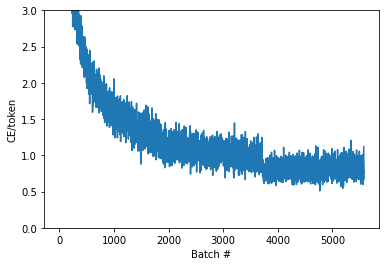

In [63]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

The visible jumps in the plot are at the epoch boundaries.

## Translate

Now that the model is trained, implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [64]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [65]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Convert token IDs to text

The first method to implement is `tokens_to_text` which converts from token IDs to human readable text.

In [66]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [67]:
Translator.tokens_to_text = tokens_to_text

Input some random token IDs and see what it generates:

In [68]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'overcome tomll', b'pleaded alice', b'running anywhere',
       b'blown becoming', b'flute buses'], dtype=object)

### Sample from the decoder's predictions

This function takes the decoder's logit outputs and samples token IDs from that distribution:

In [69]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [70]:
Translator.sample = sample

Test run this function on some random inputs:

In [71]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[4435],
       [ 140],
       [2052],
       [3710],
       [1136]])>

### Implement the translation loop

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using `tf.concat` to join them into tensors.

This implementation statically unrolls the graph out to `max_length` iterations.
This is okay with eager execution in python.

In [72]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [73]:
Translator.translate = translate_unrolled

Run it on a simple input:

In [74]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its been here long .
this is my life .

CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 164 ms


If you want to export this model you'll need to wrap this method in a `tf.function`. This basic implementation has a few issues if you try to do that:

1. The resulting graphs are very large and take a few seconds to build, save or load.
2. You can't break from a statically unrolled loop, so it will always run `max_length` iterations, even if all the outputs are done. But even then it's marginally faster than eager execution.


In [75]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

Run the `tf.function` once to compile it:

In [76]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 22.3 s, sys: 0 ns, total: 22.3 s
Wall time: 22.2 s


In [77]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its been very cold here .
this is my life .

CPU times: user 178 ms, sys: 0 ns, total: 178 ms
Wall time: 89 ms


In [78]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [79]:
Translator.translate = translate_symbolic

The initial implementation used python lists to collect the outputs. This uses `tf.range` as the loop iterator, allowing `tf.autograph` to convert the loop. The biggest change in this implementation is the use of `tf.TensorArray` instead of python `list` to accumulate tensors. `tf.TensorArray` is required to collect a variable number of tensors in graph mode. 

With eager execution this implementation performs on par with the original:

In [80]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it is very cold here .
this is my life .

CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 229 ms


But when you wrap it in a `tf.function` you'll notice two differences.

In [81]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

First: Graph creation is much faster (~10x), since it doesn't create `max_iterations` copies of the model.

In [82]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.17 s


Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.

In [83]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it is a cold here .
this is my life .

CPU times: user 54.5 ms, sys: 0 ns, total: 54.5 ms
Wall time: 21.1 ms


### Visualize the process

The attention weights returned by the `translate` method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [84]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.         1.         1.0000001  0.99999994 1.         1.
 1.0000001 ]


Here is the attention distribution for the first output step of the first example. Note how the attention is now much more focused than it was for the untrained model:

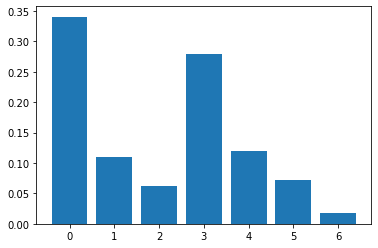

In [85]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

Since there is some rough alignment between the input and output words, you expect the attention to be focused near the diagonal:

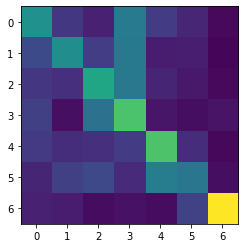

In [86]:
plt.imshow(np.array(a), vmin=0.0)

Here is some code to make a better attention plot:

In [87]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


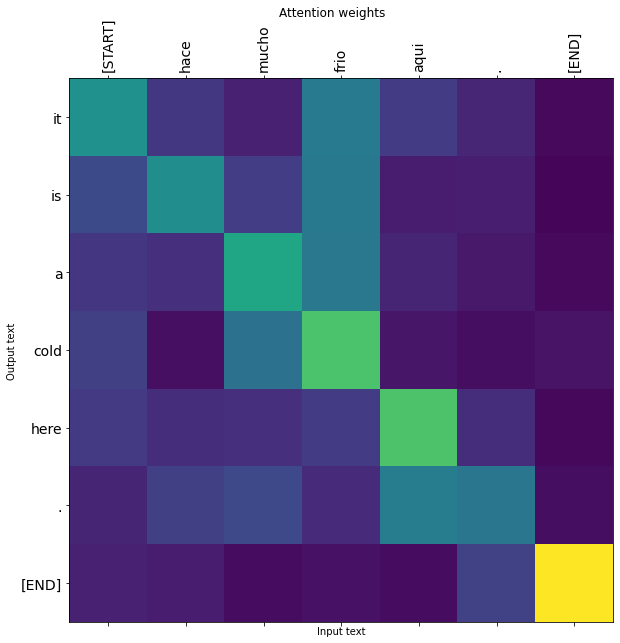

In [88]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

Translate a few more sentences and plot them:

In [89]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are you still inside me ?
i try to find out .

CPU times: user 65.7 ms, sys: 54.1 ms, total: 120 ms
Wall time: 26.8 ms


In [90]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'this is my life .', b'are you still inside me ?',
       b'i try to find out .'], dtype=object)>

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


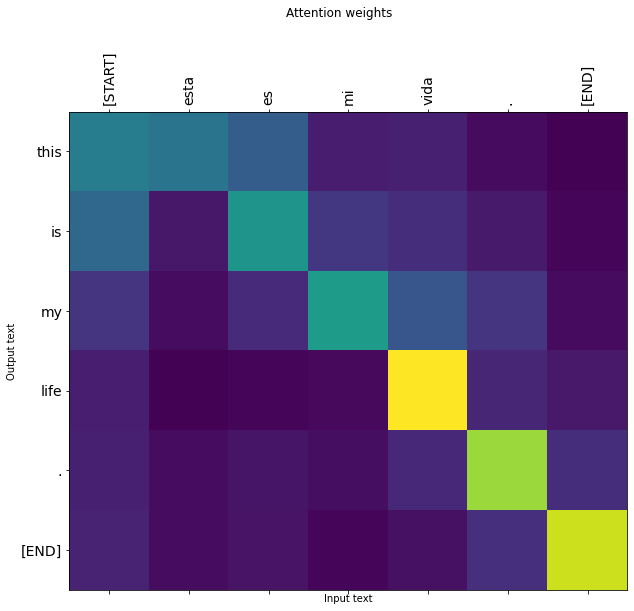

In [91]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


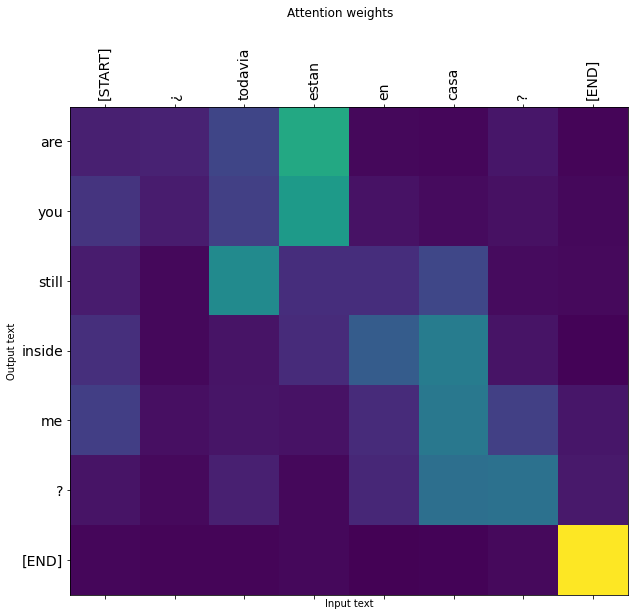

In [92]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


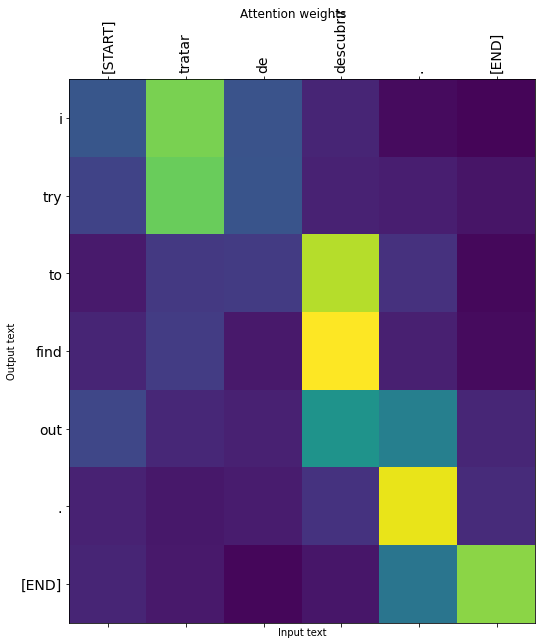

In [93]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. [Transformers](transformer.ipynb) solve this by using self-attention in the encoder and decoder.

In [94]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


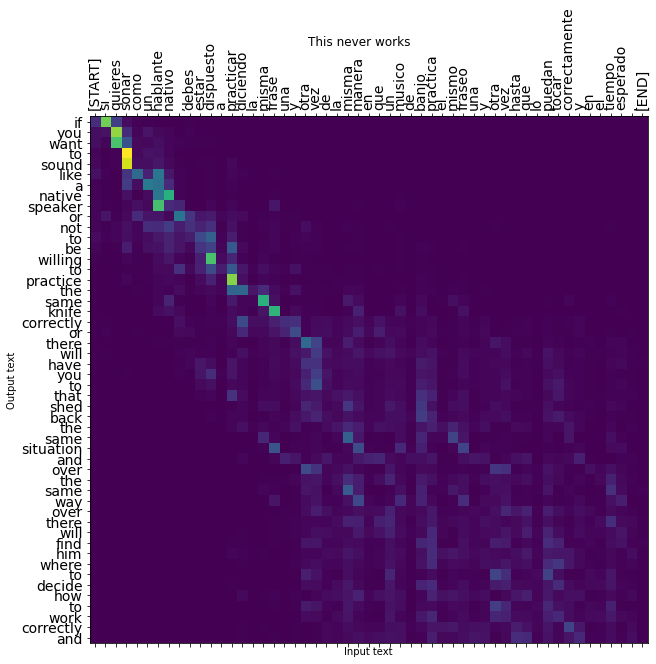

In [95]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

## Export

Once you have a model you're satisfied with you might want to export it as a `tf.saved_model` for use outside of this python program that created it.

Since the model is a subclass of `tf.Module` (through `keras.Model`), and all the functionality for export is compiled in a `tf.function` the model should export cleanly with `tf.saved_model.save`:  

Now that the function has been traced it can be exported using `saved_model.save`:

In [96]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

2022-03-29 12:01:26.522378: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [97]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [98]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are you still home ?
trying to find out .

CPU times: user 44.2 ms, sys: 4.11 ms, total: 48.3 ms
Wall time: 20.6 ms


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses a transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement wordpiece tokenization.
* Have a look at the [tensorflow_addons.seq2seq](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt) for implementing this sort of sequence to sequence model. The `tfa.seq2seq` package includes higher level functionality like `seq2seq.BeamSearchDecoder`. 